Data source: 

https://www.kaggle.com/competitions/spaceship-titanic

# 1. Intro and preprocessing

## 1.1 Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from functools import partial
from sklearn.preprocessing import OneHotEncoder
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap
import warnings
import seaborn as sns
import plotly
from sklearn.impute import SimpleImputer
from random import randrange
import random

## 1.2 EDA

In [5]:
df = pd.read_csv('../titanic spaceship/train.csv')

In [6]:
def eda(df):
    
    infos = []

    infos.append(df.info())
    infos.append(df.shape)
    infos.append(df.head())
    infos.append(df.describe())
    
    infos.append(df[df.Transported == True].shape)
    infos.append(df[df.Transported == False].shape)
    
    info_names = ['info', 'shape', 'head', 'describe', 'true_shape', 'false_shape']
    
    return dict(zip(info_names, infos))

In [7]:
eda(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


{'info': None,
 'shape': (8693, 14),
 'head':   PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
 0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
 1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
 2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
 3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
 4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   
 
    RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
 0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
 1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
 2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
 3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
 4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   
 
    Transported  
 0        False  
 1       

In [8]:
def plots_by_target(df):
    
    df_true = df[df.Transported == True]
    df_false = df[df.Transported == False]
    
    plt.hist(df_true.Age, label = 'True', bins = 20)
    plt.hist(df_false.Age, alpha = 0.5, label = 'False', bins = 20)
    plt.title("Age")
    plt.legend()
    plt.show()
    
    plt.hist(df_true.RoomService, label = 'True', bins = 30)
    plt.hist(df_false.RoomService, alpha = 0.5, label = 'False', bins = 30)
    plt.yscale('log')
    plt.title("RoomService")
    plt.legend()
    plt.show()

    plt.hist(df_true.FoodCourt, label = 'True', bins = 30)
    plt.hist(df_false.FoodCourt, alpha = 0.5, label = 'False')
    plt.yscale('log')
    plt.title("FoodCourt")
    plt.legend()
    plt.show()

    plt.hist(df_true.ShoppingMall, label = 'True', bins = 30)
    plt.hist(df_false.ShoppingMall, alpha = 0.5, label = 'False', bins = 30)
    plt.yscale('log')
    plt.title("ShoppingMall")
    plt.legend()
    plt.show()

    plt.hist(df_true.Spa, label = 'True', bins = 30)
    plt.hist(df_false.Spa, alpha = 0.5, label = 'False', bins = 30)
    plt.yscale('log')
    plt.title("Spa")
    plt.legend()
    plt.show()

    plt.hist(df_true.VRDeck, label = 'True', bins = 30)
    plt.hist(df_false.VRDeck, alpha = 0.5, label = 'False', bins = 30)
    plt.yscale('log')
    plt.title("VRDeck")
    plt.legend()
    plt.show()

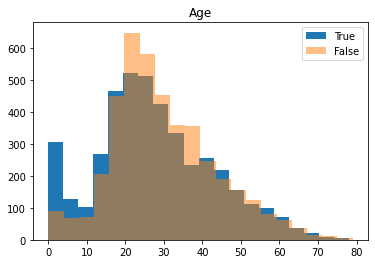

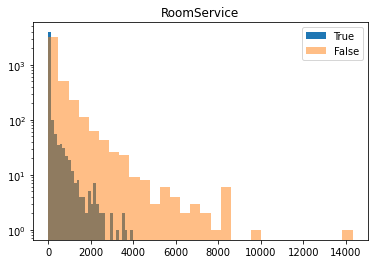

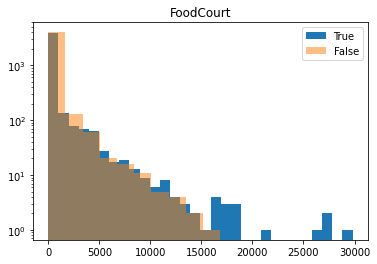

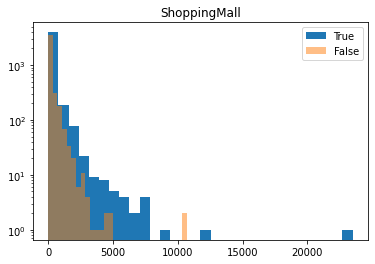

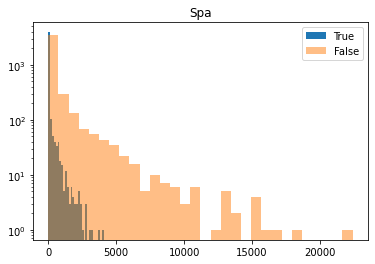

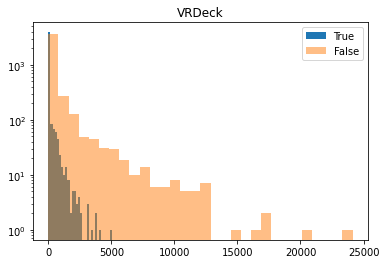

In [9]:
plots_by_target(df)

In [10]:
###    from pandas_profiling import ProfileReport

#prof = ProfileReport(df) 
#prof.to_file(output_file='df_report.html')

#prof = ProfileReport(df_true) 
#prof.to_file(output_file='df_true_report.html')

#prof = ProfileReport(df_false) 
#prof.to_file(output_file='df_false_report.html')

## 1.3 Cleaning and preprocessing

In [11]:
def data_cleaning_check(df):
    
    print('shape bez nulli: ')
    print(df[df.isnull().any(axis=1) == 0].shape)
    print('')
    print('nulle w rekordach:') 
    print(df.isnull().sum() )

In [12]:
data_cleaning_check(df)

shape bez nulli: 
(6606, 14)

nulle w rekordach:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [14]:
df_nonull = pd.DataFrame(imputer.fit_transform(df), columns = df.columns, index = df.index)
df_nonull

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

     RoomService FoodCourt ShoppingMall     Spa  VRDeck               Name  \
0            0.0       0.0          0.0     0.0     0.0    Maham Ofracculy   
1          109.0       9.0         25.0   549.0    44.0       Juanna Vines   
2           43.0    3576.0          0.0  6715.0    49.0      Altark Susent   
3            0.0    1283.0        371.0  3329.0   193.0       Solam Susent   
4          303.0      70.0        151.0   565.0     2.0  Willy Santantines   
...          ...       ...          ...     ...     ...                ...   
8688         0.0    6819.0          0.0  1643.0    74.0  Gravior Noxnuther   
8689         0.0       0.0          0.0     0.0     0.0    Kurta Mondalley   
8690         0.0       0.0       1872.0     1.0     0.0       Fayey Connon   
8691         0.0    1049.0          0.0   353.0  3235.0   Celeon Hontichre   
8692       126.0    4688.0          0.0     0.0    12.0   Propsh Hontichre   

     Transported  
0          False  
1           True  
2          False  
3          False  
4           True  
...          ...  
8688       False  
8689       False  
8690        True  
8691       False  
8692        True  

[8693 rows x 14 columns]

In [15]:
df_nonull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PassengerId   8693 non-null   object
 1   HomePlanet    8693 non-null   object
 2   CryoSleep     8693 non-null   object
 3   Cabin         8693 non-null   object
 4   Destination   8693 non-null   object
 5   Age           8693 non-null   object
 6   VIP           8693 non-null   object
 7   RoomService   8693 non-null   object
 8   FoodCourt     8693 non-null   object
 9   ShoppingMall  8693 non-null   object
 10  Spa           8693 non-null   object
 11  VRDeck        8693 non-null   object
 12  Name          8693 non-null   object
 13  Transported   8693 non-null   object
dtypes: object(14)
memory usage: 950.9+ KB


In [16]:
df_nonull.RoomService = df_nonull.RoomService.astype(float)
df_nonull.FoodCourt = df_nonull.FoodCourt.astype(float)
df_nonull.ShoppingMall = df_nonull.ShoppingMall.astype(float)
df_nonull.Spa = df_nonull.Spa.astype(float)
df_nonull.VRDeck = df_nonull.VRDeck.astype(float)
df_nonull.Age = df_nonull.Age.astype(float)

In [17]:
cabin = df_nonull.Cabin.str.split('/')
side = [item[2] for item in cabin]
df_nonull['Side'] = side
df_nonull

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0             0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1           109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2            43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3             0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4           303.0       70.0         151.0   565.0     2.0  Willy Santantines   
...           ...        ...           ...     ...     ...                ...   
8688          0.0     6819.0           0.0  1643.0    74.0  Gravior Noxnuther   
8689          0.0        0.0           0.0     0.0     0.0    Kurta Mondalley   
8690          0.0        0.0        1872.0     1.0     0.0       Fayey Connon   
8691          0.0     1049.0           0.0   353.0  3235.0   Celeon Hontichre   
8692        126.0     4688.0           0.0     0.0    12.0   Propsh Hontichre   

     Transported Side  
0          False    P  
1           True    S  
2          False    S  
3          False    S  
4           True    S  
...          ...  ...  
8688       False    P  
8689       False    S  
8690        True    S  
8691       False    S  
8692        True    S  

[8693 rows x 15 columns]

In [18]:
df_nonull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   object 
 14  Side          8693 non-null   object 
dtypes: float64(6), object(9)
memory usage: 1018.8+ KB


In [19]:
def data_preprocessing_one_hot(df, index = True):
    
    X1 = df.drop("Transported", axis = 1)
    
    X2 = X1.drop("Name", axis = 1)
    X3 = X2.drop("PassengerId", axis = 1)
    X4 = X3.drop("Cabin", axis = 1)
    
    if index == True:
        X = X4.drop("index", axis = 1)
    
    elif index == False:
        X = X4
        
    else:
        print("Error: argument index expected 'True' or 'False'")
    
    X["CryoSleep"] = X["CryoSleep"].fillna(0).astype(int)
    X["VIP"] = X["VIP"].fillna(0).astype(int)
    
    X_dum = pd.get_dummies(X)
    y = df.Transported
    
    return X_dum, y

In [20]:
X_dum1, target = data_preprocessing_one_hot(df_nonull, index = False)

In [21]:
X_dum = X_dum1.drop('Side_S', axis = 1)

In [22]:
def correlation_matrix(df):
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    corr = df.corr()
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True, ax = ax)

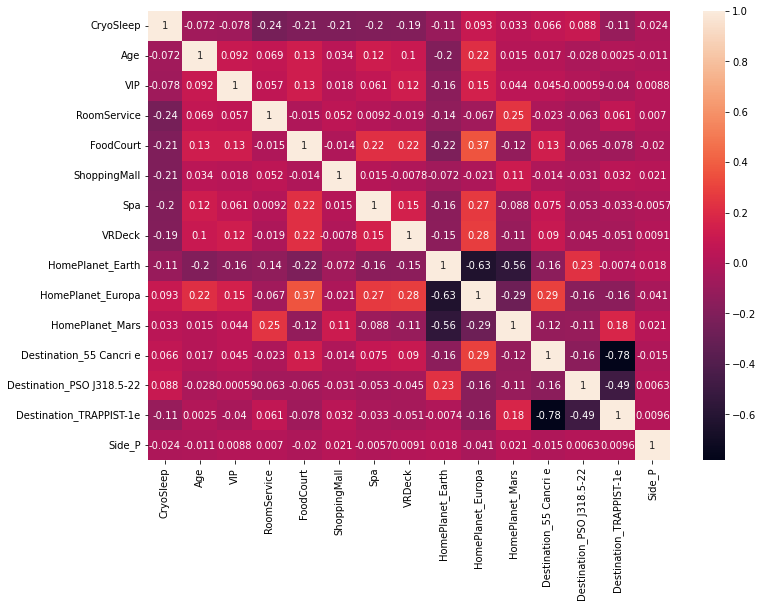

In [23]:
correlation_matrix(X_dum)

## 1.4 Outliers

In [24]:
def outliers(df):
    
    df_out = df.copy()
    
    isolation_forest = IForest(random_state = 1)
    isolation_forest.fit(df_out)
    df_out['outlier_probability_IF'] = isolation_forest.predict_proba(df_out)[:,1]
    
    lof = LOF()
    lof.fit(df_out)
    df_out['outlier_probability_LOF'] = lof.predict_proba(df_out)[:, 1]
    
    return df_out

In [25]:
outlier_df = outliers(X_dum)

X has feature names, but IsolationForest was fitted without feature names


In [26]:
cut_prob = 0.5

outlier_df[(outlier_df['outlier_probability_IF'] > cut_prob) & (outlier_df['outlier_probability_LOF'] > cut_prob)]

Empty DataFrame
Columns: [CryoSleep, Age, VIP, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, HomePlanet_Earth, HomePlanet_Europa, HomePlanet_Mars, Destination_55 Cancri e, Destination_PSO J318.5-22, Destination_TRAPPIST-1e, Side_P, outlier_probability_IF, outlier_probability_LOF]
Index: []

## 1.5 Train-test split and scaling

In [27]:
def scaled_data_split(X, y):

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

    X_train, X_valid = X_train.reset_index(drop=True), X_valid.reset_index(drop=True), 
    y_train, y_valid = y_train.reset_index(drop=True), y_valid.reset_index(drop=True)

    scaler = StandardScaler()
    X_train_scaled, X_valid_scaled = scaler.fit_transform(X_train), scaler.transform(X_valid)
    
    return pd.DataFrame(X_train_scaled, columns = X.columns), pd.DataFrame(X_valid_scaled, columns = X.columns), y_train, y_valid

In [28]:
X_train_scaled, X_valid_scaled, y_train, y_valid = scaled_data_split(X_dum, target)
y_train = y_train.astype(bool)
y_valid = y_valid.astype(bool)

# 2. Proof of concept models - Optuna

## 2.1. RF

In [35]:
def rf(trial):

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    max_features = trial.suggest_uniform("max_features", 0.01, 1.0)

    model = ensemble.RandomForestClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        max_features = max_features,
        criterion = criterion
    )
    
    return model

## 2.2. NN

In [36]:
nn_input_dim = X_dum.shape[1]

In [37]:
def ann(trial):

    n_layers = trial.suggest_int("n_layers", 1, 3)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape = (nn_input_dim,)))
    num_hidden = 32
    for i in range(n_layers):
        k = num_hidden
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 6, k, log=True)
        model.add(
            tf.keras.layers.Dense(
                num_hidden,
                activation="relu",
            )
        )
        model.add(tf.keras.layers.Dropout(0.1))
        
    model.add(
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    )
    
    return model

In [38]:
def create_optimizer(trial):

    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float(
            "rmsprop_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
        
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
        
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float(
            "sgd_opt_learning_rate", 1e-5, 1e-1, log=True
        )
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

## 2.3. SVM

In [39]:
def svm(trial):

    kernel = trial.suggest_categorical('kernel',['rbf','poly','linear','sigmoid'])
    c = trial.suggest_float("C",0.1,3.0,log=True)
    gamma = trial.suggest_categorical('gamma',['auto','scale'])
    degree = trial.suggest_int("degree",1,3,log=True)

    model = SVC(kernel=kernel,degree=degree,gamma=gamma,C=c)

    return model

## 2.4. Tuning the models

In [40]:
def model(trial, x, y, classifier_name = 'ALL'):
    
    kf = model_selection.StratifiedKFold(n_splits = 5)
    accuracies = []
    
    if classifier_name == 'ALL':
    
        classifier_name = trial.suggest_categorical('classifier', ['RF','ANN','SVM'])
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        
    for idx in kf.split(X = x, y = y):
        train_idx, test_idx = idx[0], idx[1]

        xtrain = x.loc[train_idx]
        ytrain = y.loc[train_idx]

        xtest = x.loc[test_idx]
        ytest = y.loc[test_idx]
            
        if classifier_name == 'RF':
            
            model = rf(trial)
        
            model.fit(xtrain, ytrain)
            preds = model.predict(xtest)
            fold_acc = metrics.accuracy_score(ytest, preds)
            accuracies.append(fold_acc)
    
        if classifier_name == 'ANN':
    
            model = ann(trial)
            model.compile(optimizer = create_optimizer(trial),
            loss = 'binary_crossentropy',
            metrics = ['accuracy'])
            
            r = model.fit(xtrain, ytrain, validation_data = (xtest, ytest), epochs = 200, callbacks=[callback])
            fold_acc = r.history['val_accuracy'][-1]
            accuracies.append(fold_acc)
            
        if classifier_name == 'SVM':

            model = svm(trial)
        
            model.fit(xtrain, ytrain)
            preds = model.predict(xtest)
            fold_acc = metrics.accuracy_score(ytest, preds)
            accuracies.append(fold_acc)
    
    return np.mean(accuracies)

### 2.4.1. RF

In [90]:
optimization_function = partial(model, x = X_train_scaled, y = y_train, classifier_name = 'RF')

study_poc_rf = optuna.create_study(direction = "maximize")
study_poc_rf.optimize(optimization_function, n_trials = 100)

[I 2022-07-16 15:51:40,340] A new study created in memory with name: no-name-7cf35efd-e05a-4dc2-b0bf-a547e86536b2
[I 2022-07-16 15:52:02,005] Trial 0 finished with value: 0.7887550491598094 and parameters: {'criterion': 'gini', 'n_estimators': 198, 'max_depth': 14, 'max_features': 0.2747772445934144}. Best is trial 0 with value: 0.7887550491598094.
[I 2022-07-16 15:52:47,176] Trial 1 finished with value: 0.7835783996814051 and parameters: {'criterion': 'entropy', 'n_estimators': 218, 'max_depth': 26, 'max_features': 0.5742104608255862}. Best is trial 0 with value: 0.7887550491598094.
[I 2022-07-16 15:52:56,211] Trial 2 finished with value: 0.7681924395781721 and parameters: {'criterion': 'entropy', 'n_estimators': 224, 'max_depth': 7, 'max_features': 0.11185609151446765}. Best is trial 0 with value: 0.7887550491598094.
[I 2022-07-16 15:54:00,104] Trial 3 finished with value: 0.7842972035024749 and parameters: {'criterion': 'gini', 'n_estimators': 368, 'max_depth': 20, 'max_features': 0

[I 2022-07-16 16:24:55,016] Trial 32 finished with value: 0.7923496889045198 and parameters: {'criterion': 'entropy', 'n_estimators': 392, 'max_depth': 11, 'max_features': 0.45071572976712343}. Best is trial 19 with value: 0.7939308711190645.
[I 2022-07-16 16:25:20,295] Trial 33 finished with value: 0.7752378341755064 and parameters: {'criterion': 'entropy', 'n_estimators': 350, 'max_depth': 5, 'max_features': 0.20654344974523958}. Best is trial 19 with value: 0.7939308711190645.
[I 2022-07-16 16:26:02,042] Trial 34 finished with value: 0.7927807229414168 and parameters: {'criterion': 'entropy', 'n_estimators': 247, 'max_depth': 8, 'max_features': 0.5109214346687363}. Best is trial 19 with value: 0.7939308711190645.
[I 2022-07-16 16:26:30,209] Trial 35 finished with value: 0.7923497923444135 and parameters: {'criterion': 'entropy', 'n_estimators': 159, 'max_depth': 6, 'max_features': 0.5532655332099329}. Best is trial 19 with value: 0.7939308711190645.
[I 2022-07-16 16:27:20,490] Trial

[I 2022-07-16 16:45:36,985] Trial 65 finished with value: 0.7934998370821675 and parameters: {'criterion': 'gini', 'n_estimators': 332, 'max_depth': 10, 'max_features': 0.31889273326326384}. Best is trial 52 with value: 0.7946494680603469.
[I 2022-07-16 16:46:14,671] Trial 66 finished with value: 0.7939313883185328 and parameters: {'criterion': 'entropy', 'n_estimators': 331, 'max_depth': 10, 'max_features': 0.26688024412054046}. Best is trial 52 with value: 0.7946494680603469.
[I 2022-07-16 16:46:51,413] Trial 67 finished with value: 0.7929242975138222 and parameters: {'criterion': 'gini', 'n_estimators': 331, 'max_depth': 10, 'max_features': 0.3245315668490856}. Best is trial 52 with value: 0.7946494680603469.
[I 2022-07-16 16:47:20,155] Trial 68 finished with value: 0.7837209398548738 and parameters: {'criterion': 'entropy', 'n_estimators': 359, 'max_depth': 6, 'max_features': 0.25045149033664876}. Best is trial 52 with value: 0.7946494680603469.
[I 2022-07-16 16:47:56,749] Trial 69

[I 2022-07-16 17:10:28,867] Trial 98 finished with value: 0.7903358176147794 and parameters: {'criterion': 'entropy', 'n_estimators': 278, 'max_depth': 7, 'max_features': 0.4743326467878206}. Best is trial 95 with value: 0.7949381688035625.
[I 2022-07-16 17:11:24,289] Trial 99 finished with value: 0.7901920361625868 and parameters: {'criterion': 'gini', 'n_estimators': 298, 'max_depth': 10, 'max_features': 0.5693211740908201}. Best is trial 95 with value: 0.7949381688035625.


In [91]:
study_poc_rf.best_trial

FrozenTrial(number=95, values=[0.7949381688035625], datetime_start=datetime.datetime(2022, 7, 16, 17, 7, 53, 372476), datetime_complete=datetime.datetime(2022, 7, 16, 17, 8, 28, 446458), params={'criterion': 'entropy', 'n_estimators': 225, 'max_depth': 10, 'max_features': 0.42751294975032905}, distributions={'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'n_estimators': IntUniformDistribution(high=500, low=100, step=1), 'max_depth': IntUniformDistribution(high=30, low=3, step=1), 'max_features': UniformDistribution(high=1.0, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=95, state=TrialState.COMPLETE, value=None)

In [90]:
#optuna.visualization.plot_parallel_coordinate(study_poc_rf)

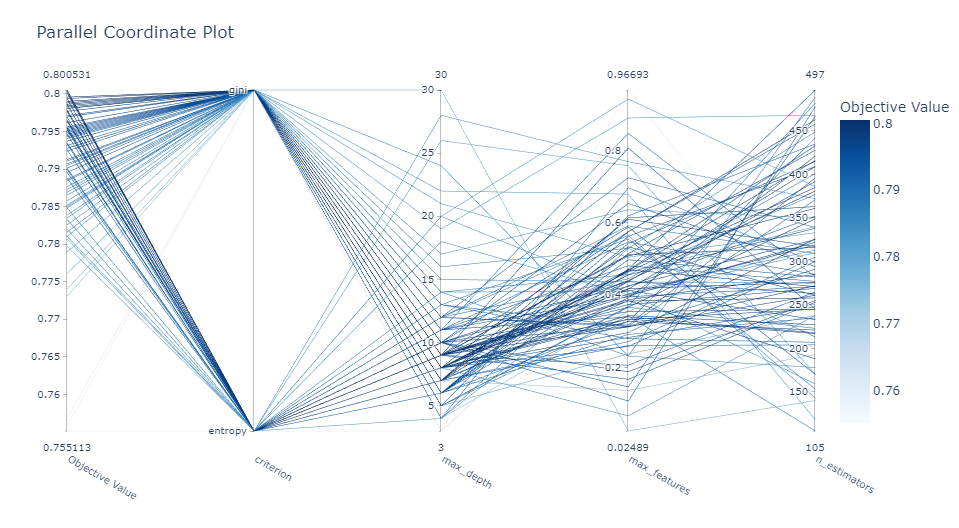

In [91]:
#optuna.visualization.plot_param_importances(study_poc_rf)

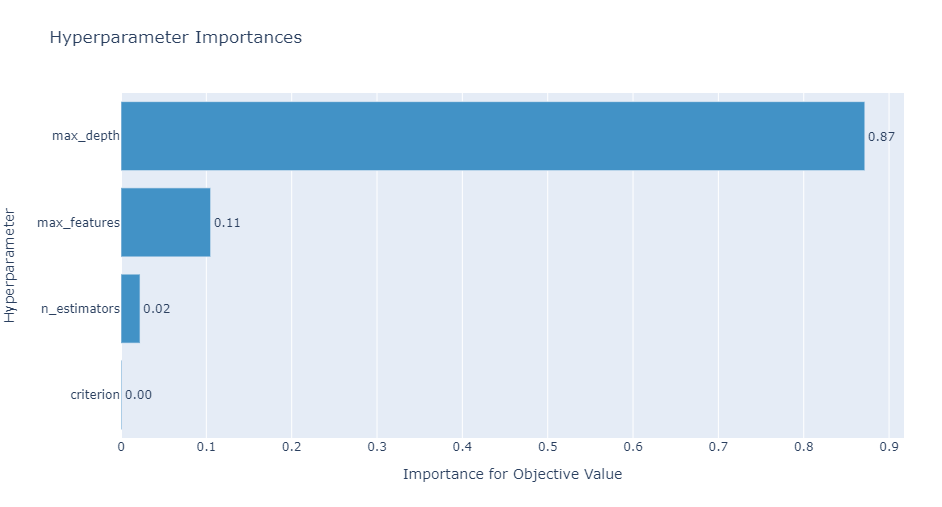

### 2.4.2. NN

In [53]:
optimization_function = partial(model, x = X_train_scaled, y = y_train, classifier_name = 'ANN')

study_poc_ann = optuna.create_study(direction = "maximize")
study_poc_ann.optimize(optimization_function, n_trials = 100)

[I 2022-05-18 19:15:40,329] A new study created in memory with name: no-name-9b4c859c-64fc-4301-88fb-b2a2aad2ce35


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6341 - accuracy: 0.6449 - val_loss: 0.6143 - val_accuracy: 0.7058
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6200 - accuracy: 0.6714 - val_loss: 0.6075 - val_accuracy: 0.7162
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6155 - accuracy: 0.6764 - val_loss: 0.6036 - val_accuracy: 0.7200
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6079 - accuracy: 0.6906 - val_loss: 0.6007 - val_accuracy: 0.7200
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6098 - accuracy: 0.6858 - val_loss: 0.5985 - val_accuracy: 0.7200
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6084 - accuracy: 0.6790 - val_loss: 0.5967 - val_accuracy: 0.7228
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6050 - accuracy: 0.6894 - val_loss: 0.5951 - val_accuracy: 0.7256

133/133 [==============================] - 0s 2ms/step - loss: 0.5787 - accuracy: 0.6875 - val_loss: 0.5474 - val_accuracy: 0.7237
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5775 - accuracy: 0.6861 - val_loss: 0.5468 - val_accuracy: 0.7256
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5767 - accuracy: 0.6936 - val_loss: 0.5463 - val_accuracy: 0.7256
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5720 - accuracy: 0.6962 - val_loss: 0.5457 - val_accuracy: 0.7285
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5757 - accuracy: 0.6929 - val_loss: 0.5453 - val_accuracy: 0.7294
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5784 - accuracy: 0.6913 - val_loss: 0.5448 - val_accuracy: 0.7304
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5779 - accuracy: 0.6917 - val_loss: 0.5444 - val_accuracy: 0.7304
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.6289 - accuracy: 0.6546 - val_loss: 0.6325 - val_accuracy: 0.6698
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6315 - accuracy: 0.6546 - val_loss: 0.6322 - val_accuracy: 0.6698
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6299 - accuracy: 0.6520 - val_loss: 0.6320 - val_accuracy: 0.6698
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6329 - accuracy: 0.6442 - val_loss: 0.6318 - val_accuracy: 0.6698
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6302 - accuracy: 0.6515 - val_loss: 0.6315 - val_accuracy: 0.6698
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6329 - accuracy: 0.6508 - val_loss: 0.6313 - val_accuracy: 0.6708
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6329 - accuracy: 0.6520 - val_loss: 0.6311 - val_accuracy: 0.6708
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.6169 - accuracy: 0.7010 - val_loss: 0.6153 - val_accuracy: 0.7162
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6199 - accuracy: 0.6915 - val_loss: 0.6151 - val_accuracy: 0.7162
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6169 - accuracy: 0.7055 - val_loss: 0.6148 - val_accuracy: 0.7162
Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6130 - accuracy: 0.7059 - val_loss: 0.6145 - val_accuracy: 0.7162
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6168 - accuracy: 0.7019 - val_loss: 0.6143 - val_accuracy: 0.7162
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6192 - accuracy: 0.6967 - val_loss: 0.6140 - val_accuracy: 0.7162
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6166 - accuracy: 0.7055 - val_loss: 0.6138 - val_accuracy: 0.7162
Epoch

[I 2022-05-18 19:16:26,699] Trial 0 finished with value: 0.7034366846084594 and parameters: {'n_layers': 3, 'n_units_l0': 13, 'n_units_l1': 11, 'n_units_l2': 9, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00961768661252553, 'rmsprop_decay': 0.9651264958512988, 'rmsprop_momentum': 0.09936718673823838}. Best is trial 0 with value: 0.7034366846084594.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5956 - accuracy: 0.7090 - val_loss: 0.5669 - val_accuracy: 0.7531
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5682 - accuracy: 0.7376 - val_loss: 0.5561 - val_accuracy: 0.7569
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5610 - accuracy: 0.7478 - val_loss: 0.5498 - val_accuracy: 0.7578
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5558 - accuracy: 0.7540 - val_loss: 0.5454 - val_accuracy: 0.7663
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5542 - accuracy: 0.7511 - val_loss: 0.5420 - val_accuracy: 0.7711
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5525 - accuracy: 0.7495 - val_loss: 0.5392 - val_accuracy: 0.7720
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5496 - accuracy: 0.7573 - val_loss: 0.5367 - val_accuracy: 0.7739

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5192 - accuracy: 0.7660 - val_loss: 0.5053 - val_accuracy: 0.7805
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5203 - accuracy: 0.7582 - val_loss: 0.5051 - val_accuracy: 0.7805
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5190 - accuracy: 0.7677 - val_loss: 0.5049 - val_accuracy: 0.7815
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5169 - accuracy: 0.7679 - val_loss: 0.5047 - val_accuracy: 0.7815
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5193 - accuracy: 0.7641 - val_loss: 0.5045 - val_accuracy: 0.7815
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5230 - accuracy: 0.7604 - val_loss: 0.5043 - val_accuracy: 0.7815
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5205 - accuracy: 0.7618 - val_loss: 0.5042 - val_accuracy:

Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5232 - accuracy: 0.7369 - val_loss: 0.4965 - val_accuracy: 0.7673
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5188 - accuracy: 0.7447 - val_loss: 0.4963 - val_accuracy: 0.7673
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5209 - accuracy: 0.7379 - val_loss: 0.4960 - val_accuracy: 0.7673
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5188 - accuracy: 0.7393 - val_loss: 0.4957 - val_accuracy: 0.7663
Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5173 - accuracy: 0.7438 - val_loss: 0.4955 - val_accuracy: 0.7663
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5200 - accuracy: 0.7492 - val_loss: 0.4953 - val_accuracy: 0.7673
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5230 - accuracy: 0.7379 - val_loss: 0.4950 - val_accuracy:

Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5216 - accuracy: 0.7485 - val_loss: 0.5082 - val_accuracy: 0.7625
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5245 - accuracy: 0.7419 - val_loss: 0.5079 - val_accuracy: 0.7625
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5183 - accuracy: 0.7530 - val_loss: 0.5075 - val_accuracy: 0.7616
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5146 - accuracy: 0.7528 - val_loss: 0.5071 - val_accuracy: 0.7616
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5235 - accuracy: 0.7488 - val_loss: 0.5068 - val_accuracy: 0.7616
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5197 - accuracy: 0.7497 - val_loss: 0.5065 - val_accuracy: 0.7625
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5180 - accuracy: 0.7483 - val_loss: 0.5062 - val_accuracy:

Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5155 - accuracy: 0.7353 - val_loss: 0.5149 - val_accuracy: 0.7408
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5123 - accuracy: 0.7424 - val_loss: 0.5147 - val_accuracy: 0.7408
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5168 - accuracy: 0.7369 - val_loss: 0.5146 - val_accuracy: 0.7408
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6291 - accuracy: 0.6715 - val_loss: 0.5994 - val_accuracy: 0.7528
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5978 - accuracy: 0.7282 - val_loss: 0.5828 - val_accuracy: 0.7689
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5871 - accuracy: 0.7408 - val_loss: 0.5734 - val_accuracy: 0.7689
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5781 - accuracy: 0.7420 - val_loss: 0.5669 - val_accuracy: 0.7

Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5328 - accuracy: 0.7621 - val_loss: 0.5158 - val_accuracy: 0.7765
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5332 - accuracy: 0.7500 - val_loss: 0.5155 - val_accuracy: 0.7765
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5290 - accuracy: 0.7519 - val_loss: 0.5152 - val_accuracy: 0.7765
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5313 - accuracy: 0.7550 - val_loss: 0.5149 - val_accuracy: 0.7765
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5303 - accuracy: 0.7564 - val_loss: 0.5146 - val_accuracy: 0.7765
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5313 - accuracy: 0.7547 - val_loss: 0.5143 - val_accuracy: 0.7765
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5345 - accuracy: 0.7535 - val_loss: 0.5140 - val_accuracy:

[I 2022-05-18 19:17:28,241] Trial 1 finished with value: 0.7651421904563904 and parameters: {'n_layers': 2, 'n_units_l0': 11, 'n_units_l1': 10, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.030410792506866024, 'rmsprop_decay': 0.8668057235871857, 'rmsprop_momentum': 0.002594382546521901}. Best is trial 1 with value: 0.7651421904563904.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7015 - accuracy: 0.4942 - val_loss: 0.6906 - val_accuracy: 0.5213
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6989 - accuracy: 0.4987 - val_loss: 0.6902 - val_accuracy: 0.5251
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7020 - accuracy: 0.4966 - val_loss: 0.6898 - val_accuracy: 0.5232
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6998 - accuracy: 0.5018 - val_loss: 0.6895 - val_accuracy: 0.5213
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6985 - accuracy: 0.5022 - val_loss: 0.6891 - val_accuracy: 0.5222
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.5148 - val_loss: 0.6888 - val_accuracy: 0.5345
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7004 - accuracy: 0.5172 - val_loss: 0.6884 - val_accuracy: 0.5364

133/133 [==============================] - 0s 1ms/step - loss: 0.7134 - accuracy: 0.5157 - val_loss: 0.7057 - val_accuracy: 0.5402
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7089 - accuracy: 0.5224 - val_loss: 0.7040 - val_accuracy: 0.5487
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7082 - accuracy: 0.5283 - val_loss: 0.7024 - val_accuracy: 0.5516
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7077 - accuracy: 0.5287 - val_loss: 0.7008 - val_accuracy: 0.5762
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7073 - accuracy: 0.5295 - val_loss: 0.6994 - val_accuracy: 0.5894
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7075 - accuracy: 0.5193 - val_loss: 0.6979 - val_accuracy: 0.6064
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7051 - accuracy: 0.5295 - val_loss: 0.6964 - val_accuracy: 0.6112
Epoch

Epoch 88/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.6021 - val_loss: 0.6451 - val_accuracy: 0.6462
Epoch 89/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6605 - accuracy: 0.5855 - val_loss: 0.6442 - val_accuracy: 0.6452
Epoch 90/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6600 - accuracy: 0.6052 - val_loss: 0.6432 - val_accuracy: 0.6490
Epoch 91/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6569 - accuracy: 0.6070 - val_loss: 0.6422 - val_accuracy: 0.6500
Epoch 92/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6550 - accuracy: 0.6151 - val_loss: 0.6411 - val_accuracy: 0.6518
Epoch 93/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6577 - accuracy: 0.6054 - val_loss: 0.6401 - val_accuracy: 0.6566
Epoch 94/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6552 - accuracy: 0.6165 - val_loss: 0.6391 - val_accuracy:

133/133 [==============================] - 0s 2ms/step - loss: 0.5810 - accuracy: 0.6962 - val_loss: 0.5427 - val_accuracy: 0.7483
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7074 - accuracy: 0.4542 - val_loss: 0.7035 - val_accuracy: 0.4910
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7062 - accuracy: 0.4608 - val_loss: 0.7029 - val_accuracy: 0.4910
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7066 - accuracy: 0.4388 - val_loss: 0.7024 - val_accuracy: 0.4891
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7042 - accuracy: 0.4459 - val_loss: 0.7019 - val_accuracy: 0.4920
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7034 - accuracy: 0.4668 - val_loss: 0.7015 - val_accuracy: 0.4939
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7031 - accuracy: 0.4549 - val_loss: 0.7011 - val_accuracy: 0.4957
Epoch 7/200

133/133 [==============================] - 0s 1ms/step - loss: 0.6861 - accuracy: 0.5190 - val_loss: 0.6842 - val_accuracy: 0.5535
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6850 - accuracy: 0.5250 - val_loss: 0.6839 - val_accuracy: 0.5601
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6856 - accuracy: 0.5264 - val_loss: 0.6836 - val_accuracy: 0.5629
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.5198 - val_loss: 0.6833 - val_accuracy: 0.5610
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6852 - accuracy: 0.5148 - val_loss: 0.6831 - val_accuracy: 0.5601
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6852 - accuracy: 0.5347 - val_loss: 0.6828 - val_accuracy: 0.5639
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6854 - accuracy: 0.5238 - val_loss: 0.6826 - val_accuracy: 0.5639
Epoch

Epoch 114/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6713 - accuracy: 0.5832 - val_loss: 0.6679 - val_accuracy: 0.6689
Epoch 115/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6688 - accuracy: 0.5853 - val_loss: 0.6676 - val_accuracy: 0.6698
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6708 - accuracy: 0.5910 - val_loss: 0.6673 - val_accuracy: 0.6708
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6696 - accuracy: 0.5905 - val_loss: 0.6669 - val_accuracy: 0.6727
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6692 - accuracy: 0.5903 - val_loss: 0.6666 - val_accuracy: 0.6717
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6690 - accuracy: 0.5945 - val_loss: 0.6663 - val_accuracy: 0.6727
Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6678 - accuracy: 0.6030 - val_loss: 0.6659 - val_ac

Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6997 - accuracy: 0.5354 - val_loss: 0.6883 - val_accuracy: 0.5809
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6994 - accuracy: 0.5321 - val_loss: 0.6876 - val_accuracy: 0.5818
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5396 - val_loss: 0.6868 - val_accuracy: 0.5809
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6958 - accuracy: 0.5503 - val_loss: 0.6861 - val_accuracy: 0.5847
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6959 - accuracy: 0.5422 - val_loss: 0.6853 - val_accuracy: 0.5818
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6946 - accuracy: 0.5422 - val_loss: 0.6846 - val_accuracy: 0.5828
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6926 - accuracy: 0.5470 - val_loss: 0.6839 - val_accuracy:

Epoch 84/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6695 - accuracy: 0.6035 - val_loss: 0.6602 - val_accuracy: 0.6575
Epoch 85/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6666 - accuracy: 0.6184 - val_loss: 0.6598 - val_accuracy: 0.6585
Epoch 86/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6691 - accuracy: 0.6137 - val_loss: 0.6594 - val_accuracy: 0.6575
Epoch 87/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6680 - accuracy: 0.6111 - val_loss: 0.6590 - val_accuracy: 0.6585
Epoch 88/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6695 - accuracy: 0.6092 - val_loss: 0.6586 - val_accuracy: 0.6594
Epoch 89/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6645 - accuracy: 0.6191 - val_loss: 0.6582 - val_accuracy: 0.6585
Epoch 90/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6654 - accuracy: 0.6189 - val_loss: 0.6578 - val_accuracy:

133/133 [==============================] - 0s 1ms/step - loss: 0.6205 - accuracy: 0.6887 - val_loss: 0.6107 - val_accuracy: 0.7096
Epoch 197/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6226 - accuracy: 0.6846 - val_loss: 0.6103 - val_accuracy: 0.7105
Epoch 198/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6215 - accuracy: 0.6832 - val_loss: 0.6098 - val_accuracy: 0.7105
Epoch 199/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6163 - accuracy: 0.6910 - val_loss: 0.6094 - val_accuracy: 0.7105
Epoch 200/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6217 - accuracy: 0.6823 - val_loss: 0.6090 - val_accuracy: 0.7114
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.8058 - accuracy: 0.5026 - val_loss: 0.7836 - val_accuracy: 0.5019
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7891 - accuracy: 0.5043 - val_loss: 0.7716 - val_accuracy: 0.5038
Epo

133/133 [==============================] - 0s 1ms/step - loss: 0.6400 - accuracy: 0.6613 - val_loss: 0.6293 - val_accuracy: 0.7055
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6389 - accuracy: 0.6580 - val_loss: 0.6280 - val_accuracy: 0.7055
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6377 - accuracy: 0.6575 - val_loss: 0.6268 - val_accuracy: 0.7045
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6361 - accuracy: 0.6684 - val_loss: 0.6256 - val_accuracy: 0.7083
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6351 - accuracy: 0.6585 - val_loss: 0.6244 - val_accuracy: 0.7121
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6372 - accuracy: 0.6639 - val_loss: 0.6232 - val_accuracy: 0.7140
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6328 - accuracy: 0.6677 - val_loss: 0.6220 - val_accuracy: 0.7159
Epoch

Epoch 110/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5960 - accuracy: 0.6923 - val_loss: 0.5723 - val_accuracy: 0.7348
Epoch 111/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5918 - accuracy: 0.7003 - val_loss: 0.5716 - val_accuracy: 0.7358
Epoch 112/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5927 - accuracy: 0.6937 - val_loss: 0.5708 - val_accuracy: 0.7358
Epoch 113/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5914 - accuracy: 0.7018 - val_loss: 0.5701 - val_accuracy: 0.7386
Epoch 114/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5891 - accuracy: 0.7018 - val_loss: 0.5694 - val_accuracy: 0.7386
Epoch 115/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5906 - accuracy: 0.6989 - val_loss: 0.5687 - val_accuracy: 0.7396
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5891 - accuracy: 0.6991 - val_loss: 0.5679 - val_ac

[I 2022-05-18 19:20:11,590] Trial 2 finished with value: 0.7023184180259705 and parameters: {'n_layers': 3, 'n_units_l0': 12, 'n_units_l1': 12, 'n_units_l2': 11, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0002666752310999086, 'sgd_opt_momentum': 0.00021738570582687327}. Best is trial 1 with value: 0.7651421904563904.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.8087 - accuracy: 0.6186 - val_loss: 0.8125 - val_accuracy: 0.6339
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.8099 - accuracy: 0.6238 - val_loss: 0.8118 - val_accuracy: 0.6339
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8039 - accuracy: 0.6177 - val_loss: 0.8111 - val_accuracy: 0.6339
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8037 - accuracy: 0.6189 - val_loss: 0.8104 - val_accuracy: 0.6339
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8027 - accuracy: 0.6132 - val_loss: 0.8097 - val_accuracy: 0.6339
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8083 - accuracy: 0.6139 - val_loss: 0.8091 - val_accuracy: 0.6339
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8028 - accuracy: 0.6125 - val_loss: 0.8084 - val_accuracy: 0.6348

133/133 [==============================] - 0s 1ms/step - loss: 0.9483 - accuracy: 0.3889 - val_loss: 0.8985 - val_accuracy: 0.3879
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9414 - accuracy: 0.3951 - val_loss: 0.8979 - val_accuracy: 0.3879
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9556 - accuracy: 0.3859 - val_loss: 0.8973 - val_accuracy: 0.3879
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9467 - accuracy: 0.3830 - val_loss: 0.8967 - val_accuracy: 0.3879
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9420 - accuracy: 0.3870 - val_loss: 0.8961 - val_accuracy: 0.3879
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9478 - accuracy: 0.3927 - val_loss: 0.8955 - val_accuracy: 0.3888
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9416 - accuracy: 0.3903 - val_loss: 0.8949 - val_accuracy: 0.3888
Epoch

Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9176 - accuracy: 0.3918 - val_loss: 0.8666 - val_accuracy: 0.3936
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9164 - accuracy: 0.3937 - val_loss: 0.8661 - val_accuracy: 0.3936
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9055 - accuracy: 0.3986 - val_loss: 0.8656 - val_accuracy: 0.3936
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9036 - accuracy: 0.3986 - val_loss: 0.8651 - val_accuracy: 0.3936
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9136 - accuracy: 0.3960 - val_loss: 0.8646 - val_accuracy: 0.3936
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9035 - accuracy: 0.3960 - val_loss: 0.8641 - val_accuracy: 0.3936
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.9061 - accuracy: 0.3948 - val_loss: 0.8636 - val_accuracy:

133/133 [==============================] - 0s 1ms/step - loss: 0.7685 - accuracy: 0.5184 - val_loss: 0.7559 - val_accuracy: 0.5104
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7696 - accuracy: 0.5158 - val_loss: 0.7552 - val_accuracy: 0.5104
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7646 - accuracy: 0.5199 - val_loss: 0.7546 - val_accuracy: 0.5104
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7667 - accuracy: 0.5237 - val_loss: 0.7540 - val_accuracy: 0.5104
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7700 - accuracy: 0.5222 - val_loss: 0.7533 - val_accuracy: 0.5142
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7628 - accuracy: 0.5220 - val_loss: 0.7527 - val_accuracy: 0.5142
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7639 - accuracy: 0.5248 - val_loss: 0.7521 - val_accuracy: 0.5142
Epoch

[I 2022-05-18 19:20:46,608] Trial 3 finished with value: 0.4964090406894684 and parameters: {'n_layers': 1, 'n_units_l0': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 1.8886503056925125e-05, 'sgd_opt_momentum': 5.959774085429756e-05}. Best is trial 1 with value: 0.7651421904563904.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7376 - accuracy: 0.5481 - val_loss: 0.5900 - val_accuracy: 0.7162
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5665 - accuracy: 0.7301 - val_loss: 0.5136 - val_accuracy: 0.7833
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5155 - accuracy: 0.7682 - val_loss: 0.4782 - val_accuracy: 0.7843
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4851 - accuracy: 0.7771 - val_loss: 0.4534 - val_accuracy: 0.7985
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4684 - accuracy: 0.7835 - val_loss: 0.4414 - val_accuracy: 0.7956
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4631 - accuracy: 0.7795 - val_loss: 0.4355 - val_accuracy: 0.7890
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4543 - accuracy: 0.7847 - val_loss: 0.4298 - val_accuracy: 0.7985

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4254 - accuracy: 0.7973 - val_loss: 0.4145 - val_accuracy: 0.8032
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.7944 - val_loss: 0.4146 - val_accuracy: 0.8013
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6891 - accuracy: 0.6021 - val_loss: 0.5642 - val_accuracy: 0.6887
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5265 - accuracy: 0.7291 - val_loss: 0.4788 - val_accuracy: 0.7559
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4820 - accuracy: 0.7646 - val_loss: 0.4512 - val_accuracy: 0.7711
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4669 - accuracy: 0.7745 - val_loss: 0.4390 - val_accuracy: 0.7833
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.7781 - val_loss: 0.4315 - val_accuracy: 0.78

133/133 [==============================] - 0s 1ms/step - loss: 0.4335 - accuracy: 0.7949 - val_loss: 0.4399 - val_accuracy: 0.7947
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4306 - accuracy: 0.7947 - val_loss: 0.4394 - val_accuracy: 0.7956
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4304 - accuracy: 0.7880 - val_loss: 0.4388 - val_accuracy: 0.7956
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4278 - accuracy: 0.7958 - val_loss: 0.4405 - val_accuracy: 0.7966
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.7954 - val_loss: 0.4404 - val_accuracy: 0.7938
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.7937 - val_loss: 0.4422 - val_accuracy: 0.7928
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.7951 - val_loss: 0.4414 - val_accuracy: 0.7900
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4358 - accuracy: 0.7954 - val_loss: 0.4652 - val_accuracy: 0.7805
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4334 - accuracy: 0.7930 - val_loss: 0.4645 - val_accuracy: 0.7805
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4325 - accuracy: 0.7965 - val_loss: 0.4632 - val_accuracy: 0.7815
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.7970 - val_loss: 0.4631 - val_accuracy: 0.7805
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4277 - accuracy: 0.7975 - val_loss: 0.4629 - val_accuracy: 0.7833
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4306 - accuracy: 0.7951 - val_loss: 0.4631 - val_accuracy: 0.7824
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4255 - accuracy: 0.7996 - val_loss: 0.4623 - val_accuracy: 0.7833
Epoch 

Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4140 - accuracy: 0.8039 - val_loss: 0.4577 - val_accuracy: 0.7909
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4152 - accuracy: 0.8044 - val_loss: 0.4577 - val_accuracy: 0.7938
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4148 - accuracy: 0.8074 - val_loss: 0.4564 - val_accuracy: 0.7947
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4139 - accuracy: 0.8041 - val_loss: 0.4564 - val_accuracy: 0.7909
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4142 - accuracy: 0.8029 - val_loss: 0.4579 - val_accuracy: 0.7900
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4159 - accuracy: 0.8022 - val_loss: 0.4562 - val_accuracy: 0.7928
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4122 - accuracy: 0.8060 - val_loss: 0.4567 - val_accuracy:

[I 2022-05-18 19:21:35,485] Trial 4 finished with value: 0.795611310005188 and parameters: {'n_layers': 1, 'n_units_l0': 12, 'optimizer': 'Adam', 'adam_learning_rate': 0.001514876431180524}. Best is trial 4 with value: 0.795611310005188.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7599 - accuracy: 0.4504 - val_loss: 0.7224 - val_accuracy: 0.5014
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7417 - accuracy: 0.4691 - val_loss: 0.7076 - val_accuracy: 0.5364
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7265 - accuracy: 0.4833 - val_loss: 0.6944 - val_accuracy: 0.5544
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7100 - accuracy: 0.5101 - val_loss: 0.6826 - val_accuracy: 0.5676
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6962 - accuracy: 0.5366 - val_loss: 0.6717 - val_accuracy: 0.6036
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6856 - accuracy: 0.5559 - val_loss: 0.6619 - val_accuracy: 0.6036
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6748 - accuracy: 0.5685 - val_loss: 0.6529 - val_accuracy: 0.6131

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4872 - accuracy: 0.7648 - val_loss: 0.4633 - val_accuracy: 0.7786
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4875 - accuracy: 0.7644 - val_loss: 0.4621 - val_accuracy: 0.7805
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4791 - accuracy: 0.7705 - val_loss: 0.4610 - val_accuracy: 0.7815
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4772 - accuracy: 0.7670 - val_loss: 0.4598 - val_accuracy: 0.7815
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4851 - accuracy: 0.7712 - val_loss: 0.4588 - val_accuracy: 0.7833
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4806 - accuracy: 0.7727 - val_loss: 0.4577 - val_accuracy: 0.7833
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4787 - accuracy: 0.7760 - val_loss: 0.4567 - val_accuracy:

Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6631 - accuracy: 0.6115 - val_loss: 0.6516 - val_accuracy: 0.6518
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6566 - accuracy: 0.6272 - val_loss: 0.6447 - val_accuracy: 0.6632
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6468 - accuracy: 0.6414 - val_loss: 0.6378 - val_accuracy: 0.6717
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6417 - accuracy: 0.6515 - val_loss: 0.6309 - val_accuracy: 0.6736
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6363 - accuracy: 0.6662 - val_loss: 0.6239 - val_accuracy: 0.6859
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6316 - accuracy: 0.6709 - val_loss: 0.6169 - val_accuracy: 0.7067
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6210 - accuracy: 0.6872 - val_loss: 0.6099 - val_accuracy:

Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4686 - accuracy: 0.7672 - val_loss: 0.4382 - val_accuracy: 0.7805
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4683 - accuracy: 0.7745 - val_loss: 0.4375 - val_accuracy: 0.7805
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4697 - accuracy: 0.7672 - val_loss: 0.4370 - val_accuracy: 0.7815
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4696 - accuracy: 0.7672 - val_loss: 0.4364 - val_accuracy: 0.7824
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4659 - accuracy: 0.7719 - val_loss: 0.4359 - val_accuracy: 0.7824
Epoch 73/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4636 - accuracy: 0.7757 - val_loss: 0.4355 - val_accuracy: 0.7815
Epoch 74/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4704 - accuracy: 0.7717 - val_loss: 0.4351 - val_accuracy:

Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7718 - accuracy: 0.4019 - val_loss: 0.7438 - val_accuracy: 0.4257
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7550 - accuracy: 0.4256 - val_loss: 0.7266 - val_accuracy: 0.4551
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7405 - accuracy: 0.4360 - val_loss: 0.7120 - val_accuracy: 0.4721
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7212 - accuracy: 0.4821 - val_loss: 0.6992 - val_accuracy: 0.5090
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7111 - accuracy: 0.5015 - val_loss: 0.6868 - val_accuracy: 0.5478
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7015 - accuracy: 0.5190 - val_loss: 0.6752 - val_accuracy: 0.5951
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6906 - accuracy: 0.5642 - val_loss: 0.6642 - val_accuracy: 0.6282

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4718 - accuracy: 0.7745 - val_loss: 0.4587 - val_accuracy: 0.7682
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4702 - accuracy: 0.7736 - val_loss: 0.4582 - val_accuracy: 0.7673
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4712 - accuracy: 0.7717 - val_loss: 0.4576 - val_accuracy: 0.7682
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4663 - accuracy: 0.7724 - val_loss: 0.4572 - val_accuracy: 0.7692
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4659 - accuracy: 0.7757 - val_loss: 0.4566 - val_accuracy: 0.7701
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4720 - accuracy: 0.7731 - val_loss: 0.4562 - val_accuracy: 0.7729
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4689 - accuracy: 0.7753 - val_loss: 0.4558 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4482 - accuracy: 0.7854 - val_loss: 0.4444 - val_accuracy: 0.7824
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4511 - accuracy: 0.7802 - val_loss: 0.4443 - val_accuracy: 0.7833
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4543 - accuracy: 0.7809 - val_loss: 0.4442 - val_accuracy: 0.7843
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4493 - accuracy: 0.7790 - val_loss: 0.4442 - val_accuracy: 0.7833
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4485 - accuracy: 0.7826 - val_loss: 0.4441 - val_accuracy: 0.7833
Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4471 - accuracy: 0.7805 - val_loss: 0.4438 - val_accuracy: 0.7843
Epoch 121/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4505 - accuracy: 0.7816 - val_loss: 0.4437 - val_ac

Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5170 - accuracy: 0.7433 - val_loss: 0.5245 - val_accuracy: 0.7228
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5112 - accuracy: 0.7483 - val_loss: 0.5218 - val_accuracy: 0.7247
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5120 - accuracy: 0.7447 - val_loss: 0.5191 - val_accuracy: 0.7256
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5090 - accuracy: 0.7466 - val_loss: 0.5167 - val_accuracy: 0.7266
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5080 - accuracy: 0.7478 - val_loss: 0.5142 - val_accuracy: 0.7275
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5054 - accuracy: 0.7462 - val_loss: 0.5121 - val_accuracy: 0.7275
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4993 - accuracy: 0.7547 - val_loss: 0.5104 - val_accuracy:

Epoch 88/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4523 - accuracy: 0.7833 - val_loss: 0.4700 - val_accuracy: 0.7692
Epoch 89/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4550 - accuracy: 0.7788 - val_loss: 0.4697 - val_accuracy: 0.7701
Epoch 90/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4515 - accuracy: 0.7809 - val_loss: 0.4695 - val_accuracy: 0.7711
Epoch 91/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4483 - accuracy: 0.7833 - val_loss: 0.4693 - val_accuracy: 0.7711
Epoch 92/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4495 - accuracy: 0.7840 - val_loss: 0.4691 - val_accuracy: 0.7739
Epoch 93/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4532 - accuracy: 0.7838 - val_loss: 0.4688 - val_accuracy: 0.7739
Epoch 94/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.7805 - val_loss: 0.4685 - val_accuracy:

Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4928 - accuracy: 0.7614 - val_loss: 0.4540 - val_accuracy: 0.7898
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4875 - accuracy: 0.7576 - val_loss: 0.4526 - val_accuracy: 0.7898
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4914 - accuracy: 0.7550 - val_loss: 0.4516 - val_accuracy: 0.7945
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4862 - accuracy: 0.7623 - val_loss: 0.4505 - val_accuracy: 0.7945
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4832 - accuracy: 0.7675 - val_loss: 0.4494 - val_accuracy: 0.7945
Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4830 - accuracy: 0.7675 - val_loss: 0.4484 - val_accuracy: 0.7955
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4833 - accuracy: 0.7621 - val_loss: 0.4474 - val_accuracy:

Epoch 105/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4604 - accuracy: 0.7807 - val_loss: 0.4243 - val_accuracy: 0.7973
Epoch 106/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4548 - accuracy: 0.7755 - val_loss: 0.4240 - val_accuracy: 0.7973
Epoch 107/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4546 - accuracy: 0.7848 - val_loss: 0.4238 - val_accuracy: 0.7973
Epoch 108/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4521 - accuracy: 0.7878 - val_loss: 0.4235 - val_accuracy: 0.7983
Epoch 109/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4548 - accuracy: 0.7848 - val_loss: 0.4235 - val_accuracy: 0.7983
Epoch 110/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4573 - accuracy: 0.7805 - val_loss: 0.4233 - val_accuracy: 0.7973
Epoch 111/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4568 - accuracy: 0.7826 - val_loss: 0.4231 - val_ac

[I 2022-05-18 19:23:31,189] Trial 5 finished with value: 0.7887979745864868 and parameters: {'n_layers': 2, 'n_units_l0': 19, 'n_units_l1': 16, 'optimizer': 'Adam', 'adam_learning_rate': 4.515812792016102e-05}. Best is trial 4 with value: 0.795611310005188.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7304 - accuracy: 0.5789 - val_loss: 0.6756 - val_accuracy: 0.6074
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6963 - accuracy: 0.5791 - val_loss: 0.6506 - val_accuracy: 0.6102
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6734 - accuracy: 0.5855 - val_loss: 0.6311 - val_accuracy: 0.6282
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6523 - accuracy: 0.6063 - val_loss: 0.6160 - val_accuracy: 0.6443
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6373 - accuracy: 0.6250 - val_loss: 0.6036 - val_accuracy: 0.6755
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6225 - accuracy: 0.6669 - val_loss: 0.5930 - val_accuracy: 0.7058
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6141 - accuracy: 0.6768 - val_loss: 0.5836 - val_accuracy: 0.7228

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4756 - accuracy: 0.7698 - val_loss: 0.4506 - val_accuracy: 0.7833
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4717 - accuracy: 0.7696 - val_loss: 0.4501 - val_accuracy: 0.7843
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4688 - accuracy: 0.7719 - val_loss: 0.4495 - val_accuracy: 0.7852
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4762 - accuracy: 0.7658 - val_loss: 0.4490 - val_accuracy: 0.7852
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4705 - accuracy: 0.7693 - val_loss: 0.4485 - val_accuracy: 0.7862
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4684 - accuracy: 0.7736 - val_loss: 0.4480 - val_accuracy: 0.7852
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4727 - accuracy: 0.7670 - val_loss: 0.4475 - val_accuracy:

Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4885 - accuracy: 0.7596 - val_loss: 0.4666 - val_accuracy: 0.7720
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4886 - accuracy: 0.7592 - val_loss: 0.4649 - val_accuracy: 0.7729
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4893 - accuracy: 0.7559 - val_loss: 0.4632 - val_accuracy: 0.7739
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4886 - accuracy: 0.7585 - val_loss: 0.4617 - val_accuracy: 0.7758
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4860 - accuracy: 0.7533 - val_loss: 0.4603 - val_accuracy: 0.7777
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4813 - accuracy: 0.7570 - val_loss: 0.4590 - val_accuracy: 0.7777
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4801 - accuracy: 0.7596 - val_loss: 0.4576 - val_accuracy:

Epoch 83/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4526 - accuracy: 0.7795 - val_loss: 0.4290 - val_accuracy: 0.7956
Epoch 84/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4504 - accuracy: 0.7809 - val_loss: 0.4288 - val_accuracy: 0.7956
Epoch 85/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4563 - accuracy: 0.7774 - val_loss: 0.4285 - val_accuracy: 0.7966
Epoch 86/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4509 - accuracy: 0.7812 - val_loss: 0.4283 - val_accuracy: 0.7975
Epoch 87/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4576 - accuracy: 0.7774 - val_loss: 0.4279 - val_accuracy: 0.7966
Epoch 88/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4508 - accuracy: 0.7840 - val_loss: 0.4277 - val_accuracy: 0.7966
Epoch 89/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4509 - accuracy: 0.7814 - val_loss: 0.4274 - val_accuracy:

Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4697 - accuracy: 0.7779 - val_loss: 0.4729 - val_accuracy: 0.7758
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4723 - accuracy: 0.7745 - val_loss: 0.4723 - val_accuracy: 0.7777
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4707 - accuracy: 0.7769 - val_loss: 0.4718 - val_accuracy: 0.7758
Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4685 - accuracy: 0.7757 - val_loss: 0.4710 - val_accuracy: 0.7758
Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.7776 - val_loss: 0.4703 - val_accuracy: 0.7767
Epoch 56/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4676 - accuracy: 0.7731 - val_loss: 0.4694 - val_accuracy: 0.7777
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4674 - accuracy: 0.7819 - val_loss: 0.4687 - val_accuracy:

Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5481 - accuracy: 0.7360 - val_loss: 0.5478 - val_accuracy: 0.7379
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5415 - accuracy: 0.7395 - val_loss: 0.5412 - val_accuracy: 0.7389
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5380 - accuracy: 0.7383 - val_loss: 0.5349 - val_accuracy: 0.7408
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5304 - accuracy: 0.7424 - val_loss: 0.5294 - val_accuracy: 0.7436
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5226 - accuracy: 0.7471 - val_loss: 0.5243 - val_accuracy: 0.7417
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5223 - accuracy: 0.7447 - val_loss: 0.5197 - val_accuracy: 0.7417
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5169 - accuracy: 0.7428 - val_loss: 0.5157 - val_accuracy:

Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4488 - accuracy: 0.7824 - val_loss: 0.4631 - val_accuracy: 0.7673
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4515 - accuracy: 0.7793 - val_loss: 0.4628 - val_accuracy: 0.7673
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4499 - accuracy: 0.7833 - val_loss: 0.4628 - val_accuracy: 0.7682
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4492 - accuracy: 0.7781 - val_loss: 0.4625 - val_accuracy: 0.7682
Epoch 73/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.7762 - val_loss: 0.4624 - val_accuracy: 0.7673
Epoch 74/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4501 - accuracy: 0.7779 - val_loss: 0.4623 - val_accuracy: 0.7673
Epoch 75/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4465 - accuracy: 0.7788 - val_loss: 0.4621 - val_accuracy:

Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5046 - accuracy: 0.7450 - val_loss: 0.4771 - val_accuracy: 0.7841
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4993 - accuracy: 0.7493 - val_loss: 0.4755 - val_accuracy: 0.7831
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.7483 - val_loss: 0.4740 - val_accuracy: 0.7822
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4948 - accuracy: 0.7552 - val_loss: 0.4727 - val_accuracy: 0.7831
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4951 - accuracy: 0.7547 - val_loss: 0.4715 - val_accuracy: 0.7860
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4928 - accuracy: 0.7545 - val_loss: 0.4702 - val_accuracy: 0.7860
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4987 - accuracy: 0.7491 - val_loss: 0.4689 - val_accuracy:

Epoch 94/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4658 - accuracy: 0.7725 - val_loss: 0.4379 - val_accuracy: 0.7983
Epoch 95/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4671 - accuracy: 0.7694 - val_loss: 0.4374 - val_accuracy: 0.7983
Epoch 96/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4629 - accuracy: 0.7715 - val_loss: 0.4370 - val_accuracy: 0.7983
Epoch 97/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4677 - accuracy: 0.7718 - val_loss: 0.4368 - val_accuracy: 0.7992
Epoch 98/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4648 - accuracy: 0.7746 - val_loss: 0.4366 - val_accuracy: 0.7955
Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4621 - accuracy: 0.7722 - val_loss: 0.4362 - val_accuracy: 0.7973
Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4657 - accuracy: 0.7706 - val_loss: 0.4359 - val_accuracy

[I 2022-05-18 19:24:58,148] Trial 6 finished with value: 0.7855811595916748 and parameters: {'n_layers': 1, 'n_units_l0': 10, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0027258065839745565, 'sgd_opt_momentum': 0.00926934727021115}. Best is trial 4 with value: 0.795611310005188.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.4929 - accuracy: 0.7651 - val_loss: 0.4401 - val_accuracy: 0.7824
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4530 - accuracy: 0.7824 - val_loss: 0.4300 - val_accuracy: 0.7909
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4438 - accuracy: 0.7899 - val_loss: 0.4315 - val_accuracy: 0.7824
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4417 - accuracy: 0.7913 - val_loss: 0.4371 - val_accuracy: 0.7871
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4415 - accuracy: 0.7906 - val_loss: 0.4277 - val_accuracy: 0.8023
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4431 - accuracy: 0.7916 - val_loss: 0.4236 - val_accuracy: 0.8023
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4368 - accuracy: 0.7935 - val_loss: 0.4332 - val_accuracy: 0.7975

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4204 - accuracy: 0.7980 - val_loss: 0.4113 - val_accuracy: 0.8061
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4196 - accuracy: 0.8032 - val_loss: 0.4166 - val_accuracy: 0.8013
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4244 - accuracy: 0.7973 - val_loss: 0.4171 - val_accuracy: 0.7956
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4183 - accuracy: 0.8010 - val_loss: 0.4109 - val_accuracy: 0.8042
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4212 - accuracy: 0.8013 - val_loss: 0.4126 - val_accuracy: 0.7900
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4175 - accuracy: 0.8022 - val_loss: 0.4102 - val_accuracy: 0.7966
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4166 - accuracy: 0.8020 - val_loss: 0.4109 - val_accuracy:

Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.8001 - val_loss: 0.4097 - val_accuracy: 0.8032
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.8034 - val_loss: 0.4099 - val_accuracy: 0.8032
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.7977 - val_loss: 0.4124 - val_accuracy: 0.7938
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.7965 - val_loss: 0.4066 - val_accuracy: 0.8079
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.7975 - val_loss: 0.4071 - val_accuracy: 0.8098
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4317 - accuracy: 0.7963 - val_loss: 0.4066 - val_accuracy: 0.8079
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4318 - accuracy: 0.8006 - val_loss: 0.4098 - val_accuracy:

Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4397 - accuracy: 0.7947 - val_loss: 0.4664 - val_accuracy: 0.7928
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4287 - accuracy: 0.7944 - val_loss: 0.4627 - val_accuracy: 0.7833
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.7928 - val_loss: 0.4634 - val_accuracy: 0.7871
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.7987 - val_loss: 0.4634 - val_accuracy: 0.7928
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4290 - accuracy: 0.7956 - val_loss: 0.4591 - val_accuracy: 0.7909
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4225 - accuracy: 0.8018 - val_loss: 0.4619 - val_accuracy: 0.7862
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4258 - accuracy: 0.7987 - val_loss: 0.4616 - val_accuracy: 0.78

Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4368 - accuracy: 0.7886 - val_loss: 0.4213 - val_accuracy: 0.8021
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4345 - accuracy: 0.7900 - val_loss: 0.4193 - val_accuracy: 0.8125
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.7890 - val_loss: 0.4222 - val_accuracy: 0.8030
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.7942 - val_loss: 0.4227 - val_accuracy: 0.8030
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4365 - accuracy: 0.7928 - val_loss: 0.4185 - val_accuracy: 0.7983
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4385 - accuracy: 0.7909 - val_loss: 0.4162 - val_accuracy: 0.8059
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.7919 - val_loss: 0.4235 - val_accuracy: 0.

[I 2022-05-18 19:25:50,896] Trial 7 finished with value: 0.797883152961731 and parameters: {'n_layers': 1, 'n_units_l0': 11, 'optimizer': 'Adam', 'adam_learning_rate': 0.009993495335109423}. Best is trial 7 with value: 0.797883152961731.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7096 - accuracy: 0.4985 - val_loss: 0.7048 - val_accuracy: 0.5043
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7036 - accuracy: 0.5077 - val_loss: 0.7047 - val_accuracy: 0.5043
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7117 - accuracy: 0.5015 - val_loss: 0.7047 - val_accuracy: 0.5043
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7097 - accuracy: 0.5053 - val_loss: 0.7047 - val_accuracy: 0.5043
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7077 - accuracy: 0.5072 - val_loss: 0.7046 - val_accuracy: 0.5043
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7077 - accuracy: 0.5046 - val_loss: 0.7046 - val_accuracy: 0.5043
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.5124 - val_loss: 0.7046 - val_accuracy: 0.5043

133/133 [==============================] - 0s 1ms/step - loss: 0.6861 - accuracy: 0.5607 - val_loss: 0.6802 - val_accuracy: 0.5856
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.5581 - val_loss: 0.6802 - val_accuracy: 0.5856
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6856 - accuracy: 0.5609 - val_loss: 0.6802 - val_accuracy: 0.5856
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6895 - accuracy: 0.5578 - val_loss: 0.6802 - val_accuracy: 0.5856
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6870 - accuracy: 0.5668 - val_loss: 0.6802 - val_accuracy: 0.5856
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6871 - accuracy: 0.5633 - val_loss: 0.6802 - val_accuracy: 0.5856
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7454 - accuracy: 0.4168 - val_loss: 0.7268 - val_accuracy: 0.4021
Epoch 

[I 2022-05-18 19:26:12,115] Trial 8 finished with value: 0.4911049365997314 and parameters: {'n_layers': 2, 'n_units_l0': 7, 'n_units_l1': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 9.125070201342636e-05, 'rmsprop_decay': 0.9790891673090962, 'rmsprop_momentum': 0.03684167410470566}. Best is trial 7 with value: 0.797883152961731.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6782 - accuracy: 0.5969 - val_loss: 0.6304 - val_accuracy: 0.6604
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6364 - accuracy: 0.6373 - val_loss: 0.5995 - val_accuracy: 0.6954
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6008 - accuracy: 0.6783 - val_loss: 0.5639 - val_accuracy: 0.7285
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5734 - accuracy: 0.7033 - val_loss: 0.5289 - val_accuracy: 0.7483
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5470 - accuracy: 0.7135 - val_loss: 0.5032 - val_accuracy: 0.7550
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5236 - accuracy: 0.7298 - val_loss: 0.4865 - val_accuracy: 0.7663
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5142 - accuracy: 0.7341 - val_loss: 0.4749 - val_accuracy: 0.7711

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4481 - accuracy: 0.7897 - val_loss: 0.4189 - val_accuracy: 0.7975
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4475 - accuracy: 0.7930 - val_loss: 0.4205 - val_accuracy: 0.7985
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4547 - accuracy: 0.7909 - val_loss: 0.4192 - val_accuracy: 0.8023
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4488 - accuracy: 0.7928 - val_loss: 0.4181 - val_accuracy: 0.8013
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6872 - accuracy: 0.5775 - val_loss: 0.6707 - val_accuracy: 0.6793
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6766 - accuracy: 0.6030 - val_loss: 0.6578 - val_accuracy: 0.6812
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6677 - accuracy: 0.6189 - val_loss: 0.6439 - val_accuracy: 0.

Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4659 - accuracy: 0.7797 - val_loss: 0.4230 - val_accuracy: 0.7975
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4646 - accuracy: 0.7779 - val_loss: 0.4228 - val_accuracy: 0.7966
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4635 - accuracy: 0.7783 - val_loss: 0.4223 - val_accuracy: 0.7956
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4522 - accuracy: 0.7909 - val_loss: 0.4223 - val_accuracy: 0.7938
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4570 - accuracy: 0.7831 - val_loss: 0.4216 - val_accuracy: 0.7956
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4601 - accuracy: 0.7831 - val_loss: 0.4214 - val_accuracy: 0.7947
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4595 - accuracy: 0.7783 - val_loss: 0.4209 - val_accuracy:

Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4667 - accuracy: 0.7790 - val_loss: 0.4523 - val_accuracy: 0.7871
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4712 - accuracy: 0.7812 - val_loss: 0.4533 - val_accuracy: 0.7815
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4621 - accuracy: 0.7814 - val_loss: 0.4503 - val_accuracy: 0.7890
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4670 - accuracy: 0.7781 - val_loss: 0.4500 - val_accuracy: 0.7909
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4653 - accuracy: 0.7805 - val_loss: 0.4508 - val_accuracy: 0.7928
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4664 - accuracy: 0.7831 - val_loss: 0.4509 - val_accuracy: 0.7833
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4709 - accuracy: 0.7757 - val_loss: 0.4506 - val_accuracy:

Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4618 - accuracy: 0.7871 - val_loss: 0.4589 - val_accuracy: 0.7824
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4614 - accuracy: 0.7852 - val_loss: 0.4576 - val_accuracy: 0.7833
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4601 - accuracy: 0.7793 - val_loss: 0.4570 - val_accuracy: 0.7852
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4618 - accuracy: 0.7807 - val_loss: 0.4575 - val_accuracy: 0.7833
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4589 - accuracy: 0.7871 - val_loss: 0.4572 - val_accuracy: 0.7805
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4593 - accuracy: 0.7890 - val_loss: 0.4573 - val_accuracy: 0.7843
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4537 - accuracy: 0.7935 - val_loss: 0.4574 - val_accuracy:

Epoch 82/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4362 - accuracy: 0.8003 - val_loss: 0.4493 - val_accuracy: 0.7947
Epoch 83/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4289 - accuracy: 0.8010 - val_loss: 0.4495 - val_accuracy: 0.7919
Epoch 84/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4372 - accuracy: 0.8027 - val_loss: 0.4492 - val_accuracy: 0.7985
Epoch 85/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4336 - accuracy: 0.8039 - val_loss: 0.4485 - val_accuracy: 0.7956
Epoch 86/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4390 - accuracy: 0.7994 - val_loss: 0.4489 - val_accuracy: 0.7956
Epoch 87/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4341 - accuracy: 0.8018 - val_loss: 0.4510 - val_accuracy: 0.7947
Epoch 88/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4345 - accuracy: 0.8006 - val_loss: 0.4483 - val_accuracy:

Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4764 - accuracy: 0.7729 - val_loss: 0.4317 - val_accuracy: 0.7973
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4765 - accuracy: 0.7718 - val_loss: 0.4348 - val_accuracy: 0.7983
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4744 - accuracy: 0.7777 - val_loss: 0.4329 - val_accuracy: 0.8002
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4691 - accuracy: 0.7796 - val_loss: 0.4319 - val_accuracy: 0.8021
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4748 - accuracy: 0.7770 - val_loss: 0.4309 - val_accuracy: 0.8011
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4634 - accuracy: 0.7798 - val_loss: 0.4310 - val_accuracy: 0.8030
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4697 - accuracy: 0.7758 - val_loss: 0.4347 - val_accuracy:

[I 2022-05-18 19:27:27,289] Trial 9 finished with value: 0.7980709314346314 and parameters: {'n_layers': 3, 'n_units_l0': 13, 'n_units_l1': 7, 'n_units_l2': 6, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.01399008387690062, 'sgd_opt_momentum': 0.0005680159210568204}. Best is trial 9 with value: 0.7980709314346314.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5692 - accuracy: 0.7036 - val_loss: 0.4921 - val_accuracy: 0.7805
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4929 - accuracy: 0.7561 - val_loss: 0.4390 - val_accuracy: 0.7947
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4810 - accuracy: 0.7722 - val_loss: 0.4454 - val_accuracy: 0.7928
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4746 - accuracy: 0.7672 - val_loss: 0.4418 - val_accuracy: 0.7966
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4644 - accuracy: 0.7781 - val_loss: 0.4274 - val_accuracy: 0.7975
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4660 - accuracy: 0.7731 - val_loss: 0.4418 - val_accuracy: 0.7805
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4604 - accuracy: 0.7880 - val_loss: 0.4361 - val_accuracy: 0.7748

133/133 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.7885 - val_loss: 0.4185 - val_accuracy: 0.7985
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.7868 - val_loss: 0.4131 - val_accuracy: 0.7966
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4497 - accuracy: 0.7890 - val_loss: 0.4242 - val_accuracy: 0.8013
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.7911 - val_loss: 0.4144 - val_accuracy: 0.7985
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4464 - accuracy: 0.7876 - val_loss: 0.4136 - val_accuracy: 0.7909
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4447 - accuracy: 0.7885 - val_loss: 0.4104 - val_accuracy: 0.7947
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4471 - accuracy: 0.7904 - val_loss: 0.4069 - val_accuracy: 0.7985
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4438 - accuracy: 0.7890 - val_loss: 0.4394 - val_accuracy: 0.7862
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.7916 - val_loss: 0.4427 - val_accuracy: 0.7748
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4396 - accuracy: 0.7923 - val_loss: 0.4392 - val_accuracy: 0.7881
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4393 - accuracy: 0.7918 - val_loss: 0.4373 - val_accuracy: 0.7843
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.7921 - val_loss: 0.4375 - val_accuracy: 0.7900
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4372 - accuracy: 0.7894 - val_loss: 0.4327 - val_accuracy: 0.7919
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.7897 - val_loss: 0.4354 - val_accuracy: 0.7862
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4618 - accuracy: 0.7838 - val_loss: 0.4669 - val_accuracy: 0.7871
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4640 - accuracy: 0.7814 - val_loss: 0.4764 - val_accuracy: 0.7663
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4593 - accuracy: 0.7809 - val_loss: 0.5457 - val_accuracy: 0.6916
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4610 - accuracy: 0.7842 - val_loss: 0.4803 - val_accuracy: 0.7588
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4579 - accuracy: 0.7868 - val_loss: 0.4725 - val_accuracy: 0.7777
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4525 - accuracy: 0.7925 - val_loss: 0.4631 - val_accuracy: 0.7852
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4473 - accuracy: 0.7873 - val_loss: 0.4716 - val_accuracy: 0.7720
Epoch 1

133/133 [==============================] - 0s 1ms/step - loss: 0.4469 - accuracy: 0.7871 - val_loss: 0.4342 - val_accuracy: 0.7955
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4384 - accuracy: 0.7909 - val_loss: 0.4267 - val_accuracy: 0.8021
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4400 - accuracy: 0.7869 - val_loss: 0.4345 - val_accuracy: 0.8087
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4384 - accuracy: 0.7900 - val_loss: 0.4210 - val_accuracy: 0.8078
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4341 - accuracy: 0.7916 - val_loss: 0.4561 - val_accuracy: 0.7926
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4404 - accuracy: 0.7855 - val_loss: 0.4211 - val_accuracy: 0.7992
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.7935 - val_loss: 0.4327 - val_accuracy: 0.8144
Epoch

[I 2022-05-18 19:28:17,337] Trial 10 finished with value: 0.7959897518157959 and parameters: {'n_layers': 3, 'n_units_l0': 30, 'n_units_l1': 6, 'n_units_l2': 6, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.09601420882335458, 'sgd_opt_momentum': 0.09152295289330456}. Best is trial 9 with value: 0.7980709314346314.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5364 - accuracy: 0.7286 - val_loss: 0.4753 - val_accuracy: 0.6954
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5058 - accuracy: 0.7559 - val_loss: 0.5482 - val_accuracy: 0.7767
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5446 - accuracy: 0.7055 - val_loss: 0.5210 - val_accuracy: 0.7171
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5355 - accuracy: 0.7076 - val_loss: 0.4695 - val_accuracy: 0.7540
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5296 - accuracy: 0.7263 - val_loss: 0.4925 - val_accuracy: 0.7606
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5387 - accuracy: 0.6903 - val_loss: 0.5096 - val_accuracy: 0.7190
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5328 - accuracy: 0.6771 - val_loss: 0.5241 - val_accuracy: 0.6632

133/133 [==============================] - 1s 2ms/step - loss: 0.5135 - accuracy: 0.7346 - val_loss: 0.5154 - val_accuracy: 0.7493
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5016 - accuracy: 0.7533 - val_loss: 0.5447 - val_accuracy: 0.7663
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4998 - accuracy: 0.7454 - val_loss: 0.5091 - val_accuracy: 0.7616
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5078 - accuracy: 0.7459 - val_loss: 0.5430 - val_accuracy: 0.7521
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4923 - accuracy: 0.7556 - val_loss: 0.5002 - val_accuracy: 0.7663
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5068 - accuracy: 0.7346 - val_loss: 0.4973 - val_accuracy: 0.6783
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5130 - accuracy: 0.7398 - val_loss: 0.5054 - val_accuracy: 0.7465
Epoch 8/200

[I 2022-05-18 19:28:39,547] Trial 11 finished with value: 0.770823311805725 and parameters: {'n_layers': 2, 'n_units_l0': 19, 'n_units_l1': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.09854403745295742}. Best is trial 9 with value: 0.7980709314346314.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.4817 - accuracy: 0.7722 - val_loss: 0.4347 - val_accuracy: 0.7975
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4497 - accuracy: 0.7800 - val_loss: 0.4404 - val_accuracy: 0.7862
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4456 - accuracy: 0.7906 - val_loss: 0.4310 - val_accuracy: 0.7871
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4429 - accuracy: 0.7876 - val_loss: 0.4221 - val_accuracy: 0.7947
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4368 - accuracy: 0.7951 - val_loss: 0.4301 - val_accuracy: 0.7975
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4367 - accuracy: 0.7921 - val_loss: 0.4207 - val_accuracy: 0.7994
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.7925 - val_loss: 0.4184 - val_accuracy: 0.7975

Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4421 - accuracy: 0.7897 - val_loss: 0.4323 - val_accuracy: 0.8042
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4449 - accuracy: 0.7916 - val_loss: 0.4267 - val_accuracy: 0.8032
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4417 - accuracy: 0.7892 - val_loss: 0.4116 - val_accuracy: 0.8061
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4384 - accuracy: 0.7897 - val_loss: 0.4201 - val_accuracy: 0.7975
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4400 - accuracy: 0.7878 - val_loss: 0.4095 - val_accuracy: 0.8004
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4363 - accuracy: 0.7921 - val_loss: 0.4160 - val_accuracy: 0.7975
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.7968 - val_loss: 0.4127 - val_accuracy: 0.796

Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4169 - accuracy: 0.8041 - val_loss: 0.4083 - val_accuracy: 0.8061
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4186 - accuracy: 0.8044 - val_loss: 0.4002 - val_accuracy: 0.8155
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4194 - accuracy: 0.7994 - val_loss: 0.4024 - val_accuracy: 0.8098
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4145 - accuracy: 0.8051 - val_loss: 0.4001 - val_accuracy: 0.8061
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4153 - accuracy: 0.7982 - val_loss: 0.4127 - val_accuracy: 0.8079
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4220 - accuracy: 0.7968 - val_loss: 0.4116 - val_accuracy: 0.8023
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4150 - accuracy: 0.8010 - val_loss: 0.4048 - val_accuracy:

Epoch 1/200
133/133 [==============================] - 1s 5ms/step - loss: 0.4655 - accuracy: 0.7755 - val_loss: 0.4746 - val_accuracy: 0.7701
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4403 - accuracy: 0.7894 - val_loss: 0.4591 - val_accuracy: 0.7871
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7944 - val_loss: 0.4707 - val_accuracy: 0.7682
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4339 - accuracy: 0.7928 - val_loss: 0.4647 - val_accuracy: 0.7852
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4280 - accuracy: 0.8001 - val_loss: 0.4654 - val_accuracy: 0.7843
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4255 - accuracy: 0.7970 - val_loss: 0.4617 - val_accuracy: 0.7824
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4263 - accuracy: 0.7932 - val_loss: 0.4674 - val_accuracy: 0.7843

133/133 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.7971 - val_loss: 0.4086 - val_accuracy: 0.8153
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4276 - accuracy: 0.7916 - val_loss: 0.4141 - val_accuracy: 0.8182
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7900 - val_loss: 0.4214 - val_accuracy: 0.8144
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4255 - accuracy: 0.7949 - val_loss: 0.4162 - val_accuracy: 0.8068
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4241 - accuracy: 0.7900 - val_loss: 0.4131 - val_accuracy: 0.8182
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4300 - accuracy: 0.7935 - val_loss: 0.4271 - val_accuracy: 0.8021
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4323 - accuracy: 0.7947 - val_loss: 0.4362 - val_accuracy: 0.8011
Epoch

[I 2022-05-18 19:29:28,457] Trial 12 finished with value: 0.7958010792732239 and parameters: {'n_layers': 1, 'n_units_l0': 18, 'optimizer': 'Adam', 'adam_learning_rate': 0.01855033097420959}. Best is trial 9 with value: 0.7980709314346314.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6596 - accuracy: 0.6160 - val_loss: 0.5781 - val_accuracy: 0.7219
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5557 - accuracy: 0.7114 - val_loss: 0.4837 - val_accuracy: 0.7739
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5250 - accuracy: 0.7310 - val_loss: 0.4544 - val_accuracy: 0.7852
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4963 - accuracy: 0.7542 - val_loss: 0.4456 - val_accuracy: 0.7890
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4949 - accuracy: 0.7589 - val_loss: 0.4415 - val_accuracy: 0.7871
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4819 - accuracy: 0.7679 - val_loss: 0.4336 - val_accuracy: 0.7881
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4704 - accuracy: 0.7757 - val_loss: 0.4321 - val_accuracy: 0.7985

133/133 [==============================] - 0s 1ms/step - loss: 0.4558 - accuracy: 0.7868 - val_loss: 0.4186 - val_accuracy: 0.8032
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4518 - accuracy: 0.7894 - val_loss: 0.4176 - val_accuracy: 0.8051
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4551 - accuracy: 0.7897 - val_loss: 0.4155 - val_accuracy: 0.8032
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4526 - accuracy: 0.7859 - val_loss: 0.4168 - val_accuracy: 0.7985
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4500 - accuracy: 0.7887 - val_loss: 0.4174 - val_accuracy: 0.8023
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4486 - accuracy: 0.7944 - val_loss: 0.4168 - val_accuracy: 0.8023
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4546 - accuracy: 0.7899 - val_loss: 0.4155 - val_accuracy: 0.8070
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4363 - accuracy: 0.7942 - val_loss: 0.4389 - val_accuracy: 0.7786
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4381 - accuracy: 0.7935 - val_loss: 0.4381 - val_accuracy: 0.7862
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4305 - accuracy: 0.8010 - val_loss: 0.4404 - val_accuracy: 0.7815
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7975 - val_loss: 0.4383 - val_accuracy: 0.7843
Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.7968 - val_loss: 0.4383 - val_accuracy: 0.7881
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4379 - accuracy: 0.7989 - val_loss: 0.4364 - val_accuracy: 0.7871
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4323 - accuracy: 0.7999 - val_loss: 0.4361 - val_accuracy: 0.7862
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4409 - accuracy: 0.7918 - val_loss: 0.4573 - val_accuracy: 0.7928
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4471 - accuracy: 0.7868 - val_loss: 0.4570 - val_accuracy: 0.7909
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4442 - accuracy: 0.7845 - val_loss: 0.4626 - val_accuracy: 0.7654
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6753 - accuracy: 0.6081 - val_loss: 0.6265 - val_accuracy: 0.6809
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6040 - accuracy: 0.6909 - val_loss: 0.5522 - val_accuracy: 0.7424
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5607 - accuracy: 0.7216 - val_loss: 0.4928 - val_accuracy: 0.7794
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5170 - accuracy: 0.7453 - val_loss: 0.4644 - val_accuracy: 0.7822
Epoch 5/2

133/133 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.7954 - val_loss: 0.4138 - val_accuracy: 0.8087


[I 2022-05-18 19:30:15,975] Trial 13 finished with value: 0.7929628610610961 and parameters: {'n_layers': 3, 'n_units_l0': 8, 'n_units_l1': 6, 'n_units_l2': 6, 'optimizer': 'Adam', 'adam_learning_rate': 0.0015814797718394957}. Best is trial 9 with value: 0.7980709314346314.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6705 - accuracy: 0.6030 - val_loss: 0.5875 - val_accuracy: 0.6982
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5540 - accuracy: 0.7078 - val_loss: 0.4998 - val_accuracy: 0.7758
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5051 - accuracy: 0.7410 - val_loss: 0.4693 - val_accuracy: 0.7833
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4938 - accuracy: 0.7516 - val_loss: 0.4567 - val_accuracy: 0.7758
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4801 - accuracy: 0.7535 - val_loss: 0.4479 - val_accuracy: 0.7956
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4822 - accuracy: 0.7577 - val_loss: 0.4407 - val_accuracy: 0.7881
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4711 - accuracy: 0.7648 - val_loss: 0.4346 - val_accuracy: 0.7947

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4330 - accuracy: 0.7999 - val_loss: 0.4172 - val_accuracy: 0.8051
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.7958 - val_loss: 0.4184 - val_accuracy: 0.7947
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.7958 - val_loss: 0.4163 - val_accuracy: 0.7985
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4295 - accuracy: 0.8003 - val_loss: 0.4167 - val_accuracy: 0.8023
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.7965 - val_loss: 0.4168 - val_accuracy: 0.8061
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4308 - accuracy: 0.7996 - val_loss: 0.4187 - val_accuracy: 0.8013
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.7984 - val_loss: 0.4190 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4221 - accuracy: 0.8067 - val_loss: 0.4111 - val_accuracy: 0.8061
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4251 - accuracy: 0.8039 - val_loss: 0.4113 - val_accuracy: 0.8051
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4197 - accuracy: 0.8036 - val_loss: 0.4109 - val_accuracy: 0.8070
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4228 - accuracy: 0.8041 - val_loss: 0.4130 - val_accuracy: 0.8004
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4199 - accuracy: 0.8041 - val_loss: 0.4094 - val_accuracy: 0.8032
Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4192 - accuracy: 0.8070 - val_loss: 0.4123 - val_accuracy: 0.8061
Epoch 121/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4209 - accuracy: 0.7975 - val_loss: 0.4147 - val_ac

Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.7982 - val_loss: 0.4095 - val_accuracy: 0.8079
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4395 - accuracy: 0.7932 - val_loss: 0.4098 - val_accuracy: 0.8042
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4372 - accuracy: 0.7923 - val_loss: 0.4093 - val_accuracy: 0.8089
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4384 - accuracy: 0.7923 - val_loss: 0.4117 - val_accuracy: 0.8023
Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4397 - accuracy: 0.7916 - val_loss: 0.4112 - val_accuracy: 0.8108
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.8001 - val_loss: 0.4092 - val_accuracy: 0.8079
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4336 - accuracy: 0.7949 - val_loss: 0.4088 - val_accuracy:

Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4487 - accuracy: 0.7840 - val_loss: 0.4433 - val_accuracy: 0.7767
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4484 - accuracy: 0.7854 - val_loss: 0.4400 - val_accuracy: 0.7824
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4535 - accuracy: 0.7873 - val_loss: 0.4425 - val_accuracy: 0.7833
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4503 - accuracy: 0.7840 - val_loss: 0.4394 - val_accuracy: 0.7833
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4472 - accuracy: 0.7885 - val_loss: 0.4384 - val_accuracy: 0.7871
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4462 - accuracy: 0.7857 - val_loss: 0.4387 - val_accuracy: 0.7843
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4423 - accuracy: 0.7918 - val_loss: 0.4393 - val_accuracy:

Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.7973 - val_loss: 0.4350 - val_accuracy: 0.7862
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4248 - accuracy: 0.7980 - val_loss: 0.4340 - val_accuracy: 0.7843
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4186 - accuracy: 0.8029 - val_loss: 0.4393 - val_accuracy: 0.7796
Epoch 73/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4189 - accuracy: 0.7984 - val_loss: 0.4360 - val_accuracy: 0.7871
Epoch 74/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4211 - accuracy: 0.8006 - val_loss: 0.4354 - val_accuracy: 0.7815
Epoch 75/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4223 - accuracy: 0.8003 - val_loss: 0.4359 - val_accuracy: 0.7805
Epoch 76/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4220 - accuracy: 0.8029 - val_loss: 0.4335 - val_accuracy:

Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5012 - accuracy: 0.7485 - val_loss: 0.4947 - val_accuracy: 0.7625
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4916 - accuracy: 0.7537 - val_loss: 0.4874 - val_accuracy: 0.7654
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4896 - accuracy: 0.7596 - val_loss: 0.4813 - val_accuracy: 0.7739
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4788 - accuracy: 0.7679 - val_loss: 0.4778 - val_accuracy: 0.7711
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4713 - accuracy: 0.7717 - val_loss: 0.4768 - val_accuracy: 0.7739
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4673 - accuracy: 0.7660 - val_loss: 0.4762 - val_accuracy: 0.7720
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4712 - accuracy: 0.7634 - val_loss: 0.4728 - val_accuracy: 0.77

Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4702 - accuracy: 0.7656 - val_loss: 0.4320 - val_accuracy: 0.7983
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4699 - accuracy: 0.7715 - val_loss: 0.4290 - val_accuracy: 0.7964
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4636 - accuracy: 0.7737 - val_loss: 0.4279 - val_accuracy: 0.7945
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4579 - accuracy: 0.7777 - val_loss: 0.4255 - val_accuracy: 0.7964
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4550 - accuracy: 0.7793 - val_loss: 0.4231 - val_accuracy: 0.7964
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4503 - accuracy: 0.7815 - val_loss: 0.4216 - val_accuracy: 0.8030
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4580 - accuracy: 0.7656 - val_loss: 0.4226 - val_accuracy: 

Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.7933 - val_loss: 0.4138 - val_accuracy: 0.8125
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.7954 - val_loss: 0.4133 - val_accuracy: 0.8116
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.7902 - val_loss: 0.4171 - val_accuracy: 0.8116
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4261 - accuracy: 0.7987 - val_loss: 0.4152 - val_accuracy: 0.7983
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4253 - accuracy: 0.7945 - val_loss: 0.4141 - val_accuracy: 0.8163
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.7971 - val_loss: 0.4154 - val_accuracy: 0.8144
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.7975 - val_loss: 0.4136 - val_accuracy:

[I 2022-05-18 19:31:45,042] Trial 14 finished with value: 0.8012897491455078 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.03319068857358179, 'sgd_opt_momentum': 1.0655512623123331e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6330 - accuracy: 0.6343 - val_loss: 0.5497 - val_accuracy: 0.7370
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5377 - accuracy: 0.7305 - val_loss: 0.4940 - val_accuracy: 0.7550
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5046 - accuracy: 0.7469 - val_loss: 0.4743 - val_accuracy: 0.7711
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4944 - accuracy: 0.7561 - val_loss: 0.4600 - val_accuracy: 0.7673
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4790 - accuracy: 0.7677 - val_loss: 0.4501 - val_accuracy: 0.7692
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4730 - accuracy: 0.7658 - val_loss: 0.4466 - val_accuracy: 0.7777
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4715 - accuracy: 0.7646 - val_loss: 0.4419 - val_accuracy: 0.7720

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4306 - accuracy: 0.7991 - val_loss: 0.4176 - val_accuracy: 0.8013
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.8006 - val_loss: 0.4180 - val_accuracy: 0.8032
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.8032 - val_loss: 0.4147 - val_accuracy: 0.7994
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.8020 - val_loss: 0.4139 - val_accuracy: 0.7966
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.7939 - val_loss: 0.4147 - val_accuracy: 0.8032
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.7942 - val_loss: 0.4230 - val_accuracy: 0.7966
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.7963 - val_loss: 0.4169 - val_accuracy:

Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4414 - accuracy: 0.7958 - val_loss: 0.4108 - val_accuracy: 0.8032
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4384 - accuracy: 0.7947 - val_loss: 0.4088 - val_accuracy: 0.8013
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4350 - accuracy: 0.7928 - val_loss: 0.4104 - val_accuracy: 0.7966
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4339 - accuracy: 0.7984 - val_loss: 0.4109 - val_accuracy: 0.7947
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4398 - accuracy: 0.7911 - val_loss: 0.4087 - val_accuracy: 0.8032
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.7880 - val_loss: 0.4092 - val_accuracy: 0.8098
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4392 - accuracy: 0.7894 - val_loss: 0.4079 - val_accuracy:

Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4358 - accuracy: 0.7944 - val_loss: 0.4433 - val_accuracy: 0.7815
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4301 - accuracy: 0.8013 - val_loss: 0.4401 - val_accuracy: 0.7919
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.7987 - val_loss: 0.4374 - val_accuracy: 0.7975
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7999 - val_loss: 0.4403 - val_accuracy: 0.7938
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7930 - val_loss: 0.4391 - val_accuracy: 0.7947
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.7999 - val_loss: 0.4409 - val_accuracy: 0.7843
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4261 - accuracy: 0.8015 - val_loss: 0.4409 - val_accuracy:

Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4447 - accuracy: 0.7847 - val_loss: 0.4614 - val_accuracy: 0.7900
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4382 - accuracy: 0.7942 - val_loss: 0.4595 - val_accuracy: 0.7938
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.7970 - val_loss: 0.4598 - val_accuracy: 0.7938
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.7991 - val_loss: 0.4580 - val_accuracy: 0.7938
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4363 - accuracy: 0.7951 - val_loss: 0.4584 - val_accuracy: 0.7966
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4359 - accuracy: 0.7928 - val_loss: 0.4589 - val_accuracy: 0.7909
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4345 - accuracy: 0.7949 - val_loss: 0.4582 - val_accuracy:

Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4406 - accuracy: 0.7900 - val_loss: 0.4161 - val_accuracy: 0.8040
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4362 - accuracy: 0.7949 - val_loss: 0.4145 - val_accuracy: 0.8106
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4308 - accuracy: 0.7956 - val_loss: 0.4174 - val_accuracy: 0.8087
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.7971 - val_loss: 0.4139 - val_accuracy: 0.8106
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.7949 - val_loss: 0.4162 - val_accuracy: 0.8087
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4289 - accuracy: 0.7956 - val_loss: 0.4140 - val_accuracy: 0.8106
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4304 - accuracy: 0.7935 - val_loss: 0.4148 - val_accuracy:

[I 2022-05-18 19:32:46,850] Trial 15 finished with value: 0.7988294124603271 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.04002335265563152, 'sgd_opt_momentum': 2.1170665283225847e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5486 - accuracy: 0.7258 - val_loss: 0.4581 - val_accuracy: 0.7833
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4676 - accuracy: 0.7767 - val_loss: 0.4407 - val_accuracy: 0.7720
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4611 - accuracy: 0.7816 - val_loss: 0.4344 - val_accuracy: 0.7928
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4610 - accuracy: 0.7833 - val_loss: 0.4300 - val_accuracy: 0.7938
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4507 - accuracy: 0.7847 - val_loss: 0.4327 - val_accuracy: 0.7909
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4468 - accuracy: 0.7906 - val_loss: 0.4314 - val_accuracy: 0.7985
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.7897 - val_loss: 0.4342 - val_accuracy: 0.8013

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4120 - accuracy: 0.8034 - val_loss: 0.4142 - val_accuracy: 0.8004
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4118 - accuracy: 0.8051 - val_loss: 0.4169 - val_accuracy: 0.8004
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4116 - accuracy: 0.8051 - val_loss: 0.4094 - val_accuracy: 0.7975
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4169 - accuracy: 0.8036 - val_loss: 0.4171 - val_accuracy: 0.8051
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4108 - accuracy: 0.8074 - val_loss: 0.4166 - val_accuracy: 0.7928
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4131 - accuracy: 0.8025 - val_loss: 0.4152 - val_accuracy: 0.7994
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8041 - val_loss: 0.4111 - val_accuracy:

Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4367 - accuracy: 0.7944 - val_loss: 0.4152 - val_accuracy: 0.8061
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7970 - val_loss: 0.4311 - val_accuracy: 0.7758
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.7977 - val_loss: 0.4150 - val_accuracy: 0.8042
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4342 - accuracy: 0.7939 - val_loss: 0.4130 - val_accuracy: 0.7966
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4334 - accuracy: 0.7965 - val_loss: 0.4120 - val_accuracy: 0.8070
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4330 - accuracy: 0.7923 - val_loss: 0.4182 - val_accuracy: 0.8079
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.7991 - val_loss: 0.4161 - val_accuracy:

Epoch 74/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4126 - accuracy: 0.8046 - val_loss: 0.4094 - val_accuracy: 0.8032
Epoch 75/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4117 - accuracy: 0.8067 - val_loss: 0.4076 - val_accuracy: 0.8127
Epoch 76/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4109 - accuracy: 0.8029 - val_loss: 0.4055 - val_accuracy: 0.8079
Epoch 77/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4123 - accuracy: 0.8044 - val_loss: 0.4117 - val_accuracy: 0.7966
Epoch 78/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4132 - accuracy: 0.8006 - val_loss: 0.4059 - val_accuracy: 0.8098
Epoch 79/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4169 - accuracy: 0.8015 - val_loss: 0.4055 - val_accuracy: 0.8098
Epoch 80/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4156 - accuracy: 0.8048 - val_loss: 0.4046 - val_accuracy:

Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4411 - accuracy: 0.7965 - val_loss: 0.4441 - val_accuracy: 0.7862
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.8003 - val_loss: 0.4548 - val_accuracy: 0.7748
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.7991 - val_loss: 0.4396 - val_accuracy: 0.7890
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4354 - accuracy: 0.7984 - val_loss: 0.4423 - val_accuracy: 0.7890
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4295 - accuracy: 0.7973 - val_loss: 0.4379 - val_accuracy: 0.7881
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4280 - accuracy: 0.7970 - val_loss: 0.4385 - val_accuracy: 0.7928
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4232 - accuracy: 0.7973 - val_loss: 0.4453 - val_accuracy: 0.

Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4092 - accuracy: 0.8058 - val_loss: 0.4382 - val_accuracy: 0.7805
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4089 - accuracy: 0.8058 - val_loss: 0.4381 - val_accuracy: 0.7786
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4064 - accuracy: 0.8079 - val_loss: 0.4323 - val_accuracy: 0.7767
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4099 - accuracy: 0.8044 - val_loss: 0.4318 - val_accuracy: 0.7843
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4097 - accuracy: 0.8034 - val_loss: 0.4337 - val_accuracy: 0.7758
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4107 - accuracy: 0.8079 - val_loss: 0.4357 - val_accuracy: 0.7833
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4106 - accuracy: 0.8072 - val_loss: 0.4414 - val_accuracy:

Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4075 - accuracy: 0.8055 - val_loss: 0.4574 - val_accuracy: 0.7909
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4089 - accuracy: 0.8110 - val_loss: 0.4502 - val_accuracy: 0.7909
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4102 - accuracy: 0.8029 - val_loss: 0.4535 - val_accuracy: 0.7919
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4088 - accuracy: 0.8036 - val_loss: 0.4557 - val_accuracy: 0.7919
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4124 - accuracy: 0.8062 - val_loss: 0.4532 - val_accuracy: 0.7900
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4083 - accuracy: 0.8053 - val_loss: 0.4512 - val_accuracy: 0.7900
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4107 - accuracy: 0.8074 - val_loss: 0.4556 - val_accuracy:

Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4227 - accuracy: 0.7968 - val_loss: 0.4140 - val_accuracy: 0.7992
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4250 - accuracy: 0.7916 - val_loss: 0.4127 - val_accuracy: 0.8106
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4212 - accuracy: 0.7973 - val_loss: 0.4172 - val_accuracy: 0.8059
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.7942 - val_loss: 0.4120 - val_accuracy: 0.8097
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4237 - accuracy: 0.7973 - val_loss: 0.4169 - val_accuracy: 0.8078
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4257 - accuracy: 0.7966 - val_loss: 0.4127 - val_accuracy: 0.8078
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4217 - accuracy: 0.7961 - val_loss: 0.4077 - val_accuracy:

[I 2022-05-18 19:34:11,838] Trial 16 finished with value: 0.7948535680770874 and parameters: {'n_layers': 2, 'n_units_l0': 25, 'n_units_l1': 25, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.08831925657902218, 'sgd_opt_momentum': 1.0343425334163654e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.8219 - accuracy: 0.5588 - val_loss: 0.7249 - val_accuracy: 0.5922
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6860 - accuracy: 0.6075 - val_loss: 0.6464 - val_accuracy: 0.6178
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6399 - accuracy: 0.6482 - val_loss: 0.6090 - val_accuracy: 0.6641
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6071 - accuracy: 0.6771 - val_loss: 0.5874 - val_accuracy: 0.6831
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5926 - accuracy: 0.6932 - val_loss: 0.5710 - val_accuracy: 0.7067
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5790 - accuracy: 0.7119 - val_loss: 0.5577 - val_accuracy: 0.7219
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5705 - accuracy: 0.7182 - val_loss: 0.5468 - val_accuracy: 0.7370

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4616 - accuracy: 0.7755 - val_loss: 0.4322 - val_accuracy: 0.7843
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.7753 - val_loss: 0.4321 - val_accuracy: 0.7843
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4553 - accuracy: 0.7824 - val_loss: 0.4318 - val_accuracy: 0.7824
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4584 - accuracy: 0.7762 - val_loss: 0.4321 - val_accuracy: 0.7824
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4548 - accuracy: 0.7781 - val_loss: 0.4314 - val_accuracy: 0.7833
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4557 - accuracy: 0.7850 - val_loss: 0.4311 - val_accuracy: 0.7833
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4608 - accuracy: 0.7819 - val_loss: 0.4308 - val_accuracy:

Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4664 - accuracy: 0.7781 - val_loss: 0.4310 - val_accuracy: 0.7890
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4700 - accuracy: 0.7776 - val_loss: 0.4305 - val_accuracy: 0.7862
Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4649 - accuracy: 0.7790 - val_loss: 0.4303 - val_accuracy: 0.7890
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.7741 - val_loss: 0.4301 - val_accuracy: 0.7890
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4720 - accuracy: 0.7783 - val_loss: 0.4297 - val_accuracy: 0.7881
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4699 - accuracy: 0.7771 - val_loss: 0.4294 - val_accuracy: 0.7871
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4651 - accuracy: 0.7800 - val_loss: 0.4288 - val_accuracy:

Epoch 96/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4510 - accuracy: 0.7899 - val_loss: 0.4212 - val_accuracy: 0.7909
Epoch 97/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4486 - accuracy: 0.7859 - val_loss: 0.4208 - val_accuracy: 0.7890
Epoch 98/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4500 - accuracy: 0.7890 - val_loss: 0.4206 - val_accuracy: 0.7900
Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4536 - accuracy: 0.7883 - val_loss: 0.4204 - val_accuracy: 0.7900
Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4500 - accuracy: 0.7845 - val_loss: 0.4206 - val_accuracy: 0.7890
Epoch 101/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4553 - accuracy: 0.7894 - val_loss: 0.4203 - val_accuracy: 0.7890
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7207 - accuracy: 0.4646 - val_loss: 0.6920 - val_accuracy

Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4549 - accuracy: 0.7838 - val_loss: 0.4488 - val_accuracy: 0.7815
Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4491 - accuracy: 0.7899 - val_loss: 0.4488 - val_accuracy: 0.7824
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4549 - accuracy: 0.7828 - val_loss: 0.4486 - val_accuracy: 0.7815
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4565 - accuracy: 0.7840 - val_loss: 0.4483 - val_accuracy: 0.7833
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4473 - accuracy: 0.7890 - val_loss: 0.4479 - val_accuracy: 0.7852
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4527 - accuracy: 0.7821 - val_loss: 0.4478 - val_accuracy: 0.7843
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4501 - accuracy: 0.7864 - val_loss: 0.4475 - val_accuracy:

Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4630 - accuracy: 0.7771 - val_loss: 0.4587 - val_accuracy: 0.7786
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4621 - accuracy: 0.7797 - val_loss: 0.4581 - val_accuracy: 0.7796
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4569 - accuracy: 0.7793 - val_loss: 0.4582 - val_accuracy: 0.7786
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4550 - accuracy: 0.7831 - val_loss: 0.4583 - val_accuracy: 0.7777
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4571 - accuracy: 0.7821 - val_loss: 0.4581 - val_accuracy: 0.7796
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4563 - accuracy: 0.7866 - val_loss: 0.4581 - val_accuracy: 0.7777
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4584 - accuracy: 0.7824 - val_loss: 0.4578 - val_accuracy:

Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4898 - accuracy: 0.7566 - val_loss: 0.4502 - val_accuracy: 0.7831
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4888 - accuracy: 0.7580 - val_loss: 0.4491 - val_accuracy: 0.7841
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4829 - accuracy: 0.7597 - val_loss: 0.4476 - val_accuracy: 0.7831
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4818 - accuracy: 0.7623 - val_loss: 0.4466 - val_accuracy: 0.7812
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4883 - accuracy: 0.7609 - val_loss: 0.4459 - val_accuracy: 0.7812
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4825 - accuracy: 0.7602 - val_loss: 0.4453 - val_accuracy: 0.7812
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4777 - accuracy: 0.7656 - val_loss: 0.4438 - val_accuracy:

Epoch 96/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4545 - accuracy: 0.7841 - val_loss: 0.4240 - val_accuracy: 0.8030
Epoch 97/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4554 - accuracy: 0.7869 - val_loss: 0.4241 - val_accuracy: 0.7983
Epoch 98/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.7833 - val_loss: 0.4240 - val_accuracy: 0.7983
Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4548 - accuracy: 0.7800 - val_loss: 0.4236 - val_accuracy: 0.8049
Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4545 - accuracy: 0.7907 - val_loss: 0.4241 - val_accuracy: 0.8030
Epoch 101/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.7815 - val_loss: 0.4242 - val_accuracy: 0.8011
Epoch 102/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4500 - accuracy: 0.7822 - val_loss: 0.4240 - val_accura

[I 2022-05-18 19:35:29,665] Trial 17 finished with value: 0.7895552039146423 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.006565395372920714, 'sgd_opt_momentum': 1.0083557734132319e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6488 - accuracy: 0.6002 - val_loss: 0.5735 - val_accuracy: 0.7455
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5510 - accuracy: 0.7348 - val_loss: 0.5161 - val_accuracy: 0.7578
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5197 - accuracy: 0.7412 - val_loss: 0.4880 - val_accuracy: 0.7644
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5086 - accuracy: 0.7509 - val_loss: 0.4732 - val_accuracy: 0.7663
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4947 - accuracy: 0.7587 - val_loss: 0.4625 - val_accuracy: 0.7682
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4837 - accuracy: 0.7592 - val_loss: 0.4553 - val_accuracy: 0.7711
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4751 - accuracy: 0.7700 - val_loss: 0.4508 - val_accuracy: 0.7692

Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6905 - accuracy: 0.5787 - val_loss: 0.6160 - val_accuracy: 0.7105
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5967 - accuracy: 0.6943 - val_loss: 0.5467 - val_accuracy: 0.7483
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5472 - accuracy: 0.7324 - val_loss: 0.5021 - val_accuracy: 0.7720
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5182 - accuracy: 0.7492 - val_loss: 0.4750 - val_accuracy: 0.7796
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4927 - accuracy: 0.7632 - val_loss: 0.4543 - val_accuracy: 0.7815
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4848 - accuracy: 0.7627 - val_loss: 0.4415 - val_accuracy: 0.7871
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4782 - accuracy: 0.7651 - val_loss: 0.4371 - val_accuracy: 0.7871

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4355 - accuracy: 0.7956 - val_loss: 0.4093 - val_accuracy: 0.8042
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.7963 - val_loss: 0.4093 - val_accuracy: 0.8098
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4366 - accuracy: 0.7958 - val_loss: 0.4081 - val_accuracy: 0.8079
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.7999 - val_loss: 0.4086 - val_accuracy: 0.8089
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.7918 - val_loss: 0.4086 - val_accuracy: 0.8079
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4314 - accuracy: 0.7987 - val_loss: 0.4099 - val_accuracy: 0.8089
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4368 - accuracy: 0.7937 - val_loss: 0.4080 - val_accuracy:

Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.7956 - val_loss: 0.4382 - val_accuracy: 0.7852
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4330 - accuracy: 0.7987 - val_loss: 0.4405 - val_accuracy: 0.7777
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7918 - val_loss: 0.4370 - val_accuracy: 0.7871
Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.7939 - val_loss: 0.4402 - val_accuracy: 0.7862
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.8018 - val_loss: 0.4369 - val_accuracy: 0.7843
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.7999 - val_loss: 0.4361 - val_accuracy: 0.7833
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7930 - val_loss: 0.4379 - val_accuracy:

Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.7984 - val_loss: 0.4588 - val_accuracy: 0.7900
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.7944 - val_loss: 0.4587 - val_accuracy: 0.7966
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.7970 - val_loss: 0.4571 - val_accuracy: 0.7881
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4268 - accuracy: 0.7968 - val_loss: 0.4578 - val_accuracy: 0.7909
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.7925 - val_loss: 0.4575 - val_accuracy: 0.7966
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.7977 - val_loss: 0.4566 - val_accuracy: 0.7900
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.7958 - val_loss: 0.4570 - val_accuracy:

Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4386 - accuracy: 0.7890 - val_loss: 0.4163 - val_accuracy: 0.8040
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.7928 - val_loss: 0.4155 - val_accuracy: 0.8040
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.7912 - val_loss: 0.4135 - val_accuracy: 0.8040
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.7923 - val_loss: 0.4157 - val_accuracy: 0.8030
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4382 - accuracy: 0.7883 - val_loss: 0.4144 - val_accuracy: 0.8040
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4316 - accuracy: 0.7940 - val_loss: 0.4146 - val_accuracy: 0.8030
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4348 - accuracy: 0.7902 - val_loss: 0.4155 - val_accuracy:

[I 2022-05-18 19:36:28,530] Trial 18 finished with value: 0.7997740507125854 and parameters: {'n_layers': 2, 'n_units_l0': 24, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.02170733578816852, 'sgd_opt_momentum': 6.700614872510665e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7672 - accuracy: 0.3967 - val_loss: 0.7472 - val_accuracy: 0.4096
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7530 - accuracy: 0.4152 - val_loss: 0.7361 - val_accuracy: 0.4210
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7432 - accuracy: 0.4192 - val_loss: 0.7262 - val_accuracy: 0.4305
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7297 - accuracy: 0.4403 - val_loss: 0.7174 - val_accuracy: 0.4371
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7224 - accuracy: 0.4509 - val_loss: 0.7095 - val_accuracy: 0.4342
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7172 - accuracy: 0.4587 - val_loss: 0.7024 - val_accuracy: 0.4513
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7065 - accuracy: 0.4812 - val_loss: 0.6959 - val_accuracy: 0.4674

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5521 - accuracy: 0.7286 - val_loss: 0.5388 - val_accuracy: 0.7483
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5496 - accuracy: 0.7258 - val_loss: 0.5368 - val_accuracy: 0.7474
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5480 - accuracy: 0.7303 - val_loss: 0.5348 - val_accuracy: 0.7531
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5478 - accuracy: 0.7353 - val_loss: 0.5328 - val_accuracy: 0.7550
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5431 - accuracy: 0.7360 - val_loss: 0.5309 - val_accuracy: 0.7559
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5431 - accuracy: 0.7239 - val_loss: 0.5290 - val_accuracy: 0.7550
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5447 - accuracy: 0.7334 - val_loss: 0.5271 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4935 - accuracy: 0.7594 - val_loss: 0.4700 - val_accuracy: 0.7720
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4913 - accuracy: 0.7634 - val_loss: 0.4694 - val_accuracy: 0.7758
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4937 - accuracy: 0.7507 - val_loss: 0.4688 - val_accuracy: 0.7758
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4911 - accuracy: 0.7573 - val_loss: 0.4682 - val_accuracy: 0.7767
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4951 - accuracy: 0.7542 - val_loss: 0.4676 - val_accuracy: 0.7777
Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4931 - accuracy: 0.7580 - val_loss: 0.4670 - val_accuracy: 0.7786
Epoch 121/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4911 - accuracy: 0.7594 - val_loss: 0.4665 - val_ac

Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5514 - accuracy: 0.7265 - val_loss: 0.5375 - val_accuracy: 0.7351
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5517 - accuracy: 0.7206 - val_loss: 0.5354 - val_accuracy: 0.7313
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5507 - accuracy: 0.7282 - val_loss: 0.5334 - val_accuracy: 0.7351
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5479 - accuracy: 0.7282 - val_loss: 0.5313 - val_accuracy: 0.7342
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5476 - accuracy: 0.7265 - val_loss: 0.5294 - val_accuracy: 0.7351
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5452 - accuracy: 0.7301 - val_loss: 0.5276 - val_accuracy: 0.7398
Epoch 73/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5442 - accuracy: 0.7244 - val_loss: 0.5258 - val_accuracy:

Epoch 124/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4909 - accuracy: 0.7577 - val_loss: 0.4690 - val_accuracy: 0.7729
Epoch 125/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4999 - accuracy: 0.7504 - val_loss: 0.4685 - val_accuracy: 0.7739
Epoch 126/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.7608 - val_loss: 0.4679 - val_accuracy: 0.7748
Epoch 127/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4948 - accuracy: 0.7556 - val_loss: 0.4674 - val_accuracy: 0.7748
Epoch 128/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4921 - accuracy: 0.7585 - val_loss: 0.4668 - val_accuracy: 0.7758
Epoch 129/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4937 - accuracy: 0.7585 - val_loss: 0.4663 - val_accuracy: 0.7748
Epoch 130/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4958 - accuracy: 0.7580 - val_loss: 0.4658 - val_ac

133/133 [==============================] - 0s 1ms/step - loss: 0.5437 - accuracy: 0.7348 - val_loss: 0.5253 - val_accuracy: 0.7465
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5437 - accuracy: 0.7360 - val_loss: 0.5237 - val_accuracy: 0.7483
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5382 - accuracy: 0.7402 - val_loss: 0.5222 - val_accuracy: 0.7474
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5403 - accuracy: 0.7341 - val_loss: 0.5207 - val_accuracy: 0.7474
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5370 - accuracy: 0.7414 - val_loss: 0.5194 - val_accuracy: 0.7474
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5451 - accuracy: 0.7329 - val_loss: 0.5180 - val_accuracy: 0.7474
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5341 - accuracy: 0.7391 - val_loss: 0.5167 - val_accuracy: 0.7502
Epoch

Epoch 115/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4934 - accuracy: 0.7563 - val_loss: 0.4777 - val_accuracy: 0.7654
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4872 - accuracy: 0.7625 - val_loss: 0.4773 - val_accuracy: 0.7654
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4939 - accuracy: 0.7556 - val_loss: 0.4769 - val_accuracy: 0.7654
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4910 - accuracy: 0.7599 - val_loss: 0.4764 - val_accuracy: 0.7654
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4834 - accuracy: 0.7630 - val_loss: 0.4760 - val_accuracy: 0.7654
Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4863 - accuracy: 0.7559 - val_loss: 0.4756 - val_accuracy: 0.7654
Epoch 121/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4844 - accuracy: 0.7651 - val_loss: 0.4751 - val_ac

Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5537 - accuracy: 0.7263 - val_loss: 0.5548 - val_accuracy: 0.7275
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5450 - accuracy: 0.7230 - val_loss: 0.5527 - val_accuracy: 0.7275
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5475 - accuracy: 0.7237 - val_loss: 0.5507 - val_accuracy: 0.7285
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5476 - accuracy: 0.7204 - val_loss: 0.5488 - val_accuracy: 0.7332
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5432 - accuracy: 0.7258 - val_loss: 0.5469 - val_accuracy: 0.7351
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5448 - accuracy: 0.7277 - val_loss: 0.5450 - val_accuracy: 0.7360
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5421 - accuracy: 0.7256 - val_loss: 0.5433 - val_accuracy:

Epoch 93/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4889 - accuracy: 0.7620 - val_loss: 0.4948 - val_accuracy: 0.7588
Epoch 94/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4891 - accuracy: 0.7592 - val_loss: 0.4942 - val_accuracy: 0.7597
Epoch 95/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4845 - accuracy: 0.7641 - val_loss: 0.4936 - val_accuracy: 0.7597
Epoch 96/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4881 - accuracy: 0.7585 - val_loss: 0.4931 - val_accuracy: 0.7597
Epoch 97/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4926 - accuracy: 0.7561 - val_loss: 0.4926 - val_accuracy: 0.7597
Epoch 98/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4957 - accuracy: 0.7582 - val_loss: 0.4921 - val_accuracy: 0.7597
Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4932 - accuracy: 0.7523 - val_loss: 0.4917 - val_accuracy:

Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6078 - accuracy: 0.6878 - val_loss: 0.5780 - val_accuracy: 0.7491
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6070 - accuracy: 0.6861 - val_loss: 0.5745 - val_accuracy: 0.7491
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6034 - accuracy: 0.6921 - val_loss: 0.5711 - val_accuracy: 0.7519
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5983 - accuracy: 0.6973 - val_loss: 0.5678 - val_accuracy: 0.7538
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5907 - accuracy: 0.7036 - val_loss: 0.5644 - val_accuracy: 0.7557
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5859 - accuracy: 0.7150 - val_loss: 0.5612 - val_accuracy: 0.7566
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5885 - accuracy: 0.7062 - val_loss: 0.5581 - val_accuracy:

Epoch 79/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5112 - accuracy: 0.7457 - val_loss: 0.4783 - val_accuracy: 0.7737
Epoch 80/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5084 - accuracy: 0.7469 - val_loss: 0.4775 - val_accuracy: 0.7737
Epoch 81/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5074 - accuracy: 0.7420 - val_loss: 0.4767 - val_accuracy: 0.7746
Epoch 82/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5096 - accuracy: 0.7479 - val_loss: 0.4760 - val_accuracy: 0.7756
Epoch 83/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5056 - accuracy: 0.7453 - val_loss: 0.4753 - val_accuracy: 0.7756
Epoch 84/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5029 - accuracy: 0.7457 - val_loss: 0.4746 - val_accuracy: 0.7765
Epoch 85/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5042 - accuracy: 0.7512 - val_loss: 0.4738 - val_accuracy:

[I 2022-05-18 19:38:50,465] Trial 19 finished with value: 0.7774433135986328 and parameters: {'n_layers': 2, 'n_units_l0': 25, 'n_units_l1': 14, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.000758880643641525, 'sgd_opt_momentum': 0.00011933880443394852}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6525 - accuracy: 0.6324 - val_loss: 0.5868 - val_accuracy: 0.7105
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5688 - accuracy: 0.7033 - val_loss: 0.5293 - val_accuracy: 0.7474
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5327 - accuracy: 0.7346 - val_loss: 0.4967 - val_accuracy: 0.7616
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5035 - accuracy: 0.7535 - val_loss: 0.4775 - val_accuracy: 0.7682
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4957 - accuracy: 0.7551 - val_loss: 0.4664 - val_accuracy: 0.7729
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4816 - accuracy: 0.7639 - val_loss: 0.4574 - val_accuracy: 0.7871
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4831 - accuracy: 0.7715 - val_loss: 0.4510 - val_accuracy: 0.7881

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.8003 - val_loss: 0.4193 - val_accuracy: 0.8004
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4314 - accuracy: 0.7951 - val_loss: 0.4188 - val_accuracy: 0.7985
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.7994 - val_loss: 0.4185 - val_accuracy: 0.8004
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.7984 - val_loss: 0.4182 - val_accuracy: 0.7985
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4343 - accuracy: 0.7958 - val_loss: 0.4186 - val_accuracy: 0.7985
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4314 - accuracy: 0.8044 - val_loss: 0.4186 - val_accuracy: 0.7985
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4382 - accuracy: 0.7921 - val_loss: 0.4187 - val_accuracy:

Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4478 - accuracy: 0.7871 - val_loss: 0.4191 - val_accuracy: 0.7900
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4501 - accuracy: 0.7873 - val_loss: 0.4190 - val_accuracy: 0.7881
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4497 - accuracy: 0.7883 - val_loss: 0.4180 - val_accuracy: 0.7909
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6867 - accuracy: 0.5512 - val_loss: 0.6505 - val_accuracy: 0.6424
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6432 - accuracy: 0.6473 - val_loss: 0.6056 - val_accuracy: 0.7285
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5935 - accuracy: 0.7090 - val_loss: 0.5529 - val_accuracy: 0.7436
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5470 - accuracy: 0.7331 - val_loss: 0.5079 - val_accuracy: 0.7

Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4355 - accuracy: 0.7989 - val_loss: 0.4406 - val_accuracy: 0.7852
Epoch 56/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4362 - accuracy: 0.7965 - val_loss: 0.4404 - val_accuracy: 0.7852
Epoch 57/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.7963 - val_loss: 0.4406 - val_accuracy: 0.7843
Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4370 - accuracy: 0.7937 - val_loss: 0.4418 - val_accuracy: 0.7833
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4325 - accuracy: 0.7949 - val_loss: 0.4411 - val_accuracy: 0.7824
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7999 - val_loss: 0.4404 - val_accuracy: 0.7871
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4334 - accuracy: 0.7963 - val_loss: 0.4403 - val_accuracy:

Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.7930 - val_loss: 0.4594 - val_accuracy: 0.7843
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4379 - accuracy: 0.7906 - val_loss: 0.4585 - val_accuracy: 0.7852
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.7925 - val_loss: 0.4577 - val_accuracy: 0.7852
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4333 - accuracy: 0.7921 - val_loss: 0.4578 - val_accuracy: 0.7871
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4357 - accuracy: 0.7916 - val_loss: 0.4575 - val_accuracy: 0.7871
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4377 - accuracy: 0.7894 - val_loss: 0.4577 - val_accuracy: 0.7900
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.7906 - val_loss: 0.4572 - val_accuracy:

Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5344 - accuracy: 0.7259 - val_loss: 0.4840 - val_accuracy: 0.7926
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5128 - accuracy: 0.7372 - val_loss: 0.4671 - val_accuracy: 0.7898
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5030 - accuracy: 0.7457 - val_loss: 0.4569 - val_accuracy: 0.7964
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4968 - accuracy: 0.7502 - val_loss: 0.4509 - val_accuracy: 0.7945
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4916 - accuracy: 0.7566 - val_loss: 0.4452 - val_accuracy: 0.7992
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4844 - accuracy: 0.7550 - val_loss: 0.4413 - val_accuracy: 0.7992
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4775 - accuracy: 0.7635 - val_loss: 0.4374 - val_accuracy: 0.800

Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4337 - accuracy: 0.7900 - val_loss: 0.4163 - val_accuracy: 0.8049
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.8001 - val_loss: 0.4151 - val_accuracy: 0.8097
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4316 - accuracy: 0.7938 - val_loss: 0.4149 - val_accuracy: 0.8068
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.7959 - val_loss: 0.4142 - val_accuracy: 0.8106
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4305 - accuracy: 0.8006 - val_loss: 0.4147 - val_accuracy: 0.8078
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.7909 - val_loss: 0.4140 - val_accuracy: 0.8116
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.7867 - val_loss: 0.4143 - val_accuracy:

[I 2022-05-18 19:40:00,500] Trial 20 finished with value: 0.7965575814247131 and parameters: {'n_layers': 2, 'n_units_l0': 25, 'n_units_l1': 10, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.013846581908169139, 'sgd_opt_momentum': 0.0033986750552437005}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6820 - accuracy: 0.5427 - val_loss: 0.6407 - val_accuracy: 0.6764
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5976 - accuracy: 0.6953 - val_loss: 0.5450 - val_accuracy: 0.7455
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5349 - accuracy: 0.7296 - val_loss: 0.4920 - val_accuracy: 0.7673
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5058 - accuracy: 0.7431 - val_loss: 0.4624 - val_accuracy: 0.7805
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4865 - accuracy: 0.7585 - val_loss: 0.4630 - val_accuracy: 0.7815
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4795 - accuracy: 0.7696 - val_loss: 0.4458 - val_accuracy: 0.7786
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4768 - accuracy: 0.7684 - val_loss: 0.4404 - val_accuracy: 0.7833

Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5252 - accuracy: 0.7502 - val_loss: 0.4747 - val_accuracy: 0.7843
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4919 - accuracy: 0.7611 - val_loss: 0.4547 - val_accuracy: 0.7852
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4774 - accuracy: 0.7627 - val_loss: 0.4440 - val_accuracy: 0.7919
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4723 - accuracy: 0.7686 - val_loss: 0.4388 - val_accuracy: 0.7900
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4651 - accuracy: 0.7743 - val_loss: 0.4341 - val_accuracy: 0.7938
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4596 - accuracy: 0.7812 - val_loss: 0.4290 - val_accuracy: 0.7862
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4607 - accuracy: 0.7771 - val_loss: 0.4311 - val_accuracy: 0.7900

Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.8015 - val_loss: 0.4101 - val_accuracy: 0.8042
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.7982 - val_loss: 0.4099 - val_accuracy: 0.8032
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.7982 - val_loss: 0.4084 - val_accuracy: 0.8032
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4340 - accuracy: 0.7961 - val_loss: 0.4085 - val_accuracy: 0.8051
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.8006 - val_loss: 0.4090 - val_accuracy: 0.8070
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.7970 - val_loss: 0.4075 - val_accuracy: 0.8023
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.7991 - val_loss: 0.4078 - val_accuracy:

Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4424 - accuracy: 0.7913 - val_loss: 0.4478 - val_accuracy: 0.7815
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.7947 - val_loss: 0.4477 - val_accuracy: 0.7843
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4434 - accuracy: 0.7942 - val_loss: 0.4462 - val_accuracy: 0.7777
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4397 - accuracy: 0.7909 - val_loss: 0.4442 - val_accuracy: 0.7815
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.7876 - val_loss: 0.4456 - val_accuracy: 0.7777
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4383 - accuracy: 0.7930 - val_loss: 0.4438 - val_accuracy: 0.7824
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4351 - accuracy: 0.7906 - val_loss: 0.4463 - val_accuracy:

Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4304 - accuracy: 0.7961 - val_loss: 0.4576 - val_accuracy: 0.7919
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.7961 - val_loss: 0.4576 - val_accuracy: 0.7890
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4333 - accuracy: 0.7951 - val_loss: 0.4581 - val_accuracy: 0.7862
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4307 - accuracy: 0.7977 - val_loss: 0.4567 - val_accuracy: 0.7881
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.7954 - val_loss: 0.4558 - val_accuracy: 0.7938
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6269 - accuracy: 0.6611 - val_loss: 0.5596 - val_accuracy: 0.7500
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5571 - accuracy: 0.7185 - val_loss: 0.5013 - val_accuracy: 0

Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.7923 - val_loss: 0.4196 - val_accuracy: 0.7992
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4330 - accuracy: 0.7888 - val_loss: 0.4169 - val_accuracy: 0.8068
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.7900 - val_loss: 0.4151 - val_accuracy: 0.8116
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.7971 - val_loss: 0.4143 - val_accuracy: 0.8097
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.7949 - val_loss: 0.4150 - val_accuracy: 0.8125
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.7945 - val_loss: 0.4177 - val_accuracy: 0.8106
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4310 - accuracy: 0.7907 - val_loss: 0.4145 - val_accuracy:

[I 2022-05-18 19:41:01,010] Trial 21 finished with value: 0.7984490036964417 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.03219088671182428, 'sgd_opt_momentum': 3.573598409250714e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6936 - accuracy: 0.5732 - val_loss: 0.6561 - val_accuracy: 0.6509
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6395 - accuracy: 0.6676 - val_loss: 0.6052 - val_accuracy: 0.7143
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5988 - accuracy: 0.7104 - val_loss: 0.5598 - val_accuracy: 0.7531
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5540 - accuracy: 0.7405 - val_loss: 0.5177 - val_accuracy: 0.7682
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5281 - accuracy: 0.7483 - val_loss: 0.4899 - val_accuracy: 0.7786
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5096 - accuracy: 0.7577 - val_loss: 0.4728 - val_accuracy: 0.7824
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.7618 - val_loss: 0.4623 - val_accuracy: 0.7833

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.7961 - val_loss: 0.4199 - val_accuracy: 0.8013
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.8006 - val_loss: 0.4178 - val_accuracy: 0.8023
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4350 - accuracy: 0.7932 - val_loss: 0.4176 - val_accuracy: 0.8042
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4366 - accuracy: 0.7961 - val_loss: 0.4190 - val_accuracy: 0.8051
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4349 - accuracy: 0.8006 - val_loss: 0.4175 - val_accuracy: 0.8061
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6289 - accuracy: 0.6354 - val_loss: 0.5571 - val_accuracy: 0.7531
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5404 - accuracy: 0.7263 - val_loss: 0.4956 - val_accuracy: 0

Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.7909 - val_loss: 0.4156 - val_accuracy: 0.8061
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4348 - accuracy: 0.7921 - val_loss: 0.4148 - val_accuracy: 0.8023
Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4360 - accuracy: 0.7937 - val_loss: 0.4132 - val_accuracy: 0.8023
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7975 - val_loss: 0.4119 - val_accuracy: 0.7956
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4349 - accuracy: 0.7873 - val_loss: 0.4149 - val_accuracy: 0.8023
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4382 - accuracy: 0.8003 - val_loss: 0.4115 - val_accuracy: 0.8013
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4414 - accuracy: 0.7923 - val_loss: 0.4117 - val_accuracy:

133/133 [==============================] - 0s 1ms/step - loss: 0.4447 - accuracy: 0.7880 - val_loss: 0.4621 - val_accuracy: 0.7862
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4447 - accuracy: 0.7876 - val_loss: 0.4618 - val_accuracy: 0.7852
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4433 - accuracy: 0.7868 - val_loss: 0.4629 - val_accuracy: 0.7824
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4430 - accuracy: 0.7868 - val_loss: 0.4622 - val_accuracy: 0.7938
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4443 - accuracy: 0.7925 - val_loss: 0.4633 - val_accuracy: 0.7871
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.7928 - val_loss: 0.4633 - val_accuracy: 0.7862
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4403 - accuracy: 0.7894 - val_loss: 0.4630 - val_accuracy: 0.7843
Epoch 

Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4207 - accuracy: 0.8022 - val_loss: 0.4545 - val_accuracy: 0.7824
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4165 - accuracy: 0.8055 - val_loss: 0.4536 - val_accuracy: 0.7909
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.8008 - val_loss: 0.4513 - val_accuracy: 0.7890
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4138 - accuracy: 0.8058 - val_loss: 0.4528 - val_accuracy: 0.7843
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4153 - accuracy: 0.7984 - val_loss: 0.4524 - val_accuracy: 0.7900
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4147 - accuracy: 0.8060 - val_loss: 0.4521 - val_accuracy: 0.7890
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4138 - accuracy: 0.8060 - val_loss: 0.4545 - val_accuracy:

Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4350 - accuracy: 0.7886 - val_loss: 0.4188 - val_accuracy: 0.7973
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.7933 - val_loss: 0.4212 - val_accuracy: 0.8030
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.7919 - val_loss: 0.4200 - val_accuracy: 0.8030
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4365 - accuracy: 0.7900 - val_loss: 0.4178 - val_accuracy: 0.8011
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.7886 - val_loss: 0.4196 - val_accuracy: 0.7983
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4424 - accuracy: 0.7810 - val_loss: 0.4162 - val_accuracy: 0.8049
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4405 - accuracy: 0.7848 - val_loss: 0.4176 - val_accuracy:

Epoch 94/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.7921 - val_loss: 0.4158 - val_accuracy: 0.8097


[I 2022-05-18 19:42:05,175] Trial 22 finished with value: 0.797693407535553 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.030485953394202927, 'sgd_opt_momentum': 3.06313799217451e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7306 - accuracy: 0.4812 - val_loss: 0.6890 - val_accuracy: 0.5109
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7060 - accuracy: 0.5006 - val_loss: 0.6696 - val_accuracy: 0.5393
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6845 - accuracy: 0.5335 - val_loss: 0.6553 - val_accuracy: 0.5553
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6659 - accuracy: 0.5465 - val_loss: 0.6442 - val_accuracy: 0.5771
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6600 - accuracy: 0.5675 - val_loss: 0.6355 - val_accuracy: 0.6036
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6522 - accuracy: 0.5808 - val_loss: 0.6282 - val_accuracy: 0.6291
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6449 - accuracy: 0.6004 - val_loss: 0.6217 - val_accuracy: 0.6471

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4776 - accuracy: 0.7613 - val_loss: 0.4545 - val_accuracy: 0.7720
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4805 - accuracy: 0.7563 - val_loss: 0.4535 - val_accuracy: 0.7729
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4781 - accuracy: 0.7658 - val_loss: 0.4526 - val_accuracy: 0.7720
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4715 - accuracy: 0.7674 - val_loss: 0.4515 - val_accuracy: 0.7729
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4844 - accuracy: 0.7630 - val_loss: 0.4508 - val_accuracy: 0.7711
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4709 - accuracy: 0.7684 - val_loss: 0.4501 - val_accuracy: 0.7729
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4719 - accuracy: 0.7682 - val_loss: 0.4494 - val_accuracy:

Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5415 - accuracy: 0.7369 - val_loss: 0.5185 - val_accuracy: 0.7597
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5395 - accuracy: 0.7331 - val_loss: 0.5128 - val_accuracy: 0.7597
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5337 - accuracy: 0.7393 - val_loss: 0.5077 - val_accuracy: 0.7606
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5334 - accuracy: 0.7386 - val_loss: 0.5037 - val_accuracy: 0.7597
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5263 - accuracy: 0.7376 - val_loss: 0.4999 - val_accuracy: 0.7588
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5263 - accuracy: 0.7329 - val_loss: 0.4963 - val_accuracy: 0.7597
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5225 - accuracy: 0.7353 - val_loss: 0.4929 - val_accuracy:

Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6216 - accuracy: 0.6733 - val_loss: 0.5987 - val_accuracy: 0.7096
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6048 - accuracy: 0.6872 - val_loss: 0.5811 - val_accuracy: 0.7171
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5882 - accuracy: 0.7014 - val_loss: 0.5646 - val_accuracy: 0.7294
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5764 - accuracy: 0.6998 - val_loss: 0.5503 - val_accuracy: 0.7436
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5651 - accuracy: 0.7189 - val_loss: 0.5369 - val_accuracy: 0.7540
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5487 - accuracy: 0.7296 - val_loss: 0.5246 - val_accuracy: 0.7616
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5455 - accuracy: 0.7282 - val_loss: 0.5142 - val_accuracy: 0

Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6236 - accuracy: 0.6683 - val_loss: 0.5947 - val_accuracy: 0.7200
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6082 - accuracy: 0.6790 - val_loss: 0.5802 - val_accuracy: 0.7436
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5915 - accuracy: 0.7043 - val_loss: 0.5673 - val_accuracy: 0.7493
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5836 - accuracy: 0.7064 - val_loss: 0.5565 - val_accuracy: 0.7493
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5645 - accuracy: 0.7244 - val_loss: 0.5467 - val_accuracy: 0.7465
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5585 - accuracy: 0.7270 - val_loss: 0.5381 - val_accuracy: 0.7493
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5496 - accuracy: 0.7320 - val_loss: 0.5309 - val_accuracy: 0.75

Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4528 - accuracy: 0.7861 - val_loss: 0.4648 - val_accuracy: 0.7786
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4472 - accuracy: 0.7897 - val_loss: 0.4646 - val_accuracy: 0.7805
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4481 - accuracy: 0.7913 - val_loss: 0.4645 - val_accuracy: 0.7815
Epoch 65/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.7885 - val_loss: 0.4645 - val_accuracy: 0.7815
Epoch 66/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4515 - accuracy: 0.7854 - val_loss: 0.4643 - val_accuracy: 0.7815
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4501 - accuracy: 0.7864 - val_loss: 0.4641 - val_accuracy: 0.7824
Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7894 - val_loss: 0.4643 - val_accuracy:

Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6991 - accuracy: 0.6055 - val_loss: 0.6928 - val_accuracy: 0.6259
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6807 - accuracy: 0.6183 - val_loss: 0.6759 - val_accuracy: 0.6468
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6688 - accuracy: 0.6405 - val_loss: 0.6620 - val_accuracy: 0.6705
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6583 - accuracy: 0.6514 - val_loss: 0.6497 - val_accuracy: 0.6875
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6476 - accuracy: 0.6637 - val_loss: 0.6383 - val_accuracy: 0.6932
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6406 - accuracy: 0.6826 - val_loss: 0.6278 - val_accuracy: 0.7008
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6306 - accuracy: 0.6854 - val_loss: 0.6175 - val_accuracy: 0.7121

Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4725 - accuracy: 0.7774 - val_loss: 0.4426 - val_accuracy: 0.8002
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.7807 - val_loss: 0.4418 - val_accuracy: 0.8002
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4731 - accuracy: 0.7722 - val_loss: 0.4413 - val_accuracy: 0.8002
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4773 - accuracy: 0.7722 - val_loss: 0.4409 - val_accuracy: 0.7992
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4641 - accuracy: 0.7831 - val_loss: 0.4402 - val_accuracy: 0.7983
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4683 - accuracy: 0.7765 - val_loss: 0.4396 - val_accuracy: 0.7983
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4750 - accuracy: 0.7727 - val_loss: 0.4392 - val_accuracy:

[I 2022-05-18 19:43:30,219] Trial 23 finished with value: 0.7861489653587341 and parameters: {'n_layers': 2, 'n_units_l0': 22, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0030112725464844885, 'sgd_opt_momentum': 1.0964290311938775e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6457 - accuracy: 0.6409 - val_loss: 0.5606 - val_accuracy: 0.7502
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5295 - accuracy: 0.7459 - val_loss: 0.4884 - val_accuracy: 0.7635
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4777 - accuracy: 0.7682 - val_loss: 0.4593 - val_accuracy: 0.7815
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4697 - accuracy: 0.7691 - val_loss: 0.4474 - val_accuracy: 0.7833
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4631 - accuracy: 0.7760 - val_loss: 0.4396 - val_accuracy: 0.7900
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4557 - accuracy: 0.7828 - val_loss: 0.4355 - val_accuracy: 0.8032
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4528 - accuracy: 0.7850 - val_loss: 0.4307 - val_accuracy: 0.8004

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.7999 - val_loss: 0.4143 - val_accuracy: 0.8051
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.8015 - val_loss: 0.4143 - val_accuracy: 0.8013
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4210 - accuracy: 0.8025 - val_loss: 0.4132 - val_accuracy: 0.8023
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4215 - accuracy: 0.8015 - val_loss: 0.4129 - val_accuracy: 0.8061
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4202 - accuracy: 0.7982 - val_loss: 0.4165 - val_accuracy: 0.8004
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4203 - accuracy: 0.8008 - val_loss: 0.4128 - val_accuracy: 0.8051
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4210 - accuracy: 0.7973 - val_loss: 0.4129 - val_accuracy:

Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.7956 - val_loss: 0.4113 - val_accuracy: 0.7985
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4336 - accuracy: 0.7939 - val_loss: 0.4135 - val_accuracy: 0.8070
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4354 - accuracy: 0.7930 - val_loss: 0.4118 - val_accuracy: 0.8079
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4388 - accuracy: 0.7916 - val_loss: 0.4106 - val_accuracy: 0.8013
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.7923 - val_loss: 0.4124 - val_accuracy: 0.7994
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7913 - val_loss: 0.4115 - val_accuracy: 0.8061
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.7935 - val_loss: 0.4111 - val_accuracy:

Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.7951 - val_loss: 0.4422 - val_accuracy: 0.7919
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4379 - accuracy: 0.7909 - val_loss: 0.4424 - val_accuracy: 0.7862
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4395 - accuracy: 0.7902 - val_loss: 0.4421 - val_accuracy: 0.7928
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.7958 - val_loss: 0.4427 - val_accuracy: 0.7843
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4362 - accuracy: 0.7973 - val_loss: 0.4428 - val_accuracy: 0.7871
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.7916 - val_loss: 0.4454 - val_accuracy: 0.7852
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.7954 - val_loss: 0.4452 - val_accuracy:

Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4216 - accuracy: 0.8008 - val_loss: 0.4565 - val_accuracy: 0.7824
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4235 - accuracy: 0.8041 - val_loss: 0.4559 - val_accuracy: 0.7938
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4225 - accuracy: 0.8065 - val_loss: 0.4559 - val_accuracy: 0.7852
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4222 - accuracy: 0.8025 - val_loss: 0.4536 - val_accuracy: 0.7928
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4223 - accuracy: 0.7996 - val_loss: 0.4534 - val_accuracy: 0.7815
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4217 - accuracy: 0.8032 - val_loss: 0.4539 - val_accuracy: 0.7919
Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4227 - accuracy: 0.7989 - val_loss: 0.4534 - val_accuracy:

Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5078 - accuracy: 0.7618 - val_loss: 0.4718 - val_accuracy: 0.7775
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4885 - accuracy: 0.7602 - val_loss: 0.4551 - val_accuracy: 0.7907
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4827 - accuracy: 0.7668 - val_loss: 0.4474 - val_accuracy: 0.7869
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4734 - accuracy: 0.7692 - val_loss: 0.4432 - val_accuracy: 0.7888
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4606 - accuracy: 0.7807 - val_loss: 0.4390 - val_accuracy: 0.7926
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4567 - accuracy: 0.7767 - val_loss: 0.4300 - val_accuracy: 0.7973
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4569 - accuracy: 0.7760 - val_loss: 0.4329 - val_accuracy: 0.7917

Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4241 - accuracy: 0.7975 - val_loss: 0.4208 - val_accuracy: 0.8097
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4226 - accuracy: 0.8001 - val_loss: 0.4208 - val_accuracy: 0.8097
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.8006 - val_loss: 0.4191 - val_accuracy: 0.8087
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4194 - accuracy: 0.8018 - val_loss: 0.4184 - val_accuracy: 0.8087
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4201 - accuracy: 0.7980 - val_loss: 0.4188 - val_accuracy: 0.8078
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.8018 - val_loss: 0.4199 - val_accuracy: 0.8087
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.7980 - val_loss: 0.4169 - val_accuracy:

[I 2022-05-18 19:44:43,713] Trial 24 finished with value: 0.7975041985511779 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 17, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.033672904565366445, 'sgd_opt_momentum': 0.00022809629331337644}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.7176 - accuracy: 0.4933 - val_loss: 0.7093 - val_accuracy: 0.4844
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7125 - accuracy: 0.5048 - val_loss: 0.7093 - val_accuracy: 0.4844
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7133 - accuracy: 0.5039 - val_loss: 0.7093 - val_accuracy: 0.4844
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7200 - accuracy: 0.4921 - val_loss: 0.7093 - val_accuracy: 0.4844
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7163 - accuracy: 0.5041 - val_loss: 0.7093 - val_accuracy: 0.4844
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7171 - accuracy: 0.4952 - val_loss: 0.7093 - val_accuracy: 0.4844
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7150 - accuracy: 0.5089 - val_loss: 0.7093 - val_accuracy: 0.4844

133/133 [==============================] - 0s 1ms/step - loss: 0.7744 - accuracy: 0.5136 - val_loss: 0.7523 - val_accuracy: 0.5203
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7678 - accuracy: 0.5181 - val_loss: 0.7523 - val_accuracy: 0.5203
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7724 - accuracy: 0.5122 - val_loss: 0.7523 - val_accuracy: 0.5203
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7685 - accuracy: 0.5138 - val_loss: 0.7523 - val_accuracy: 0.5203
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7677 - accuracy: 0.5195 - val_loss: 0.7523 - val_accuracy: 0.5203
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7648 - accuracy: 0.5231 - val_loss: 0.7523 - val_accuracy: 0.5203
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7724 - accuracy: 0.5181 - val_loss: 0.7523 - val_accuracy: 0.5203
Epoch 13

[I 2022-05-18 19:45:08,538] Trial 25 finished with value: 0.4803220212459564 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'n_units_l1': 9, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.0173259332515048e-05, 'rmsprop_decay': 0.8505104522210387, 'rmsprop_momentum': 1.430854436717989e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7005 - accuracy: 0.5704 - val_loss: 0.6453 - val_accuracy: 0.6055
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6169 - accuracy: 0.6811 - val_loss: 0.5861 - val_accuracy: 0.7190
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5721 - accuracy: 0.7260 - val_loss: 0.5509 - val_accuracy: 0.7493
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5436 - accuracy: 0.7450 - val_loss: 0.5275 - val_accuracy: 0.7531
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5261 - accuracy: 0.7518 - val_loss: 0.5113 - val_accuracy: 0.7559
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5139 - accuracy: 0.7551 - val_loss: 0.4990 - val_accuracy: 0.7588
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5029 - accuracy: 0.7556 - val_loss: 0.4896 - val_accuracy: 0.7569

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4407 - accuracy: 0.7871 - val_loss: 0.4277 - val_accuracy: 0.7985
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4410 - accuracy: 0.7904 - val_loss: 0.4275 - val_accuracy: 0.7956
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4424 - accuracy: 0.7868 - val_loss: 0.4275 - val_accuracy: 0.7975
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4418 - accuracy: 0.7904 - val_loss: 0.4278 - val_accuracy: 0.7966
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4389 - accuracy: 0.7859 - val_loss: 0.4275 - val_accuracy: 0.7994
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4419 - accuracy: 0.7921 - val_loss: 0.4274 - val_accuracy: 0.7994
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4404 - accuracy: 0.7859 - val_loss: 0.4272 - val_accuracy:

Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4491 - accuracy: 0.7833 - val_loss: 0.4284 - val_accuracy: 0.7900
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4457 - accuracy: 0.7864 - val_loss: 0.4280 - val_accuracy: 0.7919
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4472 - accuracy: 0.7866 - val_loss: 0.4274 - val_accuracy: 0.7900
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4479 - accuracy: 0.7826 - val_loss: 0.4270 - val_accuracy: 0.7928
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4446 - accuracy: 0.7842 - val_loss: 0.4270 - val_accuracy: 0.7938
Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4507 - accuracy: 0.7840 - val_loss: 0.4264 - val_accuracy: 0.7928
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4427 - accuracy: 0.7883 - val_loss: 0.4260 - val_accuracy:

Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.7831 - val_loss: 0.4501 - val_accuracy: 0.7815
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4473 - accuracy: 0.7814 - val_loss: 0.4503 - val_accuracy: 0.7824
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4493 - accuracy: 0.7852 - val_loss: 0.4496 - val_accuracy: 0.7815
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4498 - accuracy: 0.7809 - val_loss: 0.4494 - val_accuracy: 0.7824
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4459 - accuracy: 0.7845 - val_loss: 0.4486 - val_accuracy: 0.7824
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4479 - accuracy: 0.7831 - val_loss: 0.4484 - val_accuracy: 0.7833
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4507 - accuracy: 0.7835 - val_loss: 0.4485 - val_accuracy:

Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4372 - accuracy: 0.7904 - val_loss: 0.4620 - val_accuracy: 0.7767
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4374 - accuracy: 0.7904 - val_loss: 0.4615 - val_accuracy: 0.7786
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4337 - accuracy: 0.7947 - val_loss: 0.4610 - val_accuracy: 0.7815
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4343 - accuracy: 0.7987 - val_loss: 0.4606 - val_accuracy: 0.7843
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.7916 - val_loss: 0.4604 - val_accuracy: 0.7805
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4349 - accuracy: 0.7958 - val_loss: 0.4607 - val_accuracy: 0.7833
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4359 - accuracy: 0.7921 - val_loss: 0.4604 - val_accuracy:

Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4549 - accuracy: 0.7817 - val_loss: 0.4320 - val_accuracy: 0.7926
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4545 - accuracy: 0.7798 - val_loss: 0.4315 - val_accuracy: 0.7955
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4505 - accuracy: 0.7819 - val_loss: 0.4304 - val_accuracy: 0.7964
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4536 - accuracy: 0.7796 - val_loss: 0.4300 - val_accuracy: 0.7964
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4545 - accuracy: 0.7744 - val_loss: 0.4293 - val_accuracy: 0.7983
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4498 - accuracy: 0.7796 - val_loss: 0.4292 - val_accuracy: 0.7983
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4519 - accuracy: 0.7819 - val_loss: 0.4281 - val_accuracy:

[I 2022-05-18 19:46:05,010] Trial 26 finished with value: 0.7925824522972107 and parameters: {'n_layers': 1, 'n_units_l0': 22, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.00898621586005512, 'sgd_opt_momentum': 4.07719444056391e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6919 - accuracy: 0.5822 - val_loss: 0.6870 - val_accuracy: 0.6159
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.5630 - val_loss: 0.6863 - val_accuracy: 0.6168
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.5692 - val_loss: 0.6857 - val_accuracy: 0.6159
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6895 - accuracy: 0.5765 - val_loss: 0.6851 - val_accuracy: 0.6178
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6899 - accuracy: 0.5803 - val_loss: 0.6845 - val_accuracy: 0.6206
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.5843 - val_loss: 0.6839 - val_accuracy: 0.6216
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6885 - accuracy: 0.5827 - val_loss: 0.6833 - val_accuracy: 0.6263

133/133 [==============================] - 0s 1ms/step - loss: 0.6907 - accuracy: 0.5959 - val_loss: 0.6847 - val_accuracy: 0.6670
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6914 - accuracy: 0.5910 - val_loss: 0.6844 - val_accuracy: 0.6698
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6895 - accuracy: 0.5933 - val_loss: 0.6842 - val_accuracy: 0.6708
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6892 - accuracy: 0.6070 - val_loss: 0.6840 - val_accuracy: 0.6708
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6903 - accuracy: 0.5995 - val_loss: 0.6837 - val_accuracy: 0.6717
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6890 - accuracy: 0.6089 - val_loss: 0.6835 - val_accuracy: 0.6746
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6878 - accuracy: 0.6080 - val_loss: 0.6832 - val_accuracy: 0.6764
Epoch

Epoch 96/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6815 - accuracy: 0.6378 - val_loss: 0.6730 - val_accuracy: 0.6878
Epoch 97/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6780 - accuracy: 0.6458 - val_loss: 0.6728 - val_accuracy: 0.6878
Epoch 98/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6793 - accuracy: 0.6425 - val_loss: 0.6726 - val_accuracy: 0.6887
Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6805 - accuracy: 0.6343 - val_loss: 0.6724 - val_accuracy: 0.6887
Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6799 - accuracy: 0.6338 - val_loss: 0.6723 - val_accuracy: 0.6887
Epoch 101/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6801 - accuracy: 0.6350 - val_loss: 0.6721 - val_accuracy: 0.6906
Epoch 102/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6790 - accuracy: 0.6416 - val_loss: 0.6719 - val_accura

Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7165 - accuracy: 0.4918 - val_loss: 0.7127 - val_accuracy: 0.4617
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7171 - accuracy: 0.4888 - val_loss: 0.7120 - val_accuracy: 0.4636
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7131 - accuracy: 0.4888 - val_loss: 0.7113 - val_accuracy: 0.4645
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7132 - accuracy: 0.4973 - val_loss: 0.7106 - val_accuracy: 0.4683
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7116 - accuracy: 0.4961 - val_loss: 0.7099 - val_accuracy: 0.4664
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7110 - accuracy: 0.4975 - val_loss: 0.7093 - val_accuracy: 0.4674
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7137 - accuracy: 0.4928 - val_loss: 0.7087 - val_accuracy:

Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7333 - accuracy: 0.5037 - val_loss: 0.7254 - val_accuracy: 0.5014
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7230 - accuracy: 0.5027 - val_loss: 0.7237 - val_accuracy: 0.5014
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7240 - accuracy: 0.4949 - val_loss: 0.7220 - val_accuracy: 0.5024
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7241 - accuracy: 0.5025 - val_loss: 0.7204 - val_accuracy: 0.4995
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7194 - accuracy: 0.5065 - val_loss: 0.7187 - val_accuracy: 0.4995
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7207 - accuracy: 0.5030 - val_loss: 0.7172 - val_accuracy: 0.5024
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7163 - accuracy: 0.4975 - val_loss: 0.7157 - val_accuracy: 0.5024

Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6710 - accuracy: 0.5907 - val_loss: 0.6658 - val_accuracy: 0.6131
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6681 - accuracy: 0.5929 - val_loss: 0.6651 - val_accuracy: 0.6168
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6690 - accuracy: 0.5983 - val_loss: 0.6644 - val_accuracy: 0.6197
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6659 - accuracy: 0.5924 - val_loss: 0.6637 - val_accuracy: 0.6197
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6659 - accuracy: 0.5877 - val_loss: 0.6631 - val_accuracy: 0.6197
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6643 - accuracy: 0.5940 - val_loss: 0.6624 - val_accuracy: 0.6244
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6632 - accuracy: 0.5919 - val_loss: 0.6618 - val_accuracy:

Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6347 - accuracy: 0.6511 - val_loss: 0.6334 - val_accuracy: 0.6651
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6397 - accuracy: 0.6513 - val_loss: 0.6329 - val_accuracy: 0.6651
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6354 - accuracy: 0.6560 - val_loss: 0.6324 - val_accuracy: 0.6660
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6385 - accuracy: 0.6544 - val_loss: 0.6319 - val_accuracy: 0.6698
Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6376 - accuracy: 0.6485 - val_loss: 0.6314 - val_accuracy: 0.6717
Epoch 121/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6312 - accuracy: 0.6612 - val_loss: 0.6309 - val_accuracy: 0.6717
Epoch 122/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6323 - accuracy: 0.6574 - val_loss: 0.6304 - val_ac

[I 2022-05-18 19:47:24,985] Trial 27 finished with value: 0.6165613055229187 and parameters: {'n_layers': 3, 'n_units_l0': 9, 'n_units_l1': 8, 'n_units_l2': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.00014751772495619133, 'sgd_opt_momentum': 9.423446910303264e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5936 - accuracy: 0.6941 - val_loss: 0.5024 - val_accuracy: 0.7597
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5016 - accuracy: 0.7577 - val_loss: 0.4584 - val_accuracy: 0.7786
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4800 - accuracy: 0.7679 - val_loss: 0.4417 - val_accuracy: 0.7796
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4591 - accuracy: 0.7828 - val_loss: 0.4350 - val_accuracy: 0.7881
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.7800 - val_loss: 0.4321 - val_accuracy: 0.7833
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4559 - accuracy: 0.7824 - val_loss: 0.4305 - val_accuracy: 0.8004
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4510 - accuracy: 0.7868 - val_loss: 0.4254 - val_accuracy: 0.7928

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4241 - accuracy: 0.8020 - val_loss: 0.4127 - val_accuracy: 0.8004
Epoch 1/200
133/133 [==============================] - 1s 5ms/step - loss: 0.6452 - accuracy: 0.6272 - val_loss: 0.5499 - val_accuracy: 0.7521
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5353 - accuracy: 0.7476 - val_loss: 0.4737 - val_accuracy: 0.7758
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4943 - accuracy: 0.7646 - val_loss: 0.4479 - val_accuracy: 0.7758
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4782 - accuracy: 0.7710 - val_loss: 0.4374 - val_accuracy: 0.7824
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4664 - accuracy: 0.7788 - val_loss: 0.4329 - val_accuracy: 0.7862
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4636 - accuracy: 0.7793 - val_loss: 0.4298 - val_accuracy: 0.793

Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4997 - accuracy: 0.7551 - val_loss: 0.4636 - val_accuracy: 0.7767
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4732 - accuracy: 0.7660 - val_loss: 0.4541 - val_accuracy: 0.7758
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4656 - accuracy: 0.7757 - val_loss: 0.4493 - val_accuracy: 0.7777
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4505 - accuracy: 0.7812 - val_loss: 0.4458 - val_accuracy: 0.7748
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4527 - accuracy: 0.7826 - val_loss: 0.4499 - val_accuracy: 0.7758
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4499 - accuracy: 0.7802 - val_loss: 0.4454 - val_accuracy: 0.7796
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4428 - accuracy: 0.7873 - val_loss: 0.4452 - val_accuracy: 0.7729

Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4658 - accuracy: 0.7700 - val_loss: 0.4702 - val_accuracy: 0.7815
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4640 - accuracy: 0.7700 - val_loss: 0.4654 - val_accuracy: 0.7862
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4570 - accuracy: 0.7779 - val_loss: 0.4634 - val_accuracy: 0.7843
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4480 - accuracy: 0.7857 - val_loss: 0.4633 - val_accuracy: 0.7758
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4469 - accuracy: 0.7890 - val_loss: 0.4607 - val_accuracy: 0.7862
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4482 - accuracy: 0.7835 - val_loss: 0.4581 - val_accuracy: 0.7862
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4436 - accuracy: 0.7847 - val_loss: 0.4604 - val_accuracy: 0.78

Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4148 - accuracy: 0.8060 - val_loss: 0.4544 - val_accuracy: 0.7956
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4202 - accuracy: 0.8055 - val_loss: 0.4549 - val_accuracy: 0.7871
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4171 - accuracy: 0.8055 - val_loss: 0.4550 - val_accuracy: 0.7881
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4168 - accuracy: 0.8058 - val_loss: 0.4555 - val_accuracy: 0.7862
Epoch 66/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4146 - accuracy: 0.8070 - val_loss: 0.4535 - val_accuracy: 0.7938
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4163 - accuracy: 0.8060 - val_loss: 0.4521 - val_accuracy: 0.8032
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4186 - accuracy: 0.8029 - val_loss: 0.4529 - val_accuracy:

Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.7923 - val_loss: 0.4235 - val_accuracy: 0.7983
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4316 - accuracy: 0.7895 - val_loss: 0.4220 - val_accuracy: 0.8087
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.7888 - val_loss: 0.4180 - val_accuracy: 0.8078
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4338 - accuracy: 0.7956 - val_loss: 0.4206 - val_accuracy: 0.7983
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.7978 - val_loss: 0.4197 - val_accuracy: 0.8068
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.7952 - val_loss: 0.4218 - val_accuracy: 0.8021
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.7997 - val_loss: 0.4258 - val_accuracy:

[I 2022-05-18 19:48:32,926] Trial 28 finished with value: 0.7993961572647095 and parameters: {'n_layers': 2, 'n_units_l0': 21, 'n_units_l1': 12, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.047575002220779636, 'sgd_opt_momentum': 2.3826346538634938e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6942 - accuracy: 0.5780 - val_loss: 0.6968 - val_accuracy: 0.5724
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6941 - accuracy: 0.5846 - val_loss: 0.6954 - val_accuracy: 0.5752
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6900 - accuracy: 0.5884 - val_loss: 0.6946 - val_accuracy: 0.5799
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6892 - accuracy: 0.5820 - val_loss: 0.6940 - val_accuracy: 0.5799
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5846 - val_loss: 0.6935 - val_accuracy: 0.5799
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6880 - accuracy: 0.5888 - val_loss: 0.6931 - val_accuracy: 0.5809
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5879 - val_loss: 0.6928 - val_accuracy: 0.5809

133/133 [==============================] - 0s 2ms/step - loss: 0.6811 - accuracy: 0.5590 - val_loss: 0.6783 - val_accuracy: 0.5506
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6852 - accuracy: 0.5467 - val_loss: 0.6781 - val_accuracy: 0.5506
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6888 - accuracy: 0.5382 - val_loss: 0.6779 - val_accuracy: 0.5516
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6849 - accuracy: 0.5470 - val_loss: 0.6777 - val_accuracy: 0.5516
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6842 - accuracy: 0.5588 - val_loss: 0.6775 - val_accuracy: 0.5525
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6864 - accuracy: 0.5496 - val_loss: 0.6773 - val_accuracy: 0.5535
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6872 - accuracy: 0.5380 - val_loss: 0.6772 - val_accuracy: 0.5535
Epoch

[I 2022-05-18 19:48:58,180] Trial 29 finished with value: 0.5431418538093566 and parameters: {'n_layers': 3, 'n_units_l0': 22, 'n_units_l1': 12, 'n_units_l2': 11, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0013748176880723113, 'rmsprop_decay': 0.9158015117547211, 'rmsprop_momentum': 3.121920806832412e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6784 - accuracy: 0.6106 - val_loss: 0.6502 - val_accuracy: 0.6660
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6544 - accuracy: 0.6395 - val_loss: 0.6293 - val_accuracy: 0.7067
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6338 - accuracy: 0.6652 - val_loss: 0.6125 - val_accuracy: 0.7200
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6196 - accuracy: 0.6766 - val_loss: 0.5978 - val_accuracy: 0.7247
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6024 - accuracy: 0.6969 - val_loss: 0.5849 - val_accuracy: 0.7304
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5959 - accuracy: 0.6981 - val_loss: 0.5731 - val_accuracy: 0.7379
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5833 - accuracy: 0.7043 - val_loss: 0.5625 - val_accuracy: 0.7408

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4650 - accuracy: 0.7753 - val_loss: 0.4386 - val_accuracy: 0.7938
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4646 - accuracy: 0.7838 - val_loss: 0.4382 - val_accuracy: 0.7928
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4600 - accuracy: 0.7838 - val_loss: 0.4377 - val_accuracy: 0.7928
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7158 - accuracy: 0.4644 - val_loss: 0.7086 - val_accuracy: 0.4645
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7014 - accuracy: 0.5048 - val_loss: 0.6956 - val_accuracy: 0.5203
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6894 - accuracy: 0.5396 - val_loss: 0.6837 - val_accuracy: 0.5572
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.5668 - val_loss: 0.6729 - val_accuracy: 0.5

Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.7727 - val_loss: 0.4429 - val_accuracy: 0.7947
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4733 - accuracy: 0.7753 - val_loss: 0.4421 - val_accuracy: 0.7938
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4686 - accuracy: 0.7776 - val_loss: 0.4413 - val_accuracy: 0.7938
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4656 - accuracy: 0.7689 - val_loss: 0.4406 - val_accuracy: 0.7956
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4752 - accuracy: 0.7710 - val_loss: 0.4400 - val_accuracy: 0.7956
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4712 - accuracy: 0.7743 - val_loss: 0.4396 - val_accuracy: 0.7938
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4647 - accuracy: 0.7750 - val_loss: 0.4390 - val_accuracy:

Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5315 - accuracy: 0.7440 - val_loss: 0.5109 - val_accuracy: 0.7673
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5261 - accuracy: 0.7509 - val_loss: 0.5073 - val_accuracy: 0.7682
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5223 - accuracy: 0.7469 - val_loss: 0.5042 - val_accuracy: 0.7673
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5189 - accuracy: 0.7499 - val_loss: 0.5013 - val_accuracy: 0.7682
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5166 - accuracy: 0.7488 - val_loss: 0.4986 - val_accuracy: 0.7692
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5106 - accuracy: 0.7528 - val_loss: 0.4959 - val_accuracy: 0.7711
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5116 - accuracy: 0.7497 - val_loss: 0.4933 - val_accuracy:

Epoch 80/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4493 - accuracy: 0.7774 - val_loss: 0.4495 - val_accuracy: 0.7843
Epoch 81/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4529 - accuracy: 0.7809 - val_loss: 0.4492 - val_accuracy: 0.7852
Epoch 82/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4549 - accuracy: 0.7807 - val_loss: 0.4490 - val_accuracy: 0.7843
Epoch 83/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4513 - accuracy: 0.7850 - val_loss: 0.4488 - val_accuracy: 0.7862
Epoch 84/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4477 - accuracy: 0.7892 - val_loss: 0.4486 - val_accuracy: 0.7871
Epoch 85/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4519 - accuracy: 0.7771 - val_loss: 0.4483 - val_accuracy: 0.7871
Epoch 86/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4487 - accuracy: 0.7866 - val_loss: 0.4481 - val_accuracy:

Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5097 - accuracy: 0.7585 - val_loss: 0.5088 - val_accuracy: 0.7474
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5056 - accuracy: 0.7575 - val_loss: 0.5066 - val_accuracy: 0.7474
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5008 - accuracy: 0.7594 - val_loss: 0.5046 - val_accuracy: 0.7483
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5084 - accuracy: 0.7540 - val_loss: 0.5029 - val_accuracy: 0.7502
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5041 - accuracy: 0.7566 - val_loss: 0.5013 - val_accuracy: 0.7521
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5006 - accuracy: 0.7575 - val_loss: 0.4997 - val_accuracy: 0.7521
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4984 - accuracy: 0.7563 - val_loss: 0.4980 - val_accuracy:

Epoch 86/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4582 - accuracy: 0.7764 - val_loss: 0.4705 - val_accuracy: 0.7588
Epoch 87/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4578 - accuracy: 0.7783 - val_loss: 0.4704 - val_accuracy: 0.7597
Epoch 88/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4492 - accuracy: 0.7812 - val_loss: 0.4702 - val_accuracy: 0.7625
Epoch 89/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4485 - accuracy: 0.7835 - val_loss: 0.4699 - val_accuracy: 0.7644
Epoch 90/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4490 - accuracy: 0.7828 - val_loss: 0.4697 - val_accuracy: 0.7654
Epoch 91/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4521 - accuracy: 0.7771 - val_loss: 0.4695 - val_accuracy: 0.7654
Epoch 92/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4529 - accuracy: 0.7812 - val_loss: 0.4694 - val_accuracy:

Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4889 - accuracy: 0.7559 - val_loss: 0.4649 - val_accuracy: 0.7879
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4894 - accuracy: 0.7514 - val_loss: 0.4636 - val_accuracy: 0.7888
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4820 - accuracy: 0.7640 - val_loss: 0.4626 - val_accuracy: 0.7898
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4876 - accuracy: 0.7614 - val_loss: 0.4614 - val_accuracy: 0.7898
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4799 - accuracy: 0.7642 - val_loss: 0.4604 - val_accuracy: 0.7898
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4770 - accuracy: 0.7675 - val_loss: 0.4593 - val_accuracy: 0.7898
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4789 - accuracy: 0.7637 - val_loss: 0.4583 - val_accuracy:

[I 2022-05-18 19:50:23,666] Trial 30 finished with value: 0.7861486196517944 and parameters: {'n_layers': 2, 'n_units_l0': 29, 'n_units_l1': 14, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0021598626741043746, 'sgd_opt_momentum': 0.0009286305445375644}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6473 - accuracy: 0.6373 - val_loss: 0.6006 - val_accuracy: 0.7323
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5544 - accuracy: 0.7426 - val_loss: 0.5128 - val_accuracy: 0.7606
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5089 - accuracy: 0.7604 - val_loss: 0.4723 - val_accuracy: 0.7767
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4824 - accuracy: 0.7639 - val_loss: 0.4537 - val_accuracy: 0.7786
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4719 - accuracy: 0.7684 - val_loss: 0.4417 - val_accuracy: 0.7843
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4613 - accuracy: 0.7774 - val_loss: 0.4368 - val_accuracy: 0.7815
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4558 - accuracy: 0.7807 - val_loss: 0.4317 - val_accuracy: 0.7900

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4295 - accuracy: 0.7982 - val_loss: 0.4143 - val_accuracy: 0.8013
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.7944 - val_loss: 0.4145 - val_accuracy: 0.8032
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.7968 - val_loss: 0.4152 - val_accuracy: 0.8070
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.7956 - val_loss: 0.4215 - val_accuracy: 0.8032
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4286 - accuracy: 0.8010 - val_loss: 0.4140 - val_accuracy: 0.8051
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6243 - accuracy: 0.6667 - val_loss: 0.5480 - val_accuracy: 0.7502
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5499 - accuracy: 0.7372 - val_loss: 0.4929 - val_accuracy: 0

133/133 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.7878 - val_loss: 0.4505 - val_accuracy: 0.7833
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4467 - accuracy: 0.7899 - val_loss: 0.4521 - val_accuracy: 0.7824
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4500 - accuracy: 0.7937 - val_loss: 0.4481 - val_accuracy: 0.7900
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4489 - accuracy: 0.7928 - val_loss: 0.4449 - val_accuracy: 0.7871
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4435 - accuracy: 0.7951 - val_loss: 0.4458 - val_accuracy: 0.7900
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4394 - accuracy: 0.7968 - val_loss: 0.4457 - val_accuracy: 0.7975
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4396 - accuracy: 0.7968 - val_loss: 0.4467 - val_accuracy: 0.7862
Epoch

Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.8039 - val_loss: 0.4393 - val_accuracy: 0.7824
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4199 - accuracy: 0.8046 - val_loss: 0.4421 - val_accuracy: 0.7796
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4173 - accuracy: 0.8032 - val_loss: 0.4418 - val_accuracy: 0.7815
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4215 - accuracy: 0.8008 - val_loss: 0.4398 - val_accuracy: 0.7805
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6558 - accuracy: 0.6115 - val_loss: 0.5936 - val_accuracy: 0.7247
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5623 - accuracy: 0.7043 - val_loss: 0.5294 - val_accuracy: 0.7493
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5161 - accuracy: 0.7298 - val_loss: 0.4994 - val_accuracy: 0.

Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.7999 - val_loss: 0.4562 - val_accuracy: 0.7919
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.8027 - val_loss: 0.4567 - val_accuracy: 0.7919
Epoch 56/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4177 - accuracy: 0.8034 - val_loss: 0.4553 - val_accuracy: 0.7881
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4198 - accuracy: 0.7994 - val_loss: 0.4551 - val_accuracy: 0.7871
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4176 - accuracy: 0.8003 - val_loss: 0.4538 - val_accuracy: 0.7919
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.8008 - val_loss: 0.4528 - val_accuracy: 0.7928
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4199 - accuracy: 0.8029 - val_loss: 0.4511 - val_accuracy:

[I 2022-05-18 19:51:17,286] Trial 31 finished with value: 0.7965565085411072 and parameters: {'n_layers': 2, 'n_units_l0': 18, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.040385939588519985, 'sgd_opt_momentum': 2.5203726845962106e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6066 - accuracy: 0.6660 - val_loss: 0.5343 - val_accuracy: 0.7455
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5158 - accuracy: 0.7485 - val_loss: 0.4665 - val_accuracy: 0.7663
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4766 - accuracy: 0.7658 - val_loss: 0.4391 - val_accuracy: 0.7862
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4642 - accuracy: 0.7781 - val_loss: 0.4397 - val_accuracy: 0.7729
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4595 - accuracy: 0.7724 - val_loss: 0.4345 - val_accuracy: 0.7824
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4614 - accuracy: 0.7786 - val_loss: 0.4299 - val_accuracy: 0.7900
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4572 - accuracy: 0.7835 - val_loss: 0.4318 - val_accuracy: 0.7975

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4181 - accuracy: 0.8003 - val_loss: 0.4156 - val_accuracy: 0.7956
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4197 - accuracy: 0.8044 - val_loss: 0.4114 - val_accuracy: 0.8013
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4184 - accuracy: 0.8001 - val_loss: 0.4139 - val_accuracy: 0.7975
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4260 - accuracy: 0.8001 - val_loss: 0.4184 - val_accuracy: 0.7928
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4183 - accuracy: 0.7973 - val_loss: 0.4097 - val_accuracy: 0.8032
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.8022 - val_loss: 0.4180 - val_accuracy: 0.7909
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4169 - accuracy: 0.8034 - val_loss: 0.4093 - val_accuracy:

Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4368 - accuracy: 0.7956 - val_loss: 0.4156 - val_accuracy: 0.7938
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4342 - accuracy: 0.7951 - val_loss: 0.4107 - val_accuracy: 0.8032
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4376 - accuracy: 0.7928 - val_loss: 0.4100 - val_accuracy: 0.7966
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.7963 - val_loss: 0.4100 - val_accuracy: 0.8070
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.7954 - val_loss: 0.4159 - val_accuracy: 0.7975
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.8013 - val_loss: 0.4087 - val_accuracy: 0.8061
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.7937 - val_loss: 0.4076 - val_accuracy:

Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.8001 - val_loss: 0.4458 - val_accuracy: 0.7833
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4297 - accuracy: 0.7984 - val_loss: 0.4394 - val_accuracy: 0.7881
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.8034 - val_loss: 0.4392 - val_accuracy: 0.7890
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4314 - accuracy: 0.7942 - val_loss: 0.4403 - val_accuracy: 0.7881
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4277 - accuracy: 0.7980 - val_loss: 0.4392 - val_accuracy: 0.7890
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4238 - accuracy: 0.8044 - val_loss: 0.4389 - val_accuracy: 0.7871
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4251 - accuracy: 0.8003 - val_loss: 0.4425 - val_accuracy:

Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4191 - accuracy: 0.8008 - val_loss: 0.4498 - val_accuracy: 0.7890
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4189 - accuracy: 0.8018 - val_loss: 0.4529 - val_accuracy: 0.7833
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4175 - accuracy: 0.8077 - val_loss: 0.4487 - val_accuracy: 0.7938
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4151 - accuracy: 0.8010 - val_loss: 0.4535 - val_accuracy: 0.7824
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4159 - accuracy: 0.8039 - val_loss: 0.4467 - val_accuracy: 0.7947
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4149 - accuracy: 0.8044 - val_loss: 0.4474 - val_accuracy: 0.7909
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4160 - accuracy: 0.8029 - val_loss: 0.4495 - val_accuracy:

Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4268 - accuracy: 0.7964 - val_loss: 0.4132 - val_accuracy: 0.8144
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.7978 - val_loss: 0.4141 - val_accuracy: 0.8116
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4261 - accuracy: 0.7935 - val_loss: 0.4214 - val_accuracy: 0.8049
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.7916 - val_loss: 0.4169 - val_accuracy: 0.8068
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4238 - accuracy: 0.7949 - val_loss: 0.4155 - val_accuracy: 0.8059
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4255 - accuracy: 0.7921 - val_loss: 0.4198 - val_accuracy: 0.8040
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4264 - accuracy: 0.7947 - val_loss: 0.4154 - val_accuracy:

[I 2022-05-18 19:52:19,698] Trial 32 finished with value: 0.7922050952911377 and parameters: {'n_layers': 2, 'n_units_l0': 21, 'n_units_l1': 10, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.08706564539549759, 'sgd_opt_momentum': 2.265783806704143e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7078 - accuracy: 0.5877 - val_loss: 0.6999 - val_accuracy: 0.6045
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7105 - accuracy: 0.5801 - val_loss: 0.6991 - val_accuracy: 0.6045
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7025 - accuracy: 0.5806 - val_loss: 0.6986 - val_accuracy: 0.6045
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7043 - accuracy: 0.5895 - val_loss: 0.6983 - val_accuracy: 0.6064
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7045 - accuracy: 0.5855 - val_loss: 0.6980 - val_accuracy: 0.6074
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7041 - accuracy: 0.5886 - val_loss: 0.6977 - val_accuracy: 0.6074
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6984 - accuracy: 0.5976 - val_loss: 0.6976 - val_accuracy: 0.6074

133/133 [==============================] - 0s 1ms/step - loss: 0.6727 - accuracy: 0.6061 - val_loss: 0.6689 - val_accuracy: 0.6036
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6762 - accuracy: 0.6018 - val_loss: 0.6689 - val_accuracy: 0.6036
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6804 - accuracy: 0.5969 - val_loss: 0.6689 - val_accuracy: 0.6036
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6799 - accuracy: 0.6018 - val_loss: 0.6688 - val_accuracy: 0.6036
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6768 - accuracy: 0.6066 - val_loss: 0.6688 - val_accuracy: 0.6036
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7002 - accuracy: 0.5150 - val_loss: 0.6893 - val_accuracy: 0.5194
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6987 - accuracy: 0.5167 - val_loss: 0.6890 - val_accuracy: 0.5213
Epoch 3

[I 2022-05-18 19:52:41,279] Trial 33 finished with value: 0.5563913583755493 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'n_units_l1': 7, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.0004237336071859995, 'rmsprop_decay': 0.9113396446715697, 'rmsprop_momentum': 0.000516369267480887}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6262 - accuracy: 0.6702 - val_loss: 0.5734 - val_accuracy: 0.7077
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5592 - accuracy: 0.7258 - val_loss: 0.5179 - val_accuracy: 0.7559
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5215 - accuracy: 0.7466 - val_loss: 0.4853 - val_accuracy: 0.7711
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4981 - accuracy: 0.7596 - val_loss: 0.4666 - val_accuracy: 0.7843
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4861 - accuracy: 0.7637 - val_loss: 0.4547 - val_accuracy: 0.7881
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.7722 - val_loss: 0.4432 - val_accuracy: 0.7938
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4684 - accuracy: 0.7771 - val_loss: 0.4369 - val_accuracy: 0.7919

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4260 - accuracy: 0.7989 - val_loss: 0.4185 - val_accuracy: 0.7938
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.8048 - val_loss: 0.4158 - val_accuracy: 0.8004
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4317 - accuracy: 0.8013 - val_loss: 0.4160 - val_accuracy: 0.7985
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4330 - accuracy: 0.7963 - val_loss: 0.4155 - val_accuracy: 0.8004
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4271 - accuracy: 0.7989 - val_loss: 0.4156 - val_accuracy: 0.8023
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4277 - accuracy: 0.7984 - val_loss: 0.4152 - val_accuracy: 0.7994
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4268 - accuracy: 0.7968 - val_loss: 0.4155 - val_accuracy:

Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4370 - accuracy: 0.7887 - val_loss: 0.4108 - val_accuracy: 0.7985
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4377 - accuracy: 0.7947 - val_loss: 0.4107 - val_accuracy: 0.8013
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.7977 - val_loss: 0.4105 - val_accuracy: 0.8013
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4355 - accuracy: 0.7928 - val_loss: 0.4108 - val_accuracy: 0.8004
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4337 - accuracy: 0.7942 - val_loss: 0.4101 - val_accuracy: 0.8079
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4352 - accuracy: 0.7961 - val_loss: 0.4099 - val_accuracy: 0.8032
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4342 - accuracy: 0.7975 - val_loss: 0.4095 - val_accuracy:

Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4299 - accuracy: 0.7987 - val_loss: 0.4423 - val_accuracy: 0.7890
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.7991 - val_loss: 0.4417 - val_accuracy: 0.7928
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.7994 - val_loss: 0.4418 - val_accuracy: 0.7881
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4305 - accuracy: 0.7980 - val_loss: 0.4419 - val_accuracy: 0.7890
Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.8013 - val_loss: 0.4414 - val_accuracy: 0.7843
Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4286 - accuracy: 0.7994 - val_loss: 0.4407 - val_accuracy: 0.7909
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4327 - accuracy: 0.7984 - val_loss: 0.4420 - val_accuracy:

Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4276 - accuracy: 0.7973 - val_loss: 0.4573 - val_accuracy: 0.7947
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.7956 - val_loss: 0.4568 - val_accuracy: 0.7919
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.7970 - val_loss: 0.4581 - val_accuracy: 0.7938
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.7923 - val_loss: 0.4572 - val_accuracy: 0.7881
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4300 - accuracy: 0.8006 - val_loss: 0.4571 - val_accuracy: 0.7947
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4308 - accuracy: 0.7994 - val_loss: 0.4569 - val_accuracy: 0.7956
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4300 - accuracy: 0.8041 - val_loss: 0.4574 - val_accuracy:

Epoch 97/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4163 - accuracy: 0.8053 - val_loss: 0.4523 - val_accuracy: 0.7928
Epoch 98/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4154 - accuracy: 0.8034 - val_loss: 0.4534 - val_accuracy: 0.7919
Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4185 - accuracy: 0.8010 - val_loss: 0.4521 - val_accuracy: 0.7956
Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4157 - accuracy: 0.8051 - val_loss: 0.4532 - val_accuracy: 0.7928
Epoch 101/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4189 - accuracy: 0.8001 - val_loss: 0.4522 - val_accuracy: 0.7919
Epoch 102/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4168 - accuracy: 0.8051 - val_loss: 0.4517 - val_accuracy: 0.7947
Epoch 103/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4172 - accuracy: 0.8055 - val_loss: 0.4534 - val_accur

Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.7926 - val_loss: 0.4219 - val_accuracy: 0.8002
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4333 - accuracy: 0.7912 - val_loss: 0.4211 - val_accuracy: 0.8030
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4409 - accuracy: 0.7947 - val_loss: 0.4204 - val_accuracy: 0.8011
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4334 - accuracy: 0.7890 - val_loss: 0.4200 - val_accuracy: 0.8021
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.7928 - val_loss: 0.4201 - val_accuracy: 0.7992
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4335 - accuracy: 0.7985 - val_loss: 0.4202 - val_accuracy: 0.8002
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4380 - accuracy: 0.7919 - val_loss: 0.4198 - val_accuracy:

[I 2022-05-18 19:53:56,200] Trial 34 finished with value: 0.7982601523399353 and parameters: {'n_layers': 2, 'n_units_l0': 27, 'n_units_l1': 14, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.01988854253718918, 'sgd_opt_momentum': 1.9292462457774103e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6887 - accuracy: 0.5198 - val_loss: 0.6790 - val_accuracy: 0.5241
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6728 - accuracy: 0.5614 - val_loss: 0.6645 - val_accuracy: 0.5790
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6658 - accuracy: 0.5936 - val_loss: 0.6512 - val_accuracy: 0.6254
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6473 - accuracy: 0.6324 - val_loss: 0.6360 - val_accuracy: 0.6405
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6328 - accuracy: 0.6555 - val_loss: 0.6211 - val_accuracy: 0.6783
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6215 - accuracy: 0.6865 - val_loss: 0.6070 - val_accuracy: 0.7001
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6092 - accuracy: 0.6889 - val_loss: 0.5927 - val_accuracy: 0.7152

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4675 - accuracy: 0.7731 - val_loss: 0.4357 - val_accuracy: 0.7881
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4721 - accuracy: 0.7722 - val_loss: 0.4355 - val_accuracy: 0.7919
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4601 - accuracy: 0.7828 - val_loss: 0.4347 - val_accuracy: 0.7890
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4557 - accuracy: 0.7805 - val_loss: 0.4339 - val_accuracy: 0.7909
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.7748 - val_loss: 0.4333 - val_accuracy: 0.7928
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4590 - accuracy: 0.7802 - val_loss: 0.4325 - val_accuracy: 0.7919
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4576 - accuracy: 0.7852 - val_loss: 0.4320 - val_accuracy:

Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6868 - accuracy: 0.5481 - val_loss: 0.6597 - val_accuracy: 0.6093
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6570 - accuracy: 0.5957 - val_loss: 0.6303 - val_accuracy: 0.6414
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6295 - accuracy: 0.6518 - val_loss: 0.6061 - val_accuracy: 0.6850
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6058 - accuracy: 0.6884 - val_loss: 0.5853 - val_accuracy: 0.7162
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5884 - accuracy: 0.7007 - val_loss: 0.5673 - val_accuracy: 0.7237
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5751 - accuracy: 0.7135 - val_loss: 0.5515 - val_accuracy: 0.7323
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5577 - accuracy: 0.7216 - val_loss: 0.5366 - val_accuracy: 0.7360

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4637 - accuracy: 0.7828 - val_loss: 0.4290 - val_accuracy: 0.7938
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4643 - accuracy: 0.7786 - val_loss: 0.4287 - val_accuracy: 0.7909
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6905 - accuracy: 0.5699 - val_loss: 0.6753 - val_accuracy: 0.5989
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6640 - accuracy: 0.6314 - val_loss: 0.6517 - val_accuracy: 0.6433
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6449 - accuracy: 0.6785 - val_loss: 0.6312 - val_accuracy: 0.6831
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6236 - accuracy: 0.6906 - val_loss: 0.6112 - val_accuracy: 0.6963
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6086 - accuracy: 0.7095 - val_loss: 0.5926 - val_accuracy: 0.70

Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4559 - accuracy: 0.7876 - val_loss: 0.4412 - val_accuracy: 0.7928
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4511 - accuracy: 0.7876 - val_loss: 0.4406 - val_accuracy: 0.7928
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4498 - accuracy: 0.7883 - val_loss: 0.4398 - val_accuracy: 0.7956
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4506 - accuracy: 0.7802 - val_loss: 0.4397 - val_accuracy: 0.7975
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.7958 - val_loss: 0.4399 - val_accuracy: 0.7947
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4528 - accuracy: 0.7845 - val_loss: 0.4411 - val_accuracy: 0.7956
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4495 - accuracy: 0.7878 - val_loss: 0.4402 - val_accuracy:

Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4864 - accuracy: 0.7639 - val_loss: 0.4853 - val_accuracy: 0.7767
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4820 - accuracy: 0.7622 - val_loss: 0.4834 - val_accuracy: 0.7758
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4863 - accuracy: 0.7660 - val_loss: 0.4824 - val_accuracy: 0.7748
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4841 - accuracy: 0.7651 - val_loss: 0.4813 - val_accuracy: 0.7767
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4787 - accuracy: 0.7665 - val_loss: 0.4804 - val_accuracy: 0.7767
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4775 - accuracy: 0.7700 - val_loss: 0.4790 - val_accuracy: 0.7777
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4797 - accuracy: 0.7653 - val_loss: 0.4790 - val_accuracy:

Epoch 78/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4553 - accuracy: 0.7840 - val_loss: 0.4698 - val_accuracy: 0.7900
Epoch 79/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4549 - accuracy: 0.7840 - val_loss: 0.4698 - val_accuracy: 0.7852
Epoch 80/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4555 - accuracy: 0.7816 - val_loss: 0.4698 - val_accuracy: 0.7862
Epoch 81/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.7831 - val_loss: 0.4695 - val_accuracy: 0.7881
Epoch 82/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4503 - accuracy: 0.7835 - val_loss: 0.4696 - val_accuracy: 0.7852
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7013 - accuracy: 0.5244 - val_loss: 0.6663 - val_accuracy: 0.5701
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6655 - accuracy: 0.5927 - val_loss: 0.6423 - val_accuracy: 0

Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4617 - accuracy: 0.7767 - val_loss: 0.4268 - val_accuracy: 0.8011
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4622 - accuracy: 0.7699 - val_loss: 0.4268 - val_accuracy: 0.8021
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4641 - accuracy: 0.7744 - val_loss: 0.4260 - val_accuracy: 0.8030
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4623 - accuracy: 0.7727 - val_loss: 0.4258 - val_accuracy: 0.8021
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4574 - accuracy: 0.7774 - val_loss: 0.4255 - val_accuracy: 0.8040
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4633 - accuracy: 0.7789 - val_loss: 0.4250 - val_accuracy: 0.8040
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4586 - accuracy: 0.7741 - val_loss: 0.4248 - val_accuracy:

[I 2022-05-18 19:55:17,442] Trial 35 finished with value: 0.7940977931022644 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.006822039725334811, 'sgd_opt_momentum': 6.514048328914299e-05}. Best is trial 14 with value: 0.8012897491455078.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6183 - accuracy: 0.6712 - val_loss: 0.5161 - val_accuracy: 0.7644
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5063 - accuracy: 0.7518 - val_loss: 0.4579 - val_accuracy: 0.7833
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.7727 - val_loss: 0.4436 - val_accuracy: 0.7900
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4656 - accuracy: 0.7769 - val_loss: 0.4381 - val_accuracy: 0.7956
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4502 - accuracy: 0.7925 - val_loss: 0.4300 - val_accuracy: 0.7975
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4516 - accuracy: 0.7885 - val_loss: 0.4280 - val_accuracy: 0.7985
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4522 - accuracy: 0.7883 - val_loss: 0.4297 - val_accuracy: 0.7966

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4226 - accuracy: 0.8006 - val_loss: 0.4169 - val_accuracy: 0.7947
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.8036 - val_loss: 0.4140 - val_accuracy: 0.7956
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4213 - accuracy: 0.8022 - val_loss: 0.4133 - val_accuracy: 0.8004
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.8015 - val_loss: 0.4121 - val_accuracy: 0.8079
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4208 - accuracy: 0.7991 - val_loss: 0.4116 - val_accuracy: 0.7994
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.8060 - val_loss: 0.4222 - val_accuracy: 0.7919
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4213 - accuracy: 0.8003 - val_loss: 0.4159 - val_accuracy:

Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.7987 - val_loss: 0.4083 - val_accuracy: 0.8032
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.8053 - val_loss: 0.4050 - val_accuracy: 0.8117
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4282 - accuracy: 0.7963 - val_loss: 0.4152 - val_accuracy: 0.8061
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4262 - accuracy: 0.7989 - val_loss: 0.4044 - val_accuracy: 0.8051
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.7991 - val_loss: 0.4039 - val_accuracy: 0.8089
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4272 - accuracy: 0.7991 - val_loss: 0.4040 - val_accuracy: 0.8070
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4274 - accuracy: 0.7961 - val_loss: 0.4046 - val_accuracy:

Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4280 - accuracy: 0.8027 - val_loss: 0.4448 - val_accuracy: 0.7805
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4234 - accuracy: 0.8055 - val_loss: 0.4424 - val_accuracy: 0.7862
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4257 - accuracy: 0.8036 - val_loss: 0.4369 - val_accuracy: 0.7928
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4241 - accuracy: 0.8008 - val_loss: 0.4417 - val_accuracy: 0.7796
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4195 - accuracy: 0.8039 - val_loss: 0.4383 - val_accuracy: 0.7871
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4250 - accuracy: 0.8044 - val_loss: 0.4375 - val_accuracy: 0.7909
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4198 - accuracy: 0.8034 - val_loss: 0.4364 - val_accuracy:

Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4286 - accuracy: 0.8008 - val_loss: 0.4566 - val_accuracy: 0.7900
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.7939 - val_loss: 0.4557 - val_accuracy: 0.7928
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4297 - accuracy: 0.8001 - val_loss: 0.4564 - val_accuracy: 0.7890
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4287 - accuracy: 0.7984 - val_loss: 0.4627 - val_accuracy: 0.7871
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4250 - accuracy: 0.8020 - val_loss: 0.4564 - val_accuracy: 0.7909
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4215 - accuracy: 0.8077 - val_loss: 0.4541 - val_accuracy: 0.7919
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.8034 - val_loss: 0.4569 - val_accuracy:

Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4380 - accuracy: 0.7949 - val_loss: 0.4210 - val_accuracy: 0.8125
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.7992 - val_loss: 0.4167 - val_accuracy: 0.8153
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4349 - accuracy: 0.7959 - val_loss: 0.4136 - val_accuracy: 0.8144
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4376 - accuracy: 0.7886 - val_loss: 0.4137 - val_accuracy: 0.8153
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.7954 - val_loss: 0.4155 - val_accuracy: 0.8087
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.7968 - val_loss: 0.4158 - val_accuracy: 0.8134
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4373 - accuracy: 0.7956 - val_loss: 0.4202 - val_accuracy:

[I 2022-05-18 19:56:14,943] Trial 36 finished with value: 0.802992308139801 and parameters: {'n_layers': 2, 'n_units_l0': 19, 'n_units_l1': 11, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.05326161402980561, 'sgd_opt_momentum': 0.00022019142646421608}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5548 - accuracy: 0.7121 - val_loss: 0.5010 - val_accuracy: 0.7521
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4915 - accuracy: 0.7611 - val_loss: 0.4754 - val_accuracy: 0.7701
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4696 - accuracy: 0.7705 - val_loss: 0.4496 - val_accuracy: 0.7852
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4586 - accuracy: 0.7760 - val_loss: 0.4490 - val_accuracy: 0.7815
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4526 - accuracy: 0.7762 - val_loss: 0.4353 - val_accuracy: 0.7956
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4490 - accuracy: 0.7842 - val_loss: 0.4324 - val_accuracy: 0.7975
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.7852 - val_loss: 0.4309 - val_accuracy: 0.7919

133/133 [==============================] - 0s 1ms/step - loss: 0.4402 - accuracy: 0.7894 - val_loss: 0.4246 - val_accuracy: 0.7966
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4389 - accuracy: 0.7918 - val_loss: 0.4234 - val_accuracy: 0.7947
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4428 - accuracy: 0.7937 - val_loss: 0.4216 - val_accuracy: 0.7975
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4381 - accuracy: 0.7923 - val_loss: 0.4189 - val_accuracy: 0.7956
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4370 - accuracy: 0.7921 - val_loss: 0.4275 - val_accuracy: 0.7890
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4376 - accuracy: 0.7939 - val_loss: 0.4198 - val_accuracy: 0.7975
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4375 - accuracy: 0.7854 - val_loss: 0.4200 - val_accuracy: 0.7956
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4400 - accuracy: 0.7854 - val_loss: 0.4470 - val_accuracy: 0.7805
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4401 - accuracy: 0.7828 - val_loss: 0.4492 - val_accuracy: 0.7767
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4365 - accuracy: 0.7942 - val_loss: 0.4463 - val_accuracy: 0.7843
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4356 - accuracy: 0.7916 - val_loss: 0.4457 - val_accuracy: 0.7871
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4359 - accuracy: 0.7904 - val_loss: 0.4470 - val_accuracy: 0.7824
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4339 - accuracy: 0.7897 - val_loss: 0.4407 - val_accuracy: 0.7919
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4330 - accuracy: 0.7980 - val_loss: 0.4468 - val_accuracy: 0.7767
Epoch 1

133/133 [==============================] - 0s 1ms/step - loss: 0.4434 - accuracy: 0.7883 - val_loss: 0.4613 - val_accuracy: 0.7786
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4397 - accuracy: 0.7847 - val_loss: 0.4570 - val_accuracy: 0.7871
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4397 - accuracy: 0.7831 - val_loss: 0.4565 - val_accuracy: 0.7758
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4351 - accuracy: 0.7868 - val_loss: 0.4587 - val_accuracy: 0.7862
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.7975 - val_loss: 0.4579 - val_accuracy: 0.7767
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4315 - accuracy: 0.7963 - val_loss: 0.4593 - val_accuracy: 0.7881
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4314 - accuracy: 0.7956 - val_loss: 0.4596 - val_accuracy: 0.7852
Epoch 11/2

133/133 [==============================] - 0s 1ms/step - loss: 0.4668 - accuracy: 0.7682 - val_loss: 0.4318 - val_accuracy: 0.7917
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4586 - accuracy: 0.7763 - val_loss: 0.4307 - val_accuracy: 0.7945
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4521 - accuracy: 0.7767 - val_loss: 0.4283 - val_accuracy: 0.7898
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4484 - accuracy: 0.7826 - val_loss: 0.4240 - val_accuracy: 0.8030
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4478 - accuracy: 0.7836 - val_loss: 0.4219 - val_accuracy: 0.7917
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4434 - accuracy: 0.7833 - val_loss: 0.4217 - val_accuracy: 0.7955
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4466 - accuracy: 0.7822 - val_loss: 0.4210 - val_accuracy: 0.7926
Epoch 10/20

133/133 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.7961 - val_loss: 0.4238 - val_accuracy: 0.8049
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4203 - accuracy: 0.7968 - val_loss: 0.4209 - val_accuracy: 0.8002
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4238 - accuracy: 0.7968 - val_loss: 0.4136 - val_accuracy: 0.8106
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4214 - accuracy: 0.7968 - val_loss: 0.4146 - val_accuracy: 0.8106
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.7949 - val_loss: 0.4163 - val_accuracy: 0.8106
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4227 - accuracy: 0.7980 - val_loss: 0.4216 - val_accuracy: 0.8059
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.7933 - val_loss: 0.4170 - val_accuracy: 0.8106
Epoch

[I 2022-05-18 19:57:09,208] Trial 37 finished with value: 0.7978833317756653 and parameters: {'n_layers': 1, 'n_units_l0': 20, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.06793874599867392, 'sgd_opt_momentum': 0.0002706449186027585}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5172 - accuracy: 0.7483 - val_loss: 0.4692 - val_accuracy: 0.7711
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4834 - accuracy: 0.7622 - val_loss: 0.4624 - val_accuracy: 0.7673
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4739 - accuracy: 0.7674 - val_loss: 0.4587 - val_accuracy: 0.7711
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4750 - accuracy: 0.7684 - val_loss: 0.4564 - val_accuracy: 0.7682
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4708 - accuracy: 0.7698 - val_loss: 0.4549 - val_accuracy: 0.7682
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4731 - accuracy: 0.7696 - val_loss: 0.4537 - val_accuracy: 0.7682
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4731 - accuracy: 0.7639 - val_loss: 0.4529 - val_accuracy: 0.7682

133/133 [==============================] - 0s 1ms/step - loss: 0.4770 - accuracy: 0.7670 - val_loss: 0.4385 - val_accuracy: 0.7900
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4758 - accuracy: 0.7684 - val_loss: 0.4384 - val_accuracy: 0.7890
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4708 - accuracy: 0.7750 - val_loss: 0.4381 - val_accuracy: 0.7890
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4741 - accuracy: 0.7729 - val_loss: 0.4380 - val_accuracy: 0.7890
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4722 - accuracy: 0.7698 - val_loss: 0.4378 - val_accuracy: 0.7890
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4744 - accuracy: 0.7710 - val_loss: 0.4376 - val_accuracy: 0.7890
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4714 - accuracy: 0.7748 - val_loss: 0.4374 - val_accuracy: 0.7890
Epoch

[I 2022-05-18 19:57:38,103] Trial 38 finished with value: 0.7804716348648071 and parameters: {'n_layers': 2, 'n_units_l0': 23, 'n_units_l1': 11, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.07397673971306402, 'rmsprop_decay': 0.9442317889055933, 'rmsprop_momentum': 0.000485304500357983}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7053 - accuracy: 0.5410 - val_loss: 0.6600 - val_accuracy: 0.6149
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6591 - accuracy: 0.6014 - val_loss: 0.6362 - val_accuracy: 0.6500
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6369 - accuracy: 0.6283 - val_loss: 0.6157 - val_accuracy: 0.6802
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6215 - accuracy: 0.6660 - val_loss: 0.5901 - val_accuracy: 0.7133
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5950 - accuracy: 0.6986 - val_loss: 0.5620 - val_accuracy: 0.7465
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5854 - accuracy: 0.7036 - val_loss: 0.5458 - val_accuracy: 0.7540
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5723 - accuracy: 0.7093 - val_loss: 0.5389 - val_accuracy: 0.7606

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4667 - accuracy: 0.7738 - val_loss: 0.4348 - val_accuracy: 0.7871
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4593 - accuracy: 0.7743 - val_loss: 0.4337 - val_accuracy: 0.7871
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4716 - accuracy: 0.7646 - val_loss: 0.4326 - val_accuracy: 0.7881
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4673 - accuracy: 0.7727 - val_loss: 0.4337 - val_accuracy: 0.7909
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4671 - accuracy: 0.7722 - val_loss: 0.4326 - val_accuracy: 0.7881
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4679 - accuracy: 0.7729 - val_loss: 0.4324 - val_accuracy: 0.7890
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4620 - accuracy: 0.7812 - val_loss: 0.4313 - val_accuracy:

Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4744 - accuracy: 0.7670 - val_loss: 0.4338 - val_accuracy: 0.7833
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4756 - accuracy: 0.7691 - val_loss: 0.4326 - val_accuracy: 0.7881
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4736 - accuracy: 0.7660 - val_loss: 0.4327 - val_accuracy: 0.7881
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4784 - accuracy: 0.7710 - val_loss: 0.4349 - val_accuracy: 0.7852
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4829 - accuracy: 0.7601 - val_loss: 0.4326 - val_accuracy: 0.7862
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4774 - accuracy: 0.7674 - val_loss: 0.4308 - val_accuracy: 0.7890
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.7727 - val_loss: 0.4306 - val_accuracy:

Epoch 103/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4567 - accuracy: 0.7805 - val_loss: 0.4190 - val_accuracy: 0.8042
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6992 - accuracy: 0.4729 - val_loss: 0.6882 - val_accuracy: 0.5213
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6891 - accuracy: 0.5176 - val_loss: 0.6831 - val_accuracy: 0.5941
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6859 - accuracy: 0.5616 - val_loss: 0.6790 - val_accuracy: 0.6131
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6813 - accuracy: 0.5780 - val_loss: 0.6728 - val_accuracy: 0.6518
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6764 - accuracy: 0.5903 - val_loss: 0.6651 - val_accuracy: 0.6632
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6678 - accuracy: 0.6054 - val_loss: 0.6543 - val_accuracy: 0.66

Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4638 - accuracy: 0.7866 - val_loss: 0.4528 - val_accuracy: 0.7900
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4581 - accuracy: 0.7932 - val_loss: 0.4521 - val_accuracy: 0.7881
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4629 - accuracy: 0.7833 - val_loss: 0.4500 - val_accuracy: 0.7919
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4575 - accuracy: 0.7845 - val_loss: 0.4510 - val_accuracy: 0.7909
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4619 - accuracy: 0.7902 - val_loss: 0.4494 - val_accuracy: 0.7975
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4650 - accuracy: 0.7868 - val_loss: 0.4517 - val_accuracy: 0.7815
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4611 - accuracy: 0.7902 - val_loss: 0.4501 - val_accuracy:

Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5136 - accuracy: 0.7528 - val_loss: 0.5092 - val_accuracy: 0.7635
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5139 - accuracy: 0.7504 - val_loss: 0.5083 - val_accuracy: 0.7635
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5098 - accuracy: 0.7542 - val_loss: 0.5023 - val_accuracy: 0.7625
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5095 - accuracy: 0.7604 - val_loss: 0.4992 - val_accuracy: 0.7673
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5098 - accuracy: 0.7495 - val_loss: 0.4968 - val_accuracy: 0.7635
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5055 - accuracy: 0.7556 - val_loss: 0.4947 - val_accuracy: 0.7616
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5057 - accuracy: 0.7516 - val_loss: 0.4983 - val_accuracy:

Epoch 76/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4657 - accuracy: 0.7727 - val_loss: 0.4596 - val_accuracy: 0.7881
Epoch 77/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4684 - accuracy: 0.7703 - val_loss: 0.4594 - val_accuracy: 0.7852
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7027 - accuracy: 0.5390 - val_loss: 0.6897 - val_accuracy: 0.5294
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6849 - accuracy: 0.5672 - val_loss: 0.6811 - val_accuracy: 0.5549
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6760 - accuracy: 0.5849 - val_loss: 0.6712 - val_accuracy: 0.6042
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6657 - accuracy: 0.5984 - val_loss: 0.6605 - val_accuracy: 0.6165
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6541 - accuracy: 0.6175 - val_loss: 0.6484 - val_accuracy: 0.62

Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4792 - accuracy: 0.7755 - val_loss: 0.4330 - val_accuracy: 0.8011
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.7807 - val_loss: 0.4294 - val_accuracy: 0.7983
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4670 - accuracy: 0.7805 - val_loss: 0.4316 - val_accuracy: 0.8049
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4735 - accuracy: 0.7767 - val_loss: 0.4300 - val_accuracy: 0.8021
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4743 - accuracy: 0.7755 - val_loss: 0.4322 - val_accuracy: 0.7936
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4643 - accuracy: 0.7812 - val_loss: 0.4301 - val_accuracy: 0.8011
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4687 - accuracy: 0.7836 - val_loss: 0.4315 - val_accuracy:

Epoch 113/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4557 - accuracy: 0.7819 - val_loss: 0.4256 - val_accuracy: 0.8030
Epoch 114/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4555 - accuracy: 0.7833 - val_loss: 0.4293 - val_accuracy: 0.8040
Epoch 115/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4572 - accuracy: 0.7826 - val_loss: 0.4275 - val_accuracy: 0.8087
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4600 - accuracy: 0.7829 - val_loss: 0.4307 - val_accuracy: 0.8040
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4543 - accuracy: 0.7831 - val_loss: 0.4288 - val_accuracy: 0.8040
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4521 - accuracy: 0.7836 - val_loss: 0.4324 - val_accuracy: 0.8011
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4570 - accuracy: 0.7779 - val_loss: 0.4292 - val_ac

[I 2022-05-18 19:59:06,975] Trial 39 finished with value: 0.7958000063896179 and parameters: {'n_layers': 3, 'n_units_l0': 6, 'n_units_l1': 6, 'n_units_l2': 6, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.016538262316343852, 'sgd_opt_momentum': 0.00013793584493153457}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6106 - accuracy: 0.6906 - val_loss: 0.5236 - val_accuracy: 0.7427
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5063 - accuracy: 0.7542 - val_loss: 0.4739 - val_accuracy: 0.7578
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4815 - accuracy: 0.7670 - val_loss: 0.4542 - val_accuracy: 0.7843
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4648 - accuracy: 0.7786 - val_loss: 0.4440 - val_accuracy: 0.7852
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4640 - accuracy: 0.7748 - val_loss: 0.4392 - val_accuracy: 0.7843
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4519 - accuracy: 0.7800 - val_loss: 0.4356 - val_accuracy: 0.7871
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4528 - accuracy: 0.7864 - val_loss: 0.4358 - val_accuracy: 0.7805

133/133 [==============================] - 0s 1ms/step - loss: 0.4394 - accuracy: 0.7947 - val_loss: 0.4204 - val_accuracy: 0.7956
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4389 - accuracy: 0.8006 - val_loss: 0.4252 - val_accuracy: 0.8070
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4413 - accuracy: 0.7951 - val_loss: 0.4218 - val_accuracy: 0.7975
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4380 - accuracy: 0.7916 - val_loss: 0.4191 - val_accuracy: 0.7919
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.7918 - val_loss: 0.4182 - val_accuracy: 0.7938
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4382 - accuracy: 0.7913 - val_loss: 0.4211 - val_accuracy: 0.8051
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4422 - accuracy: 0.7913 - val_loss: 0.4188 - val_accuracy: 0.7966
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0.7973 - val_loss: 0.4422 - val_accuracy: 0.7786
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.7949 - val_loss: 0.4434 - val_accuracy: 0.7805
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.7961 - val_loss: 0.4440 - val_accuracy: 0.7843
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.7958 - val_loss: 0.4418 - val_accuracy: 0.7805
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4261 - accuracy: 0.7982 - val_loss: 0.4442 - val_accuracy: 0.7786
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.7999 - val_loss: 0.4463 - val_accuracy: 0.7720
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4271 - accuracy: 0.7961 - val_loss: 0.4440 - val_accuracy: 0.7748
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.7899 - val_loss: 0.4596 - val_accuracy: 0.7881
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4305 - accuracy: 0.7954 - val_loss: 0.4595 - val_accuracy: 0.7852
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.7937 - val_loss: 0.4590 - val_accuracy: 0.7862
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4305 - accuracy: 0.7894 - val_loss: 0.4574 - val_accuracy: 0.7928
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.7942 - val_loss: 0.4579 - val_accuracy: 0.7881
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4301 - accuracy: 0.7951 - val_loss: 0.4573 - val_accuracy: 0.7871
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4281 - accuracy: 0.7982 - val_loss: 0.4582 - val_accuracy: 0.7919
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4413 - accuracy: 0.7912 - val_loss: 0.4219 - val_accuracy: 0.8002
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4477 - accuracy: 0.7845 - val_loss: 0.4238 - val_accuracy: 0.7945
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4433 - accuracy: 0.7907 - val_loss: 0.4203 - val_accuracy: 0.8030
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4409 - accuracy: 0.7890 - val_loss: 0.4214 - val_accuracy: 0.7973
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4450 - accuracy: 0.7881 - val_loss: 0.4236 - val_accuracy: 0.8002
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4453 - accuracy: 0.7893 - val_loss: 0.4202 - val_accuracy: 0.8049
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4418 - accuracy: 0.7881 - val_loss: 0.4184 - val_accuracy: 0.7973
Epoch

[I 2022-05-18 19:59:52,590] Trial 40 finished with value: 0.7956111550331115 and parameters: {'n_layers': 1, 'n_units_l0': 12, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.05319488843583461, 'sgd_opt_momentum': 0.00043454819463206864}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6830 - accuracy: 0.5955 - val_loss: 0.5966 - val_accuracy: 0.6973
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5698 - accuracy: 0.7173 - val_loss: 0.5229 - val_accuracy: 0.7559
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5274 - accuracy: 0.7459 - val_loss: 0.4863 - val_accuracy: 0.7711
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5039 - accuracy: 0.7549 - val_loss: 0.4661 - val_accuracy: 0.7729
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4899 - accuracy: 0.7577 - val_loss: 0.4542 - val_accuracy: 0.7815
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4852 - accuracy: 0.7587 - val_loss: 0.4483 - val_accuracy: 0.7928
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4752 - accuracy: 0.7708 - val_loss: 0.4415 - val_accuracy: 0.7890

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4323 - accuracy: 0.7963 - val_loss: 0.4189 - val_accuracy: 0.7966
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.7954 - val_loss: 0.4173 - val_accuracy: 0.8004
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4282 - accuracy: 0.7991 - val_loss: 0.4171 - val_accuracy: 0.8013
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.7987 - val_loss: 0.4177 - val_accuracy: 0.8032
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6220 - accuracy: 0.6778 - val_loss: 0.5625 - val_accuracy: 0.7465
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5624 - accuracy: 0.7199 - val_loss: 0.5101 - val_accuracy: 0.7531
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5216 - accuracy: 0.7398 - val_loss: 0.4811 - val_accuracy: 0.

Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4805 - accuracy: 0.7596 - val_loss: 0.4644 - val_accuracy: 0.7625
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4766 - accuracy: 0.7665 - val_loss: 0.4619 - val_accuracy: 0.7606
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4690 - accuracy: 0.7705 - val_loss: 0.4602 - val_accuracy: 0.7569
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4628 - accuracy: 0.7800 - val_loss: 0.4581 - val_accuracy: 0.7767
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4598 - accuracy: 0.7793 - val_loss: 0.4573 - val_accuracy: 0.7767
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4565 - accuracy: 0.7781 - val_loss: 0.4551 - val_accuracy: 0.7767
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4528 - accuracy: 0.7809 - val_loss: 0.4530 - val_accuracy: 0.7

Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6379 - accuracy: 0.6380 - val_loss: 0.5725 - val_accuracy: 0.7247
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5518 - accuracy: 0.7239 - val_loss: 0.5133 - val_accuracy: 0.7597
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5039 - accuracy: 0.7641 - val_loss: 0.4900 - val_accuracy: 0.7692
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4789 - accuracy: 0.7748 - val_loss: 0.4818 - val_accuracy: 0.7654
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4757 - accuracy: 0.7762 - val_loss: 0.4758 - val_accuracy: 0.7720
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4705 - accuracy: 0.7790 - val_loss: 0.4724 - val_accuracy: 0.7720
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4577 - accuracy: 0.7894 - val_loss: 0.4697 - val_accuracy: 0.7748

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4208 - accuracy: 0.8020 - val_loss: 0.4474 - val_accuracy: 0.7900
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4207 - accuracy: 0.7999 - val_loss: 0.4493 - val_accuracy: 0.7928
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4228 - accuracy: 0.8027 - val_loss: 0.4486 - val_accuracy: 0.7928
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4235 - accuracy: 0.7991 - val_loss: 0.4485 - val_accuracy: 0.7909
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4170 - accuracy: 0.8048 - val_loss: 0.4487 - val_accuracy: 0.7890
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4156 - accuracy: 0.8029 - val_loss: 0.4489 - val_accuracy: 0.7956
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4182 - accuracy: 0.8046 - val_loss: 0.4475 - val_accuracy:

Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.7933 - val_loss: 0.4184 - val_accuracy: 0.8002
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4362 - accuracy: 0.7919 - val_loss: 0.4201 - val_accuracy: 0.8021
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4369 - accuracy: 0.7997 - val_loss: 0.4200 - val_accuracy: 0.7992
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4374 - accuracy: 0.7909 - val_loss: 0.4198 - val_accuracy: 0.8011
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4352 - accuracy: 0.7921 - val_loss: 0.4187 - val_accuracy: 0.8021
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.7907 - val_loss: 0.4197 - val_accuracy: 0.8030
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4410 - accuracy: 0.7916 - val_loss: 0.4189 - val_accuracy:

Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.7956 - val_loss: 0.4154 - val_accuracy: 0.8059
Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4253 - accuracy: 0.7975 - val_loss: 0.4178 - val_accuracy: 0.8040
Epoch 101/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4220 - accuracy: 0.7999 - val_loss: 0.4154 - val_accuracy: 0.8078
Epoch 102/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4235 - accuracy: 0.7938 - val_loss: 0.4141 - val_accuracy: 0.8068
Epoch 103/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4253 - accuracy: 0.7999 - val_loss: 0.4160 - val_accuracy: 0.8059
Epoch 104/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4280 - accuracy: 0.7945 - val_loss: 0.4165 - val_accuracy: 0.8059
Epoch 105/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.7980 - val_loss: 0.4157 - val_acc

[I 2022-05-18 20:00:59,822] Trial 41 finished with value: 0.798071825504303 and parameters: {'n_layers': 2, 'n_units_l0': 18, 'n_units_l1': 12, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.023264438216147574, 'sgd_opt_momentum': 5.761977547501912e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6476 - accuracy: 0.6395 - val_loss: 0.5940 - val_accuracy: 0.7190
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5668 - accuracy: 0.7211 - val_loss: 0.5262 - val_accuracy: 0.7493
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5268 - accuracy: 0.7355 - val_loss: 0.4868 - val_accuracy: 0.7569
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5059 - accuracy: 0.7480 - val_loss: 0.4650 - val_accuracy: 0.7673
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4881 - accuracy: 0.7554 - val_loss: 0.4519 - val_accuracy: 0.7692
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4756 - accuracy: 0.7575 - val_loss: 0.4458 - val_accuracy: 0.7606
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4768 - accuracy: 0.7585 - val_loss: 0.4418 - val_accuracy: 0.7673

133/133 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.7911 - val_loss: 0.4297 - val_accuracy: 0.7956
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4474 - accuracy: 0.7876 - val_loss: 0.4224 - val_accuracy: 0.7966
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4497 - accuracy: 0.7906 - val_loss: 0.4228 - val_accuracy: 0.7919
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4446 - accuracy: 0.7954 - val_loss: 0.4217 - val_accuracy: 0.7975
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4484 - accuracy: 0.7904 - val_loss: 0.4220 - val_accuracy: 0.7975
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4441 - accuracy: 0.7909 - val_loss: 0.4217 - val_accuracy: 0.8013
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4403 - accuracy: 0.7935 - val_loss: 0.4186 - val_accuracy: 0.7985
Epoch

Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4278 - accuracy: 0.7987 - val_loss: 0.4050 - val_accuracy: 0.8023
Epoch 73/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4243 - accuracy: 0.7989 - val_loss: 0.4058 - val_accuracy: 0.7994
Epoch 74/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4268 - accuracy: 0.8053 - val_loss: 0.4054 - val_accuracy: 0.8108
Epoch 75/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4264 - accuracy: 0.7996 - val_loss: 0.4062 - val_accuracy: 0.8013
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6384 - accuracy: 0.6423 - val_loss: 0.5429 - val_accuracy: 0.7720
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5414 - accuracy: 0.7204 - val_loss: 0.4863 - val_accuracy: 0.7862
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4963 - accuracy: 0.7518 - val_loss: 0.4678 - val_accuracy: 0.

Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4256 - accuracy: 0.8006 - val_loss: 0.4339 - val_accuracy: 0.7758
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4211 - accuracy: 0.8062 - val_loss: 0.4370 - val_accuracy: 0.7833
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.7999 - val_loss: 0.4345 - val_accuracy: 0.7815
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4265 - accuracy: 0.8044 - val_loss: 0.4338 - val_accuracy: 0.7805
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4236 - accuracy: 0.8018 - val_loss: 0.4352 - val_accuracy: 0.7767
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4214 - accuracy: 0.8022 - val_loss: 0.4373 - val_accuracy: 0.7871
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.7989 - val_loss: 0.4378 - val_accuracy:

Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.8048 - val_loss: 0.4549 - val_accuracy: 0.7909
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4205 - accuracy: 0.8077 - val_loss: 0.4536 - val_accuracy: 0.7890
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.8020 - val_loss: 0.4512 - val_accuracy: 0.7966
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4255 - accuracy: 0.7989 - val_loss: 0.4547 - val_accuracy: 0.7975
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4183 - accuracy: 0.8025 - val_loss: 0.4537 - val_accuracy: 0.7956
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4204 - accuracy: 0.8020 - val_loss: 0.4567 - val_accuracy: 0.7852
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.8053 - val_loss: 0.4545 - val_accuracy:

Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4332 - accuracy: 0.7945 - val_loss: 0.4191 - val_accuracy: 0.7973
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4327 - accuracy: 0.7914 - val_loss: 0.4165 - val_accuracy: 0.8087
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4339 - accuracy: 0.7890 - val_loss: 0.4193 - val_accuracy: 0.8030
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4255 - accuracy: 0.7982 - val_loss: 0.4163 - val_accuracy: 0.8068
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.7926 - val_loss: 0.4176 - val_accuracy: 0.8059
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.7975 - val_loss: 0.4155 - val_accuracy: 0.8078
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4345 - accuracy: 0.7933 - val_loss: 0.4150 - val_accuracy:

[I 2022-05-18 20:01:57,079] Trial 42 finished with value: 0.7978822588920593 and parameters: {'n_layers': 2, 'n_units_l0': 17, 'n_units_l1': 11, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.040014113778235105, 'sgd_opt_momentum': 1.8088039948980945e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6978 - accuracy: 0.6009 - val_loss: 0.6549 - val_accuracy: 0.6377
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6318 - accuracy: 0.6690 - val_loss: 0.6051 - val_accuracy: 0.6859
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5897 - accuracy: 0.7003 - val_loss: 0.5650 - val_accuracy: 0.7266
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5586 - accuracy: 0.7142 - val_loss: 0.5331 - val_accuracy: 0.7408
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5353 - accuracy: 0.7294 - val_loss: 0.5108 - val_accuracy: 0.7531
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5167 - accuracy: 0.7391 - val_loss: 0.4950 - val_accuracy: 0.7578
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5146 - accuracy: 0.7383 - val_loss: 0.4837 - val_accuracy: 0.7588

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4461 - accuracy: 0.7887 - val_loss: 0.4293 - val_accuracy: 0.7947
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4503 - accuracy: 0.7871 - val_loss: 0.4294 - val_accuracy: 0.7956
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4460 - accuracy: 0.7892 - val_loss: 0.4291 - val_accuracy: 0.7966
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4459 - accuracy: 0.7899 - val_loss: 0.4288 - val_accuracy: 0.7947
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4476 - accuracy: 0.7921 - val_loss: 0.4283 - val_accuracy: 0.7938
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4472 - accuracy: 0.7894 - val_loss: 0.4287 - val_accuracy: 0.7956
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4411 - accuracy: 0.7906 - val_loss: 0.4282 - val_accuracy:

Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4638 - accuracy: 0.7805 - val_loss: 0.4266 - val_accuracy: 0.7919
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4664 - accuracy: 0.7755 - val_loss: 0.4260 - val_accuracy: 0.7900
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4590 - accuracy: 0.7845 - val_loss: 0.4255 - val_accuracy: 0.7928
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4598 - accuracy: 0.7826 - val_loss: 0.4252 - val_accuracy: 0.7900
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4610 - accuracy: 0.7852 - val_loss: 0.4244 - val_accuracy: 0.7900
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4618 - accuracy: 0.7845 - val_loss: 0.4250 - val_accuracy: 0.7900
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4611 - accuracy: 0.7769 - val_loss: 0.4241 - val_accuracy:

Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4512 - accuracy: 0.7764 - val_loss: 0.4536 - val_accuracy: 0.7833
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4520 - accuracy: 0.7800 - val_loss: 0.4528 - val_accuracy: 0.7833
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4538 - accuracy: 0.7802 - val_loss: 0.4523 - val_accuracy: 0.7871
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4535 - accuracy: 0.7885 - val_loss: 0.4513 - val_accuracy: 0.7862
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4491 - accuracy: 0.7894 - val_loss: 0.4500 - val_accuracy: 0.7900
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4515 - accuracy: 0.7850 - val_loss: 0.4495 - val_accuracy: 0.7909
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4468 - accuracy: 0.7807 - val_loss: 0.4495 - val_accuracy:

Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5006 - accuracy: 0.7471 - val_loss: 0.4917 - val_accuracy: 0.7635
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4931 - accuracy: 0.7570 - val_loss: 0.4883 - val_accuracy: 0.7673
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4904 - accuracy: 0.7608 - val_loss: 0.4846 - val_accuracy: 0.7692
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4807 - accuracy: 0.7656 - val_loss: 0.4812 - val_accuracy: 0.7711
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4818 - accuracy: 0.7589 - val_loss: 0.4792 - val_accuracy: 0.7701
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4752 - accuracy: 0.7679 - val_loss: 0.4776 - val_accuracy: 0.7692
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4716 - accuracy: 0.7592 - val_loss: 0.4762 - val_accuracy:

Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5634 - accuracy: 0.7282 - val_loss: 0.5243 - val_accuracy: 0.7879
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5405 - accuracy: 0.7493 - val_loss: 0.5031 - val_accuracy: 0.7888
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5236 - accuracy: 0.7507 - val_loss: 0.4858 - val_accuracy: 0.7888
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5131 - accuracy: 0.7517 - val_loss: 0.4743 - val_accuracy: 0.7860
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5057 - accuracy: 0.7561 - val_loss: 0.4651 - val_accuracy: 0.7841
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4948 - accuracy: 0.7675 - val_loss: 0.4584 - val_accuracy: 0.7879
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4971 - accuracy: 0.7611 - val_loss: 0.4547 - val_accuracy: 0

Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.7940 - val_loss: 0.4199 - val_accuracy: 0.8059
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4457 - accuracy: 0.7895 - val_loss: 0.4206 - val_accuracy: 0.8068


[I 2022-05-18 20:02:59,715] Trial 43 finished with value: 0.7931517124176025 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 10, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.010502390064760473, 'sgd_opt_momentum': 1.8060810441635104e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6430 - accuracy: 0.6345 - val_loss: 0.5651 - val_accuracy: 0.7379
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5509 - accuracy: 0.7348 - val_loss: 0.5041 - val_accuracy: 0.7663
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5162 - accuracy: 0.7540 - val_loss: 0.4788 - val_accuracy: 0.7578
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4965 - accuracy: 0.7622 - val_loss: 0.4580 - val_accuracy: 0.7928
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4802 - accuracy: 0.7689 - val_loss: 0.4477 - val_accuracy: 0.7966
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4759 - accuracy: 0.7705 - val_loss: 0.4398 - val_accuracy: 0.7938
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4686 - accuracy: 0.7753 - val_loss: 0.4359 - val_accuracy: 0.7862

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4217 - accuracy: 0.8022 - val_loss: 0.4179 - val_accuracy: 0.7890
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4216 - accuracy: 0.8013 - val_loss: 0.4140 - val_accuracy: 0.7994
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4243 - accuracy: 0.8041 - val_loss: 0.4114 - val_accuracy: 0.8042
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4250 - accuracy: 0.7980 - val_loss: 0.4147 - val_accuracy: 0.8042
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4267 - accuracy: 0.8029 - val_loss: 0.4146 - val_accuracy: 0.8023
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4191 - accuracy: 0.8025 - val_loss: 0.4144 - val_accuracy: 0.8004
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.8044 - val_loss: 0.4219 - val_accuracy:

Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4354 - accuracy: 0.7939 - val_loss: 0.4069 - val_accuracy: 0.8070
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.7954 - val_loss: 0.4069 - val_accuracy: 0.8089
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4306 - accuracy: 0.7947 - val_loss: 0.4048 - val_accuracy: 0.8032
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.7980 - val_loss: 0.4065 - val_accuracy: 0.8098
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4319 - accuracy: 0.7956 - val_loss: 0.4074 - val_accuracy: 0.8051
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4290 - accuracy: 0.7930 - val_loss: 0.4081 - val_accuracy: 0.8013
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4295 - accuracy: 0.7977 - val_loss: 0.4071 - val_accuracy:

Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4407 - accuracy: 0.7911 - val_loss: 0.4450 - val_accuracy: 0.7852
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4399 - accuracy: 0.7916 - val_loss: 0.4435 - val_accuracy: 0.7909
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.7925 - val_loss: 0.4478 - val_accuracy: 0.7890
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7890 - val_loss: 0.4480 - val_accuracy: 0.7852
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4419 - accuracy: 0.7894 - val_loss: 0.4488 - val_accuracy: 0.7833
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.7911 - val_loss: 0.4456 - val_accuracy: 0.7862
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4356 - accuracy: 0.7928 - val_loss: 0.4484 - val_accuracy:

Epoch 71/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4172 - accuracy: 0.8051 - val_loss: 0.4398 - val_accuracy: 0.7739
Epoch 72/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4153 - accuracy: 0.8048 - val_loss: 0.4380 - val_accuracy: 0.7815
Epoch 73/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.7994 - val_loss: 0.4455 - val_accuracy: 0.7805
Epoch 74/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4188 - accuracy: 0.8025 - val_loss: 0.4342 - val_accuracy: 0.7833
Epoch 75/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4196 - accuracy: 0.8039 - val_loss: 0.4380 - val_accuracy: 0.7786
Epoch 76/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4203 - accuracy: 0.8032 - val_loss: 0.4384 - val_accuracy: 0.7786
Epoch 77/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4182 - accuracy: 0.8013 - val_loss: 0.4353 - val_accuracy:

Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4190 - accuracy: 0.8001 - val_loss: 0.4563 - val_accuracy: 0.7900
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4186 - accuracy: 0.8039 - val_loss: 0.4551 - val_accuracy: 0.7890
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4217 - accuracy: 0.8062 - val_loss: 0.4544 - val_accuracy: 0.7919
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.8029 - val_loss: 0.4512 - val_accuracy: 0.7919
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4215 - accuracy: 0.7991 - val_loss: 0.4531 - val_accuracy: 0.7938
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4174 - accuracy: 0.8029 - val_loss: 0.4551 - val_accuracy: 0.7909
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4187 - accuracy: 0.8027 - val_loss: 0.4522 - val_accuracy:

Epoch 103/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4050 - accuracy: 0.8055 - val_loss: 0.4519 - val_accuracy: 0.7956
Epoch 104/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4082 - accuracy: 0.8041 - val_loss: 0.4477 - val_accuracy: 0.7956
Epoch 105/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4117 - accuracy: 0.8048 - val_loss: 0.4536 - val_accuracy: 0.7900
Epoch 106/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4102 - accuracy: 0.8025 - val_loss: 0.4501 - val_accuracy: 0.7890
Epoch 107/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4107 - accuracy: 0.8065 - val_loss: 0.4513 - val_accuracy: 0.7938
Epoch 108/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4107 - accuracy: 0.8065 - val_loss: 0.4520 - val_accuracy: 0.7938
Epoch 109/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4018 - accuracy: 0.8084 - val_loss: 0.4527 - val_ac

Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.7961 - val_loss: 0.4188 - val_accuracy: 0.8021
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.7997 - val_loss: 0.4169 - val_accuracy: 0.8078
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.7959 - val_loss: 0.4185 - val_accuracy: 0.8106
Epoch 44/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4336 - accuracy: 0.7971 - val_loss: 0.4167 - val_accuracy: 0.8068
Epoch 45/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4331 - accuracy: 0.7914 - val_loss: 0.4135 - val_accuracy: 0.8153
Epoch 46/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4307 - accuracy: 0.7978 - val_loss: 0.4146 - val_accuracy: 0.8134
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.7982 - val_loss: 0.4181 - val_accuracy:

[I 2022-05-18 20:04:44,062] Trial 44 finished with value: 0.7961793303489685 and parameters: {'n_layers': 2, 'n_units_l0': 19, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.051277245358577965, 'sgd_opt_momentum': 0.000123501692604501}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6994 - accuracy: 0.5479 - val_loss: 0.6847 - val_accuracy: 0.5535
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.5602 - val_loss: 0.6793 - val_accuracy: 0.5743
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6872 - accuracy: 0.5744 - val_loss: 0.6744 - val_accuracy: 0.5960
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.5784 - val_loss: 0.6700 - val_accuracy: 0.6017
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6787 - accuracy: 0.6023 - val_loss: 0.6657 - val_accuracy: 0.6225
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6768 - accuracy: 0.6108 - val_loss: 0.6617 - val_accuracy: 0.6367
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6702 - accuracy: 0.6201 - val_loss: 0.6577 - val_accuracy: 0.6424

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5269 - accuracy: 0.7499 - val_loss: 0.5076 - val_accuracy: 0.7644
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5288 - accuracy: 0.7469 - val_loss: 0.5057 - val_accuracy: 0.7673
Epoch 60/200
133/133 [==============================] - 0s 3ms/step - loss: 0.5274 - accuracy: 0.7454 - val_loss: 0.5038 - val_accuracy: 0.7682
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5177 - accuracy: 0.7570 - val_loss: 0.5019 - val_accuracy: 0.7682
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5187 - accuracy: 0.7511 - val_loss: 0.5002 - val_accuracy: 0.7682
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5194 - accuracy: 0.7511 - val_loss: 0.4985 - val_accuracy: 0.7701
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5219 - accuracy: 0.7547 - val_loss: 0.4968 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4742 - accuracy: 0.7722 - val_loss: 0.4497 - val_accuracy: 0.7843
Epoch 116/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4749 - accuracy: 0.7722 - val_loss: 0.4493 - val_accuracy: 0.7843
Epoch 117/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4708 - accuracy: 0.7750 - val_loss: 0.4488 - val_accuracy: 0.7852
Epoch 118/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4700 - accuracy: 0.7807 - val_loss: 0.4483 - val_accuracy: 0.7852
Epoch 119/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4708 - accuracy: 0.7774 - val_loss: 0.4479 - val_accuracy: 0.7852
Epoch 120/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4742 - accuracy: 0.7764 - val_loss: 0.4475 - val_accuracy: 0.7852
Epoch 121/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4710 - accuracy: 0.7743 - val_loss: 0.4471 - val_ac

Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4891 - accuracy: 0.7573 - val_loss: 0.4698 - val_accuracy: 0.7606
Epoch 69/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4903 - accuracy: 0.7573 - val_loss: 0.4691 - val_accuracy: 0.7606
Epoch 70/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4957 - accuracy: 0.7530 - val_loss: 0.4683 - val_accuracy: 0.7606
Epoch 71/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4886 - accuracy: 0.7606 - val_loss: 0.4676 - val_accuracy: 0.7606
Epoch 72/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4860 - accuracy: 0.7615 - val_loss: 0.4668 - val_accuracy: 0.7597
Epoch 73/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4883 - accuracy: 0.7573 - val_loss: 0.4661 - val_accuracy: 0.7597
Epoch 74/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4857 - accuracy: 0.7587 - val_loss: 0.4654 - val_accuracy:

Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6820 - accuracy: 0.5827 - val_loss: 0.6631 - val_accuracy: 0.6159
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.6087 - val_loss: 0.6579 - val_accuracy: 0.6244
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6723 - accuracy: 0.5990 - val_loss: 0.6529 - val_accuracy: 0.6263
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.6215 - val_loss: 0.6482 - val_accuracy: 0.6282
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6644 - accuracy: 0.6104 - val_loss: 0.6437 - val_accuracy: 0.6377
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6618 - accuracy: 0.6101 - val_loss: 0.6394 - val_accuracy: 0.6405
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6526 - accuracy: 0.6229 - val_loss: 0.6352 - val_accuracy: 

Epoch 66/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5124 - accuracy: 0.7483 - val_loss: 0.4938 - val_accuracy: 0.7682
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5152 - accuracy: 0.7473 - val_loss: 0.4923 - val_accuracy: 0.7682
Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5104 - accuracy: 0.7480 - val_loss: 0.4908 - val_accuracy: 0.7673
Epoch 69/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5087 - accuracy: 0.7454 - val_loss: 0.4894 - val_accuracy: 0.7692
Epoch 70/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5085 - accuracy: 0.7433 - val_loss: 0.4881 - val_accuracy: 0.7692
Epoch 71/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5127 - accuracy: 0.7407 - val_loss: 0.4869 - val_accuracy: 0.7692
Epoch 72/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5098 - accuracy: 0.7466 - val_loss: 0.4857 - val_accuracy:

Epoch 123/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4703 - accuracy: 0.7646 - val_loss: 0.4544 - val_accuracy: 0.7833
Epoch 124/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4741 - accuracy: 0.7686 - val_loss: 0.4540 - val_accuracy: 0.7833
Epoch 125/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4709 - accuracy: 0.7637 - val_loss: 0.4538 - val_accuracy: 0.7833
Epoch 126/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4688 - accuracy: 0.7696 - val_loss: 0.4535 - val_accuracy: 0.7833
Epoch 127/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7620 - val_loss: 0.4532 - val_accuracy: 0.7824
Epoch 128/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7622 - val_loss: 0.4530 - val_accuracy: 0.7833
Epoch 129/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4696 - accuracy: 0.7698 - val_loss: 0.4528 - val_ac

Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6081 - accuracy: 0.6835 - val_loss: 0.6084 - val_accuracy: 0.6793
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6030 - accuracy: 0.6783 - val_loss: 0.6038 - val_accuracy: 0.6850
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5966 - accuracy: 0.6936 - val_loss: 0.5996 - val_accuracy: 0.6963
Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5982 - accuracy: 0.6899 - val_loss: 0.5955 - val_accuracy: 0.7020
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5855 - accuracy: 0.7019 - val_loss: 0.5915 - val_accuracy: 0.7067
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5834 - accuracy: 0.7161 - val_loss: 0.5878 - val_accuracy: 0.7096
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5852 - accuracy: 0.7137 - val_loss: 0.5843 - val_accuracy:

Epoch 77/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4843 - accuracy: 0.7665 - val_loss: 0.4974 - val_accuracy: 0.7427
Epoch 78/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4832 - accuracy: 0.7648 - val_loss: 0.4967 - val_accuracy: 0.7427
Epoch 79/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4859 - accuracy: 0.7667 - val_loss: 0.4960 - val_accuracy: 0.7427
Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4850 - accuracy: 0.7665 - val_loss: 0.4954 - val_accuracy: 0.7427
Epoch 81/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4895 - accuracy: 0.7648 - val_loss: 0.4947 - val_accuracy: 0.7427
Epoch 82/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4854 - accuracy: 0.7679 - val_loss: 0.4940 - val_accuracy: 0.7436
Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4801 - accuracy: 0.7677 - val_loss: 0.4932 - val_accuracy:

Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.8014 - accuracy: 0.4662 - val_loss: 0.7797 - val_accuracy: 0.4640
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7963 - accuracy: 0.4735 - val_loss: 0.7663 - val_accuracy: 0.4811
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7821 - accuracy: 0.4875 - val_loss: 0.7535 - val_accuracy: 0.5047
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7679 - accuracy: 0.4882 - val_loss: 0.7413 - val_accuracy: 0.5227
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7604 - accuracy: 0.5035 - val_loss: 0.7296 - val_accuracy: 0.5331
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7399 - accuracy: 0.5199 - val_loss: 0.7186 - val_accuracy: 0.5417
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7297 - accuracy: 0.5487 - val_loss: 0.7079 - val_accuracy: 0.564

Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5246 - accuracy: 0.7292 - val_loss: 0.4903 - val_accuracy: 0.7699
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5188 - accuracy: 0.7301 - val_loss: 0.4889 - val_accuracy: 0.7708
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5210 - accuracy: 0.7339 - val_loss: 0.4876 - val_accuracy: 0.7718
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5204 - accuracy: 0.7285 - val_loss: 0.4864 - val_accuracy: 0.7727
Epoch 65/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5168 - accuracy: 0.7356 - val_loss: 0.4852 - val_accuracy: 0.7718
Epoch 66/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5140 - accuracy: 0.7342 - val_loss: 0.4841 - val_accuracy: 0.7727
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5138 - accuracy: 0.7396 - val_loss: 0.4829 - val_accuracy:

Epoch 118/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4794 - accuracy: 0.7571 - val_loss: 0.4515 - val_accuracy: 0.7898
Epoch 119/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4768 - accuracy: 0.7651 - val_loss: 0.4511 - val_accuracy: 0.7888
Epoch 120/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4875 - accuracy: 0.7538 - val_loss: 0.4509 - val_accuracy: 0.7879
Epoch 121/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4800 - accuracy: 0.7647 - val_loss: 0.4506 - val_accuracy: 0.7841
Epoch 122/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4788 - accuracy: 0.7599 - val_loss: 0.4502 - val_accuracy: 0.7850
Epoch 123/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4845 - accuracy: 0.7554 - val_loss: 0.4499 - val_accuracy: 0.7850
Epoch 124/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4766 - accuracy: 0.7677 - val_loss: 0.4496 - val_ac

[I 2022-05-18 20:07:46,753] Trial 45 finished with value: 0.7812268853187561 and parameters: {'n_layers': 2, 'n_units_l0': 20, 'n_units_l1': 13, 'optimizer': 'Adam', 'adam_learning_rate': 2.419257914913251e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.7179 - accuracy: 0.4734 - val_loss: 0.7069 - val_accuracy: 0.4816
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7227 - accuracy: 0.4741 - val_loss: 0.7053 - val_accuracy: 0.4825
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7108 - accuracy: 0.4826 - val_loss: 0.7037 - val_accuracy: 0.4844
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7107 - accuracy: 0.4828 - val_loss: 0.7022 - val_accuracy: 0.4882
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7099 - accuracy: 0.4791 - val_loss: 0.7007 - val_accuracy: 0.4920
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7111 - accuracy: 0.4864 - val_loss: 0.6993 - val_accuracy: 0.4910
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7063 - accuracy: 0.4904 - val_loss: 0.6979 - val_accuracy: 0.4929

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.5978 - val_loss: 0.6476 - val_accuracy: 0.6528
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6537 - accuracy: 0.6049 - val_loss: 0.6468 - val_accuracy: 0.6556
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 0.6092 - val_loss: 0.6460 - val_accuracy: 0.6575
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6582 - accuracy: 0.6004 - val_loss: 0.6452 - val_accuracy: 0.6585
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 0.6061 - val_loss: 0.6445 - val_accuracy: 0.6604
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6547 - accuracy: 0.6089 - val_loss: 0.6437 - val_accuracy: 0.6641
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6536 - accuracy: 0.6085 - val_loss: 0.6430 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6202 - accuracy: 0.6804 - val_loss: 0.6094 - val_accuracy: 0.7237
Epoch 116/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6198 - accuracy: 0.6780 - val_loss: 0.6088 - val_accuracy: 0.7228
Epoch 117/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6209 - accuracy: 0.6733 - val_loss: 0.6082 - val_accuracy: 0.7237
Epoch 118/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6168 - accuracy: 0.6809 - val_loss: 0.6076 - val_accuracy: 0.7256
Epoch 119/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6167 - accuracy: 0.6839 - val_loss: 0.6070 - val_accuracy: 0.7247
Epoch 120/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6200 - accuracy: 0.6792 - val_loss: 0.6064 - val_accuracy: 0.7237
Epoch 121/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6158 - accuracy: 0.6958 - val_loss: 0.6058 - val_ac

Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6960 - accuracy: 0.5614 - val_loss: 0.6751 - val_accuracy: 0.5875
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6960 - accuracy: 0.5647 - val_loss: 0.6739 - val_accuracy: 0.5885
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6925 - accuracy: 0.5652 - val_loss: 0.6727 - val_accuracy: 0.5913
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6923 - accuracy: 0.5640 - val_loss: 0.6716 - val_accuracy: 0.5932
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6893 - accuracy: 0.5718 - val_loss: 0.6705 - val_accuracy: 0.5979
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5784 - val_loss: 0.6694 - val_accuracy: 0.5998
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6846 - accuracy: 0.5815 - val_loss: 0.6683 - val_accuracy:

Epoch 85/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6421 - accuracy: 0.6612 - val_loss: 0.6207 - val_accuracy: 0.7275
Epoch 86/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6401 - accuracy: 0.6714 - val_loss: 0.6199 - val_accuracy: 0.7294
Epoch 87/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.6693 - val_loss: 0.6190 - val_accuracy: 0.7294
Epoch 88/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6410 - accuracy: 0.6650 - val_loss: 0.6182 - val_accuracy: 0.7294
Epoch 89/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6398 - accuracy: 0.6681 - val_loss: 0.6174 - val_accuracy: 0.7304
Epoch 90/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6402 - accuracy: 0.6643 - val_loss: 0.6165 - val_accuracy: 0.7304
Epoch 91/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6354 - accuracy: 0.6745 - val_loss: 0.6157 - val_accuracy:

Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7013 - accuracy: 0.5697 - val_loss: 0.6833 - val_accuracy: 0.5856
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7046 - accuracy: 0.5619 - val_loss: 0.6806 - val_accuracy: 0.5960
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6980 - accuracy: 0.5720 - val_loss: 0.6780 - val_accuracy: 0.6045
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6983 - accuracy: 0.5699 - val_loss: 0.6755 - val_accuracy: 0.6036
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5768 - val_loss: 0.6730 - val_accuracy: 0.6026
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6926 - accuracy: 0.5751 - val_loss: 0.6707 - val_accuracy: 0.6055
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.5962 - val_loss: 0.6683 - val_accuracy:

Epoch 71/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6073 - accuracy: 0.6693 - val_loss: 0.5963 - val_accuracy: 0.6973
Epoch 72/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6055 - accuracy: 0.6728 - val_loss: 0.5953 - val_accuracy: 0.6982
Epoch 73/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6026 - accuracy: 0.6731 - val_loss: 0.5944 - val_accuracy: 0.6982
Epoch 74/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6074 - accuracy: 0.6719 - val_loss: 0.5935 - val_accuracy: 0.7010
Epoch 75/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6038 - accuracy: 0.6716 - val_loss: 0.5926 - val_accuracy: 0.7020
Epoch 76/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6034 - accuracy: 0.6735 - val_loss: 0.5917 - val_accuracy: 0.7010
Epoch 77/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6016 - accuracy: 0.6785 - val_loss: 0.5908 - val_accuracy:

Epoch 128/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5610 - accuracy: 0.7111 - val_loss: 0.5561 - val_accuracy: 0.7294
Epoch 129/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5667 - accuracy: 0.7076 - val_loss: 0.5555 - val_accuracy: 0.7294
Epoch 130/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.6986 - val_loss: 0.5549 - val_accuracy: 0.7294
Epoch 131/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5678 - accuracy: 0.6993 - val_loss: 0.5544 - val_accuracy: 0.7294
Epoch 132/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5637 - accuracy: 0.7093 - val_loss: 0.5539 - val_accuracy: 0.7294
Epoch 133/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5674 - accuracy: 0.7043 - val_loss: 0.5533 - val_accuracy: 0.7294
Epoch 134/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5660 - accuracy: 0.7066 - val_loss: 0.5528 - val_ac

Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6608 - accuracy: 0.6177 - val_loss: 0.6427 - val_accuracy: 0.6887
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6630 - accuracy: 0.6236 - val_loss: 0.6418 - val_accuracy: 0.6887
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6580 - accuracy: 0.6229 - val_loss: 0.6410 - val_accuracy: 0.6944
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6620 - accuracy: 0.6319 - val_loss: 0.6401 - val_accuracy: 0.6963
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6536 - accuracy: 0.6437 - val_loss: 0.6393 - val_accuracy: 0.6944
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.6447 - val_loss: 0.6384 - val_accuracy: 0.6973
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6573 - accuracy: 0.6319 - val_loss: 0.6376 - val_accuracy:

Epoch 104/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6156 - accuracy: 0.6920 - val_loss: 0.6016 - val_accuracy: 0.7200
Epoch 105/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6138 - accuracy: 0.6870 - val_loss: 0.6010 - val_accuracy: 0.7209
Epoch 106/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6154 - accuracy: 0.6856 - val_loss: 0.6004 - val_accuracy: 0.7209
Epoch 107/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6115 - accuracy: 0.6922 - val_loss: 0.5998 - val_accuracy: 0.7209
Epoch 108/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6121 - accuracy: 0.6936 - val_loss: 0.5991 - val_accuracy: 0.7209
Epoch 109/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6146 - accuracy: 0.6851 - val_loss: 0.5985 - val_accuracy: 0.7219
Epoch 110/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6120 - accuracy: 0.6889 - val_loss: 0.5979 - val_ac

Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7050 - accuracy: 0.5641 - val_loss: 0.6848 - val_accuracy: 0.5994
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7048 - accuracy: 0.5641 - val_loss: 0.6834 - val_accuracy: 0.5994
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7039 - accuracy: 0.5643 - val_loss: 0.6820 - val_accuracy: 0.6023
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7033 - accuracy: 0.5679 - val_loss: 0.6807 - val_accuracy: 0.6042
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6948 - accuracy: 0.5747 - val_loss: 0.6793 - val_accuracy: 0.6070
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6996 - accuracy: 0.5688 - val_loss: 0.6780 - val_accuracy: 0.6108
Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6963 - accuracy: 0.5679 - val_loss: 0.6767 - val_accuracy:

Epoch 74/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6415 - accuracy: 0.6424 - val_loss: 0.6260 - val_accuracy: 0.6809
Epoch 75/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6418 - accuracy: 0.6450 - val_loss: 0.6252 - val_accuracy: 0.6866
Epoch 76/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6452 - accuracy: 0.6367 - val_loss: 0.6245 - val_accuracy: 0.6866
Epoch 77/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6440 - accuracy: 0.6369 - val_loss: 0.6237 - val_accuracy: 0.6866
Epoch 78/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6450 - accuracy: 0.6436 - val_loss: 0.6229 - val_accuracy: 0.6932
Epoch 79/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.6457 - val_loss: 0.6222 - val_accuracy: 0.6951
Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6429 - accuracy: 0.6474 - val_loss: 0.6214 - val_accuracy:

Epoch 131/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6052 - accuracy: 0.6939 - val_loss: 0.5859 - val_accuracy: 0.7434
Epoch 132/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6085 - accuracy: 0.6913 - val_loss: 0.5853 - val_accuracy: 0.7434
Epoch 133/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6056 - accuracy: 0.6932 - val_loss: 0.5846 - val_accuracy: 0.7434
Epoch 134/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6101 - accuracy: 0.6970 - val_loss: 0.5840 - val_accuracy: 0.7443
Epoch 135/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6035 - accuracy: 0.6991 - val_loss: 0.5834 - val_accuracy: 0.7462
Epoch 136/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6011 - accuracy: 0.6977 - val_loss: 0.5827 - val_accuracy: 0.7472
Epoch 137/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6043 - accuracy: 0.6980 - val_loss: 0.5821 - val_ac

[I 2022-05-18 20:11:35,290] Trial 46 finished with value: 0.7483006358146668 and parameters: {'n_layers': 2, 'n_units_l0': 24, 'n_units_l1': 11, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.00018088933955887076, 'sgd_opt_momentum': 4.5725961866080356e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6141 - accuracy: 0.6629 - val_loss: 0.5369 - val_accuracy: 0.7465
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5166 - accuracy: 0.7554 - val_loss: 0.4876 - val_accuracy: 0.7654
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4928 - accuracy: 0.7653 - val_loss: 0.4669 - val_accuracy: 0.7711
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4797 - accuracy: 0.7719 - val_loss: 0.4539 - val_accuracy: 0.7777
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4702 - accuracy: 0.7738 - val_loss: 0.4440 - val_accuracy: 0.7890
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4635 - accuracy: 0.7753 - val_loss: 0.4385 - val_accuracy: 0.7919
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4625 - accuracy: 0.7779 - val_loss: 0.4359 - val_accuracy: 0.7919

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.7942 - val_loss: 0.4170 - val_accuracy: 0.7956
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.7942 - val_loss: 0.4156 - val_accuracy: 0.8042
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4234 - accuracy: 0.7963 - val_loss: 0.4180 - val_accuracy: 0.7956
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4227 - accuracy: 0.7994 - val_loss: 0.4175 - val_accuracy: 0.7909
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4236 - accuracy: 0.8015 - val_loss: 0.4172 - val_accuracy: 0.7928
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4241 - accuracy: 0.7965 - val_loss: 0.4170 - val_accuracy: 0.7956
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4216 - accuracy: 0.8013 - val_loss: 0.4153 - val_accuracy:

Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4376 - accuracy: 0.7982 - val_loss: 0.4121 - val_accuracy: 0.8004
Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4334 - accuracy: 0.7956 - val_loss: 0.4122 - val_accuracy: 0.7994
Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.7963 - val_loss: 0.4147 - val_accuracy: 0.8061
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7982 - val_loss: 0.4128 - val_accuracy: 0.7985
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7963 - val_loss: 0.4129 - val_accuracy: 0.7994
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4367 - accuracy: 0.7949 - val_loss: 0.4126 - val_accuracy: 0.8023
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4322 - accuracy: 0.7980 - val_loss: 0.4122 - val_accuracy:

Epoch 96/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8074 - val_loss: 0.4061 - val_accuracy: 0.8136
Epoch 97/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.8003 - val_loss: 0.4053 - val_accuracy: 0.8136
Epoch 98/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.8022 - val_loss: 0.4060 - val_accuracy: 0.8127
Epoch 99/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8034 - val_loss: 0.4054 - val_accuracy: 0.8051
Epoch 100/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4241 - accuracy: 0.8013 - val_loss: 0.4057 - val_accuracy: 0.8127
Epoch 101/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4251 - accuracy: 0.8018 - val_loss: 0.4053 - val_accuracy: 0.8127
Epoch 102/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4243 - accuracy: 0.8003 - val_loss: 0.4054 - val_accura

Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4272 - accuracy: 0.8025 - val_loss: 0.4429 - val_accuracy: 0.7852
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.7980 - val_loss: 0.4414 - val_accuracy: 0.7871
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.7906 - val_loss: 0.4399 - val_accuracy: 0.7919
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4325 - accuracy: 0.7968 - val_loss: 0.4429 - val_accuracy: 0.7805
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.8013 - val_loss: 0.4381 - val_accuracy: 0.7909
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7977 - val_loss: 0.4398 - val_accuracy: 0.7919
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4298 - accuracy: 0.7999 - val_loss: 0.4404 - val_accuracy:

Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4278 - accuracy: 0.7949 - val_loss: 0.4538 - val_accuracy: 0.7890
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.7958 - val_loss: 0.4532 - val_accuracy: 0.7862
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4250 - accuracy: 0.8001 - val_loss: 0.4522 - val_accuracy: 0.7852
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4247 - accuracy: 0.7982 - val_loss: 0.4524 - val_accuracy: 0.7881
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4264 - accuracy: 0.8034 - val_loss: 0.4532 - val_accuracy: 0.7871
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4216 - accuracy: 0.7999 - val_loss: 0.4550 - val_accuracy: 0.7890
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4241 - accuracy: 0.7963 - val_loss: 0.4537 - val_accuracy:

Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.7933 - val_loss: 0.4177 - val_accuracy: 0.8087
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4350 - accuracy: 0.7964 - val_loss: 0.4168 - val_accuracy: 0.8049
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4304 - accuracy: 0.7938 - val_loss: 0.4166 - val_accuracy: 0.8049
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4282 - accuracy: 0.7949 - val_loss: 0.4185 - val_accuracy: 0.8040
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4291 - accuracy: 0.7973 - val_loss: 0.4183 - val_accuracy: 0.8068
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.7949 - val_loss: 0.4157 - val_accuracy: 0.8021
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.7990 - val_loss: 0.4158 - val_accuracy:

[I 2022-05-18 20:13:13,531] Trial 47 finished with value: 0.7997742414474487 and parameters: {'n_layers': 2, 'n_units_l0': 27, 'n_units_l1': 17, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.02383378022934315, 'sgd_opt_momentum': 8.90183799528074e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.7693 - accuracy: 0.4310 - val_loss: 0.7375 - val_accuracy: 0.4853
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7064 - accuracy: 0.5732 - val_loss: 0.6847 - val_accuracy: 0.6329
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6582 - accuracy: 0.6551 - val_loss: 0.6405 - val_accuracy: 0.6746
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6142 - accuracy: 0.6941 - val_loss: 0.6057 - val_accuracy: 0.6906
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5882 - accuracy: 0.7145 - val_loss: 0.5766 - val_accuracy: 0.7219
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5621 - accuracy: 0.7341 - val_loss: 0.5534 - val_accuracy: 0.7360
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5415 - accuracy: 0.7424 - val_loss: 0.5349 - val_accuracy: 0.7465

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.7937 - val_loss: 0.4240 - val_accuracy: 0.8042
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4334 - accuracy: 0.7951 - val_loss: 0.4239 - val_accuracy: 0.8042
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.7970 - val_loss: 0.4239 - val_accuracy: 0.8042
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4330 - accuracy: 0.7961 - val_loss: 0.4237 - val_accuracy: 0.8042
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.7968 - val_loss: 0.4236 - val_accuracy: 0.8013
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4300 - accuracy: 0.7973 - val_loss: 0.4234 - val_accuracy: 0.8013
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.7968 - val_loss: 0.4231 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4284 - accuracy: 0.7987 - val_loss: 0.4203 - val_accuracy: 0.8042
Epoch 116/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4278 - accuracy: 0.7994 - val_loss: 0.4205 - val_accuracy: 0.8013
Epoch 117/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4261 - accuracy: 0.8010 - val_loss: 0.4205 - val_accuracy: 0.8032
Epoch 118/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.7991 - val_loss: 0.4204 - val_accuracy: 0.8023
Epoch 119/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4259 - accuracy: 0.8025 - val_loss: 0.4205 - val_accuracy: 0.8032
Epoch 120/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.7991 - val_loss: 0.4206 - val_accuracy: 0.8032
Epoch 121/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.7977 - val_loss: 0.4203 - val_ac

Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4366 - accuracy: 0.7980 - val_loss: 0.4193 - val_accuracy: 0.7966
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4356 - accuracy: 0.7916 - val_loss: 0.4188 - val_accuracy: 0.7966
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.7949 - val_loss: 0.4185 - val_accuracy: 0.7966
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4340 - accuracy: 0.7930 - val_loss: 0.4185 - val_accuracy: 0.7966
Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4369 - accuracy: 0.7944 - val_loss: 0.4184 - val_accuracy: 0.7966
Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4305 - accuracy: 0.7944 - val_loss: 0.4185 - val_accuracy: 0.7994
Epoch 56/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.7961 - val_loss: 0.4185 - val_accuracy:

Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.7947 - val_loss: 0.4426 - val_accuracy: 0.7890
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4339 - accuracy: 0.7918 - val_loss: 0.4424 - val_accuracy: 0.7890
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4298 - accuracy: 0.7949 - val_loss: 0.4424 - val_accuracy: 0.7881
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7954 - val_loss: 0.4420 - val_accuracy: 0.7871
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.7982 - val_loss: 0.4417 - val_accuracy: 0.7900
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.7987 - val_loss: 0.4417 - val_accuracy: 0.7890
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.7984 - val_loss: 0.4417 - val_accuracy:

Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4470 - accuracy: 0.7866 - val_loss: 0.4688 - val_accuracy: 0.7597
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4387 - accuracy: 0.7899 - val_loss: 0.4677 - val_accuracy: 0.7616
Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4416 - accuracy: 0.7861 - val_loss: 0.4668 - val_accuracy: 0.7654
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4364 - accuracy: 0.7902 - val_loss: 0.4659 - val_accuracy: 0.7673
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4389 - accuracy: 0.7859 - val_loss: 0.4652 - val_accuracy: 0.7663
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4341 - accuracy: 0.7868 - val_loss: 0.4645 - val_accuracy: 0.7701
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4348 - accuracy: 0.7923 - val_loss: 0.4639 - val_accuracy:

Epoch 78/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.8010 - val_loss: 0.4590 - val_accuracy: 0.7956
Epoch 79/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8003 - val_loss: 0.4592 - val_accuracy: 0.7938
Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.7961 - val_loss: 0.4588 - val_accuracy: 0.7938
Epoch 81/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.7944 - val_loss: 0.4590 - val_accuracy: 0.7938
Epoch 82/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.8029 - val_loss: 0.4588 - val_accuracy: 0.7938
Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4213 - accuracy: 0.8022 - val_loss: 0.4584 - val_accuracy: 0.7938
Epoch 84/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.8015 - val_loss: 0.4586 - val_accuracy:

Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4442 - accuracy: 0.7890 - val_loss: 0.4261 - val_accuracy: 0.7973
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.7860 - val_loss: 0.4254 - val_accuracy: 0.7945
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.7855 - val_loss: 0.4246 - val_accuracy: 0.7973
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4365 - accuracy: 0.7888 - val_loss: 0.4238 - val_accuracy: 0.7964
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4392 - accuracy: 0.7874 - val_loss: 0.4236 - val_accuracy: 0.7964
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4409 - accuracy: 0.7815 - val_loss: 0.4229 - val_accuracy: 0.7973
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4396 - accuracy: 0.7869 - val_loss: 0.4224 - val_accuracy:

Epoch 85/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.7947 - val_loss: 0.4169 - val_accuracy: 0.7992
Epoch 86/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4301 - accuracy: 0.7938 - val_loss: 0.4164 - val_accuracy: 0.7992
Epoch 87/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.7909 - val_loss: 0.4168 - val_accuracy: 0.7992
Epoch 88/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4300 - accuracy: 0.7912 - val_loss: 0.4165 - val_accuracy: 0.8011
Epoch 89/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.7942 - val_loss: 0.4168 - val_accuracy: 0.8011
Epoch 90/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4278 - accuracy: 0.7930 - val_loss: 0.4161 - val_accuracy: 0.8021
Epoch 91/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4285 - accuracy: 0.7921 - val_loss: 0.4163 - val_accuracy:

[I 2022-05-18 20:15:08,433] Trial 48 finished with value: 0.7980705738067627 and parameters: {'n_layers': 1, 'n_units_l0': 28, 'optimizer': 'Adam', 'adam_learning_rate': 0.0001849177674566851}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.7231 - accuracy: 0.4634 - val_loss: 0.7134 - val_accuracy: 0.4711
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7250 - accuracy: 0.4720 - val_loss: 0.7132 - val_accuracy: 0.4711
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7221 - accuracy: 0.4748 - val_loss: 0.7129 - val_accuracy: 0.4711
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7226 - accuracy: 0.4817 - val_loss: 0.7127 - val_accuracy: 0.4711
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7230 - accuracy: 0.4760 - val_loss: 0.7124 - val_accuracy: 0.4711
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7231 - accuracy: 0.4810 - val_loss: 0.7122 - val_accuracy: 0.4711
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7224 - accuracy: 0.4810 - val_loss: 0.7119 - val_accuracy: 0.4711

133/133 [==============================] - 0s 2ms/step - loss: 0.7538 - accuracy: 0.5439 - val_loss: 0.7690 - val_accuracy: 0.5270
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7590 - accuracy: 0.5358 - val_loss: 0.7685 - val_accuracy: 0.5270
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7577 - accuracy: 0.5271 - val_loss: 0.7680 - val_accuracy: 0.5270
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7578 - accuracy: 0.5344 - val_loss: 0.7676 - val_accuracy: 0.5279
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7570 - accuracy: 0.5406 - val_loss: 0.7671 - val_accuracy: 0.5279
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7540 - accuracy: 0.5325 - val_loss: 0.7666 - val_accuracy: 0.5298
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7571 - accuracy: 0.5342 - val_loss: 0.7662 - val_accuracy: 0.5307
Epoch 11/2

133/133 [==============================] - 0s 2ms/step - loss: 0.7377 - accuracy: 0.5479 - val_loss: 0.7455 - val_accuracy: 0.5497
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7331 - accuracy: 0.5496 - val_loss: 0.7452 - val_accuracy: 0.5497
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.5571 - val_loss: 0.7448 - val_accuracy: 0.5497
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7336 - accuracy: 0.5576 - val_loss: 0.7444 - val_accuracy: 0.5506
Epoch 65/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7369 - accuracy: 0.5479 - val_loss: 0.7441 - val_accuracy: 0.5506
Epoch 66/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7332 - accuracy: 0.5517 - val_loss: 0.7437 - val_accuracy: 0.5506
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7329 - accuracy: 0.5519 - val_loss: 0.7434 - val_accuracy: 0.5506
Epoch

Epoch 93/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7337 - accuracy: 0.5109 - val_loss: 0.7320 - val_accuracy: 0.4934
Epoch 94/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7324 - accuracy: 0.5114 - val_loss: 0.7316 - val_accuracy: 0.4924
Epoch 95/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7331 - accuracy: 0.5118 - val_loss: 0.7312 - val_accuracy: 0.4934
Epoch 96/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7382 - accuracy: 0.5097 - val_loss: 0.7308 - val_accuracy: 0.4934
Epoch 97/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7334 - accuracy: 0.5090 - val_loss: 0.7304 - val_accuracy: 0.4934
Epoch 98/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7350 - accuracy: 0.5109 - val_loss: 0.7300 - val_accuracy: 0.4934
Epoch 99/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7320 - accuracy: 0.5095 - val_loss: 0.7296 - val_accuracy:

[I 2022-05-18 20:16:29,784] Trial 49 finished with value: 0.5340604424476624 and parameters: {'n_layers': 2, 'n_units_l0': 27, 'n_units_l1': 23, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 1.9805631955141626e-05, 'sgd_opt_momentum': 9.174725155077579e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.7028 - accuracy: 0.5008 - val_loss: 0.6955 - val_accuracy: 0.4844
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7000 - accuracy: 0.5098 - val_loss: 0.6955 - val_accuracy: 0.4844
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7013 - accuracy: 0.5018 - val_loss: 0.6955 - val_accuracy: 0.4844
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6989 - accuracy: 0.5006 - val_loss: 0.6955 - val_accuracy: 0.4844
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.5103 - val_loss: 0.6955 - val_accuracy: 0.4844
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7023 - accuracy: 0.5034 - val_loss: 0.6955 - val_accuracy: 0.4844
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6997 - accuracy: 0.4987 - val_loss: 0.6955 - val_accuracy: 0.4844

133/133 [==============================] - 0s 2ms/step - loss: 0.7176 - accuracy: 0.4753 - val_loss: 0.7061 - val_accuracy: 0.4532
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7165 - accuracy: 0.4807 - val_loss: 0.7061 - val_accuracy: 0.4532
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7154 - accuracy: 0.4731 - val_loss: 0.7061 - val_accuracy: 0.4532
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7168 - accuracy: 0.4776 - val_loss: 0.7061 - val_accuracy: 0.4532
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7154 - accuracy: 0.4765 - val_loss: 0.7061 - val_accuracy: 0.4532
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7138 - accuracy: 0.4869 - val_loss: 0.7061 - val_accuracy: 0.4532
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7158 - accuracy: 0.4791 - val_loss: 0.7061 - val_accuracy: 0.4532
Epoch 11/2

[I 2022-05-18 20:17:03,453] Trial 50 finished with value: 0.46082090139389037 and parameters: {'n_layers': 3, 'n_units_l0': 31, 'n_units_l1': 17, 'n_units_l2': 17, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 1.368162006331561e-05, 'rmsprop_decay': 0.902745926939863, 'rmsprop_momentum': 0.011411517003022755}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6554 - accuracy: 0.6092 - val_loss: 0.5699 - val_accuracy: 0.7370
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5528 - accuracy: 0.7324 - val_loss: 0.5056 - val_accuracy: 0.7606
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5128 - accuracy: 0.7518 - val_loss: 0.4757 - val_accuracy: 0.7682
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4943 - accuracy: 0.7646 - val_loss: 0.4557 - val_accuracy: 0.7767
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7700 - val_loss: 0.4440 - val_accuracy: 0.7862
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4778 - accuracy: 0.7686 - val_loss: 0.4377 - val_accuracy: 0.7852
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4683 - accuracy: 0.7710 - val_loss: 0.4329 - val_accuracy: 0.7890

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4299 - accuracy: 0.8006 - val_loss: 0.4122 - val_accuracy: 0.8023
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4280 - accuracy: 0.8001 - val_loss: 0.4129 - val_accuracy: 0.7985
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4289 - accuracy: 0.8010 - val_loss: 0.4134 - val_accuracy: 0.7994
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4279 - accuracy: 0.7975 - val_loss: 0.4109 - val_accuracy: 0.8051
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4307 - accuracy: 0.7968 - val_loss: 0.4114 - val_accuracy: 0.8042
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.8039 - val_loss: 0.4112 - val_accuracy: 0.8013
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4255 - accuracy: 0.7977 - val_loss: 0.4110 - val_accuracy:

Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4448 - accuracy: 0.7852 - val_loss: 0.4215 - val_accuracy: 0.7928
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.7828 - val_loss: 0.4205 - val_accuracy: 0.7994
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4404 - accuracy: 0.7883 - val_loss: 0.4182 - val_accuracy: 0.7956
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.7890 - val_loss: 0.4177 - val_accuracy: 0.7938
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.7885 - val_loss: 0.4175 - val_accuracy: 0.7975
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4406 - accuracy: 0.7890 - val_loss: 0.4162 - val_accuracy: 0.7938
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4423 - accuracy: 0.7911 - val_loss: 0.4159 - val_accuracy:

Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4376 - accuracy: 0.7942 - val_loss: 0.4433 - val_accuracy: 0.7881
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4420 - accuracy: 0.7916 - val_loss: 0.4446 - val_accuracy: 0.7928
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4436 - accuracy: 0.7906 - val_loss: 0.4431 - val_accuracy: 0.7871
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4402 - accuracy: 0.7887 - val_loss: 0.4417 - val_accuracy: 0.7881
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4432 - accuracy: 0.7916 - val_loss: 0.4416 - val_accuracy: 0.7928
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4370 - accuracy: 0.7937 - val_loss: 0.4418 - val_accuracy: 0.7890
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.7866 - val_loss: 0.4417 - val_accuracy:

Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4217 - accuracy: 0.8036 - val_loss: 0.4365 - val_accuracy: 0.7881
Epoch 81/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.8053 - val_loss: 0.4360 - val_accuracy: 0.7938
Epoch 82/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.8046 - val_loss: 0.4342 - val_accuracy: 0.7928
Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4154 - accuracy: 0.8131 - val_loss: 0.4360 - val_accuracy: 0.7890
Epoch 84/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4213 - accuracy: 0.8046 - val_loss: 0.4357 - val_accuracy: 0.7900
Epoch 85/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8041 - val_loss: 0.4356 - val_accuracy: 0.7890
Epoch 86/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4173 - accuracy: 0.8060 - val_loss: 0.4357 - val_accuracy:

Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4312 - accuracy: 0.7954 - val_loss: 0.4542 - val_accuracy: 0.7966
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4283 - accuracy: 0.8013 - val_loss: 0.4554 - val_accuracy: 0.7890
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4249 - accuracy: 0.7973 - val_loss: 0.4551 - val_accuracy: 0.7919
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4234 - accuracy: 0.7982 - val_loss: 0.4550 - val_accuracy: 0.7909
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4276 - accuracy: 0.7984 - val_loss: 0.4539 - val_accuracy: 0.7938
Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4279 - accuracy: 0.7999 - val_loss: 0.4535 - val_accuracy: 0.7928
Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4260 - accuracy: 0.7991 - val_loss: 0.4534 - val_accuracy:

Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4438 - accuracy: 0.7900 - val_loss: 0.4183 - val_accuracy: 0.8078
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4472 - accuracy: 0.7893 - val_loss: 0.4168 - val_accuracy: 0.8030
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4449 - accuracy: 0.7904 - val_loss: 0.4175 - val_accuracy: 0.7973
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4417 - accuracy: 0.7864 - val_loss: 0.4171 - val_accuracy: 0.8078
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4407 - accuracy: 0.7916 - val_loss: 0.4162 - val_accuracy: 0.8021
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4384 - accuracy: 0.7867 - val_loss: 0.4161 - val_accuracy: 0.8049
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4419 - accuracy: 0.7890 - val_loss: 0.4177 - val_accuracy:

[I 2022-05-18 20:18:38,727] Trial 51 finished with value: 0.7984504342079163 and parameters: {'n_layers': 2, 'n_units_l0': 17, 'n_units_l1': 15, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.025930102465674645, 'sgd_opt_momentum': 6.300805783291748e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.7512 - accuracy: 0.5694 - val_loss: 0.7154 - val_accuracy: 0.5809
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6844 - accuracy: 0.6030 - val_loss: 0.6695 - val_accuracy: 0.6093
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6502 - accuracy: 0.6461 - val_loss: 0.6417 - val_accuracy: 0.6736
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6310 - accuracy: 0.6683 - val_loss: 0.6210 - val_accuracy: 0.7010
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6107 - accuracy: 0.6917 - val_loss: 0.6029 - val_accuracy: 0.7086
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5935 - accuracy: 0.7059 - val_loss: 0.5860 - val_accuracy: 0.7143
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5873 - accuracy: 0.7026 - val_loss: 0.5718 - val_accuracy: 0.7219

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4679 - accuracy: 0.7743 - val_loss: 0.4348 - val_accuracy: 0.7938
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4589 - accuracy: 0.7779 - val_loss: 0.4344 - val_accuracy: 0.7938
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.7819 - val_loss: 0.4340 - val_accuracy: 0.7938
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4602 - accuracy: 0.7743 - val_loss: 0.4337 - val_accuracy: 0.7938
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4589 - accuracy: 0.7816 - val_loss: 0.4334 - val_accuracy: 0.7928
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.7800 - val_loss: 0.4330 - val_accuracy: 0.7928
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.7781 - val_loss: 0.4328 - val_accuracy:

Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4643 - accuracy: 0.7729 - val_loss: 0.4423 - val_accuracy: 0.7871
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4629 - accuracy: 0.7750 - val_loss: 0.4416 - val_accuracy: 0.7871
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.7795 - val_loss: 0.4408 - val_accuracy: 0.7900
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4658 - accuracy: 0.7805 - val_loss: 0.4400 - val_accuracy: 0.7919
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4656 - accuracy: 0.7776 - val_loss: 0.4395 - val_accuracy: 0.7909
Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4616 - accuracy: 0.7781 - val_loss: 0.4388 - val_accuracy: 0.7890
Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4636 - accuracy: 0.7793 - val_loss: 0.4382 - val_accuracy:

Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4842 - accuracy: 0.7596 - val_loss: 0.4684 - val_accuracy: 0.7815
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4828 - accuracy: 0.7613 - val_loss: 0.4666 - val_accuracy: 0.7824
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4770 - accuracy: 0.7660 - val_loss: 0.4654 - val_accuracy: 0.7833
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.7708 - val_loss: 0.4642 - val_accuracy: 0.7815
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4753 - accuracy: 0.7674 - val_loss: 0.4632 - val_accuracy: 0.7815
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.7700 - val_loss: 0.4622 - val_accuracy: 0.7852
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.7700 - val_loss: 0.4613 - val_accuracy:

Epoch 84/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.7956 - val_loss: 0.4471 - val_accuracy: 0.7881
Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6592 - accuracy: 0.6186 - val_loss: 0.6376 - val_accuracy: 0.6604
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6203 - accuracy: 0.6882 - val_loss: 0.6130 - val_accuracy: 0.6963
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6004 - accuracy: 0.7083 - val_loss: 0.5948 - val_accuracy: 0.7143
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5848 - accuracy: 0.7192 - val_loss: 0.5797 - val_accuracy: 0.7285
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5670 - accuracy: 0.7341 - val_loss: 0.5668 - val_accuracy: 0.7237
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5550 - accuracy: 0.7362 - val_loss: 0.5544 - val_accuracy: 0.730

Epoch 57/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4503 - accuracy: 0.7897 - val_loss: 0.4575 - val_accuracy: 0.7938
Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4453 - accuracy: 0.7868 - val_loss: 0.4577 - val_accuracy: 0.7928
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4440 - accuracy: 0.7909 - val_loss: 0.4575 - val_accuracy: 0.7909
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4476 - accuracy: 0.7854 - val_loss: 0.4572 - val_accuracy: 0.7909
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4414 - accuracy: 0.7887 - val_loss: 0.4574 - val_accuracy: 0.7909
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4487 - accuracy: 0.7842 - val_loss: 0.4571 - val_accuracy: 0.7919
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4440 - accuracy: 0.7868 - val_loss: 0.4567 - val_accuracy:

Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.7765 - val_loss: 0.4380 - val_accuracy: 0.7955
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.7748 - val_loss: 0.4376 - val_accuracy: 0.7964
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4573 - accuracy: 0.7810 - val_loss: 0.4370 - val_accuracy: 0.7964
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4564 - accuracy: 0.7779 - val_loss: 0.4366 - val_accuracy: 0.7964
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4556 - accuracy: 0.7810 - val_loss: 0.4364 - val_accuracy: 0.7955
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4586 - accuracy: 0.7772 - val_loss: 0.4357 - val_accuracy: 0.7964
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4534 - accuracy: 0.7796 - val_loss: 0.4352 - val_accuracy:

[I 2022-05-18 20:20:13,112] Trial 52 finished with value: 0.7927716612815857 and parameters: {'n_layers': 2, 'n_units_l0': 20, 'n_units_l1': 18, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0042439911687513305, 'sgd_opt_momentum': 3.272275006822809e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.5740 - accuracy: 0.7066 - val_loss: 0.5028 - val_accuracy: 0.7597
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4971 - accuracy: 0.7663 - val_loss: 0.4591 - val_accuracy: 0.7644
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4758 - accuracy: 0.7646 - val_loss: 0.4431 - val_accuracy: 0.7815
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4669 - accuracy: 0.7679 - val_loss: 0.4382 - val_accuracy: 0.7881
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4616 - accuracy: 0.7717 - val_loss: 0.4316 - val_accuracy: 0.7805
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4514 - accuracy: 0.7812 - val_loss: 0.4318 - val_accuracy: 0.7796
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4433 - accuracy: 0.7861 - val_loss: 0.4275 - val_accuracy: 0.7881

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.8051 - val_loss: 0.4129 - val_accuracy: 0.8032
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.8003 - val_loss: 0.4172 - val_accuracy: 0.8032
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.8034 - val_loss: 0.4104 - val_accuracy: 0.8023
Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.5769 - accuracy: 0.6943 - val_loss: 0.4807 - val_accuracy: 0.7654
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5014 - accuracy: 0.7535 - val_loss: 0.4609 - val_accuracy: 0.7739
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4754 - accuracy: 0.7698 - val_loss: 0.4377 - val_accuracy: 0.7900
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4681 - accuracy: 0.7762 - val_loss: 0.4324 - val_accuracy: 0.7

Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4228 - accuracy: 0.8041 - val_loss: 0.4039 - val_accuracy: 0.8051
Epoch 56/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.7999 - val_loss: 0.4085 - val_accuracy: 0.8051
Epoch 57/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4276 - accuracy: 0.7970 - val_loss: 0.4057 - val_accuracy: 0.8089
Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.7991 - val_loss: 0.4159 - val_accuracy: 0.8032
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4235 - accuracy: 0.8025 - val_loss: 0.4075 - val_accuracy: 0.8146
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4261 - accuracy: 0.7984 - val_loss: 0.4032 - val_accuracy: 0.8061
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4244 - accuracy: 0.8003 - val_loss: 0.4047 - val_accuracy:

Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4261 - accuracy: 0.8013 - val_loss: 0.4361 - val_accuracy: 0.7871
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4202 - accuracy: 0.8015 - val_loss: 0.4327 - val_accuracy: 0.7938
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4230 - accuracy: 0.8022 - val_loss: 0.4343 - val_accuracy: 0.7871
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8034 - val_loss: 0.4346 - val_accuracy: 0.7871
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4157 - accuracy: 0.8060 - val_loss: 0.4424 - val_accuracy: 0.7815
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4156 - accuracy: 0.8032 - val_loss: 0.4314 - val_accuracy: 0.7928
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4186 - accuracy: 0.8010 - val_loss: 0.4339 - val_accuracy:

Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4185 - accuracy: 0.8079 - val_loss: 0.4496 - val_accuracy: 0.7909
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4157 - accuracy: 0.8032 - val_loss: 0.4530 - val_accuracy: 0.7824
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4145 - accuracy: 0.8062 - val_loss: 0.4473 - val_accuracy: 0.7966
Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4165 - accuracy: 0.8036 - val_loss: 0.4451 - val_accuracy: 0.7956
Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4200 - accuracy: 0.8022 - val_loss: 0.4505 - val_accuracy: 0.7909
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4145 - accuracy: 0.8015 - val_loss: 0.4543 - val_accuracy: 0.7833
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4139 - accuracy: 0.8072 - val_loss: 0.4485 - val_accuracy:

Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4396 - accuracy: 0.7954 - val_loss: 0.4214 - val_accuracy: 0.7964
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4350 - accuracy: 0.7959 - val_loss: 0.4182 - val_accuracy: 0.8068
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4356 - accuracy: 0.7930 - val_loss: 0.4219 - val_accuracy: 0.7973
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4394 - accuracy: 0.7919 - val_loss: 0.4206 - val_accuracy: 0.7983
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4372 - accuracy: 0.7928 - val_loss: 0.4166 - val_accuracy: 0.8078
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4320 - accuracy: 0.7956 - val_loss: 0.4177 - val_accuracy: 0.7964
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.7926 - val_loss: 0.4147 - val_accuracy:

[I 2022-05-18 20:21:30,910] Trial 53 finished with value: 0.7980700373649597 and parameters: {'n_layers': 2, 'n_units_l0': 26, 'n_units_l1': 13, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.056585618273187525, 'sgd_opt_momentum': 0.00022926807575390836}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6308 - accuracy: 0.6487 - val_loss: 0.5678 - val_accuracy: 0.7360
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5656 - accuracy: 0.7121 - val_loss: 0.5191 - val_accuracy: 0.7550
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5283 - accuracy: 0.7400 - val_loss: 0.4903 - val_accuracy: 0.7578
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5069 - accuracy: 0.7509 - val_loss: 0.4745 - val_accuracy: 0.7673
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4877 - accuracy: 0.7620 - val_loss: 0.4617 - val_accuracy: 0.7720
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4816 - accuracy: 0.7613 - val_loss: 0.4539 - val_accuracy: 0.7711
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4735 - accuracy: 0.7627 - val_loss: 0.4490 - val_accuracy: 0.7748

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.7937 - val_loss: 0.4200 - val_accuracy: 0.7966
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.7963 - val_loss: 0.4202 - val_accuracy: 0.7966
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.7965 - val_loss: 0.4190 - val_accuracy: 0.7985
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4304 - accuracy: 0.7932 - val_loss: 0.4198 - val_accuracy: 0.7966
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4320 - accuracy: 0.7942 - val_loss: 0.4189 - val_accuracy: 0.7975
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4298 - accuracy: 0.7975 - val_loss: 0.4191 - val_accuracy: 0.8032
Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6263 - accuracy: 0.6428 - val_loss: 0.5486 - val_accuracy: 

133/133 [==============================] - 0s 2ms/step - loss: 0.4573 - accuracy: 0.7800 - val_loss: 0.4540 - val_accuracy: 0.7909
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4589 - accuracy: 0.7762 - val_loss: 0.4524 - val_accuracy: 0.7833
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4539 - accuracy: 0.7857 - val_loss: 0.4512 - val_accuracy: 0.7862
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4522 - accuracy: 0.7824 - val_loss: 0.4494 - val_accuracy: 0.7909
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4549 - accuracy: 0.7788 - val_loss: 0.4490 - val_accuracy: 0.7852
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4511 - accuracy: 0.7812 - val_loss: 0.4487 - val_accuracy: 0.7890
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.7864 - val_loss: 0.4475 - val_accuracy: 0.7890
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4523 - accuracy: 0.7883 - val_loss: 0.4598 - val_accuracy: 0.7843
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4492 - accuracy: 0.7833 - val_loss: 0.4593 - val_accuracy: 0.7833
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.7769 - val_loss: 0.4587 - val_accuracy: 0.7871
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4486 - accuracy: 0.7890 - val_loss: 0.4588 - val_accuracy: 0.7796
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4411 - accuracy: 0.7906 - val_loss: 0.4591 - val_accuracy: 0.7805
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.7916 - val_loss: 0.4594 - val_accuracy: 0.7824
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4453 - accuracy: 0.7871 - val_loss: 0.4607 - val_accuracy: 0.7805
Epoch

Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4224 - accuracy: 0.7982 - val_loss: 0.4548 - val_accuracy: 0.7909
Epoch 69/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4180 - accuracy: 0.8046 - val_loss: 0.4547 - val_accuracy: 0.7919
Epoch 70/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.8020 - val_loss: 0.4546 - val_accuracy: 0.7938
Epoch 71/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4235 - accuracy: 0.7949 - val_loss: 0.4544 - val_accuracy: 0.7909
Epoch 72/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.8008 - val_loss: 0.4546 - val_accuracy: 0.7919
Epoch 73/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.7977 - val_loss: 0.4551 - val_accuracy: 0.7900
Epoch 74/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4171 - accuracy: 0.8008 - val_loss: 0.4553 - val_accuracy:

Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4398 - accuracy: 0.7862 - val_loss: 0.4225 - val_accuracy: 0.8011
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.7862 - val_loss: 0.4211 - val_accuracy: 0.8021
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4409 - accuracy: 0.7878 - val_loss: 0.4202 - val_accuracy: 0.8030
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4389 - accuracy: 0.7916 - val_loss: 0.4186 - val_accuracy: 0.8030
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4404 - accuracy: 0.7852 - val_loss: 0.4189 - val_accuracy: 0.8021
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4405 - accuracy: 0.7886 - val_loss: 0.4182 - val_accuracy: 0.8002
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4390 - accuracy: 0.7919 - val_loss: 0.4199 - val_accuracy:

[I 2022-05-18 20:22:48,856] Trial 54 finished with value: 0.7982596039772034 and parameters: {'n_layers': 2, 'n_units_l0': 23, 'n_units_l1': 10, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.019153570065655687, 'sgd_opt_momentum': 1.6209361600830296e-05}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.5461 - accuracy: 0.7279 - val_loss: 0.4686 - val_accuracy: 0.7815
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4862 - accuracy: 0.7620 - val_loss: 0.4434 - val_accuracy: 0.7843
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4697 - accuracy: 0.7719 - val_loss: 0.4415 - val_accuracy: 0.7909
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4673 - accuracy: 0.7727 - val_loss: 0.4361 - val_accuracy: 0.7890
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.7805 - val_loss: 0.4371 - val_accuracy: 0.7938
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4503 - accuracy: 0.7854 - val_loss: 0.4299 - val_accuracy: 0.7833
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4550 - accuracy: 0.7812 - val_loss: 0.4353 - val_accuracy: 0.7871

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4222 - accuracy: 0.8010 - val_loss: 0.4161 - val_accuracy: 0.8032
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4223 - accuracy: 0.8098 - val_loss: 0.4202 - val_accuracy: 0.8023
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4226 - accuracy: 0.8020 - val_loss: 0.4144 - val_accuracy: 0.8070
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4239 - accuracy: 0.8020 - val_loss: 0.4185 - val_accuracy: 0.7909
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4215 - accuracy: 0.7996 - val_loss: 0.4143 - val_accuracy: 0.8023
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4175 - accuracy: 0.8034 - val_loss: 0.4202 - val_accuracy: 0.7862
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.7987 - val_loss: 0.4136 - val_accuracy:

Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4349 - accuracy: 0.7980 - val_loss: 0.4051 - val_accuracy: 0.8079
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4303 - accuracy: 0.7935 - val_loss: 0.4061 - val_accuracy: 0.8070
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4358 - accuracy: 0.7965 - val_loss: 0.4043 - val_accuracy: 0.8127
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4325 - accuracy: 0.7963 - val_loss: 0.4050 - val_accuracy: 0.8108
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.7942 - val_loss: 0.4077 - val_accuracy: 0.8032
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4293 - accuracy: 0.7991 - val_loss: 0.4026 - val_accuracy: 0.8051
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.7923 - val_loss: 0.4033 - val_accuracy:

Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4534 - accuracy: 0.7816 - val_loss: 0.4642 - val_accuracy: 0.7729
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.7793 - val_loss: 0.4588 - val_accuracy: 0.7824
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4482 - accuracy: 0.7779 - val_loss: 0.4587 - val_accuracy: 0.7824
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4487 - accuracy: 0.7864 - val_loss: 0.4569 - val_accuracy: 0.7871
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4469 - accuracy: 0.7871 - val_loss: 0.4619 - val_accuracy: 0.7843
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4466 - accuracy: 0.7890 - val_loss: 0.4586 - val_accuracy: 0.7824
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4405 - accuracy: 0.7913 - val_loss: 0.4567 - val_accuracy: 0.

Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4493 - accuracy: 0.7893 - val_loss: 0.4216 - val_accuracy: 0.8068
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4424 - accuracy: 0.7935 - val_loss: 0.4225 - val_accuracy: 0.8021
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4451 - accuracy: 0.7945 - val_loss: 0.4230 - val_accuracy: 0.8049
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4440 - accuracy: 0.7897 - val_loss: 0.4167 - val_accuracy: 0.8106
Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4387 - accuracy: 0.7949 - val_loss: 0.4134 - val_accuracy: 0.8106
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4438 - accuracy: 0.7904 - val_loss: 0.4147 - val_accuracy: 0.8125
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.7926 - val_loss: 0.4156 - val_accuracy:

Epoch 76/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4278 - accuracy: 0.7973 - val_loss: 0.4190 - val_accuracy: 0.8078
Epoch 77/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4255 - accuracy: 0.7997 - val_loss: 0.4190 - val_accuracy: 0.8030
Epoch 78/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4262 - accuracy: 0.8013 - val_loss: 0.4213 - val_accuracy: 0.8097
Epoch 79/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4247 - accuracy: 0.8009 - val_loss: 0.4178 - val_accuracy: 0.8040
Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4256 - accuracy: 0.7942 - val_loss: 0.4237 - val_accuracy: 0.8021


[I 2022-05-18 20:24:00,871] Trial 55 finished with value: 0.7984488248825073 and parameters: {'n_layers': 2, 'n_units_l0': 17, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.06133133997085614, 'sgd_opt_momentum': 0.0003929313510204389}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6075 - accuracy: 0.6657 - val_loss: 0.5147 - val_accuracy: 0.7559
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5119 - accuracy: 0.7473 - val_loss: 0.4626 - val_accuracy: 0.7758
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4834 - accuracy: 0.7594 - val_loss: 0.4456 - val_accuracy: 0.7900
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4720 - accuracy: 0.7719 - val_loss: 0.4339 - val_accuracy: 0.7871
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4685 - accuracy: 0.7686 - val_loss: 0.4379 - val_accuracy: 0.7862
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4558 - accuracy: 0.7793 - val_loss: 0.4283 - val_accuracy: 0.7919
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4547 - accuracy: 0.7795 - val_loss: 0.4255 - val_accuracy: 0.7919

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4257 - accuracy: 0.7973 - val_loss: 0.4194 - val_accuracy: 0.7966
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4258 - accuracy: 0.7994 - val_loss: 0.4105 - val_accuracy: 0.7994
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4271 - accuracy: 0.7977 - val_loss: 0.4122 - val_accuracy: 0.8032
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5991 - accuracy: 0.6799 - val_loss: 0.5052 - val_accuracy: 0.7597
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5047 - accuracy: 0.7492 - val_loss: 0.4676 - val_accuracy: 0.7805
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4840 - accuracy: 0.7639 - val_loss: 0.4374 - val_accuracy: 0.7975
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4674 - accuracy: 0.7805 - val_loss: 0.4236 - val_accuracy: 0.7

Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.8013 - val_loss: 0.4037 - val_accuracy: 0.8061
Epoch 56/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7965 - val_loss: 0.4008 - val_accuracy: 0.8155
Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.5717 - accuracy: 0.7026 - val_loss: 0.4816 - val_accuracy: 0.7767
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4828 - accuracy: 0.7677 - val_loss: 0.4667 - val_accuracy: 0.7777
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4593 - accuracy: 0.7797 - val_loss: 0.4551 - val_accuracy: 0.7729
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4562 - accuracy: 0.7819 - val_loss: 0.4590 - val_accuracy: 0.7682
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4537 - accuracy: 0.7845 - val_loss: 0.4530 - val_accuracy: 0.77

Epoch 56/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4206 - accuracy: 0.8001 - val_loss: 0.4321 - val_accuracy: 0.7890
Epoch 57/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4212 - accuracy: 0.8001 - val_loss: 0.4314 - val_accuracy: 0.7796
Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.8020 - val_loss: 0.4372 - val_accuracy: 0.7805
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4198 - accuracy: 0.8055 - val_loss: 0.4332 - val_accuracy: 0.7862
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4207 - accuracy: 0.8003 - val_loss: 0.4301 - val_accuracy: 0.7881
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4192 - accuracy: 0.8025 - val_loss: 0.4340 - val_accuracy: 0.7824
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4170 - accuracy: 0.8036 - val_loss: 0.4354 - val_accuracy:

Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4299 - accuracy: 0.8003 - val_loss: 0.4555 - val_accuracy: 0.7956
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4303 - accuracy: 0.7984 - val_loss: 0.4552 - val_accuracy: 0.7871
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.7994 - val_loss: 0.4517 - val_accuracy: 0.7871
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.7963 - val_loss: 0.4568 - val_accuracy: 0.7729
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4265 - accuracy: 0.8001 - val_loss: 0.4647 - val_accuracy: 0.7852
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.8015 - val_loss: 0.4508 - val_accuracy: 0.7919
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4188 - accuracy: 0.8015 - val_loss: 0.4534 - val_accuracy:

Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4303 - accuracy: 0.7968 - val_loss: 0.4217 - val_accuracy: 0.8106
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.7968 - val_loss: 0.4206 - val_accuracy: 0.8078
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4340 - accuracy: 0.7928 - val_loss: 0.4193 - val_accuracy: 0.8087
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4292 - accuracy: 0.7933 - val_loss: 0.4312 - val_accuracy: 0.7869
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.7928 - val_loss: 0.4183 - val_accuracy: 0.8116
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4296 - accuracy: 0.7956 - val_loss: 0.4234 - val_accuracy: 0.8078
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4283 - accuracy: 0.8013 - val_loss: 0.4185 - val_accuracy:

[I 2022-05-18 20:25:16,117] Trial 56 finished with value: 0.8005309104919434 and parameters: {'n_layers': 2, 'n_units_l0': 12, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.09683546408999065, 'sgd_opt_momentum': 0.0019763404327590413}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6735 - accuracy: 0.6288 - val_loss: 0.6550 - val_accuracy: 0.6556
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6474 - accuracy: 0.6605 - val_loss: 0.6302 - val_accuracy: 0.6878
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6234 - accuracy: 0.6823 - val_loss: 0.6039 - val_accuracy: 0.7096
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5974 - accuracy: 0.7097 - val_loss: 0.5776 - val_accuracy: 0.7209
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5758 - accuracy: 0.7213 - val_loss: 0.5550 - val_accuracy: 0.7323
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5560 - accuracy: 0.7308 - val_loss: 0.5353 - val_accuracy: 0.7379
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5404 - accuracy: 0.7386 - val_loss: 0.5186 - val_accuracy: 0.7417

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4433 - accuracy: 0.7916 - val_loss: 0.4279 - val_accuracy: 0.7938
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4411 - accuracy: 0.7883 - val_loss: 0.4275 - val_accuracy: 0.7938
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4482 - accuracy: 0.7850 - val_loss: 0.4270 - val_accuracy: 0.7956
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4431 - accuracy: 0.7916 - val_loss: 0.4268 - val_accuracy: 0.7956
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4453 - accuracy: 0.7897 - val_loss: 0.4268 - val_accuracy: 0.7956
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4463 - accuracy: 0.7880 - val_loss: 0.4270 - val_accuracy: 0.7966
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4390 - accuracy: 0.7897 - val_loss: 0.4268 - val_accuracy:

Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4523 - accuracy: 0.7845 - val_loss: 0.4241 - val_accuracy: 0.7919
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.7847 - val_loss: 0.4237 - val_accuracy: 0.7919
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4504 - accuracy: 0.7880 - val_loss: 0.4231 - val_accuracy: 0.7919
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.7857 - val_loss: 0.4227 - val_accuracy: 0.7928
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4529 - accuracy: 0.7883 - val_loss: 0.4223 - val_accuracy: 0.7938
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4491 - accuracy: 0.7878 - val_loss: 0.4219 - val_accuracy: 0.7909
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4512 - accuracy: 0.7840 - val_loss: 0.4216 - val_accuracy:

Epoch 98/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4388 - accuracy: 0.7968 - val_loss: 0.4109 - val_accuracy: 0.8013
Epoch 99/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.7921 - val_loss: 0.4111 - val_accuracy: 0.8004
Epoch 100/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.7947 - val_loss: 0.4110 - val_accuracy: 0.8023
Epoch 101/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4368 - accuracy: 0.7937 - val_loss: 0.4106 - val_accuracy: 0.8032
Epoch 102/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4362 - accuracy: 0.7958 - val_loss: 0.4107 - val_accuracy: 0.8032
Epoch 103/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4394 - accuracy: 0.7963 - val_loss: 0.4105 - val_accuracy: 0.8061
Epoch 104/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.8006 - val_loss: 0.4107 - val_accu

Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4470 - accuracy: 0.7909 - val_loss: 0.4490 - val_accuracy: 0.7852
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4479 - accuracy: 0.7897 - val_loss: 0.4488 - val_accuracy: 0.7881
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.7913 - val_loss: 0.4484 - val_accuracy: 0.7900
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.7868 - val_loss: 0.4472 - val_accuracy: 0.7909
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4396 - accuracy: 0.7923 - val_loss: 0.4468 - val_accuracy: 0.7900
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4424 - accuracy: 0.7951 - val_loss: 0.4470 - val_accuracy: 0.7862
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4397 - accuracy: 0.7928 - val_loss: 0.4466 - val_accuracy:

Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4610 - accuracy: 0.7774 - val_loss: 0.4703 - val_accuracy: 0.7805
Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4530 - accuracy: 0.7835 - val_loss: 0.4696 - val_accuracy: 0.7805
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.7838 - val_loss: 0.4688 - val_accuracy: 0.7824
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4557 - accuracy: 0.7833 - val_loss: 0.4683 - val_accuracy: 0.7815
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4494 - accuracy: 0.7864 - val_loss: 0.4675 - val_accuracy: 0.7824
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4574 - accuracy: 0.7824 - val_loss: 0.4674 - val_accuracy: 0.7824
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4525 - accuracy: 0.7814 - val_loss: 0.4662 - val_accuracy:

Epoch 79/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.7944 - val_loss: 0.4572 - val_accuracy: 0.7909
Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.7947 - val_loss: 0.4572 - val_accuracy: 0.7900
Epoch 81/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4375 - accuracy: 0.7947 - val_loss: 0.4567 - val_accuracy: 0.7919
Epoch 82/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4264 - accuracy: 0.7973 - val_loss: 0.4568 - val_accuracy: 0.7919
Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.7949 - val_loss: 0.4566 - val_accuracy: 0.7919
Epoch 84/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7961 - val_loss: 0.4566 - val_accuracy: 0.7919
Epoch 85/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4334 - accuracy: 0.8003 - val_loss: 0.4565 - val_accuracy:

Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4498 - accuracy: 0.7829 - val_loss: 0.4245 - val_accuracy: 0.8021
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4492 - accuracy: 0.7833 - val_loss: 0.4240 - val_accuracy: 0.8040
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4523 - accuracy: 0.7817 - val_loss: 0.4239 - val_accuracy: 0.8002
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4533 - accuracy: 0.7824 - val_loss: 0.4241 - val_accuracy: 0.8011
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4552 - accuracy: 0.7800 - val_loss: 0.4239 - val_accuracy: 0.8021
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4468 - accuracy: 0.7786 - val_loss: 0.4239 - val_accuracy: 0.8021
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4512 - accuracy: 0.7890 - val_loss: 0.4239 - val_accuracy:

Epoch 101/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4421 - accuracy: 0.7862 - val_loss: 0.4191 - val_accuracy: 0.8097
Epoch 102/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4339 - accuracy: 0.7895 - val_loss: 0.4185 - val_accuracy: 0.8068
Epoch 103/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4391 - accuracy: 0.7893 - val_loss: 0.4189 - val_accuracy: 0.8078
Epoch 104/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4346 - accuracy: 0.7916 - val_loss: 0.4183 - val_accuracy: 0.8087
Epoch 105/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4352 - accuracy: 0.7914 - val_loss: 0.4185 - val_accuracy: 0.8097
Epoch 106/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4365 - accuracy: 0.7928 - val_loss: 0.4182 - val_accuracy: 0.8049
Epoch 107/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4367 - accuracy: 0.7874 - val_loss: 0.4185 - val_ac

[I 2022-05-18 20:27:30,045] Trial 57 finished with value: 0.7988285183906555 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 7, 'optimizer': 'Adam', 'adam_learning_rate': 0.0002281123238941979}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 3ms/step - loss: 0.5920 - accuracy: 0.6984 - val_loss: 0.5138 - val_accuracy: 0.7483
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5017 - accuracy: 0.7535 - val_loss: 0.4681 - val_accuracy: 0.7692
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4761 - accuracy: 0.7679 - val_loss: 0.4548 - val_accuracy: 0.7909
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7812 - val_loss: 0.4316 - val_accuracy: 0.7938
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4543 - accuracy: 0.7776 - val_loss: 0.4286 - val_accuracy: 0.7890
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4579 - accuracy: 0.7764 - val_loss: 0.4294 - val_accuracy: 0.7985
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4492 - accuracy: 0.7824 - val_loss: 0.4283 - val_accuracy: 0.7843
Epoch 8/200

133/133 [==============================] - 0s 2ms/step - loss: 0.4247 - accuracy: 0.7970 - val_loss: 0.4184 - val_accuracy: 0.7919
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.8001 - val_loss: 0.4208 - val_accuracy: 0.7805
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4215 - accuracy: 0.8036 - val_loss: 0.4165 - val_accuracy: 0.7966
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4223 - accuracy: 0.8006 - val_loss: 0.4230 - val_accuracy: 0.7843
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4227 - accuracy: 0.7999 - val_loss: 0.4217 - val_accuracy: 0.7871
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4197 - accuracy: 0.8001 - val_loss: 0.4159 - val_accuracy: 0.8013
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4262 - accuracy: 0.8006 - val_loss: 0.4227 - val_accuracy: 0.7975
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4664 - accuracy: 0.7771 - val_loss: 0.4462 - val_accuracy: 0.7815
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4598 - accuracy: 0.7831 - val_loss: 0.4525 - val_accuracy: 0.7777
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.7816 - val_loss: 0.4460 - val_accuracy: 0.7890
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4599 - accuracy: 0.7835 - val_loss: 0.4553 - val_accuracy: 0.7786
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4525 - accuracy: 0.7871 - val_loss: 0.4498 - val_accuracy: 0.7748
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.7868 - val_loss: 0.4454 - val_accuracy: 0.7843
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.7871 - val_loss: 0.4452 - val_accuracy: 0.7796
Epoch 10/20

133/133 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.7944 - val_loss: 0.4484 - val_accuracy: 0.7928
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4248 - accuracy: 0.7939 - val_loss: 0.4506 - val_accuracy: 0.7871
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4266 - accuracy: 0.7932 - val_loss: 0.4624 - val_accuracy: 0.7569
Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4304 - accuracy: 0.7928 - val_loss: 0.4599 - val_accuracy: 0.7871
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4277 - accuracy: 0.7916 - val_loss: 0.4499 - val_accuracy: 0.7909
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4282 - accuracy: 0.7965 - val_loss: 0.4487 - val_accuracy: 0.7909
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4264 - accuracy: 0.7935 - val_loss: 0.4506 - val_accuracy: 0.7881
Epoch

Epoch 77/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4155 - accuracy: 0.7989 - val_loss: 0.4544 - val_accuracy: 0.7852
Epoch 78/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4109 - accuracy: 0.8065 - val_loss: 0.4491 - val_accuracy: 0.7909
Epoch 79/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4159 - accuracy: 0.8022 - val_loss: 0.4525 - val_accuracy: 0.7815
Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4136 - accuracy: 0.8003 - val_loss: 0.4483 - val_accuracy: 0.7852
Epoch 81/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4124 - accuracy: 0.8060 - val_loss: 0.4532 - val_accuracy: 0.7833
Epoch 82/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4156 - accuracy: 0.8018 - val_loss: 0.4537 - val_accuracy: 0.7852
Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4132 - accuracy: 0.7989 - val_loss: 0.4500 - val_accuracy:

Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4334 - accuracy: 0.7930 - val_loss: 0.4331 - val_accuracy: 0.8011
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.7949 - val_loss: 0.4178 - val_accuracy: 0.8059
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4338 - accuracy: 0.7975 - val_loss: 0.4236 - val_accuracy: 0.8021
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.7973 - val_loss: 0.4242 - val_accuracy: 0.7964
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4365 - accuracy: 0.8006 - val_loss: 0.4253 - val_accuracy: 0.8030
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4349 - accuracy: 0.7935 - val_loss: 0.4193 - val_accuracy: 0.8068
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.8018 - val_loss: 0.4248 - val_accuracy:

[I 2022-05-18 20:28:50,770] Trial 58 finished with value: 0.7925847768783569 and parameters: {'n_layers': 2, 'n_units_l0': 11, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.09980871901775445, 'sgd_opt_momentum': 0.0032648385550256838}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 3ms/step - loss: 0.7538 - accuracy: 0.4866 - val_loss: 0.7115 - val_accuracy: 0.4759
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6857 - accuracy: 0.5396 - val_loss: 0.6786 - val_accuracy: 0.5412
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6579 - accuracy: 0.6198 - val_loss: 0.6511 - val_accuracy: 0.6008
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6284 - accuracy: 0.6612 - val_loss: 0.6224 - val_accuracy: 0.6566
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6013 - accuracy: 0.6906 - val_loss: 0.5952 - val_accuracy: 0.6868
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5797 - accuracy: 0.7048 - val_loss: 0.5716 - val_accuracy: 0.7077
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5515 - accuracy: 0.7331 - val_loss: 0.5535 - val_accuracy: 0.7228
Epoch 8/200

133/133 [==============================] - 0s 2ms/step - loss: 0.4434 - accuracy: 0.7944 - val_loss: 0.4231 - val_accuracy: 0.7881
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7918 - val_loss: 0.4236 - val_accuracy: 0.7881
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.7925 - val_loss: 0.4235 - val_accuracy: 0.7928
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4413 - accuracy: 0.7939 - val_loss: 0.4233 - val_accuracy: 0.7985
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.7958 - val_loss: 0.4232 - val_accuracy: 0.7975
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.7994 - val_loss: 0.4225 - val_accuracy: 0.7956
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4460 - accuracy: 0.7947 - val_loss: 0.4227 - val_accuracy: 0.8013
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4679 - accuracy: 0.7809 - val_loss: 0.4309 - val_accuracy: 0.7938
Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4634 - accuracy: 0.7795 - val_loss: 0.4294 - val_accuracy: 0.7928
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4672 - accuracy: 0.7840 - val_loss: 0.4295 - val_accuracy: 0.7985
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4662 - accuracy: 0.7786 - val_loss: 0.4287 - val_accuracy: 0.7966
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.7842 - val_loss: 0.4284 - val_accuracy: 0.7966
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4670 - accuracy: 0.7795 - val_loss: 0.4282 - val_accuracy: 0.7956
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4727 - accuracy: 0.7748 - val_loss: 0.4278 - val_accuracy: 0.7966
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4951 - accuracy: 0.7601 - val_loss: 0.4760 - val_accuracy: 0.7682
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4884 - accuracy: 0.7608 - val_loss: 0.4724 - val_accuracy: 0.7711
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4801 - accuracy: 0.7698 - val_loss: 0.4677 - val_accuracy: 0.7729
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4752 - accuracy: 0.7722 - val_loss: 0.4633 - val_accuracy: 0.7748
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4754 - accuracy: 0.7748 - val_loss: 0.4608 - val_accuracy: 0.7758
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4725 - accuracy: 0.7724 - val_loss: 0.4590 - val_accuracy: 0.7767
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4738 - accuracy: 0.7689 - val_loss: 0.4578 - val_accuracy: 0.7805
Epoch

Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6606 - accuracy: 0.6411 - val_loss: 0.6529 - val_accuracy: 0.6727
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6344 - accuracy: 0.6839 - val_loss: 0.6256 - val_accuracy: 0.7096
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6072 - accuracy: 0.7078 - val_loss: 0.5964 - val_accuracy: 0.7219
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5784 - accuracy: 0.7289 - val_loss: 0.5694 - val_accuracy: 0.7323
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5581 - accuracy: 0.7372 - val_loss: 0.5481 - val_accuracy: 0.7332
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5357 - accuracy: 0.7436 - val_loss: 0.5318 - val_accuracy: 0.7408
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5309 - accuracy: 0.7393 - val_loss: 0.5211 - val_accuracy: 0.7427

Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4394 - accuracy: 0.7876 - val_loss: 0.4558 - val_accuracy: 0.7966
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4368 - accuracy: 0.7916 - val_loss: 0.4559 - val_accuracy: 0.7947
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4388 - accuracy: 0.7880 - val_loss: 0.4561 - val_accuracy: 0.7947
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4403 - accuracy: 0.7925 - val_loss: 0.4563 - val_accuracy: 0.7947
Epoch 1/200
133/133 [==============================] - 1s 4ms/step - loss: 0.6994 - accuracy: 0.5376 - val_loss: 0.6904 - val_accuracy: 0.5587
Epoch 2/200
133/133 [==============================] - 0s 3ms/step - loss: 0.6822 - accuracy: 0.5648 - val_loss: 0.6780 - val_accuracy: 0.6013
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6698 - accuracy: 0.5934 - val_loss: 0.6673 - val_accuracy: 0.

Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4647 - accuracy: 0.7781 - val_loss: 0.4250 - val_accuracy: 0.8087


[I 2022-05-18 20:30:17,741] Trial 59 finished with value: 0.7997745990753173 and parameters: {'n_layers': 2, 'n_units_l0': 10, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.011201148823268321, 'sgd_opt_momentum': 0.0014905059687142308}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6650 - accuracy: 0.6054 - val_loss: 0.6175 - val_accuracy: 0.6982
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6112 - accuracy: 0.6835 - val_loss: 0.5748 - val_accuracy: 0.7200
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5800 - accuracy: 0.7043 - val_loss: 0.5415 - val_accuracy: 0.7247
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5529 - accuracy: 0.7145 - val_loss: 0.5163 - val_accuracy: 0.7540
Epoch 5/200
133/133 [==============================] - 0s 3ms/step - loss: 0.5310 - accuracy: 0.7277 - val_loss: 0.4964 - val_accuracy: 0.7644
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5198 - accuracy: 0.7393 - val_loss: 0.4836 - val_accuracy: 0.7654
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5071 - accuracy: 0.7466 - val_loss: 0.4752 - val_accuracy: 0.7654

133/133 [==============================] - 0s 2ms/step - loss: 0.5953 - accuracy: 0.7059 - val_loss: 0.5682 - val_accuracy: 0.7493
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5844 - accuracy: 0.7242 - val_loss: 0.5499 - val_accuracy: 0.7465
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5664 - accuracy: 0.7225 - val_loss: 0.5337 - val_accuracy: 0.7502
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5543 - accuracy: 0.7289 - val_loss: 0.5186 - val_accuracy: 0.7550
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5430 - accuracy: 0.7298 - val_loss: 0.5063 - val_accuracy: 0.7578
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5267 - accuracy: 0.7443 - val_loss: 0.4937 - val_accuracy: 0.7616
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5256 - accuracy: 0.7407 - val_loss: 0.4843 - val_accuracy: 0.7663
Epoch 

133/133 [==============================] - 0s 2ms/step - loss: 0.5271 - accuracy: 0.7348 - val_loss: 0.5054 - val_accuracy: 0.7644
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5182 - accuracy: 0.7431 - val_loss: 0.4991 - val_accuracy: 0.7644
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5119 - accuracy: 0.7443 - val_loss: 0.4944 - val_accuracy: 0.7644
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5091 - accuracy: 0.7462 - val_loss: 0.4896 - val_accuracy: 0.7701
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5016 - accuracy: 0.7551 - val_loss: 0.4859 - val_accuracy: 0.7701
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5031 - accuracy: 0.7533 - val_loss: 0.4815 - val_accuracy: 0.7805
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4909 - accuracy: 0.7592 - val_loss: 0.4781 - val_accuracy: 0.7805
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4702 - accuracy: 0.7703 - val_loss: 0.4707 - val_accuracy: 0.7692
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4669 - accuracy: 0.7710 - val_loss: 0.4699 - val_accuracy: 0.7711
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4669 - accuracy: 0.7698 - val_loss: 0.4689 - val_accuracy: 0.7739
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.7755 - val_loss: 0.4686 - val_accuracy: 0.7758
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4541 - accuracy: 0.7795 - val_loss: 0.4680 - val_accuracy: 0.7748
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.7771 - val_loss: 0.4681 - val_accuracy: 0.7767
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4590 - accuracy: 0.7741 - val_loss: 0.4676 - val_accuracy: 0.7777
Epoch

Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6216 - accuracy: 0.6457 - val_loss: 0.5893 - val_accuracy: 0.7320
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5963 - accuracy: 0.6956 - val_loss: 0.5612 - val_accuracy: 0.7491
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5749 - accuracy: 0.7183 - val_loss: 0.5366 - val_accuracy: 0.7633
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5610 - accuracy: 0.7278 - val_loss: 0.5182 - val_accuracy: 0.7633
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5405 - accuracy: 0.7465 - val_loss: 0.5017 - val_accuracy: 0.7699
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5370 - accuracy: 0.7353 - val_loss: 0.4877 - val_accuracy: 0.7756
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5217 - accuracy: 0.7443 - val_loss: 0.4755 - val_accuracy: 0.7822

Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.7902 - val_loss: 0.4289 - val_accuracy: 0.8049
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4537 - accuracy: 0.7886 - val_loss: 0.4289 - val_accuracy: 0.8049
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4555 - accuracy: 0.7888 - val_loss: 0.4287 - val_accuracy: 0.8068
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.7862 - val_loss: 0.4291 - val_accuracy: 0.8049
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.7860 - val_loss: 0.4307 - val_accuracy: 0.8040
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4514 - accuracy: 0.7890 - val_loss: 0.4315 - val_accuracy: 0.8059
Epoch 65/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4461 - accuracy: 0.7855 - val_loss: 0.4303 - val_accuracy:

[I 2022-05-18 20:31:37,030] Trial 60 finished with value: 0.7942871689796448 and parameters: {'n_layers': 2, 'n_units_l0': 12, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.012621832361500988, 'sgd_opt_momentum': 0.0027565327576346307}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 3ms/step - loss: 0.7190 - accuracy: 0.4753 - val_loss: 0.6807 - val_accuracy: 0.5809
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6531 - accuracy: 0.6208 - val_loss: 0.6199 - val_accuracy: 0.6925
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5869 - accuracy: 0.7090 - val_loss: 0.5487 - val_accuracy: 0.7531
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5395 - accuracy: 0.7383 - val_loss: 0.5057 - val_accuracy: 0.7616
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5129 - accuracy: 0.7450 - val_loss: 0.4814 - val_accuracy: 0.7777
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4962 - accuracy: 0.7540 - val_loss: 0.4671 - val_accuracy: 0.7767
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4896 - accuracy: 0.7632 - val_loss: 0.4603 - val_accuracy: 0.7862
Epoch 8/200

133/133 [==============================] - 0s 2ms/step - loss: 0.4479 - accuracy: 0.7883 - val_loss: 0.4486 - val_accuracy: 0.7881
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4523 - accuracy: 0.7852 - val_loss: 0.4514 - val_accuracy: 0.7824
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4465 - accuracy: 0.7892 - val_loss: 0.4491 - val_accuracy: 0.7871
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4496 - accuracy: 0.7939 - val_loss: 0.4488 - val_accuracy: 0.7947
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4394 - accuracy: 0.7958 - val_loss: 0.4474 - val_accuracy: 0.7900
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4508 - accuracy: 0.7868 - val_loss: 0.4498 - val_accuracy: 0.7909
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4467 - accuracy: 0.7902 - val_loss: 0.4484 - val_accuracy: 0.7909
Epoch

Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4293 - accuracy: 0.7996 - val_loss: 0.4398 - val_accuracy: 0.7852
Epoch 81/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.8034 - val_loss: 0.4404 - val_accuracy: 0.7843
Epoch 82/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4287 - accuracy: 0.8062 - val_loss: 0.4397 - val_accuracy: 0.7871
Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4298 - accuracy: 0.7987 - val_loss: 0.4388 - val_accuracy: 0.7871
Epoch 84/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.8006 - val_loss: 0.4398 - val_accuracy: 0.7862
Epoch 85/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4290 - accuracy: 0.8029 - val_loss: 0.4415 - val_accuracy: 0.7796
Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6630 - accuracy: 0.6560 - val_loss: 0.6124 - val_accuracy: 

Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4325 - accuracy: 0.7968 - val_loss: 0.4518 - val_accuracy: 0.7947
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4329 - accuracy: 0.8003 - val_loss: 0.4510 - val_accuracy: 0.7890
Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.7939 - val_loss: 0.4493 - val_accuracy: 0.7956
Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4305 - accuracy: 0.8025 - val_loss: 0.4510 - val_accuracy: 0.7956
Epoch 56/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4320 - accuracy: 0.8018 - val_loss: 0.4522 - val_accuracy: 0.7890
Epoch 57/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.8003 - val_loss: 0.4556 - val_accuracy: 0.7796
Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4286 - accuracy: 0.7989 - val_loss: 0.4525 - val_accuracy:

Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4671 - accuracy: 0.7670 - val_loss: 0.4325 - val_accuracy: 0.7907
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4630 - accuracy: 0.7706 - val_loss: 0.4307 - val_accuracy: 0.7926
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4598 - accuracy: 0.7784 - val_loss: 0.4307 - val_accuracy: 0.7917
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4580 - accuracy: 0.7741 - val_loss: 0.4286 - val_accuracy: 0.7955
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4634 - accuracy: 0.7805 - val_loss: 0.4296 - val_accuracy: 0.7907
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4630 - accuracy: 0.7718 - val_loss: 0.4308 - val_accuracy: 0.7945
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4567 - accuracy: 0.7791 - val_loss: 0.4286 - val_accuracy:

[I 2022-05-18 20:32:57,811] Trial 61 finished with value: 0.7961791515350342 and parameters: {'n_layers': 2, 'n_units_l0': 9, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.025374537665647196, 'sgd_opt_momentum': 0.0016212490218177388}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.6645 - accuracy: 0.5959 - val_loss: 0.6052 - val_accuracy: 0.7342
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5974 - accuracy: 0.7066 - val_loss: 0.5448 - val_accuracy: 0.7474
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5568 - accuracy: 0.7343 - val_loss: 0.5081 - val_accuracy: 0.7815
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5164 - accuracy: 0.7561 - val_loss: 0.4719 - val_accuracy: 0.7966
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5067 - accuracy: 0.7599 - val_loss: 0.4591 - val_accuracy: 0.7994
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4881 - accuracy: 0.7696 - val_loss: 0.4456 - val_accuracy: 0.7966
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4873 - accuracy: 0.7703 - val_loss: 0.4434 - val_accuracy: 0.7966
Epoch 8/200

133/133 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.7958 - val_loss: 0.4137 - val_accuracy: 0.8013
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4400 - accuracy: 0.7932 - val_loss: 0.4142 - val_accuracy: 0.8042
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.7949 - val_loss: 0.4118 - val_accuracy: 0.8013
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4327 - accuracy: 0.7999 - val_loss: 0.4118 - val_accuracy: 0.8032
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4392 - accuracy: 0.7956 - val_loss: 0.4115 - val_accuracy: 0.8061
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.8010 - val_loss: 0.4111 - val_accuracy: 0.8013
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4309 - accuracy: 0.7996 - val_loss: 0.4147 - val_accuracy: 0.8023
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4466 - accuracy: 0.7904 - val_loss: 0.4157 - val_accuracy: 0.7966
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7902 - val_loss: 0.4204 - val_accuracy: 0.8051
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.7947 - val_loss: 0.4132 - val_accuracy: 0.7994
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4424 - accuracy: 0.7951 - val_loss: 0.4138 - val_accuracy: 0.8051
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4439 - accuracy: 0.7852 - val_loss: 0.4159 - val_accuracy: 0.8061
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4478 - accuracy: 0.7883 - val_loss: 0.4234 - val_accuracy: 0.7900
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.7902 - val_loss: 0.4156 - val_accuracy: 0.7956
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.7857 - val_loss: 0.4477 - val_accuracy: 0.7833
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4498 - accuracy: 0.7845 - val_loss: 0.4520 - val_accuracy: 0.7805
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4470 - accuracy: 0.7904 - val_loss: 0.4444 - val_accuracy: 0.7909
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4422 - accuracy: 0.7902 - val_loss: 0.4427 - val_accuracy: 0.7909
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4422 - accuracy: 0.7892 - val_loss: 0.4418 - val_accuracy: 0.7919
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4448 - accuracy: 0.7909 - val_loss: 0.4446 - val_accuracy: 0.7843
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4404 - accuracy: 0.7932 - val_loss: 0.4437 - val_accuracy: 0.7890
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4292 - accuracy: 0.7991 - val_loss: 0.4545 - val_accuracy: 0.7900
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.7961 - val_loss: 0.4548 - val_accuracy: 0.7919
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4406 - accuracy: 0.7921 - val_loss: 0.4517 - val_accuracy: 0.7862
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.7991 - val_loss: 0.4501 - val_accuracy: 0.7956
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4303 - accuracy: 0.7963 - val_loss: 0.4516 - val_accuracy: 0.7966
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.7949 - val_loss: 0.4534 - val_accuracy: 0.7881
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4308 - accuracy: 0.7956 - val_loss: 0.4530 - val_accuracy: 0.7928
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4494 - accuracy: 0.7874 - val_loss: 0.4158 - val_accuracy: 0.8116
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7838 - val_loss: 0.4149 - val_accuracy: 0.8097
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4428 - accuracy: 0.7890 - val_loss: 0.4133 - val_accuracy: 0.8087
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4434 - accuracy: 0.7928 - val_loss: 0.4159 - val_accuracy: 0.8078
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4357 - accuracy: 0.7930 - val_loss: 0.4160 - val_accuracy: 0.8087
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4435 - accuracy: 0.7940 - val_loss: 0.4141 - val_accuracy: 0.8087
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4453 - accuracy: 0.7874 - val_loss: 0.4161 - val_accuracy: 0.8097
Epoch

[I 2022-05-18 20:34:24,792] Trial 62 finished with value: 0.8018582820892334 and parameters: {'n_layers': 2, 'n_units_l0': 10, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.04389635129894927, 'sgd_opt_momentum': 0.008450298632411538}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.5164 - val_loss: 0.6907 - val_accuracy: 0.4901
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6888 - accuracy: 0.5344 - val_loss: 0.6869 - val_accuracy: 0.4995
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6877 - accuracy: 0.5228 - val_loss: 0.6833 - val_accuracy: 0.5052
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6846 - accuracy: 0.5318 - val_loss: 0.6800 - val_accuracy: 0.5166
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6774 - accuracy: 0.5366 - val_loss: 0.6768 - val_accuracy: 0.5203
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6743 - accuracy: 0.5413 - val_loss: 0.6738 - val_accuracy: 0.5336
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6734 - accuracy: 0.5448 - val_loss: 0.6711 - val_accuracy: 0.5345
Epoch 8/200

133/133 [==============================] - 0s 2ms/step - loss: 0.5570 - accuracy: 0.7379 - val_loss: 0.5502 - val_accuracy: 0.7417
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5571 - accuracy: 0.7374 - val_loss: 0.5482 - val_accuracy: 0.7436
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5492 - accuracy: 0.7405 - val_loss: 0.5460 - val_accuracy: 0.7427
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5519 - accuracy: 0.7381 - val_loss: 0.5440 - val_accuracy: 0.7446
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5485 - accuracy: 0.7374 - val_loss: 0.5420 - val_accuracy: 0.7455
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.7372 - val_loss: 0.5400 - val_accuracy: 0.7446
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5462 - accuracy: 0.7395 - val_loss: 0.5382 - val_accuracy: 0.7455
Epoch

Epoch 115/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5037 - accuracy: 0.7533 - val_loss: 0.4809 - val_accuracy: 0.7692
Epoch 116/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5016 - accuracy: 0.7582 - val_loss: 0.4802 - val_accuracy: 0.7692
Epoch 117/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5027 - accuracy: 0.7533 - val_loss: 0.4796 - val_accuracy: 0.7711
Epoch 118/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5015 - accuracy: 0.7533 - val_loss: 0.4791 - val_accuracy: 0.7720
Epoch 119/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4983 - accuracy: 0.7575 - val_loss: 0.4784 - val_accuracy: 0.7720
Epoch 120/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5001 - accuracy: 0.7547 - val_loss: 0.4778 - val_accuracy: 0.7711
Epoch 121/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4999 - accuracy: 0.7535 - val_loss: 0.4772 - val_ac

Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6273 - accuracy: 0.6612 - val_loss: 0.6176 - val_accuracy: 0.6897
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6240 - accuracy: 0.6712 - val_loss: 0.6153 - val_accuracy: 0.6973
Epoch 30/200
133/133 [==============================] - 0s 3ms/step - loss: 0.6230 - accuracy: 0.6667 - val_loss: 0.6131 - val_accuracy: 0.6982
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6250 - accuracy: 0.6664 - val_loss: 0.6109 - val_accuracy: 0.6991
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6226 - accuracy: 0.6686 - val_loss: 0.6087 - val_accuracy: 0.6991
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6210 - accuracy: 0.6740 - val_loss: 0.6064 - val_accuracy: 0.7020
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6172 - accuracy: 0.6757 - val_loss: 0.6042 - val_accuracy:

Epoch 85/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5349 - accuracy: 0.7260 - val_loss: 0.5007 - val_accuracy: 0.7531
Epoch 86/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5304 - accuracy: 0.7315 - val_loss: 0.4995 - val_accuracy: 0.7540
Epoch 87/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5348 - accuracy: 0.7256 - val_loss: 0.4984 - val_accuracy: 0.7540
Epoch 88/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5272 - accuracy: 0.7362 - val_loss: 0.4972 - val_accuracy: 0.7550
Epoch 89/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5248 - accuracy: 0.7350 - val_loss: 0.4961 - val_accuracy: 0.7559
Epoch 90/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5245 - accuracy: 0.7355 - val_loss: 0.4950 - val_accuracy: 0.7569
Epoch 91/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5223 - accuracy: 0.7334 - val_loss: 0.4939 - val_accuracy:

Epoch 23/200
133/133 [==============================] - 0s 3ms/step - loss: 0.6585 - accuracy: 0.6388 - val_loss: 0.6507 - val_accuracy: 0.6651
Epoch 24/200
133/133 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6520 - val_loss: 0.6490 - val_accuracy: 0.6689
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6509 - accuracy: 0.6567 - val_loss: 0.6474 - val_accuracy: 0.6727
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6507 - accuracy: 0.6418 - val_loss: 0.6458 - val_accuracy: 0.6755
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6496 - accuracy: 0.6555 - val_loss: 0.6441 - val_accuracy: 0.6746
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6477 - accuracy: 0.6586 - val_loss: 0.6424 - val_accuracy: 0.6764
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6461 - accuracy: 0.6586 - val_loss: 0.6408 - val_accuracy:

Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5579 - accuracy: 0.7334 - val_loss: 0.5469 - val_accuracy: 0.7427
Epoch 81/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5537 - accuracy: 0.7227 - val_loss: 0.5453 - val_accuracy: 0.7446
Epoch 82/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5544 - accuracy: 0.7279 - val_loss: 0.5437 - val_accuracy: 0.7446
Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5551 - accuracy: 0.7211 - val_loss: 0.5423 - val_accuracy: 0.7455
Epoch 84/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5527 - accuracy: 0.7242 - val_loss: 0.5408 - val_accuracy: 0.7465
Epoch 85/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5505 - accuracy: 0.7234 - val_loss: 0.5392 - val_accuracy: 0.7474
Epoch 86/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5497 - accuracy: 0.7239 - val_loss: 0.5377 - val_accuracy:

133/133 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.7566 - val_loss: 0.4765 - val_accuracy: 0.7805
Epoch 193/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4853 - accuracy: 0.7658 - val_loss: 0.4763 - val_accuracy: 0.7805
Epoch 194/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 0.7533 - val_loss: 0.4760 - val_accuracy: 0.7805
Epoch 195/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4925 - accuracy: 0.7573 - val_loss: 0.4758 - val_accuracy: 0.7805
Epoch 196/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4904 - accuracy: 0.7625 - val_loss: 0.4755 - val_accuracy: 0.7805
Epoch 197/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4874 - accuracy: 0.7604 - val_loss: 0.4752 - val_accuracy: 0.7815
Epoch 198/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4885 - accuracy: 0.7580 - val_loss: 0.4750 - val_accuracy: 0.7833

Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6042 - accuracy: 0.6932 - val_loss: 0.6023 - val_accuracy: 0.7020
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6035 - accuracy: 0.7055 - val_loss: 0.6005 - val_accuracy: 0.7020
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5991 - accuracy: 0.7083 - val_loss: 0.5987 - val_accuracy: 0.7020
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5996 - accuracy: 0.7050 - val_loss: 0.5969 - val_accuracy: 0.7039
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5979 - accuracy: 0.7111 - val_loss: 0.5950 - val_accuracy: 0.7039
Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5922 - accuracy: 0.7062 - val_loss: 0.5932 - val_accuracy: 0.7029
Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5937 - accuracy: 0.7074 - val_loss: 0.5915 - val_accuracy:

Epoch 106/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5210 - accuracy: 0.7428 - val_loss: 0.5191 - val_accuracy: 0.7275
Epoch 107/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5178 - accuracy: 0.7535 - val_loss: 0.5182 - val_accuracy: 0.7294
Epoch 108/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5170 - accuracy: 0.7372 - val_loss: 0.5174 - val_accuracy: 0.7304
Epoch 109/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5167 - accuracy: 0.7447 - val_loss: 0.5166 - val_accuracy: 0.7304
Epoch 110/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5191 - accuracy: 0.7419 - val_loss: 0.5158 - val_accuracy: 0.7304
Epoch 111/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5149 - accuracy: 0.7450 - val_loss: 0.5150 - val_accuracy: 0.7304
Epoch 112/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5170 - accuracy: 0.7412 - val_loss: 0.5142 - val_ac

Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6510 - accuracy: 0.6268 - val_loss: 0.6402 - val_accuracy: 0.6506
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6503 - accuracy: 0.6303 - val_loss: 0.6385 - val_accuracy: 0.6525
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6451 - accuracy: 0.6322 - val_loss: 0.6368 - val_accuracy: 0.6525
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6408 - accuracy: 0.6325 - val_loss: 0.6349 - val_accuracy: 0.6544
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6425 - accuracy: 0.6351 - val_loss: 0.6330 - val_accuracy: 0.6544
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6431 - accuracy: 0.6296 - val_loss: 0.6311 - val_accuracy: 0.6534
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6360 - accuracy: 0.6445 - val_loss: 0.6292 - val_accuracy:

Epoch 103/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.7041 - val_loss: 0.5335 - val_accuracy: 0.7358
Epoch 104/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5617 - accuracy: 0.7167 - val_loss: 0.5320 - val_accuracy: 0.7377
Epoch 105/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5672 - accuracy: 0.7117 - val_loss: 0.5305 - val_accuracy: 0.7405
Epoch 106/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5611 - accuracy: 0.7070 - val_loss: 0.5291 - val_accuracy: 0.7405
Epoch 107/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5651 - accuracy: 0.7046 - val_loss: 0.5277 - val_accuracy: 0.7424
Epoch 108/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5632 - accuracy: 0.7138 - val_loss: 0.5263 - val_accuracy: 0.7424
Epoch 109/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5572 - accuracy: 0.7145 - val_loss: 0.5249 - val_ac

[I 2022-05-18 20:37:59,220] Trial 63 finished with value: 0.7683579564094544 and parameters: {'n_layers': 2, 'n_units_l0': 10, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0009548676290904688, 'sgd_opt_momentum': 0.017714303407496197}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 3ms/step - loss: 0.5662 - accuracy: 0.6809 - val_loss: 0.4827 - val_accuracy: 0.7465
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4930 - accuracy: 0.7523 - val_loss: 0.4536 - val_accuracy: 0.7606
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4779 - accuracy: 0.7653 - val_loss: 0.4518 - val_accuracy: 0.7890
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4684 - accuracy: 0.7731 - val_loss: 0.4427 - val_accuracy: 0.7701
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4705 - accuracy: 0.7809 - val_loss: 0.4415 - val_accuracy: 0.8051
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.7838 - val_loss: 0.4355 - val_accuracy: 0.7956
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4530 - accuracy: 0.7864 - val_loss: 0.4342 - val_accuracy: 0.7862
Epoch 8/200

133/133 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.7956 - val_loss: 0.4162 - val_accuracy: 0.7928
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4287 - accuracy: 0.8003 - val_loss: 0.4132 - val_accuracy: 0.7985
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4284 - accuracy: 0.7925 - val_loss: 0.4163 - val_accuracy: 0.7938
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4269 - accuracy: 0.7965 - val_loss: 0.4141 - val_accuracy: 0.7966
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4288 - accuracy: 0.7932 - val_loss: 0.4193 - val_accuracy: 0.7966
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4232 - accuracy: 0.8032 - val_loss: 0.4266 - val_accuracy: 0.7947
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4291 - accuracy: 0.7989 - val_loss: 0.4130 - val_accuracy: 0.8013
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.7923 - val_loss: 0.4075 - val_accuracy: 0.8146
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4380 - accuracy: 0.7918 - val_loss: 0.4082 - val_accuracy: 0.8108
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.7904 - val_loss: 0.4080 - val_accuracy: 0.8117
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4429 - accuracy: 0.7887 - val_loss: 0.4120 - val_accuracy: 0.8117
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4420 - accuracy: 0.7906 - val_loss: 0.4036 - val_accuracy: 0.8174
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7906 - val_loss: 0.4082 - val_accuracy: 0.8061
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.7939 - val_loss: 0.4058 - val_accuracy: 0.8174
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4332 - accuracy: 0.8029 - val_loss: 0.4390 - val_accuracy: 0.7909
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4348 - accuracy: 0.7987 - val_loss: 0.4367 - val_accuracy: 0.7890
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4336 - accuracy: 0.8036 - val_loss: 0.4422 - val_accuracy: 0.7729
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.7944 - val_loss: 0.4366 - val_accuracy: 0.7862
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.7923 - val_loss: 0.4302 - val_accuracy: 0.7966
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4351 - accuracy: 0.8013 - val_loss: 0.4369 - val_accuracy: 0.7862
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.7984 - val_loss: 0.4376 - val_accuracy: 0.7843
Epoch

[I 2022-05-18 20:39:04,549] Trial 64 finished with value: 0.7933405756950378 and parameters: {'n_layers': 2, 'n_units_l0': 10, 'n_units_l1': 6, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.09917194533041623, 'sgd_opt_momentum': 0.006983678436066834}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.6285 - accuracy: 0.6352 - val_loss: 0.5469 - val_accuracy: 0.7275
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5523 - accuracy: 0.7097 - val_loss: 0.5076 - val_accuracy: 0.7521
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5271 - accuracy: 0.7355 - val_loss: 0.4825 - val_accuracy: 0.7711
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5035 - accuracy: 0.7450 - val_loss: 0.4655 - val_accuracy: 0.7786
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4883 - accuracy: 0.7651 - val_loss: 0.4527 - val_accuracy: 0.7767
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4751 - accuracy: 0.7641 - val_loss: 0.4460 - val_accuracy: 0.7862
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4758 - accuracy: 0.7625 - val_loss: 0.4416 - val_accuracy: 0.7843
Epoch 8/200

133/133 [==============================] - 0s 2ms/step - loss: 0.4787 - accuracy: 0.7618 - val_loss: 0.4450 - val_accuracy: 0.7796
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4722 - accuracy: 0.7710 - val_loss: 0.4392 - val_accuracy: 0.7824
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4691 - accuracy: 0.7679 - val_loss: 0.4370 - val_accuracy: 0.7824
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4651 - accuracy: 0.7745 - val_loss: 0.4362 - val_accuracy: 0.7852
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4680 - accuracy: 0.7750 - val_loss: 0.4329 - val_accuracy: 0.7852
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4667 - accuracy: 0.7760 - val_loss: 0.4331 - val_accuracy: 0.7928
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4612 - accuracy: 0.7781 - val_loss: 0.4310 - val_accuracy: 0.7919
Epoch 1

133/133 [==============================] - 0s 2ms/step - loss: 0.4702 - accuracy: 0.7760 - val_loss: 0.4499 - val_accuracy: 0.7843
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4636 - accuracy: 0.7745 - val_loss: 0.4528 - val_accuracy: 0.7786
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4598 - accuracy: 0.7826 - val_loss: 0.4526 - val_accuracy: 0.7786
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4635 - accuracy: 0.7797 - val_loss: 0.4494 - val_accuracy: 0.7815
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4620 - accuracy: 0.7864 - val_loss: 0.4471 - val_accuracy: 0.7890
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4602 - accuracy: 0.7831 - val_loss: 0.4463 - val_accuracy: 0.7881
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4527 - accuracy: 0.7871 - val_loss: 0.4474 - val_accuracy: 0.7815
Epoch

Epoch 69/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4337 - accuracy: 0.8022 - val_loss: 0.4382 - val_accuracy: 0.7890
Epoch 70/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.7968 - val_loss: 0.4378 - val_accuracy: 0.7900
Epoch 71/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4339 - accuracy: 0.7989 - val_loss: 0.4399 - val_accuracy: 0.7758
Epoch 72/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4332 - accuracy: 0.8001 - val_loss: 0.4414 - val_accuracy: 0.7758
Epoch 73/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4262 - accuracy: 0.8013 - val_loss: 0.4388 - val_accuracy: 0.7786
Epoch 74/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.8001 - val_loss: 0.4408 - val_accuracy: 0.7833
Epoch 75/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4322 - accuracy: 0.7987 - val_loss: 0.4398 - val_accuracy:

Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4418 - accuracy: 0.7871 - val_loss: 0.4571 - val_accuracy: 0.7786
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4359 - accuracy: 0.7935 - val_loss: 0.4569 - val_accuracy: 0.7890
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4399 - accuracy: 0.7897 - val_loss: 0.4579 - val_accuracy: 0.7786
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.7842 - val_loss: 0.4584 - val_accuracy: 0.7956
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4377 - accuracy: 0.7873 - val_loss: 0.4551 - val_accuracy: 0.7843
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4367 - accuracy: 0.7932 - val_loss: 0.4569 - val_accuracy: 0.7862
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4389 - accuracy: 0.7897 - val_loss: 0.4564 - val_accuracy:

Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4270 - accuracy: 0.7994 - val_loss: 0.4434 - val_accuracy: 0.7985
Epoch 81/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8046 - val_loss: 0.4440 - val_accuracy: 0.7994
Epoch 82/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.8013 - val_loss: 0.4444 - val_accuracy: 0.7956
Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4205 - accuracy: 0.8032 - val_loss: 0.4452 - val_accuracy: 0.7947
Epoch 84/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4231 - accuracy: 0.8010 - val_loss: 0.4455 - val_accuracy: 0.7985
Epoch 85/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4242 - accuracy: 0.8001 - val_loss: 0.4453 - val_accuracy: 0.7890
Epoch 86/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.8003 - val_loss: 0.4456 - val_accuracy:

Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4419 - accuracy: 0.7907 - val_loss: 0.4212 - val_accuracy: 0.8059
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4439 - accuracy: 0.7895 - val_loss: 0.4210 - val_accuracy: 0.8059
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4403 - accuracy: 0.7942 - val_loss: 0.4196 - val_accuracy: 0.8011


[I 2022-05-18 20:40:27,199] Trial 65 finished with value: 0.7965565085411072 and parameters: {'n_layers': 2, 'n_units_l0': 9, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.03195213927256181, 'sgd_opt_momentum': 0.014580934850989918}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 3ms/step - loss: 0.7010 - accuracy: 0.5219 - val_loss: 0.6659 - val_accuracy: 0.6036
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6487 - accuracy: 0.6395 - val_loss: 0.6192 - val_accuracy: 0.6935
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6140 - accuracy: 0.6837 - val_loss: 0.5856 - val_accuracy: 0.7275
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5834 - accuracy: 0.7085 - val_loss: 0.5585 - val_accuracy: 0.7436
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5635 - accuracy: 0.7199 - val_loss: 0.5389 - val_accuracy: 0.7436
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5489 - accuracy: 0.7294 - val_loss: 0.5233 - val_accuracy: 0.7465
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5324 - accuracy: 0.7391 - val_loss: 0.5105 - val_accuracy: 0.7625
Epoch 8/200

133/133 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.7876 - val_loss: 0.4230 - val_accuracy: 0.8004
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4440 - accuracy: 0.7932 - val_loss: 0.4236 - val_accuracy: 0.8013
Epoch 60/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4438 - accuracy: 0.7871 - val_loss: 0.4250 - val_accuracy: 0.8023
Epoch 61/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4447 - accuracy: 0.7892 - val_loss: 0.4253 - val_accuracy: 0.7975
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4418 - accuracy: 0.7935 - val_loss: 0.4229 - val_accuracy: 0.8023
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4412 - accuracy: 0.7918 - val_loss: 0.4233 - val_accuracy: 0.7985
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4388 - accuracy: 0.7932 - val_loss: 0.4229 - val_accuracy: 0.8013
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4480 - accuracy: 0.7828 - val_loss: 0.4211 - val_accuracy: 0.8013
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4497 - accuracy: 0.7790 - val_loss: 0.4211 - val_accuracy: 0.8013
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4526 - accuracy: 0.7852 - val_loss: 0.4207 - val_accuracy: 0.8023
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4518 - accuracy: 0.7878 - val_loss: 0.4207 - val_accuracy: 0.8004
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4561 - accuracy: 0.7866 - val_loss: 0.4207 - val_accuracy: 0.7994
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4514 - accuracy: 0.7826 - val_loss: 0.4201 - val_accuracy: 0.8023
Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4518 - accuracy: 0.7857 - val_loss: 0.4192 - val_accuracy: 0.8013
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4483 - accuracy: 0.7814 - val_loss: 0.4488 - val_accuracy: 0.7843
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4491 - accuracy: 0.7899 - val_loss: 0.4478 - val_accuracy: 0.7777
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4485 - accuracy: 0.7840 - val_loss: 0.4476 - val_accuracy: 0.7796
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4477 - accuracy: 0.7921 - val_loss: 0.4483 - val_accuracy: 0.7758
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4448 - accuracy: 0.7873 - val_loss: 0.4467 - val_accuracy: 0.7786
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4458 - accuracy: 0.7871 - val_loss: 0.4485 - val_accuracy: 0.7777
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4434 - accuracy: 0.7890 - val_loss: 0.4482 - val_accuracy: 0.7748
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.5142 - accuracy: 0.7587 - val_loss: 0.5141 - val_accuracy: 0.7521
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7566 - val_loss: 0.5065 - val_accuracy: 0.7540
Epoch 9/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4999 - accuracy: 0.7596 - val_loss: 0.5001 - val_accuracy: 0.7531
Epoch 10/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4932 - accuracy: 0.7693 - val_loss: 0.4937 - val_accuracy: 0.7597
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4896 - accuracy: 0.7648 - val_loss: 0.4891 - val_accuracy: 0.7606
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4836 - accuracy: 0.7667 - val_loss: 0.4845 - val_accuracy: 0.7682
Epoch 13/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4772 - accuracy: 0.7731 - val_loss: 0.4804 - val_accuracy: 0.7711
Epoch 1

133/133 [==============================] - 0s 2ms/step - loss: 0.5385 - accuracy: 0.7289 - val_loss: 0.4972 - val_accuracy: 0.7708
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5283 - accuracy: 0.7346 - val_loss: 0.4873 - val_accuracy: 0.7737
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5184 - accuracy: 0.7398 - val_loss: 0.4800 - val_accuracy: 0.7765
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5132 - accuracy: 0.7465 - val_loss: 0.4734 - val_accuracy: 0.7822
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5100 - accuracy: 0.7450 - val_loss: 0.4673 - val_accuracy: 0.7803
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5019 - accuracy: 0.7491 - val_loss: 0.4638 - val_accuracy: 0.7765
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4934 - accuracy: 0.7552 - val_loss: 0.4592 - val_accuracy: 0.7822
Epoch 

Epoch 65/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4400 - accuracy: 0.7867 - val_loss: 0.4183 - val_accuracy: 0.8106
Epoch 66/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4402 - accuracy: 0.7838 - val_loss: 0.4174 - val_accuracy: 0.8116
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4444 - accuracy: 0.7871 - val_loss: 0.4187 - val_accuracy: 0.8068
Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4425 - accuracy: 0.7874 - val_loss: 0.4193 - val_accuracy: 0.8059


[I 2022-05-18 20:42:01,853] Trial 66 finished with value: 0.795800530910492 and parameters: {'n_layers': 2, 'n_units_l0': 11, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.015996263053400253, 'sgd_opt_momentum': 0.0557705417221463}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 3ms/step - loss: 0.6303 - accuracy: 0.6508 - val_loss: 0.5255 - val_accuracy: 0.7606
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5252 - accuracy: 0.7331 - val_loss: 0.4764 - val_accuracy: 0.7824
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4971 - accuracy: 0.7497 - val_loss: 0.4576 - val_accuracy: 0.7824
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4875 - accuracy: 0.7542 - val_loss: 0.4497 - val_accuracy: 0.7815
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4818 - accuracy: 0.7632 - val_loss: 0.4493 - val_accuracy: 0.7928
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4686 - accuracy: 0.7682 - val_loss: 0.4385 - val_accuracy: 0.7852
Epoch 7/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4670 - accuracy: 0.7781 - val_loss: 0.4457 - val_accuracy: 0.7833
Epoch 8/200

Epoch 65/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4417 - accuracy: 0.7921 - val_loss: 0.4159 - val_accuracy: 0.8070
Epoch 66/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4372 - accuracy: 0.7954 - val_loss: 0.4232 - val_accuracy: 0.7966
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4432 - accuracy: 0.7932 - val_loss: 0.4153 - val_accuracy: 0.7994
Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.7958 - val_loss: 0.4146 - val_accuracy: 0.7956
Epoch 69/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4403 - accuracy: 0.7892 - val_loss: 0.4151 - val_accuracy: 0.8070
Epoch 70/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4402 - accuracy: 0.7935 - val_loss: 0.4205 - val_accuracy: 0.8004
Epoch 71/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4430 - accuracy: 0.7871 - val_loss: 0.4157 - val_accuracy:

Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4326 - accuracy: 0.8008 - val_loss: 0.4459 - val_accuracy: 0.7767
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4374 - accuracy: 0.8006 - val_loss: 0.4387 - val_accuracy: 0.7909
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4236 - accuracy: 0.8022 - val_loss: 0.4432 - val_accuracy: 0.7805
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4295 - accuracy: 0.8006 - val_loss: 0.4406 - val_accuracy: 0.7871
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4324 - accuracy: 0.8048 - val_loss: 0.4483 - val_accuracy: 0.7815
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.8039 - val_loss: 0.4397 - val_accuracy: 0.7862
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4310 - accuracy: 0.8008 - val_loss: 0.4482 - val_accuracy:

133/133 [==============================] - 0s 2ms/step - loss: 0.4628 - accuracy: 0.7781 - val_loss: 0.4379 - val_accuracy: 0.7936
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4645 - accuracy: 0.7812 - val_loss: 0.4278 - val_accuracy: 0.7945
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4567 - accuracy: 0.7841 - val_loss: 0.4247 - val_accuracy: 0.8021
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4569 - accuracy: 0.7822 - val_loss: 0.4352 - val_accuracy: 0.8021
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4581 - accuracy: 0.7843 - val_loss: 0.4267 - val_accuracy: 0.7973
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4543 - accuracy: 0.7796 - val_loss: 0.4235 - val_accuracy: 0.7898
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4527 - accuracy: 0.7838 - val_loss: 0.4195 - val_accuracy: 0.8097
Epoch 

[I 2022-05-18 20:43:07,594] Trial 67 finished with value: 0.7969360113143921 and parameters: {'n_layers': 2, 'n_units_l0': 8, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.06424606135689216, 'sgd_opt_momentum': 0.0007990439950003032}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 3ms/step - loss: 0.5291 - accuracy: 0.7294 - val_loss: 0.4667 - val_accuracy: 0.7701
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4998 - accuracy: 0.7634 - val_loss: 0.4563 - val_accuracy: 0.7871
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4910 - accuracy: 0.7604 - val_loss: 0.4643 - val_accuracy: 0.7682
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4943 - accuracy: 0.7577 - val_loss: 0.4375 - val_accuracy: 0.7767
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4856 - accuracy: 0.7575 - val_loss: 0.4404 - val_accuracy: 0.7796
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4811 - accuracy: 0.7634 - val_loss: 0.4596 - val_accuracy: 0.7900
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4883 - accuracy: 0.7656 - val_loss: 0.4878 - val_accuracy: 0.7673
Epoch 8/200

[I 2022-05-18 20:43:30,362] Trial 68 finished with value: 0.7799057841300965 and parameters: {'n_layers': 2, 'n_units_l0': 8, 'n_units_l1': 8, 'optimizer': 'Adam', 'adam_learning_rate': 0.092594450349715}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7125 - accuracy: 0.5127 - val_loss: 0.6903 - val_accuracy: 0.5743
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6746 - accuracy: 0.5907 - val_loss: 0.6527 - val_accuracy: 0.6556
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6362 - accuracy: 0.6404 - val_loss: 0.6214 - val_accuracy: 0.6812
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6137 - accuracy: 0.6558 - val_loss: 0.5948 - val_accuracy: 0.7039
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5903 - accuracy: 0.6745 - val_loss: 0.5722 - val_accuracy: 0.7114
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5684 - accuracy: 0.6981 - val_loss: 0.5542 - val_accuracy: 0.7114
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5616 - accuracy: 0.7040 - val_loss: 0.5396 - val_accuracy: 0.7200

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.7788 - val_loss: 0.4334 - val_accuracy: 0.7919
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6912 - accuracy: 0.5027 - val_loss: 0.6709 - val_accuracy: 0.5468
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6709 - accuracy: 0.5680 - val_loss: 0.6474 - val_accuracy: 0.6537
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6470 - accuracy: 0.6437 - val_loss: 0.6271 - val_accuracy: 0.6859
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6297 - accuracy: 0.6759 - val_loss: 0.6084 - val_accuracy: 0.7114
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6157 - accuracy: 0.6766 - val_loss: 0.5907 - val_accuracy: 0.7256
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6011 - accuracy: 0.6906 - val_loss: 0.5748 - val_accuracy: 0.733

Epoch 57/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4701 - accuracy: 0.7679 - val_loss: 0.4425 - val_accuracy: 0.7805
Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4708 - accuracy: 0.7672 - val_loss: 0.4420 - val_accuracy: 0.7796
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4708 - accuracy: 0.7656 - val_loss: 0.4416 - val_accuracy: 0.7805
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4682 - accuracy: 0.7717 - val_loss: 0.4410 - val_accuracy: 0.7796
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.7705 - val_loss: 0.4406 - val_accuracy: 0.7796
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4701 - accuracy: 0.7703 - val_loss: 0.4403 - val_accuracy: 0.7796
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4730 - accuracy: 0.7693 - val_loss: 0.4399 - val_accuracy:

Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5062 - accuracy: 0.7464 - val_loss: 0.4725 - val_accuracy: 0.7748
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5047 - accuracy: 0.7490 - val_loss: 0.4700 - val_accuracy: 0.7720
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5012 - accuracy: 0.7507 - val_loss: 0.4680 - val_accuracy: 0.7635
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4905 - accuracy: 0.7540 - val_loss: 0.4662 - val_accuracy: 0.7644
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4922 - accuracy: 0.7497 - val_loss: 0.4646 - val_accuracy: 0.7692
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4884 - accuracy: 0.7594 - val_loss: 0.4633 - val_accuracy: 0.7701
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4836 - accuracy: 0.7577 - val_loss: 0.4617 - val_accuracy:

Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6335 - accuracy: 0.6565 - val_loss: 0.6289 - val_accuracy: 0.6585
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6135 - accuracy: 0.6761 - val_loss: 0.6112 - val_accuracy: 0.6802
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5966 - accuracy: 0.6920 - val_loss: 0.5966 - val_accuracy: 0.7077
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5834 - accuracy: 0.7078 - val_loss: 0.5843 - val_accuracy: 0.7171
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5784 - accuracy: 0.7062 - val_loss: 0.5743 - val_accuracy: 0.7171
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5646 - accuracy: 0.7154 - val_loss: 0.5658 - val_accuracy: 0.7200
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5544 - accuracy: 0.7284 - val_loss: 0.5588 - val_accuracy: 0.7

Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4651 - accuracy: 0.7736 - val_loss: 0.4692 - val_accuracy: 0.7748
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4539 - accuracy: 0.7767 - val_loss: 0.4687 - val_accuracy: 0.7748
Epoch 65/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4609 - accuracy: 0.7698 - val_loss: 0.4678 - val_accuracy: 0.7777
Epoch 66/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4567 - accuracy: 0.7667 - val_loss: 0.4673 - val_accuracy: 0.7748
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4553 - accuracy: 0.7760 - val_loss: 0.4666 - val_accuracy: 0.7767
Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4618 - accuracy: 0.7700 - val_loss: 0.4662 - val_accuracy: 0.7777
Epoch 69/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4539 - accuracy: 0.7753 - val_loss: 0.4654 - val_accuracy:

Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4997 - accuracy: 0.7483 - val_loss: 0.4554 - val_accuracy: 0.7917
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4971 - accuracy: 0.7465 - val_loss: 0.4533 - val_accuracy: 0.7945
Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4945 - accuracy: 0.7528 - val_loss: 0.4514 - val_accuracy: 0.7907
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4878 - accuracy: 0.7540 - val_loss: 0.4484 - val_accuracy: 0.7917
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4895 - accuracy: 0.7531 - val_loss: 0.4469 - val_accuracy: 0.7888
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4919 - accuracy: 0.7443 - val_loss: 0.4463 - val_accuracy: 0.7869
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4907 - accuracy: 0.7524 - val_loss: 0.4446 - val_accuracy:

[I 2022-05-18 20:44:56,941] Trial 69 finished with value: 0.7884191989898681 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.00635001828833364, 'sgd_opt_momentum': 0.0020406075959408863}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 3ms/step - loss: 0.6665 - accuracy: 0.5654 - val_loss: 0.6566 - val_accuracy: 0.5714
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.5749 - val_loss: 0.6537 - val_accuracy: 0.5714
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6583 - accuracy: 0.5746 - val_loss: 0.6521 - val_accuracy: 0.5714
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6536 - accuracy: 0.5810 - val_loss: 0.6510 - val_accuracy: 0.5733
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.5912 - val_loss: 0.6501 - val_accuracy: 0.5695
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6586 - accuracy: 0.5780 - val_loss: 0.6494 - val_accuracy: 0.5695
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6489 - accuracy: 0.5905 - val_loss: 0.6488 - val_accuracy: 0.5705
Epoch 8/200

133/133 [==============================] - 0s 2ms/step - loss: 0.6374 - accuracy: 0.6496 - val_loss: 0.6273 - val_accuracy: 0.6954
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6441 - accuracy: 0.6454 - val_loss: 0.6272 - val_accuracy: 0.6954
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6374 - accuracy: 0.6480 - val_loss: 0.6271 - val_accuracy: 0.6954
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6448 - accuracy: 0.6404 - val_loss: 0.6270 - val_accuracy: 0.6954
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6434 - accuracy: 0.6461 - val_loss: 0.6269 - val_accuracy: 0.6963
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6407 - accuracy: 0.6532 - val_loss: 0.6268 - val_accuracy: 0.6963
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6415 - accuracy: 0.6444 - val_loss: 0.6267 - val_accuracy: 0.6963
Epoch

133/133 [==============================] - 0s 3ms/step - loss: 0.8258 - accuracy: 0.5071 - val_loss: 0.7957 - val_accuracy: 0.4981
Epoch 46/200
133/133 [==============================] - 0s 3ms/step - loss: 0.8203 - accuracy: 0.5009 - val_loss: 0.7954 - val_accuracy: 0.4981
Epoch 47/200
133/133 [==============================] - 0s 3ms/step - loss: 0.8225 - accuracy: 0.5033 - val_loss: 0.7951 - val_accuracy: 0.4981
Epoch 48/200
133/133 [==============================] - 0s 3ms/step - loss: 0.8270 - accuracy: 0.5057 - val_loss: 0.7948 - val_accuracy: 0.4981
Epoch 49/200
133/133 [==============================] - 0s 3ms/step - loss: 0.8240 - accuracy: 0.5033 - val_loss: 0.7944 - val_accuracy: 0.4981
Epoch 50/200
133/133 [==============================] - 0s 3ms/step - loss: 0.8225 - accuracy: 0.5038 - val_loss: 0.7941 - val_accuracy: 0.4981
Epoch 51/200
133/133 [==============================] - 0s 3ms/step - loss: 0.8150 - accuracy: 0.5109 - val_loss: 0.7938 - val_accuracy: 0.4981
Epoch

[I 2022-05-18 20:46:03,575] Trial 70 finished with value: 0.5800373136997223 and parameters: {'n_layers': 2, 'n_units_l0': 10, 'n_units_l1': 9, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.003446736752336566, 'rmsprop_decay': 0.8816977368471715, 'rmsprop_momentum': 0.00013072542683643156}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 5ms/step - loss: 0.6265 - accuracy: 0.6409 - val_loss: 0.5431 - val_accuracy: 0.7408
Epoch 2/200
133/133 [==============================] - 0s 3ms/step - loss: 0.5287 - accuracy: 0.7421 - val_loss: 0.4868 - val_accuracy: 0.7597
Epoch 3/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4925 - accuracy: 0.7587 - val_loss: 0.4604 - val_accuracy: 0.7767
Epoch 4/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4831 - accuracy: 0.7625 - val_loss: 0.4514 - val_accuracy: 0.7909
Epoch 5/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4726 - accuracy: 0.7689 - val_loss: 0.4440 - val_accuracy: 0.7833
Epoch 6/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4680 - accuracy: 0.7696 - val_loss: 0.4423 - val_accuracy: 0.7843
Epoch 7/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4679 - accuracy: 0.7727 - val_loss: 0.4395 - val_accuracy: 0.7871

133/133 [==============================] - 0s 2ms/step - loss: 0.4631 - accuracy: 0.7745 - val_loss: 0.4404 - val_accuracy: 0.7843
Epoch 11/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4664 - accuracy: 0.7753 - val_loss: 0.4386 - val_accuracy: 0.7833
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.7800 - val_loss: 0.4364 - val_accuracy: 0.7824
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4599 - accuracy: 0.7809 - val_loss: 0.4350 - val_accuracy: 0.7796
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4592 - accuracy: 0.7802 - val_loss: 0.4340 - val_accuracy: 0.7815
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.7847 - val_loss: 0.4315 - val_accuracy: 0.7843
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4557 - accuracy: 0.7842 - val_loss: 0.4312 - val_accuracy: 0.7805
Epoch

Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4301 - accuracy: 0.7958 - val_loss: 0.4065 - val_accuracy: 0.8032
Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.5834 - accuracy: 0.6993 - val_loss: 0.5331 - val_accuracy: 0.7531
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5297 - accuracy: 0.7402 - val_loss: 0.5108 - val_accuracy: 0.7588
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5096 - accuracy: 0.7575 - val_loss: 0.4966 - val_accuracy: 0.7654
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4940 - accuracy: 0.7639 - val_loss: 0.4840 - val_accuracy: 0.7673
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4790 - accuracy: 0.7712 - val_loss: 0.4757 - val_accuracy: 0.7739
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4729 - accuracy: 0.7689 - val_loss: 0.4731 - val_accuracy: 0.767

Epoch 57/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4283 - accuracy: 0.7994 - val_loss: 0.4376 - val_accuracy: 0.7881
Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4282 - accuracy: 0.8010 - val_loss: 0.4368 - val_accuracy: 0.7862
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4249 - accuracy: 0.8029 - val_loss: 0.4376 - val_accuracy: 0.7852
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4230 - accuracy: 0.8048 - val_loss: 0.4370 - val_accuracy: 0.7824
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4217 - accuracy: 0.8053 - val_loss: 0.4374 - val_accuracy: 0.7928
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4288 - accuracy: 0.8018 - val_loss: 0.4401 - val_accuracy: 0.7805
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4283 - accuracy: 0.8027 - val_loss: 0.4366 - val_accuracy:

Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4322 - accuracy: 0.7932 - val_loss: 0.4577 - val_accuracy: 0.7966
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4305 - accuracy: 0.7947 - val_loss: 0.4582 - val_accuracy: 0.7938
Epoch 37/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4350 - accuracy: 0.8001 - val_loss: 0.4570 - val_accuracy: 0.7938
Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6608 - accuracy: 0.6478 - val_loss: 0.6207 - val_accuracy: 0.6809
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5928 - accuracy: 0.6982 - val_loss: 0.5596 - val_accuracy: 0.7292
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5511 - accuracy: 0.7214 - val_loss: 0.5199 - val_accuracy: 0.7538
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5297 - accuracy: 0.7342 - val_loss: 0.4938 - val_accuracy: 0.7

Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4384 - accuracy: 0.7902 - val_loss: 0.4196 - val_accuracy: 0.8040
Epoch 56/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4364 - accuracy: 0.7900 - val_loss: 0.4154 - val_accuracy: 0.8030
Epoch 57/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4300 - accuracy: 0.8013 - val_loss: 0.4170 - val_accuracy: 0.8021
Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.7935 - val_loss: 0.4173 - val_accuracy: 0.8087
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.7964 - val_loss: 0.4154 - val_accuracy: 0.8097
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4323 - accuracy: 0.7971 - val_loss: 0.4136 - val_accuracy: 0.8106
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4370 - accuracy: 0.7956 - val_loss: 0.4130 - val_accuracy:

[I 2022-05-18 20:47:34,035] Trial 71 finished with value: 0.800343132019043 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.036843375942178104, 'sgd_opt_momentum': 0.005543228348790881}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6585 - accuracy: 0.5895 - val_loss: 0.6116 - val_accuracy: 0.6897
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5855 - accuracy: 0.7088 - val_loss: 0.5271 - val_accuracy: 0.7550
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5333 - accuracy: 0.7324 - val_loss: 0.4875 - val_accuracy: 0.7692
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5052 - accuracy: 0.7473 - val_loss: 0.4665 - val_accuracy: 0.7796
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4971 - accuracy: 0.7566 - val_loss: 0.4596 - val_accuracy: 0.7815
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4869 - accuracy: 0.7587 - val_loss: 0.4537 - val_accuracy: 0.7833
Epoch 7/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4805 - accuracy: 0.7682 - val_loss: 0.4488 - val_accuracy: 0.7881

133/133 [==============================] - 0s 2ms/step - loss: 0.4550 - accuracy: 0.7828 - val_loss: 0.4227 - val_accuracy: 0.7928
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4646 - accuracy: 0.7821 - val_loss: 0.4230 - val_accuracy: 0.7919
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4596 - accuracy: 0.7859 - val_loss: 0.4219 - val_accuracy: 0.7956
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4588 - accuracy: 0.7826 - val_loss: 0.4208 - val_accuracy: 0.7919
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4608 - accuracy: 0.7852 - val_loss: 0.4206 - val_accuracy: 0.7956
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4537 - accuracy: 0.7918 - val_loss: 0.4195 - val_accuracy: 0.7975
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4491 - accuracy: 0.7935 - val_loss: 0.4190 - val_accuracy: 0.7975
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4382 - accuracy: 0.7883 - val_loss: 0.4409 - val_accuracy: 0.7890
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4339 - accuracy: 0.7937 - val_loss: 0.4431 - val_accuracy: 0.7919
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4340 - accuracy: 0.7965 - val_loss: 0.4434 - val_accuracy: 0.7796
Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6278 - accuracy: 0.6376 - val_loss: 0.5618 - val_accuracy: 0.7247
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5361 - accuracy: 0.7253 - val_loss: 0.5125 - val_accuracy: 0.7474
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5022 - accuracy: 0.7495 - val_loss: 0.4925 - val_accuracy: 0.7540
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4904 - accuracy: 0.7495 - val_loss: 0.4820 - val_accuracy: 0.7578
Epoch 5/2

Epoch 78/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4327 - accuracy: 0.7982 - val_loss: 0.4126 - val_accuracy: 0.8087
Epoch 79/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4304 - accuracy: 0.7978 - val_loss: 0.4132 - val_accuracy: 0.8087
Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4306 - accuracy: 0.7902 - val_loss: 0.4127 - val_accuracy: 0.8116
Epoch 81/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4335 - accuracy: 0.7954 - val_loss: 0.4125 - val_accuracy: 0.8078
Epoch 82/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4311 - accuracy: 0.7930 - val_loss: 0.4123 - val_accuracy: 0.8134
Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4325 - accuracy: 0.7968 - val_loss: 0.4107 - val_accuracy: 0.8078


[I 2022-05-18 20:48:34,058] Trial 72 finished with value: 0.7975038290023804 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.03580353229099599, 'sgd_opt_momentum': 0.0055570679864174015}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6363 - accuracy: 0.6572 - val_loss: 0.5960 - val_accuracy: 0.7256
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5909 - accuracy: 0.6951 - val_loss: 0.5595 - val_accuracy: 0.7398
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5684 - accuracy: 0.7088 - val_loss: 0.5378 - val_accuracy: 0.7417
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5506 - accuracy: 0.7137 - val_loss: 0.5186 - val_accuracy: 0.7436
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5384 - accuracy: 0.7173 - val_loss: 0.5004 - val_accuracy: 0.7597
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5208 - accuracy: 0.7305 - val_loss: 0.4833 - val_accuracy: 0.7739
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5155 - accuracy: 0.7327 - val_loss: 0.4705 - val_accuracy: 0.7786

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.7956 - val_loss: 0.4225 - val_accuracy: 0.8051
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4409 - accuracy: 0.7975 - val_loss: 0.4225 - val_accuracy: 0.8061
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4437 - accuracy: 0.7965 - val_loss: 0.4213 - val_accuracy: 0.8042
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4439 - accuracy: 0.7956 - val_loss: 0.4232 - val_accuracy: 0.8042
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4402 - accuracy: 0.7942 - val_loss: 0.4227 - val_accuracy: 0.8023
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4432 - accuracy: 0.7921 - val_loss: 0.4217 - val_accuracy: 0.8032
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4452 - accuracy: 0.7949 - val_loss: 0.4229 - val_accuracy:

133/133 [==============================] - 0s 2ms/step - loss: 0.4725 - accuracy: 0.7731 - val_loss: 0.4537 - val_accuracy: 0.7777
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4624 - accuracy: 0.7783 - val_loss: 0.4514 - val_accuracy: 0.7862
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4643 - accuracy: 0.7793 - val_loss: 0.4519 - val_accuracy: 0.7833
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4580 - accuracy: 0.7859 - val_loss: 0.4490 - val_accuracy: 0.7909
Epoch 19/200
133/133 [==============================] - 0s 3ms/step - loss: 0.4564 - accuracy: 0.7871 - val_loss: 0.4501 - val_accuracy: 0.7843
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4541 - accuracy: 0.7918 - val_loss: 0.4517 - val_accuracy: 0.7777
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4571 - accuracy: 0.7866 - val_loss: 0.4492 - val_accuracy: 0.7833
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.7857 - val_loss: 0.4628 - val_accuracy: 0.7843
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4521 - accuracy: 0.7831 - val_loss: 0.4622 - val_accuracy: 0.7881
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4480 - accuracy: 0.7857 - val_loss: 0.4630 - val_accuracy: 0.7862
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4496 - accuracy: 0.7871 - val_loss: 0.4632 - val_accuracy: 0.7843
Epoch 18/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.7821 - val_loss: 0.4636 - val_accuracy: 0.7900
Epoch 19/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4487 - accuracy: 0.7892 - val_loss: 0.4631 - val_accuracy: 0.7862
Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4460 - accuracy: 0.7887 - val_loss: 0.4627 - val_accuracy: 0.7871
Epoch

Epoch 71/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4269 - accuracy: 0.8010 - val_loss: 0.4512 - val_accuracy: 0.7985
Epoch 72/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4228 - accuracy: 0.7968 - val_loss: 0.4513 - val_accuracy: 0.7928
Epoch 73/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4288 - accuracy: 0.8034 - val_loss: 0.4506 - val_accuracy: 0.7938
Epoch 74/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4274 - accuracy: 0.8018 - val_loss: 0.4507 - val_accuracy: 0.7956
Epoch 75/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4278 - accuracy: 0.8008 - val_loss: 0.4509 - val_accuracy: 0.7938
Epoch 76/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.8053 - val_loss: 0.4504 - val_accuracy: 0.7956
Epoch 77/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.8036 - val_loss: 0.4499 - val_accuracy:

Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.7919 - val_loss: 0.4151 - val_accuracy: 0.8068
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.7914 - val_loss: 0.4153 - val_accuracy: 0.8087
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4391 - accuracy: 0.7923 - val_loss: 0.4157 - val_accuracy: 0.8059
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4398 - accuracy: 0.7907 - val_loss: 0.4188 - val_accuracy: 0.8078
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4422 - accuracy: 0.7947 - val_loss: 0.4174 - val_accuracy: 0.8040
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.7902 - val_loss: 0.4154 - val_accuracy: 0.8078
Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4386 - accuracy: 0.7876 - val_loss: 0.4153 - val_accuracy:

[I 2022-05-18 20:49:50,699] Trial 73 finished with value: 0.8007211923599243 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.02325156151950033, 'sgd_opt_momentum': 0.0017624177518598065}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 4ms/step - loss: 0.6942 - accuracy: 0.5455 - val_loss: 0.6836 - val_accuracy: 0.5374
Epoch 2/200
133/133 [==============================] - 0s 3ms/step - loss: 0.6924 - accuracy: 0.5401 - val_loss: 0.6809 - val_accuracy: 0.5516
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.5467 - val_loss: 0.6781 - val_accuracy: 0.5553
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6877 - accuracy: 0.5500 - val_loss: 0.6754 - val_accuracy: 0.5610
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6861 - accuracy: 0.5616 - val_loss: 0.6725 - val_accuracy: 0.5629
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6820 - accuracy: 0.5586 - val_loss: 0.6698 - val_accuracy: 0.5658
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6742 - accuracy: 0.5749 - val_loss: 0.6672 - val_accuracy: 0.5695

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5928 - accuracy: 0.7059 - val_loss: 0.5813 - val_accuracy: 0.7256
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5886 - accuracy: 0.7062 - val_loss: 0.5801 - val_accuracy: 0.7247
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5883 - accuracy: 0.7014 - val_loss: 0.5789 - val_accuracy: 0.7247
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5833 - accuracy: 0.7071 - val_loss: 0.5778 - val_accuracy: 0.7266
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5916 - accuracy: 0.7029 - val_loss: 0.5766 - val_accuracy: 0.7256
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5819 - accuracy: 0.7104 - val_loss: 0.5755 - val_accuracy: 0.7256
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5803 - accuracy: 0.7076 - val_loss: 0.5743 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5396 - accuracy: 0.7324 - val_loss: 0.5280 - val_accuracy: 0.7446
Epoch 116/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5375 - accuracy: 0.7339 - val_loss: 0.5272 - val_accuracy: 0.7446
Epoch 117/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5368 - accuracy: 0.7339 - val_loss: 0.5265 - val_accuracy: 0.7455
Epoch 118/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5423 - accuracy: 0.7279 - val_loss: 0.5258 - val_accuracy: 0.7455
Epoch 119/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5406 - accuracy: 0.7303 - val_loss: 0.5251 - val_accuracy: 0.7465
Epoch 120/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5376 - accuracy: 0.7369 - val_loss: 0.5245 - val_accuracy: 0.7474
Epoch 121/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5409 - accuracy: 0.7320 - val_loss: 0.5237 - val_ac

Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6281 - accuracy: 0.6664 - val_loss: 0.6185 - val_accuracy: 0.6831
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6299 - accuracy: 0.6747 - val_loss: 0.6167 - val_accuracy: 0.6840
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6228 - accuracy: 0.6844 - val_loss: 0.6148 - val_accuracy: 0.6850
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6219 - accuracy: 0.6787 - val_loss: 0.6131 - val_accuracy: 0.6850
Epoch 38/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6171 - accuracy: 0.6816 - val_loss: 0.6113 - val_accuracy: 0.6868
Epoch 39/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6187 - accuracy: 0.6830 - val_loss: 0.6095 - val_accuracy: 0.6887
Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6129 - accuracy: 0.6896 - val_loss: 0.6078 - val_accuracy:

Epoch 91/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5567 - accuracy: 0.7234 - val_loss: 0.5407 - val_accuracy: 0.7408
Epoch 92/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5592 - accuracy: 0.7265 - val_loss: 0.5396 - val_accuracy: 0.7408
Epoch 93/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5575 - accuracy: 0.7268 - val_loss: 0.5386 - val_accuracy: 0.7417
Epoch 94/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5598 - accuracy: 0.7256 - val_loss: 0.5376 - val_accuracy: 0.7417
Epoch 95/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5559 - accuracy: 0.7260 - val_loss: 0.5366 - val_accuracy: 0.7427
Epoch 96/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5519 - accuracy: 0.7282 - val_loss: 0.5357 - val_accuracy: 0.7427
Epoch 97/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5508 - accuracy: 0.7275 - val_loss: 0.5347 - val_accuracy:

133/133 [==============================] - 0s 1ms/step - loss: 0.5804 - accuracy: 0.7111 - val_loss: 0.5762 - val_accuracy: 0.7389
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5838 - accuracy: 0.7059 - val_loss: 0.5746 - val_accuracy: 0.7389
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5803 - accuracy: 0.7135 - val_loss: 0.5730 - val_accuracy: 0.7427
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5759 - accuracy: 0.7121 - val_loss: 0.5715 - val_accuracy: 0.7427
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5816 - accuracy: 0.7038 - val_loss: 0.5700 - val_accuracy: 0.7474
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5766 - accuracy: 0.7102 - val_loss: 0.5685 - val_accuracy: 0.7483
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5697 - accuracy: 0.7180 - val_loss: 0.5670 - val_accuracy: 0.7483
Epoch

Epoch 115/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5253 - accuracy: 0.7443 - val_loss: 0.5177 - val_accuracy: 0.7673
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5297 - accuracy: 0.7379 - val_loss: 0.5171 - val_accuracy: 0.7673
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5300 - accuracy: 0.7348 - val_loss: 0.5165 - val_accuracy: 0.7682
Epoch 118/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5284 - accuracy: 0.7417 - val_loss: 0.5159 - val_accuracy: 0.7673
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5299 - accuracy: 0.7372 - val_loss: 0.5155 - val_accuracy: 0.7673
Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5320 - accuracy: 0.7348 - val_loss: 0.5149 - val_accuracy: 0.7682
Epoch 121/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5250 - accuracy: 0.7412 - val_loss: 0.5144 - val_ac

Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6702 - accuracy: 0.5758 - val_loss: 0.6697 - val_accuracy: 0.5941
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6677 - accuracy: 0.5862 - val_loss: 0.6689 - val_accuracy: 0.5989
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6675 - accuracy: 0.5817 - val_loss: 0.6680 - val_accuracy: 0.5970
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6669 - accuracy: 0.5820 - val_loss: 0.6671 - val_accuracy: 0.6017
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6660 - accuracy: 0.5815 - val_loss: 0.6663 - val_accuracy: 0.6083
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6643 - accuracy: 0.5860 - val_loss: 0.6654 - val_accuracy: 0.6074
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6618 - accuracy: 0.5931 - val_loss: 0.6646 - val_accuracy:

Epoch 96/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6100 - accuracy: 0.6813 - val_loss: 0.6164 - val_accuracy: 0.6708
Epoch 97/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6120 - accuracy: 0.6823 - val_loss: 0.6153 - val_accuracy: 0.6708
Epoch 98/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6095 - accuracy: 0.6889 - val_loss: 0.6142 - val_accuracy: 0.6717
Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6086 - accuracy: 0.6813 - val_loss: 0.6131 - val_accuracy: 0.6689
Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6090 - accuracy: 0.6766 - val_loss: 0.6121 - val_accuracy: 0.6708
Epoch 101/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6082 - accuracy: 0.6778 - val_loss: 0.6111 - val_accuracy: 0.6717
Epoch 102/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6058 - accuracy: 0.6875 - val_loss: 0.6100 - val_accura

Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6998 - accuracy: 0.5544 - val_loss: 0.6840 - val_accuracy: 0.6070
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.5624 - val_loss: 0.6802 - val_accuracy: 0.6127
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6924 - accuracy: 0.5790 - val_loss: 0.6766 - val_accuracy: 0.6184
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0.5674 - val_loss: 0.6731 - val_accuracy: 0.6184
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6910 - accuracy: 0.5795 - val_loss: 0.6698 - val_accuracy: 0.6203
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6808 - accuracy: 0.5991 - val_loss: 0.6667 - val_accuracy: 0.6241
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6835 - accuracy: 0.5870 - val_loss: 0.6636 - val_accuracy: 

Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5932 - accuracy: 0.6899 - val_loss: 0.5674 - val_accuracy: 0.7424
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5896 - accuracy: 0.7029 - val_loss: 0.5662 - val_accuracy: 0.7424
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5903 - accuracy: 0.6991 - val_loss: 0.5649 - val_accuracy: 0.7434
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5896 - accuracy: 0.7036 - val_loss: 0.5636 - val_accuracy: 0.7443
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5854 - accuracy: 0.7039 - val_loss: 0.5624 - val_accuracy: 0.7443
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5888 - accuracy: 0.7067 - val_loss: 0.5612 - val_accuracy: 0.7453
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5854 - accuracy: 0.7065 - val_loss: 0.5600 - val_accuracy:

Epoch 123/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5408 - accuracy: 0.7403 - val_loss: 0.5116 - val_accuracy: 0.7633
Epoch 124/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5400 - accuracy: 0.7316 - val_loss: 0.5109 - val_accuracy: 0.7633
Epoch 125/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5381 - accuracy: 0.7337 - val_loss: 0.5102 - val_accuracy: 0.7623
Epoch 126/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5432 - accuracy: 0.7301 - val_loss: 0.5096 - val_accuracy: 0.7623
Epoch 127/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5398 - accuracy: 0.7327 - val_loss: 0.5089 - val_accuracy: 0.7633
Epoch 128/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5380 - accuracy: 0.7275 - val_loss: 0.5082 - val_accuracy: 0.7642
Epoch 129/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5388 - accuracy: 0.7372 - val_loss: 0.5076 - val_ac

[I 2022-05-18 20:52:55,256] Trial 74 finished with value: 0.7632504105567932 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0004112574147302743, 'sgd_opt_momentum': 0.0013708380035482336}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6567 - accuracy: 0.6042 - val_loss: 0.5617 - val_accuracy: 0.7531
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5512 - accuracy: 0.7310 - val_loss: 0.4930 - val_accuracy: 0.7606
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5100 - accuracy: 0.7452 - val_loss: 0.4677 - val_accuracy: 0.7843
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4969 - accuracy: 0.7563 - val_loss: 0.4542 - val_accuracy: 0.7767
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4840 - accuracy: 0.7625 - val_loss: 0.4464 - val_accuracy: 0.7833
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4760 - accuracy: 0.7700 - val_loss: 0.4402 - val_accuracy: 0.7956
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4699 - accuracy: 0.7665 - val_loss: 0.4359 - val_accuracy: 0.7862

133/133 [==============================] - 0s 1ms/step - loss: 0.4507 - accuracy: 0.7835 - val_loss: 0.4231 - val_accuracy: 0.7909
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4565 - accuracy: 0.7774 - val_loss: 0.4210 - val_accuracy: 0.7890
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4580 - accuracy: 0.7786 - val_loss: 0.4204 - val_accuracy: 0.7862
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.7795 - val_loss: 0.4206 - val_accuracy: 0.7900
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4510 - accuracy: 0.7781 - val_loss: 0.4207 - val_accuracy: 0.7928
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4540 - accuracy: 0.7835 - val_loss: 0.4205 - val_accuracy: 0.7956
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4499 - accuracy: 0.7845 - val_loss: 0.4182 - val_accuracy: 0.7919
Epoch

Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4336 - accuracy: 0.7973 - val_loss: 0.4092 - val_accuracy: 0.7994
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4333 - accuracy: 0.7961 - val_loss: 0.4082 - val_accuracy: 0.7994
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4317 - accuracy: 0.7989 - val_loss: 0.4092 - val_accuracy: 0.8032
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4361 - accuracy: 0.7968 - val_loss: 0.4069 - val_accuracy: 0.7975
Epoch 73/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.7958 - val_loss: 0.4122 - val_accuracy: 0.7919
Epoch 74/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4343 - accuracy: 0.7968 - val_loss: 0.4085 - val_accuracy: 0.8042
Epoch 75/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.7982 - val_loss: 0.4077 - val_accuracy:

Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4253 - accuracy: 0.8055 - val_loss: 0.4359 - val_accuracy: 0.7909
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4249 - accuracy: 0.8044 - val_loss: 0.4374 - val_accuracy: 0.7900
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4224 - accuracy: 0.8022 - val_loss: 0.4371 - val_accuracy: 0.7852
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.8051 - val_loss: 0.4357 - val_accuracy: 0.7909
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4247 - accuracy: 0.8010 - val_loss: 0.4393 - val_accuracy: 0.7777
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4243 - accuracy: 0.8060 - val_loss: 0.4377 - val_accuracy: 0.7909
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4242 - accuracy: 0.8053 - val_loss: 0.4386 - val_accuracy:

Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4295 - accuracy: 0.8018 - val_loss: 0.4539 - val_accuracy: 0.7919
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4337 - accuracy: 0.7944 - val_loss: 0.4527 - val_accuracy: 0.7862
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4349 - accuracy: 0.7956 - val_loss: 0.4521 - val_accuracy: 0.7890
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.7991 - val_loss: 0.4513 - val_accuracy: 0.7881
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.8006 - val_loss: 0.4517 - val_accuracy: 0.7900
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4261 - accuracy: 0.7996 - val_loss: 0.4521 - val_accuracy: 0.7909
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4265 - accuracy: 0.7999 - val_loss: 0.4504 - val_accuracy:

Epoch 80/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4199 - accuracy: 0.7994 - val_loss: 0.4479 - val_accuracy: 0.7881
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6369 - accuracy: 0.6365 - val_loss: 0.5504 - val_accuracy: 0.7642
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5415 - accuracy: 0.7254 - val_loss: 0.4768 - val_accuracy: 0.7803
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5059 - accuracy: 0.7420 - val_loss: 0.4530 - val_accuracy: 0.7936
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4903 - accuracy: 0.7621 - val_loss: 0.4492 - val_accuracy: 0.7775
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4783 - accuracy: 0.7583 - val_loss: 0.4373 - val_accuracy: 0.7917
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4680 - accuracy: 0.7739 - val_loss: 0.4306 - val_accuracy: 0.803

Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4323 - accuracy: 0.7935 - val_loss: 0.4189 - val_accuracy: 0.8172


[I 2022-05-18 20:54:01,366] Trial 75 finished with value: 0.7986409068107605 and parameters: {'n_layers': 2, 'n_units_l0': 12, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.04399815456664012, 'sgd_opt_momentum': 0.0006925199465566209}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.6573 - accuracy: 0.6130 - val_loss: 0.5745 - val_accuracy: 0.7559
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5815 - accuracy: 0.7142 - val_loss: 0.5209 - val_accuracy: 0.7559
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5350 - accuracy: 0.7341 - val_loss: 0.4918 - val_accuracy: 0.7692
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5179 - accuracy: 0.7464 - val_loss: 0.4723 - val_accuracy: 0.7711
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5020 - accuracy: 0.7559 - val_loss: 0.4607 - val_accuracy: 0.7805
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4901 - accuracy: 0.7587 - val_loss: 0.4522 - val_accuracy: 0.7673
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4847 - accuracy: 0.7556 - val_loss: 0.4473 - val_accuracy: 0.7711
Epoch 8/200

133/133 [==============================] - 0s 1ms/step - loss: 0.5491 - accuracy: 0.7142 - val_loss: 0.4922 - val_accuracy: 0.7521
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5050 - accuracy: 0.7452 - val_loss: 0.4625 - val_accuracy: 0.7654
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4876 - accuracy: 0.7615 - val_loss: 0.4512 - val_accuracy: 0.7824
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4801 - accuracy: 0.7665 - val_loss: 0.4448 - val_accuracy: 0.7843
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4722 - accuracy: 0.7691 - val_loss: 0.4410 - val_accuracy: 0.7843
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4695 - accuracy: 0.7651 - val_loss: 0.4378 - val_accuracy: 0.7833
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4649 - accuracy: 0.7734 - val_loss: 0.4355 - val_accuracy: 0.7833
Epoch 10/20

133/133 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.7935 - val_loss: 0.4116 - val_accuracy: 0.8042
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7923 - val_loss: 0.4106 - val_accuracy: 0.7994
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.7980 - val_loss: 0.4107 - val_accuracy: 0.8032
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.7968 - val_loss: 0.4109 - val_accuracy: 0.8032
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6567 - accuracy: 0.6366 - val_loss: 0.6165 - val_accuracy: 0.6859
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5889 - accuracy: 0.7043 - val_loss: 0.5601 - val_accuracy: 0.7351
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5398 - accuracy: 0.7428 - val_loss: 0.5156 - val_accuracy: 0.7606
Epoch 4/

133/133 [==============================] - 0s 1ms/step - loss: 0.5336 - accuracy: 0.7450 - val_loss: 0.5310 - val_accuracy: 0.7360
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5213 - accuracy: 0.7452 - val_loss: 0.5161 - val_accuracy: 0.7512
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5046 - accuracy: 0.7594 - val_loss: 0.5041 - val_accuracy: 0.7635
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4984 - accuracy: 0.7587 - val_loss: 0.4963 - val_accuracy: 0.7711
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4909 - accuracy: 0.7670 - val_loss: 0.4896 - val_accuracy: 0.7748
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.7684 - val_loss: 0.4858 - val_accuracy: 0.7758
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4762 - accuracy: 0.7717 - val_loss: 0.4818 - val_accuracy: 0.7767
Epoch 12/

133/133 [==============================] - 0s 1ms/step - loss: 0.4295 - accuracy: 0.7958 - val_loss: 0.4605 - val_accuracy: 0.7824
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6644 - accuracy: 0.5984 - val_loss: 0.5919 - val_accuracy: 0.7225
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5883 - accuracy: 0.6864 - val_loss: 0.5336 - val_accuracy: 0.7623
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5471 - accuracy: 0.7200 - val_loss: 0.4991 - val_accuracy: 0.7765
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5239 - accuracy: 0.7304 - val_loss: 0.4777 - val_accuracy: 0.7718
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5009 - accuracy: 0.7455 - val_loss: 0.4628 - val_accuracy: 0.7841
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.7431 - val_loss: 0.4541 - val_accuracy: 0.7888
Epoch 7/200

133/133 [==============================] - 0s 2ms/step - loss: 0.4391 - accuracy: 0.7895 - val_loss: 0.4212 - val_accuracy: 0.8078
Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4403 - accuracy: 0.7897 - val_loss: 0.4202 - val_accuracy: 0.8068


[I 2022-05-18 20:54:57,881] Trial 76 finished with value: 0.7946654438972474 and parameters: {'n_layers': 2, 'n_units_l0': 12, 'n_units_l1': 10, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.024661596685394103, 'sgd_opt_momentum': 0.004960729122360173}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5937 - accuracy: 0.6908 - val_loss: 0.5286 - val_accuracy: 0.7323
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4951 - accuracy: 0.7587 - val_loss: 0.4525 - val_accuracy: 0.7815
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4691 - accuracy: 0.7741 - val_loss: 0.4557 - val_accuracy: 0.7938
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4643 - accuracy: 0.7727 - val_loss: 0.4403 - val_accuracy: 0.7862
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4588 - accuracy: 0.7764 - val_loss: 0.4405 - val_accuracy: 0.7862
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4554 - accuracy: 0.7831 - val_loss: 0.4349 - val_accuracy: 0.7909
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4595 - accuracy: 0.7833 - val_loss: 0.4353 - val_accuracy: 0.7843

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4254 - accuracy: 0.8022 - val_loss: 0.4167 - val_accuracy: 0.8023
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4223 - accuracy: 0.8055 - val_loss: 0.4146 - val_accuracy: 0.8023
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4215 - accuracy: 0.8044 - val_loss: 0.4237 - val_accuracy: 0.7871
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.8032 - val_loss: 0.4126 - val_accuracy: 0.8013
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4216 - accuracy: 0.8060 - val_loss: 0.4105 - val_accuracy: 0.8098
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4237 - accuracy: 0.8041 - val_loss: 0.4147 - val_accuracy: 0.8023
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4187 - accuracy: 0.8058 - val_loss: 0.4179 - val_accuracy:

Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4507 - accuracy: 0.7925 - val_loss: 0.4504 - val_accuracy: 0.7767
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4477 - accuracy: 0.7845 - val_loss: 0.4393 - val_accuracy: 0.7871
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4468 - accuracy: 0.7925 - val_loss: 0.4484 - val_accuracy: 0.7947
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4401 - accuracy: 0.7963 - val_loss: 0.4430 - val_accuracy: 0.7871
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.7994 - val_loss: 0.4385 - val_accuracy: 0.7881
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4407 - accuracy: 0.7909 - val_loss: 0.4503 - val_accuracy: 0.7852
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.8003 - val_loss: 0.4434 - val_accuracy: 0.777

Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4399 - accuracy: 0.7866 - val_loss: 0.4595 - val_accuracy: 0.7833
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4393 - accuracy: 0.7850 - val_loss: 0.4591 - val_accuracy: 0.7815
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4374 - accuracy: 0.7904 - val_loss: 0.4599 - val_accuracy: 0.7786
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4367 - accuracy: 0.7956 - val_loss: 0.4637 - val_accuracy: 0.7729
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.7970 - val_loss: 0.4601 - val_accuracy: 0.7833
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4319 - accuracy: 0.7956 - val_loss: 0.4581 - val_accuracy: 0.7833
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4359 - accuracy: 0.7949 - val_loss: 0.4638 - val_accuracy: 0

Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4417 - accuracy: 0.7912 - val_loss: 0.4222 - val_accuracy: 0.8078
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4419 - accuracy: 0.7919 - val_loss: 0.4193 - val_accuracy: 0.8049
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4417 - accuracy: 0.7895 - val_loss: 0.4213 - val_accuracy: 0.7973
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4362 - accuracy: 0.7923 - val_loss: 0.4205 - val_accuracy: 0.8068
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4387 - accuracy: 0.7890 - val_loss: 0.4190 - val_accuracy: 0.8059
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4411 - accuracy: 0.7878 - val_loss: 0.4183 - val_accuracy: 0.8049
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4363 - accuracy: 0.7904 - val_loss: 0.4224 - val_accuracy:

Epoch 74/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.8001 - val_loss: 0.4217 - val_accuracy: 0.8002
Epoch 75/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4222 - accuracy: 0.7973 - val_loss: 0.4231 - val_accuracy: 0.8002
Epoch 76/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.7992 - val_loss: 0.4280 - val_accuracy: 0.8021
Epoch 77/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4263 - accuracy: 0.7952 - val_loss: 0.4313 - val_accuracy: 0.7973
Epoch 78/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.7914 - val_loss: 0.4219 - val_accuracy: 0.8059
Epoch 79/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4265 - accuracy: 0.7956 - val_loss: 0.4225 - val_accuracy: 0.8021
Epoch 80/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4252 - accuracy: 0.7973 - val_loss: 0.4372 - val_accuracy:

[I 2022-05-18 20:55:56,224] Trial 77 finished with value: 0.7918239951133728 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'n_units_l1': 13, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.07271954272156571, 'sgd_opt_momentum': 0.0012811642665453047}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.6677 - accuracy: 0.6158 - val_loss: 0.6199 - val_accuracy: 0.6736
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6040 - accuracy: 0.6868 - val_loss: 0.5776 - val_accuracy: 0.7058
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5709 - accuracy: 0.7090 - val_loss: 0.5524 - val_accuracy: 0.7237
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5578 - accuracy: 0.7130 - val_loss: 0.5352 - val_accuracy: 0.7285
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5458 - accuracy: 0.7296 - val_loss: 0.5225 - val_accuracy: 0.7342
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5306 - accuracy: 0.7331 - val_loss: 0.5126 - val_accuracy: 0.7398
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5262 - accuracy: 0.7419 - val_loss: 0.5053 - val_accuracy: 0.7446
Epoch 8/200

133/133 [==============================] - 0s 1ms/step - loss: 0.4505 - accuracy: 0.7859 - val_loss: 0.4294 - val_accuracy: 0.7938
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4512 - accuracy: 0.7842 - val_loss: 0.4289 - val_accuracy: 0.7947
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4468 - accuracy: 0.7894 - val_loss: 0.4288 - val_accuracy: 0.7956
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4498 - accuracy: 0.7876 - val_loss: 0.4287 - val_accuracy: 0.7947
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4510 - accuracy: 0.7868 - val_loss: 0.4287 - val_accuracy: 0.7975
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4497 - accuracy: 0.7826 - val_loss: 0.4285 - val_accuracy: 0.7947
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4468 - accuracy: 0.7949 - val_loss: 0.4282 - val_accuracy: 0.7975
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4778 - accuracy: 0.7679 - val_loss: 0.4427 - val_accuracy: 0.7767
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4784 - accuracy: 0.7677 - val_loss: 0.4417 - val_accuracy: 0.7815
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4705 - accuracy: 0.7731 - val_loss: 0.4403 - val_accuracy: 0.7843
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4751 - accuracy: 0.7691 - val_loss: 0.4392 - val_accuracy: 0.7824
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4748 - accuracy: 0.7734 - val_loss: 0.4381 - val_accuracy: 0.7805
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4715 - accuracy: 0.7667 - val_loss: 0.4373 - val_accuracy: 0.7805
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4729 - accuracy: 0.7689 - val_loss: 0.4365 - val_accuracy: 0.7833
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4714 - accuracy: 0.7570 - val_loss: 0.4632 - val_accuracy: 0.7408
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4798 - accuracy: 0.7521 - val_loss: 0.4629 - val_accuracy: 0.7436
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4707 - accuracy: 0.7573 - val_loss: 0.4620 - val_accuracy: 0.7465
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4787 - accuracy: 0.7559 - val_loss: 0.4626 - val_accuracy: 0.7446
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4713 - accuracy: 0.7559 - val_loss: 0.4620 - val_accuracy: 0.7446
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.7575 - val_loss: 0.4613 - val_accuracy: 0.7493
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4703 - accuracy: 0.7528 - val_loss: 0.4610 - val_accuracy: 0.7512
Epoch

Epoch 92/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4541 - accuracy: 0.7828 - val_loss: 0.4501 - val_accuracy: 0.7692
Epoch 93/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4504 - accuracy: 0.7838 - val_loss: 0.4503 - val_accuracy: 0.7711
Epoch 94/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4513 - accuracy: 0.7824 - val_loss: 0.4503 - val_accuracy: 0.7720
Epoch 95/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4557 - accuracy: 0.7755 - val_loss: 0.4502 - val_accuracy: 0.7739
Epoch 96/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.7866 - val_loss: 0.4498 - val_accuracy: 0.7720
Epoch 97/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4564 - accuracy: 0.7743 - val_loss: 0.4495 - val_accuracy: 0.7758
Epoch 98/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4483 - accuracy: 0.7788 - val_loss: 0.4491 - val_accuracy:

Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4848 - accuracy: 0.7615 - val_loss: 0.4813 - val_accuracy: 0.7644
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4867 - accuracy: 0.7507 - val_loss: 0.4791 - val_accuracy: 0.7682
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4799 - accuracy: 0.7627 - val_loss: 0.4775 - val_accuracy: 0.7692
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4753 - accuracy: 0.7632 - val_loss: 0.4754 - val_accuracy: 0.7673
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4795 - accuracy: 0.7533 - val_loss: 0.4741 - val_accuracy: 0.7692
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4728 - accuracy: 0.7606 - val_loss: 0.4728 - val_accuracy: 0.7701
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4727 - accuracy: 0.7589 - val_loss: 0.4714 - val_accuracy:

Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4847 - accuracy: 0.7628 - val_loss: 0.4399 - val_accuracy: 0.7945
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.7604 - val_loss: 0.4376 - val_accuracy: 0.7983
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4770 - accuracy: 0.7729 - val_loss: 0.4371 - val_accuracy: 0.7945
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4848 - accuracy: 0.7680 - val_loss: 0.4364 - val_accuracy: 0.7898
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4803 - accuracy: 0.7675 - val_loss: 0.4342 - val_accuracy: 0.7907
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4720 - accuracy: 0.7753 - val_loss: 0.4327 - val_accuracy: 0.7917
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4704 - accuracy: 0.7755 - val_loss: 0.4318 - val_accuracy:

Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4517 - accuracy: 0.7836 - val_loss: 0.4246 - val_accuracy: 0.7992
Epoch 69/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4519 - accuracy: 0.7869 - val_loss: 0.4249 - val_accuracy: 0.8021
Epoch 70/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4520 - accuracy: 0.7869 - val_loss: 0.4254 - val_accuracy: 0.7983
Epoch 71/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4500 - accuracy: 0.7841 - val_loss: 0.4252 - val_accuracy: 0.7992
Epoch 72/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4494 - accuracy: 0.7829 - val_loss: 0.4245 - val_accuracy: 0.7983
Epoch 73/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4468 - accuracy: 0.7862 - val_loss: 0.4246 - val_accuracy: 0.8011
Epoch 74/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4464 - accuracy: 0.7867 - val_loss: 0.4251 - val_accuracy:

[I 2022-05-18 20:57:17,715] Trial 78 finished with value: 0.7889870166778564 and parameters: {'n_layers': 2, 'n_units_l0': 11, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.009534782431633972, 'sgd_opt_momentum': 0.013317512317337885}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7081 - accuracy: 0.5512 - val_loss: 0.6543 - val_accuracy: 0.6490
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6417 - accuracy: 0.6617 - val_loss: 0.6113 - val_accuracy: 0.7048
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6055 - accuracy: 0.6965 - val_loss: 0.5773 - val_accuracy: 0.7370
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5740 - accuracy: 0.7232 - val_loss: 0.5479 - val_accuracy: 0.7493
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5512 - accuracy: 0.7282 - val_loss: 0.5239 - val_accuracy: 0.7559
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5347 - accuracy: 0.7426 - val_loss: 0.5051 - val_accuracy: 0.7635
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5204 - accuracy: 0.7488 - val_loss: 0.4885 - val_accuracy: 0.7692

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4502 - accuracy: 0.7876 - val_loss: 0.4239 - val_accuracy: 0.7947
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4447 - accuracy: 0.7902 - val_loss: 0.4241 - val_accuracy: 0.7966
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4412 - accuracy: 0.7923 - val_loss: 0.4235 - val_accuracy: 0.8004
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4421 - accuracy: 0.7935 - val_loss: 0.4241 - val_accuracy: 0.7947
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4376 - accuracy: 0.7923 - val_loss: 0.4237 - val_accuracy: 0.7994
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4529 - accuracy: 0.7852 - val_loss: 0.4241 - val_accuracy: 0.8013
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4461 - accuracy: 0.7883 - val_loss: 0.4243 - val_accuracy:

Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4558 - accuracy: 0.7880 - val_loss: 0.4212 - val_accuracy: 0.7994
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4621 - accuracy: 0.7809 - val_loss: 0.4204 - val_accuracy: 0.8023
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4591 - accuracy: 0.7842 - val_loss: 0.4202 - val_accuracy: 0.7994
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4567 - accuracy: 0.7805 - val_loss: 0.4201 - val_accuracy: 0.8013
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4570 - accuracy: 0.7918 - val_loss: 0.4198 - val_accuracy: 0.7985
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4574 - accuracy: 0.7854 - val_loss: 0.4200 - val_accuracy: 0.7966
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4551 - accuracy: 0.7911 - val_loss: 0.4197 - val_accuracy:

Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4568 - accuracy: 0.7866 - val_loss: 0.4453 - val_accuracy: 0.7890
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4498 - accuracy: 0.7840 - val_loss: 0.4453 - val_accuracy: 0.7890
Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4612 - accuracy: 0.7795 - val_loss: 0.4459 - val_accuracy: 0.7833
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4484 - accuracy: 0.7902 - val_loss: 0.4463 - val_accuracy: 0.7862
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4540 - accuracy: 0.7850 - val_loss: 0.4451 - val_accuracy: 0.7871
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4491 - accuracy: 0.7812 - val_loss: 0.4452 - val_accuracy: 0.7833
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4499 - accuracy: 0.7897 - val_loss: 0.4446 - val_accuracy:

Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4499 - accuracy: 0.7880 - val_loss: 0.4626 - val_accuracy: 0.7777
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4524 - accuracy: 0.7840 - val_loss: 0.4619 - val_accuracy: 0.7815
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4441 - accuracy: 0.7904 - val_loss: 0.4615 - val_accuracy: 0.7843
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4460 - accuracy: 0.7857 - val_loss: 0.4610 - val_accuracy: 0.7815
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4495 - accuracy: 0.7850 - val_loss: 0.4613 - val_accuracy: 0.7815
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4474 - accuracy: 0.7850 - val_loss: 0.4628 - val_accuracy: 0.7862
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4479 - accuracy: 0.7852 - val_loss: 0.4600 - val_accuracy:

Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4583 - accuracy: 0.7781 - val_loss: 0.4227 - val_accuracy: 0.7955
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4579 - accuracy: 0.7807 - val_loss: 0.4202 - val_accuracy: 0.7955
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4533 - accuracy: 0.7850 - val_loss: 0.4192 - val_accuracy: 0.8011
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4600 - accuracy: 0.7843 - val_loss: 0.4207 - val_accuracy: 0.7964
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4579 - accuracy: 0.7826 - val_loss: 0.4210 - val_accuracy: 0.7955
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4569 - accuracy: 0.7845 - val_loss: 0.4212 - val_accuracy: 0.7983
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4528 - accuracy: 0.7841 - val_loss: 0.4202 - val_accuracy:

[I 2022-05-18 20:58:18,704] Trial 79 finished with value: 0.7965566754341126 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 6, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.014606274212669607, 'sgd_opt_momentum': 0.0021712193153265364}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6612 - accuracy: 0.6066 - val_loss: 0.6073 - val_accuracy: 0.7001
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5785 - accuracy: 0.7081 - val_loss: 0.5408 - val_accuracy: 0.7389
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5266 - accuracy: 0.7436 - val_loss: 0.5007 - val_accuracy: 0.7531
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5084 - accuracy: 0.7445 - val_loss: 0.4824 - val_accuracy: 0.7588
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5013 - accuracy: 0.7556 - val_loss: 0.4694 - val_accuracy: 0.7673
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4851 - accuracy: 0.7561 - val_loss: 0.4568 - val_accuracy: 0.7739
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4813 - accuracy: 0.7665 - val_loss: 0.4497 - val_accuracy: 0.7796

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7944 - val_loss: 0.4176 - val_accuracy: 0.8061
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4348 - accuracy: 0.7932 - val_loss: 0.4201 - val_accuracy: 0.7966
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4310 - accuracy: 0.7935 - val_loss: 0.4220 - val_accuracy: 0.7928
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4358 - accuracy: 0.7939 - val_loss: 0.4176 - val_accuracy: 0.8051
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.7947 - val_loss: 0.4190 - val_accuracy: 0.8061
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6490 - accuracy: 0.6354 - val_loss: 0.5769 - val_accuracy: 0.7105
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5679 - accuracy: 0.7090 - val_loss: 0.5116 - val_accuracy: 0

Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5414 - accuracy: 0.7256 - val_loss: 0.5001 - val_accuracy: 0.7578
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5056 - accuracy: 0.7466 - val_loss: 0.4728 - val_accuracy: 0.7644
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4922 - accuracy: 0.7544 - val_loss: 0.4621 - val_accuracy: 0.7711
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4825 - accuracy: 0.7596 - val_loss: 0.4557 - val_accuracy: 0.7720
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4698 - accuracy: 0.7700 - val_loss: 0.4498 - val_accuracy: 0.7758
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4670 - accuracy: 0.7738 - val_loss: 0.4477 - val_accuracy: 0.7739
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4651 - accuracy: 0.7774 - val_loss: 0.4479 - val_accuracy: 0.7692

Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4300 - accuracy: 0.7987 - val_loss: 0.4384 - val_accuracy: 0.7815
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4296 - accuracy: 0.7994 - val_loss: 0.4360 - val_accuracy: 0.7900
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4257 - accuracy: 0.7963 - val_loss: 0.4372 - val_accuracy: 0.7862
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.7999 - val_loss: 0.4360 - val_accuracy: 0.7890
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4271 - accuracy: 0.8018 - val_loss: 0.4387 - val_accuracy: 0.7796
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4229 - accuracy: 0.7961 - val_loss: 0.4373 - val_accuracy: 0.7815
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4250 - accuracy: 0.8018 - val_loss: 0.4368 - val_accuracy:

Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4343 - accuracy: 0.7949 - val_loss: 0.4517 - val_accuracy: 0.7881
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4260 - accuracy: 0.7987 - val_loss: 0.4514 - val_accuracy: 0.7900
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4288 - accuracy: 0.7956 - val_loss: 0.4522 - val_accuracy: 0.7890
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4286 - accuracy: 0.8010 - val_loss: 0.4538 - val_accuracy: 0.7881
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.7982 - val_loss: 0.4545 - val_accuracy: 0.7796
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4272 - accuracy: 0.8020 - val_loss: 0.4531 - val_accuracy: 0.7852
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.7956 - val_loss: 0.4501 - val_accuracy:

Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4575 - accuracy: 0.7843 - val_loss: 0.4245 - val_accuracy: 0.7992
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4588 - accuracy: 0.7807 - val_loss: 0.4198 - val_accuracy: 0.8011
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4539 - accuracy: 0.7807 - val_loss: 0.4212 - val_accuracy: 0.7992
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4601 - accuracy: 0.7819 - val_loss: 0.4208 - val_accuracy: 0.7973
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4556 - accuracy: 0.7819 - val_loss: 0.4231 - val_accuracy: 0.7964
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4590 - accuracy: 0.7833 - val_loss: 0.4195 - val_accuracy: 0.8049
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4470 - accuracy: 0.7909 - val_loss: 0.4218 - val_accuracy:

[I 2022-05-18 20:59:19,126] Trial 80 finished with value: 0.8012897372245789 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.03611435331012279, 'sgd_opt_momentum': 0.004265866764980607}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6744 - accuracy: 0.6224 - val_loss: 0.6008 - val_accuracy: 0.7493
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5780 - accuracy: 0.7173 - val_loss: 0.5224 - val_accuracy: 0.7550
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5387 - accuracy: 0.7230 - val_loss: 0.4853 - val_accuracy: 0.7796
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5231 - accuracy: 0.7336 - val_loss: 0.4666 - val_accuracy: 0.7777
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4979 - accuracy: 0.7462 - val_loss: 0.4534 - val_accuracy: 0.7786
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4854 - accuracy: 0.7639 - val_loss: 0.4421 - val_accuracy: 0.7843
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4789 - accuracy: 0.7625 - val_loss: 0.4373 - val_accuracy: 0.7862

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.7994 - val_loss: 0.4203 - val_accuracy: 0.8023
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4398 - accuracy: 0.7897 - val_loss: 0.4228 - val_accuracy: 0.7881
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4316 - accuracy: 0.7918 - val_loss: 0.4181 - val_accuracy: 0.8004
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4354 - accuracy: 0.7932 - val_loss: 0.4190 - val_accuracy: 0.8042
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4335 - accuracy: 0.7989 - val_loss: 0.4176 - val_accuracy: 0.8042
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4390 - accuracy: 0.7947 - val_loss: 0.4157 - val_accuracy: 0.8051
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.7921 - val_loss: 0.4147 - val_accuracy:

Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5078 - accuracy: 0.7480 - val_loss: 0.4771 - val_accuracy: 0.7824
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4862 - accuracy: 0.7594 - val_loss: 0.4683 - val_accuracy: 0.7796
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4812 - accuracy: 0.7611 - val_loss: 0.4591 - val_accuracy: 0.7862
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4652 - accuracy: 0.7748 - val_loss: 0.4565 - val_accuracy: 0.7833
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4565 - accuracy: 0.7797 - val_loss: 0.4523 - val_accuracy: 0.7909
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4599 - accuracy: 0.7748 - val_loss: 0.4523 - val_accuracy: 0.7852
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4526 - accuracy: 0.7807 - val_loss: 0.4471 - val_accuracy: 0.787

Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.7904 - val_loss: 0.4629 - val_accuracy: 0.7815
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4348 - accuracy: 0.7954 - val_loss: 0.4621 - val_accuracy: 0.7833
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4446 - accuracy: 0.7909 - val_loss: 0.4624 - val_accuracy: 0.7805
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4492 - accuracy: 0.7840 - val_loss: 0.4607 - val_accuracy: 0.7843
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4438 - accuracy: 0.7880 - val_loss: 0.4604 - val_accuracy: 0.7890
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4441 - accuracy: 0.7930 - val_loss: 0.4608 - val_accuracy: 0.7833
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4394 - accuracy: 0.7970 - val_loss: 0.4612 - val_accuracy:

Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4474 - accuracy: 0.7852 - val_loss: 0.4264 - val_accuracy: 0.7983
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4487 - accuracy: 0.7848 - val_loss: 0.4241 - val_accuracy: 0.8049
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4497 - accuracy: 0.7895 - val_loss: 0.4255 - val_accuracy: 0.8002
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4464 - accuracy: 0.7860 - val_loss: 0.4252 - val_accuracy: 0.8011
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4468 - accuracy: 0.7923 - val_loss: 0.4243 - val_accuracy: 0.8040
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4460 - accuracy: 0.7855 - val_loss: 0.4212 - val_accuracy: 0.8030
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4409 - accuracy: 0.7902 - val_loss: 0.4252 - val_accuracy:

[I 2022-05-18 21:00:09,607] Trial 81 finished with value: 0.7967464447021484 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.03605709132163584, 'sgd_opt_momentum': 0.008343167816109318}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.6263 - accuracy: 0.6496 - val_loss: 0.5414 - val_accuracy: 0.7569
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5288 - accuracy: 0.7412 - val_loss: 0.4813 - val_accuracy: 0.7767
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5000 - accuracy: 0.7599 - val_loss: 0.4585 - val_accuracy: 0.7928
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4883 - accuracy: 0.7658 - val_loss: 0.4456 - val_accuracy: 0.7815
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4755 - accuracy: 0.7727 - val_loss: 0.4402 - val_accuracy: 0.7843
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4746 - accuracy: 0.7703 - val_loss: 0.4466 - val_accuracy: 0.7777
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4737 - accuracy: 0.7760 - val_loss: 0.4369 - val_accuracy: 0.7871
Epoch 8/200

133/133 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.7923 - val_loss: 0.4164 - val_accuracy: 0.8061
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4259 - accuracy: 0.7930 - val_loss: 0.4293 - val_accuracy: 0.8004
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.7880 - val_loss: 0.4234 - val_accuracy: 0.7881
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.7935 - val_loss: 0.4205 - val_accuracy: 0.8051
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4232 - accuracy: 0.8034 - val_loss: 0.4137 - val_accuracy: 0.8061
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.7991 - val_loss: 0.4128 - val_accuracy: 0.8013
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4290 - accuracy: 0.7902 - val_loss: 0.4196 - val_accuracy: 0.8051
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4433 - accuracy: 0.7911 - val_loss: 0.4105 - val_accuracy: 0.8051
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4394 - accuracy: 0.7928 - val_loss: 0.4127 - val_accuracy: 0.8089
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4361 - accuracy: 0.7918 - val_loss: 0.4171 - val_accuracy: 0.8032
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4380 - accuracy: 0.7958 - val_loss: 0.4085 - val_accuracy: 0.8013
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4396 - accuracy: 0.7880 - val_loss: 0.4086 - val_accuracy: 0.8042
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4338 - accuracy: 0.7939 - val_loss: 0.4067 - val_accuracy: 0.8032
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4384 - accuracy: 0.7958 - val_loss: 0.4093 - val_accuracy: 0.8089
Epoch

Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4261 - accuracy: 0.7984 - val_loss: 0.4117 - val_accuracy: 0.8061
Epoch 101/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.8001 - val_loss: 0.4051 - val_accuracy: 0.8070
Epoch 102/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4335 - accuracy: 0.7944 - val_loss: 0.4041 - val_accuracy: 0.8042
Epoch 103/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4244 - accuracy: 0.8006 - val_loss: 0.4168 - val_accuracy: 0.8013
Epoch 104/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4262 - accuracy: 0.7968 - val_loss: 0.4033 - val_accuracy: 0.8117
Epoch 105/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.7930 - val_loss: 0.4115 - val_accuracy: 0.8013
Epoch 106/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4276 - accuracy: 0.8022 - val_loss: 0.4036 - val_ac

Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.7961 - val_loss: 0.4412 - val_accuracy: 0.7900
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.7958 - val_loss: 0.4475 - val_accuracy: 0.7824
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4390 - accuracy: 0.7965 - val_loss: 0.4408 - val_accuracy: 0.7890
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4307 - accuracy: 0.8074 - val_loss: 0.4442 - val_accuracy: 0.7843
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.8018 - val_loss: 0.4500 - val_accuracy: 0.7815
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4377 - accuracy: 0.7921 - val_loss: 0.4441 - val_accuracy: 0.7815
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4304 - accuracy: 0.8025 - val_loss: 0.4424 - val_accuracy:

Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4264 - accuracy: 0.7977 - val_loss: 0.4568 - val_accuracy: 0.7881
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4309 - accuracy: 0.7970 - val_loss: 0.4507 - val_accuracy: 0.7919
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4286 - accuracy: 0.7987 - val_loss: 0.4602 - val_accuracy: 0.7786
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.8001 - val_loss: 0.4505 - val_accuracy: 0.7947
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4251 - accuracy: 0.7975 - val_loss: 0.4508 - val_accuracy: 0.7919
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4262 - accuracy: 0.7999 - val_loss: 0.4519 - val_accuracy: 0.7881
Epoch 37/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.8003 - val_loss: 0.4556 - val_accuracy:

Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4387 - accuracy: 0.7923 - val_loss: 0.4194 - val_accuracy: 0.8106
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4372 - accuracy: 0.7947 - val_loss: 0.4200 - val_accuracy: 0.8040
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4389 - accuracy: 0.7909 - val_loss: 0.4255 - val_accuracy: 0.8049
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4379 - accuracy: 0.7959 - val_loss: 0.4260 - val_accuracy: 0.8011
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4337 - accuracy: 0.7961 - val_loss: 0.4249 - val_accuracy: 0.7955
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.7971 - val_loss: 0.4259 - val_accuracy: 0.8049
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4285 - accuracy: 0.7980 - val_loss: 0.4227 - val_accuracy:

[I 2022-05-18 21:01:20,265] Trial 82 finished with value: 0.7978842377662658 and parameters: {'n_layers': 2, 'n_units_l0': 12, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.07630101845478071, 'sgd_opt_momentum': 0.004367136591854216}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5809 - accuracy: 0.6977 - val_loss: 0.5108 - val_accuracy: 0.7550
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5145 - accuracy: 0.7447 - val_loss: 0.4776 - val_accuracy: 0.7644
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4885 - accuracy: 0.7528 - val_loss: 0.4530 - val_accuracy: 0.7701
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4730 - accuracy: 0.7722 - val_loss: 0.4441 - val_accuracy: 0.7919
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4704 - accuracy: 0.7727 - val_loss: 0.4387 - val_accuracy: 0.7815
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4639 - accuracy: 0.7793 - val_loss: 0.4296 - val_accuracy: 0.7947
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4600 - accuracy: 0.7854 - val_loss: 0.4299 - val_accuracy: 0.8004

133/133 [==============================] - 0s 1ms/step - loss: 0.4605 - accuracy: 0.7793 - val_loss: 0.4246 - val_accuracy: 0.7947
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4553 - accuracy: 0.7807 - val_loss: 0.4211 - val_accuracy: 0.7985
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4585 - accuracy: 0.7783 - val_loss: 0.4199 - val_accuracy: 0.8023
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4527 - accuracy: 0.7833 - val_loss: 0.4197 - val_accuracy: 0.7928
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4458 - accuracy: 0.7878 - val_loss: 0.4187 - val_accuracy: 0.8004
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4562 - accuracy: 0.7795 - val_loss: 0.4172 - val_accuracy: 0.7985
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4502 - accuracy: 0.7847 - val_loss: 0.4184 - val_accuracy: 0.7909
Epoch 

133/133 [==============================] - 0s 1ms/step - loss: 0.4473 - accuracy: 0.7868 - val_loss: 0.4489 - val_accuracy: 0.7777
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.7904 - val_loss: 0.4452 - val_accuracy: 0.7862
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4440 - accuracy: 0.7909 - val_loss: 0.4490 - val_accuracy: 0.7786
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4424 - accuracy: 0.7925 - val_loss: 0.4425 - val_accuracy: 0.7975
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4404 - accuracy: 0.7916 - val_loss: 0.4427 - val_accuracy: 0.7966
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4352 - accuracy: 0.7937 - val_loss: 0.4448 - val_accuracy: 0.7871
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4381 - accuracy: 0.7913 - val_loss: 0.4476 - val_accuracy: 0.7815
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4324 - accuracy: 0.7923 - val_loss: 0.4632 - val_accuracy: 0.7900
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4414 - accuracy: 0.7894 - val_loss: 0.4646 - val_accuracy: 0.7796
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4358 - accuracy: 0.7925 - val_loss: 0.4629 - val_accuracy: 0.7843
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4368 - accuracy: 0.7921 - val_loss: 0.4637 - val_accuracy: 0.7843
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.8027 - val_loss: 0.4631 - val_accuracy: 0.7919
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4350 - accuracy: 0.8001 - val_loss: 0.4649 - val_accuracy: 0.7824
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4313 - accuracy: 0.7970 - val_loss: 0.4606 - val_accuracy: 0.7909
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4588 - accuracy: 0.7789 - val_loss: 0.4270 - val_accuracy: 0.8021
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4567 - accuracy: 0.7817 - val_loss: 0.4265 - val_accuracy: 0.8021
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4507 - accuracy: 0.7781 - val_loss: 0.4223 - val_accuracy: 0.7983
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4467 - accuracy: 0.7888 - val_loss: 0.4215 - val_accuracy: 0.8068
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4473 - accuracy: 0.7807 - val_loss: 0.4217 - val_accuracy: 0.8059
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4450 - accuracy: 0.7848 - val_loss: 0.4198 - val_accuracy: 0.8068
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4446 - accuracy: 0.7883 - val_loss: 0.4204 - val_accuracy: 0.8021
Epoch

Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4250 - accuracy: 0.7982 - val_loss: 0.4181 - val_accuracy: 0.8087
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4307 - accuracy: 0.7966 - val_loss: 0.4143 - val_accuracy: 0.8078
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4254 - accuracy: 0.7914 - val_loss: 0.4110 - val_accuracy: 0.8116
Epoch 73/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0.7994 - val_loss: 0.4154 - val_accuracy: 0.8049
Epoch 74/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4257 - accuracy: 0.7990 - val_loss: 0.4194 - val_accuracy: 0.8040
Epoch 75/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4314 - accuracy: 0.7933 - val_loss: 0.4236 - val_accuracy: 0.8011
Epoch 76/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4246 - accuracy: 0.7975 - val_loss: 0.4147 - val_accuracy:

[I 2022-05-18 21:02:23,664] Trial 83 finished with value: 0.7986400246620178 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.046626385967519494, 'sgd_opt_momentum': 0.0025366658364324507}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7109 - accuracy: 0.5309 - val_loss: 0.6335 - val_accuracy: 0.6812
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6089 - accuracy: 0.6773 - val_loss: 0.5683 - val_accuracy: 0.7190
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5527 - accuracy: 0.7149 - val_loss: 0.5245 - val_accuracy: 0.7313
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5332 - accuracy: 0.7268 - val_loss: 0.5011 - val_accuracy: 0.7493
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5192 - accuracy: 0.7381 - val_loss: 0.4846 - val_accuracy: 0.7673
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5031 - accuracy: 0.7497 - val_loss: 0.4735 - val_accuracy: 0.7729
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4946 - accuracy: 0.7599 - val_loss: 0.4660 - val_accuracy: 0.7786

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.7944 - val_loss: 0.4174 - val_accuracy: 0.8032
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4373 - accuracy: 0.7925 - val_loss: 0.4173 - val_accuracy: 0.8004
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4400 - accuracy: 0.7921 - val_loss: 0.4184 - val_accuracy: 0.8013
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.7996 - val_loss: 0.4180 - val_accuracy: 0.7966
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4325 - accuracy: 0.7935 - val_loss: 0.4167 - val_accuracy: 0.8013
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4354 - accuracy: 0.7928 - val_loss: 0.4193 - val_accuracy: 0.7966
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7930 - val_loss: 0.4188 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4272 - accuracy: 0.7949 - val_loss: 0.4134 - val_accuracy: 0.8013
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4236 - accuracy: 0.8015 - val_loss: 0.4128 - val_accuracy: 0.8032
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.7994 - val_loss: 0.4133 - val_accuracy: 0.8042
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.8036 - val_loss: 0.4127 - val_accuracy: 0.8098
Epoch 119/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4249 - accuracy: 0.8013 - val_loss: 0.4131 - val_accuracy: 0.7994
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6006 - accuracy: 0.6936 - val_loss: 0.5492 - val_accuracy: 0.7275
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5415 - accuracy: 0.7395 - val_loss: 0.5128 - val_accura

Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6778 - accuracy: 0.5834 - val_loss: 0.6218 - val_accuracy: 0.7077
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5999 - accuracy: 0.6967 - val_loss: 0.5467 - val_accuracy: 0.7417
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5456 - accuracy: 0.7331 - val_loss: 0.5014 - val_accuracy: 0.7597
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5225 - accuracy: 0.7388 - val_loss: 0.4798 - val_accuracy: 0.7606
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5081 - accuracy: 0.7450 - val_loss: 0.4695 - val_accuracy: 0.7720
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4943 - accuracy: 0.7507 - val_loss: 0.4635 - val_accuracy: 0.7654
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4810 - accuracy: 0.7530 - val_loss: 0.4593 - val_accuracy: 0.7748

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.7980 - val_loss: 0.4418 - val_accuracy: 0.7805
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0.8008 - val_loss: 0.4410 - val_accuracy: 0.7862
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4296 - accuracy: 0.7996 - val_loss: 0.4417 - val_accuracy: 0.7833
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4299 - accuracy: 0.7991 - val_loss: 0.4416 - val_accuracy: 0.7843
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4269 - accuracy: 0.8006 - val_loss: 0.4439 - val_accuracy: 0.7748
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.7999 - val_loss: 0.4411 - val_accuracy: 0.7833
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4299 - accuracy: 0.8015 - val_loss: 0.4425 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.7996 - val_loss: 0.4373 - val_accuracy: 0.7862
Epoch 116/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4182 - accuracy: 0.8025 - val_loss: 0.4397 - val_accuracy: 0.7805
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4160 - accuracy: 0.8088 - val_loss: 0.4371 - val_accuracy: 0.7881
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4195 - accuracy: 0.8036 - val_loss: 0.4371 - val_accuracy: 0.7871
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4170 - accuracy: 0.8070 - val_loss: 0.4361 - val_accuracy: 0.7824
Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4184 - accuracy: 0.8062 - val_loss: 0.4370 - val_accuracy: 0.7805
Epoch 121/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4185 - accuracy: 0.8048 - val_loss: 0.4374 - val_ac

Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4876 - accuracy: 0.7623 - val_loss: 0.4438 - val_accuracy: 0.8002
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4791 - accuracy: 0.7684 - val_loss: 0.4395 - val_accuracy: 0.7973
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4741 - accuracy: 0.7711 - val_loss: 0.4335 - val_accuracy: 0.7992
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4717 - accuracy: 0.7753 - val_loss: 0.4306 - val_accuracy: 0.8002
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4735 - accuracy: 0.7694 - val_loss: 0.4289 - val_accuracy: 0.8049
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4668 - accuracy: 0.7739 - val_loss: 0.4251 - val_accuracy: 0.8049
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4687 - accuracy: 0.7774 - val_loss: 0.4260 - val_accuracy: 0.

Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4361 - accuracy: 0.7997 - val_loss: 0.4139 - val_accuracy: 0.8172
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4335 - accuracy: 0.7945 - val_loss: 0.4138 - val_accuracy: 0.8182
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4322 - accuracy: 0.7961 - val_loss: 0.4131 - val_accuracy: 0.8153
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.8004 - val_loss: 0.4134 - val_accuracy: 0.8125
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4337 - accuracy: 0.7942 - val_loss: 0.4119 - val_accuracy: 0.8163
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4351 - accuracy: 0.7933 - val_loss: 0.4142 - val_accuracy: 0.8163
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.7942 - val_loss: 0.4140 - val_accuracy:

[I 2022-05-18 21:03:41,265] Trial 84 finished with value: 0.797315514087677 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 15, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.020805700541890945, 'sgd_opt_momentum': 0.001099094368934064}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.6526 - accuracy: 0.6482 - val_loss: 0.5804 - val_accuracy: 0.7001
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5626 - accuracy: 0.7161 - val_loss: 0.5255 - val_accuracy: 0.7569
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5281 - accuracy: 0.7336 - val_loss: 0.4933 - val_accuracy: 0.7616
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5035 - accuracy: 0.7478 - val_loss: 0.4715 - val_accuracy: 0.7673
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4971 - accuracy: 0.7523 - val_loss: 0.4582 - val_accuracy: 0.7654
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4834 - accuracy: 0.7620 - val_loss: 0.4498 - val_accuracy: 0.7748
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4837 - accuracy: 0.7644 - val_loss: 0.4452 - val_accuracy: 0.7758
Epoch 8/200

133/133 [==============================] - 0s 1ms/step - loss: 0.4413 - accuracy: 0.7970 - val_loss: 0.4257 - val_accuracy: 0.8004
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4399 - accuracy: 0.8025 - val_loss: 0.4236 - val_accuracy: 0.7994
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4421 - accuracy: 0.7916 - val_loss: 0.4245 - val_accuracy: 0.8061
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4424 - accuracy: 0.7994 - val_loss: 0.4286 - val_accuracy: 0.7881
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4409 - accuracy: 0.7899 - val_loss: 0.4279 - val_accuracy: 0.7890
Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6801 - accuracy: 0.6016 - val_loss: 0.6427 - val_accuracy: 0.6831
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6293 - accuracy: 0.6667 - val_loss: 0.5906 - val_accuracy: 0.7096
Epoch 3

133/133 [==============================] - 0s 1ms/step - loss: 0.4439 - accuracy: 0.7925 - val_loss: 0.4627 - val_accuracy: 0.7919
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4412 - accuracy: 0.7956 - val_loss: 0.4631 - val_accuracy: 0.7919
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4333 - accuracy: 0.7921 - val_loss: 0.4622 - val_accuracy: 0.7890
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4341 - accuracy: 0.7987 - val_loss: 0.4614 - val_accuracy: 0.7900
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4383 - accuracy: 0.7984 - val_loss: 0.4626 - val_accuracy: 0.7833
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4332 - accuracy: 0.7980 - val_loss: 0.4601 - val_accuracy: 0.7919
Epoch 36/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4354 - accuracy: 0.8051 - val_loss: 0.4611 - val_accuracy: 0.7938
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4513 - accuracy: 0.7864 - val_loss: 0.4203 - val_accuracy: 0.8134
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4482 - accuracy: 0.7895 - val_loss: 0.4189 - val_accuracy: 0.8106
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4480 - accuracy: 0.7923 - val_loss: 0.4192 - val_accuracy: 0.8106
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4498 - accuracy: 0.7845 - val_loss: 0.4209 - val_accuracy: 0.8106
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4451 - accuracy: 0.7928 - val_loss: 0.4215 - val_accuracy: 0.8125
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4439 - accuracy: 0.7938 - val_loss: 0.4185 - val_accuracy: 0.8059
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4455 - accuracy: 0.7923 - val_loss: 0.4207 - val_accuracy: 0.8078
Epoch

[I 2022-05-18 21:04:33,567] Trial 85 finished with value: 0.7946670532226563 and parameters: {'n_layers': 2, 'n_units_l0': 9, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.02851423994671063, 'sgd_opt_momentum': 0.0036809735083984103}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.8127 - accuracy: 0.4665 - val_loss: 0.8017 - val_accuracy: 0.4825
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8170 - accuracy: 0.4668 - val_loss: 0.8013 - val_accuracy: 0.4825
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8135 - accuracy: 0.4620 - val_loss: 0.8012 - val_accuracy: 0.4825
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8145 - accuracy: 0.4672 - val_loss: 0.8010 - val_accuracy: 0.4825
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8160 - accuracy: 0.4627 - val_loss: 0.8009 - val_accuracy: 0.4825
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8085 - accuracy: 0.4684 - val_loss: 0.8009 - val_accuracy: 0.4825
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8153 - accuracy: 0.4642 - val_loss: 0.8008 - val_accuracy: 0.4825

133/133 [==============================] - 0s 1ms/step - loss: 0.6828 - accuracy: 0.5966 - val_loss: 0.6692 - val_accuracy: 0.6272
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6805 - accuracy: 0.5976 - val_loss: 0.6692 - val_accuracy: 0.6272
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6842 - accuracy: 0.6007 - val_loss: 0.6692 - val_accuracy: 0.6272
Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.8070 - accuracy: 0.4542 - val_loss: 0.7730 - val_accuracy: 0.4674
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.8002 - accuracy: 0.4587 - val_loss: 0.7727 - val_accuracy: 0.4683
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.8114 - accuracy: 0.4519 - val_loss: 0.7726 - val_accuracy: 0.4683
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.8147 - accuracy: 0.4386 - val_loss: 0.7725 - val_accuracy: 0.4683
Epoch 5/2

[I 2022-05-18 21:04:56,500] Trial 86 finished with value: 0.4988650679588318 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 8, 'optimizer': 'RMSprop', 'rmsprop_learning_rate': 0.00013697334307073063, 'rmsprop_decay': 0.9467069753218209, 'rmsprop_momentum': 0.004140018026686388}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 3ms/step - loss: 0.6235 - accuracy: 0.6641 - val_loss: 0.5453 - val_accuracy: 0.7483
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5472 - accuracy: 0.7334 - val_loss: 0.4834 - val_accuracy: 0.7625
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5114 - accuracy: 0.7372 - val_loss: 0.4587 - val_accuracy: 0.7890
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4860 - accuracy: 0.7585 - val_loss: 0.4484 - val_accuracy: 0.7947
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.7684 - val_loss: 0.4476 - val_accuracy: 0.7975
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4747 - accuracy: 0.7719 - val_loss: 0.4410 - val_accuracy: 0.7862
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4629 - accuracy: 0.7776 - val_loss: 0.4332 - val_accuracy: 0.8004

133/133 [==============================] - 0s 1ms/step - loss: 0.4524 - accuracy: 0.7897 - val_loss: 0.4176 - val_accuracy: 0.7966
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4532 - accuracy: 0.7845 - val_loss: 0.4158 - val_accuracy: 0.7956
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4526 - accuracy: 0.7913 - val_loss: 0.4169 - val_accuracy: 0.7966
Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4522 - accuracy: 0.7894 - val_loss: 0.4139 - val_accuracy: 0.7975
Epoch 24/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4466 - accuracy: 0.7911 - val_loss: 0.4182 - val_accuracy: 0.8032
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4475 - accuracy: 0.7913 - val_loss: 0.4171 - val_accuracy: 0.7994
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4529 - accuracy: 0.7861 - val_loss: 0.4153 - val_accuracy: 0.8013
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4416 - accuracy: 0.7965 - val_loss: 0.4412 - val_accuracy: 0.7852
Epoch 22/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4422 - accuracy: 0.7923 - val_loss: 0.4414 - val_accuracy: 0.7881
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4399 - accuracy: 0.7973 - val_loss: 0.4417 - val_accuracy: 0.7890
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4387 - accuracy: 0.7949 - val_loss: 0.4418 - val_accuracy: 0.7862
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4366 - accuracy: 0.7975 - val_loss: 0.4437 - val_accuracy: 0.7862
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4421 - accuracy: 0.7909 - val_loss: 0.4388 - val_accuracy: 0.7956
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4385 - accuracy: 0.7973 - val_loss: 0.4387 - val_accuracy: 0.7975
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4273 - accuracy: 0.8020 - val_loss: 0.4488 - val_accuracy: 0.7890
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4285 - accuracy: 0.7937 - val_loss: 0.4473 - val_accuracy: 0.7900
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4265 - accuracy: 0.7937 - val_loss: 0.4464 - val_accuracy: 0.7909
Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4277 - accuracy: 0.7968 - val_loss: 0.4486 - val_accuracy: 0.7900
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4255 - accuracy: 0.7980 - val_loss: 0.4485 - val_accuracy: 0.7871
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4272 - accuracy: 0.7965 - val_loss: 0.4458 - val_accuracy: 0.7909
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4321 - accuracy: 0.7835 - val_loss: 0.4480 - val_accuracy: 0.7833
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4300 - accuracy: 0.7928 - val_loss: 0.4107 - val_accuracy: 0.8002
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4331 - accuracy: 0.7909 - val_loss: 0.4108 - val_accuracy: 0.8059
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4315 - accuracy: 0.7992 - val_loss: 0.4084 - val_accuracy: 0.8068
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4334 - accuracy: 0.7909 - val_loss: 0.4115 - val_accuracy: 0.8059
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4298 - accuracy: 0.7940 - val_loss: 0.4125 - val_accuracy: 0.8011
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4352 - accuracy: 0.7949 - val_loss: 0.4065 - val_accuracy: 0.8087
Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.7883 - val_loss: 0.4085 - val_accuracy: 0.8040
Epoch

[I 2022-05-18 21:05:59,911] Trial 87 finished with value: 0.7969356536865234 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 6, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.04548854263609753, 'sgd_opt_momentum': 0.0018129857566368513}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6952 - accuracy: 0.5692 - val_loss: 0.6366 - val_accuracy: 0.6462
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6168 - accuracy: 0.6579 - val_loss: 0.5881 - val_accuracy: 0.6954
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5727 - accuracy: 0.7064 - val_loss: 0.5548 - val_accuracy: 0.7190
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5491 - accuracy: 0.7230 - val_loss: 0.5342 - val_accuracy: 0.7313
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5278 - accuracy: 0.7362 - val_loss: 0.5179 - val_accuracy: 0.7389
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5196 - accuracy: 0.7438 - val_loss: 0.5053 - val_accuracy: 0.7531
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5068 - accuracy: 0.7433 - val_loss: 0.4946 - val_accuracy: 0.7588

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4429 - accuracy: 0.7923 - val_loss: 0.4242 - val_accuracy: 0.8013
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4390 - accuracy: 0.7918 - val_loss: 0.4243 - val_accuracy: 0.8013
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4430 - accuracy: 0.7899 - val_loss: 0.4238 - val_accuracy: 0.7985
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4361 - accuracy: 0.7932 - val_loss: 0.4237 - val_accuracy: 0.8023
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4445 - accuracy: 0.7937 - val_loss: 0.4239 - val_accuracy: 0.8013
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4331 - accuracy: 0.7963 - val_loss: 0.4238 - val_accuracy: 0.7966
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4388 - accuracy: 0.7944 - val_loss: 0.4235 - val_accuracy:

Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4461 - accuracy: 0.7902 - val_loss: 0.4221 - val_accuracy: 0.7852
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4456 - accuracy: 0.7883 - val_loss: 0.4210 - val_accuracy: 0.7852
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4488 - accuracy: 0.7878 - val_loss: 0.4209 - val_accuracy: 0.7862
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4462 - accuracy: 0.7916 - val_loss: 0.4211 - val_accuracy: 0.7852
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4452 - accuracy: 0.7887 - val_loss: 0.4206 - val_accuracy: 0.7852
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4407 - accuracy: 0.7897 - val_loss: 0.4208 - val_accuracy: 0.7862
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4476 - accuracy: 0.7897 - val_loss: 0.4210 - val_accuracy:

Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.7956 - val_loss: 0.4116 - val_accuracy: 0.7975
Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7970 - val_loss: 0.4110 - val_accuracy: 0.7966
Epoch 101/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4299 - accuracy: 0.7980 - val_loss: 0.4105 - val_accuracy: 0.7975
Epoch 102/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4337 - accuracy: 0.7951 - val_loss: 0.4118 - val_accuracy: 0.7956
Epoch 103/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4333 - accuracy: 0.7932 - val_loss: 0.4116 - val_accuracy: 0.7985
Epoch 104/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4356 - accuracy: 0.7906 - val_loss: 0.4120 - val_accuracy: 0.7994
Epoch 105/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4386 - accuracy: 0.7942 - val_loss: 0.4117 - val_acc

Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4415 - accuracy: 0.7911 - val_loss: 0.4440 - val_accuracy: 0.7871
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4420 - accuracy: 0.7942 - val_loss: 0.4439 - val_accuracy: 0.7852
Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4370 - accuracy: 0.7968 - val_loss: 0.4440 - val_accuracy: 0.7881
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4351 - accuracy: 0.7909 - val_loss: 0.4437 - val_accuracy: 0.7843
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4406 - accuracy: 0.7913 - val_loss: 0.4426 - val_accuracy: 0.7890
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4395 - accuracy: 0.7937 - val_loss: 0.4428 - val_accuracy: 0.7900
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4399 - accuracy: 0.7930 - val_loss: 0.4432 - val_accuracy:

Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4510 - accuracy: 0.7776 - val_loss: 0.4634 - val_accuracy: 0.7758
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4508 - accuracy: 0.7864 - val_loss: 0.4629 - val_accuracy: 0.7777
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4493 - accuracy: 0.7786 - val_loss: 0.4624 - val_accuracy: 0.7767
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4519 - accuracy: 0.7781 - val_loss: 0.4610 - val_accuracy: 0.7786
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4483 - accuracy: 0.7878 - val_loss: 0.4620 - val_accuracy: 0.7748
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4502 - accuracy: 0.7824 - val_loss: 0.4611 - val_accuracy: 0.7758
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4476 - accuracy: 0.7819 - val_loss: 0.4604 - val_accuracy:

Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5446 - accuracy: 0.7285 - val_loss: 0.5059 - val_accuracy: 0.7595
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5311 - accuracy: 0.7396 - val_loss: 0.4910 - val_accuracy: 0.7756
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5229 - accuracy: 0.7427 - val_loss: 0.4791 - val_accuracy: 0.7775
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5124 - accuracy: 0.7462 - val_loss: 0.4690 - val_accuracy: 0.7784
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5013 - accuracy: 0.7517 - val_loss: 0.4617 - val_accuracy: 0.7803
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4963 - accuracy: 0.7507 - val_loss: 0.4548 - val_accuracy: 0.7822
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4936 - accuracy: 0.7481 - val_loss: 0.4496 - val_accuracy: 0

[I 2022-05-18 21:07:12,230] Trial 88 finished with value: 0.7959901094436646 and parameters: {'n_layers': 2, 'n_units_l0': 17, 'n_units_l1': 15, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.01204758610702554, 'sgd_opt_momentum': 0.0006049030752807722}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5102 - accuracy: 0.7471 - val_loss: 0.4424 - val_accuracy: 0.7815
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4536 - accuracy: 0.7816 - val_loss: 0.4316 - val_accuracy: 0.7815
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4462 - accuracy: 0.7947 - val_loss: 0.4350 - val_accuracy: 0.7985
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4419 - accuracy: 0.7904 - val_loss: 0.4332 - val_accuracy: 0.7994
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4416 - accuracy: 0.7935 - val_loss: 0.4245 - val_accuracy: 0.7994
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4330 - accuracy: 0.7909 - val_loss: 0.4260 - val_accuracy: 0.7947
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4311 - accuracy: 0.8001 - val_loss: 0.4158 - val_accuracy: 0.8004

Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4393 - accuracy: 0.7925 - val_loss: 0.4057 - val_accuracy: 0.8127
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4338 - accuracy: 0.7942 - val_loss: 0.4086 - val_accuracy: 0.8051
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4362 - accuracy: 0.7947 - val_loss: 0.4071 - val_accuracy: 0.8032
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4307 - accuracy: 0.7999 - val_loss: 0.4070 - val_accuracy: 0.7975
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.7965 - val_loss: 0.4107 - val_accuracy: 0.8108
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4321 - accuracy: 0.8006 - val_loss: 0.4067 - val_accuracy: 0.8061
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4275 - accuracy: 0.7977 - val_loss: 0.4047 - val_accuracy: 0.8

Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4130 - accuracy: 0.8034 - val_loss: 0.4294 - val_accuracy: 0.7938
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4128 - accuracy: 0.8036 - val_loss: 0.4318 - val_accuracy: 0.7833
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4112 - accuracy: 0.8036 - val_loss: 0.4376 - val_accuracy: 0.7805
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4139 - accuracy: 0.8036 - val_loss: 0.4409 - val_accuracy: 0.7852
Epoch 32/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4112 - accuracy: 0.8034 - val_loss: 0.4307 - val_accuracy: 0.7862
Epoch 33/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4176 - accuracy: 0.8036 - val_loss: 0.4330 - val_accuracy: 0.7852
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4096 - accuracy: 0.8036 - val_loss: 0.4345 - val_accuracy:

Epoch 20/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4111 - accuracy: 0.8027 - val_loss: 0.4584 - val_accuracy: 0.7786
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4122 - accuracy: 0.8065 - val_loss: 0.4467 - val_accuracy: 0.7833
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4125 - accuracy: 0.7984 - val_loss: 0.4592 - val_accuracy: 0.7862
Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4114 - accuracy: 0.8084 - val_loss: 0.4545 - val_accuracy: 0.7881
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4095 - accuracy: 0.8053 - val_loss: 0.4558 - val_accuracy: 0.7805
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4096 - accuracy: 0.8055 - val_loss: 0.4575 - val_accuracy: 0.7985
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4094 - accuracy: 0.8048 - val_loss: 0.4541 - val_accuracy:

Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4168 - accuracy: 0.8082 - val_loss: 0.4173 - val_accuracy: 0.8097
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4184 - accuracy: 0.7997 - val_loss: 0.4149 - val_accuracy: 0.8068
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4138 - accuracy: 0.8009 - val_loss: 0.4165 - val_accuracy: 0.8059
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4144 - accuracy: 0.8037 - val_loss: 0.4112 - val_accuracy: 0.7945
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4190 - accuracy: 0.7987 - val_loss: 0.4164 - val_accuracy: 0.8097
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4139 - accuracy: 0.8027 - val_loss: 0.4152 - val_accuracy: 0.8040


[I 2022-05-18 21:07:59,950] Trial 89 finished with value: 0.7931511759757995 and parameters: {'n_layers': 2, 'n_units_l0': 18, 'n_units_l1': 18, 'optimizer': 'Adam', 'adam_learning_rate': 0.007714211087332842}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6192 - accuracy: 0.6683 - val_loss: 0.5214 - val_accuracy: 0.7597
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5169 - accuracy: 0.7466 - val_loss: 0.4655 - val_accuracy: 0.7720
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4950 - accuracy: 0.7618 - val_loss: 0.4465 - val_accuracy: 0.7900
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4820 - accuracy: 0.7648 - val_loss: 0.4430 - val_accuracy: 0.7786
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4721 - accuracy: 0.7748 - val_loss: 0.4380 - val_accuracy: 0.7748
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4723 - accuracy: 0.7715 - val_loss: 0.4357 - val_accuracy: 0.7796
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4649 - accuracy: 0.7741 - val_loss: 0.4335 - val_accuracy: 0.8023

133/133 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.7911 - val_loss: 0.4130 - val_accuracy: 0.8004
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4402 - accuracy: 0.7956 - val_loss: 0.4156 - val_accuracy: 0.7947
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4367 - accuracy: 0.7909 - val_loss: 0.4127 - val_accuracy: 0.7938
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4352 - accuracy: 0.7925 - val_loss: 0.4145 - val_accuracy: 0.7938
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4368 - accuracy: 0.7937 - val_loss: 0.4243 - val_accuracy: 0.7947
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.7963 - val_loss: 0.4126 - val_accuracy: 0.8032
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4335 - accuracy: 0.7975 - val_loss: 0.4092 - val_accuracy: 0.8023
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.8008 - val_loss: 0.4366 - val_accuracy: 0.7777
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4286 - accuracy: 0.8015 - val_loss: 0.4353 - val_accuracy: 0.7862
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4207 - accuracy: 0.8010 - val_loss: 0.4451 - val_accuracy: 0.7748
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4247 - accuracy: 0.8051 - val_loss: 0.4361 - val_accuracy: 0.7805
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4191 - accuracy: 0.8062 - val_loss: 0.4383 - val_accuracy: 0.7777
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4262 - accuracy: 0.8022 - val_loss: 0.4316 - val_accuracy: 0.7900
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4269 - accuracy: 0.8001 - val_loss: 0.4361 - val_accuracy: 0.7796
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4269 - accuracy: 0.8022 - val_loss: 0.4512 - val_accuracy: 0.7994
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4239 - accuracy: 0.8034 - val_loss: 0.4515 - val_accuracy: 0.7843
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4226 - accuracy: 0.7980 - val_loss: 0.4526 - val_accuracy: 0.7919
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4158 - accuracy: 0.8041 - val_loss: 0.4538 - val_accuracy: 0.7890
Epoch 47/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4197 - accuracy: 0.8100 - val_loss: 0.4523 - val_accuracy: 0.7975
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.8018 - val_loss: 0.4595 - val_accuracy: 0.7900
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4184 - accuracy: 0.8055 - val_loss: 0.4533 - val_accuracy: 0.7966
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4375 - accuracy: 0.7985 - val_loss: 0.4201 - val_accuracy: 0.8021
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4352 - accuracy: 0.7959 - val_loss: 0.4135 - val_accuracy: 0.8153
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4366 - accuracy: 0.7949 - val_loss: 0.4167 - val_accuracy: 0.8068
Epoch 28/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.7973 - val_loss: 0.4226 - val_accuracy: 0.8106
Epoch 29/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.8009 - val_loss: 0.4181 - val_accuracy: 0.8078
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.7959 - val_loss: 0.4141 - val_accuracy: 0.8106
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.7952 - val_loss: 0.4230 - val_accuracy: 0.8059
Epoch

[I 2022-05-18 21:08:50,181] Trial 90 finished with value: 0.7997747659683228 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.0756427922081545, 'sgd_opt_momentum': 0.02071934571738832}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6389 - accuracy: 0.6366 - val_loss: 0.5307 - val_accuracy: 0.7465
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5102 - accuracy: 0.7554 - val_loss: 0.4550 - val_accuracy: 0.7815
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4805 - accuracy: 0.7703 - val_loss: 0.4428 - val_accuracy: 0.7852
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4672 - accuracy: 0.7736 - val_loss: 0.4388 - val_accuracy: 0.7824
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4650 - accuracy: 0.7769 - val_loss: 0.4374 - val_accuracy: 0.7881
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4572 - accuracy: 0.7795 - val_loss: 0.4399 - val_accuracy: 0.7909
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4560 - accuracy: 0.7802 - val_loss: 0.4348 - val_accuracy: 0.7871

133/133 [==============================] - 0s 1ms/step - loss: 0.4458 - accuracy: 0.7911 - val_loss: 0.4127 - val_accuracy: 0.8051
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4391 - accuracy: 0.7923 - val_loss: 0.4137 - val_accuracy: 0.7947
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4421 - accuracy: 0.7923 - val_loss: 0.4142 - val_accuracy: 0.7947
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4430 - accuracy: 0.7892 - val_loss: 0.4163 - val_accuracy: 0.8023
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4379 - accuracy: 0.7939 - val_loss: 0.4138 - val_accuracy: 0.7994
Epoch 26/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4387 - accuracy: 0.7930 - val_loss: 0.4183 - val_accuracy: 0.8051
Epoch 27/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4414 - accuracy: 0.7937 - val_loss: 0.4114 - val_accuracy: 0.8032
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4395 - accuracy: 0.7939 - val_loss: 0.4420 - val_accuracy: 0.7862
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4339 - accuracy: 0.7961 - val_loss: 0.4470 - val_accuracy: 0.7739
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4373 - accuracy: 0.7921 - val_loss: 0.4408 - val_accuracy: 0.7871
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7961 - val_loss: 0.4407 - val_accuracy: 0.7928
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4349 - accuracy: 0.8025 - val_loss: 0.4528 - val_accuracy: 0.7729
Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.8013 - val_loss: 0.4403 - val_accuracy: 0.7843
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7970 - val_loss: 0.4405 - val_accuracy: 0.7824
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4419 - accuracy: 0.7842 - val_loss: 0.4549 - val_accuracy: 0.7890
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4386 - accuracy: 0.7902 - val_loss: 0.4577 - val_accuracy: 0.7881
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4433 - accuracy: 0.7902 - val_loss: 0.4531 - val_accuracy: 0.7900
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.7873 - val_loss: 0.4603 - val_accuracy: 0.7796
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4372 - accuracy: 0.7873 - val_loss: 0.4518 - val_accuracy: 0.7900
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4403 - accuracy: 0.7904 - val_loss: 0.4525 - val_accuracy: 0.7890
Epoch 17/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4340 - accuracy: 0.7956 - val_loss: 0.4564 - val_accuracy: 0.7909
Epoch

133/133 [==============================] - 0s 1ms/step - loss: 0.4526 - accuracy: 0.7850 - val_loss: 0.4299 - val_accuracy: 0.7992
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4508 - accuracy: 0.7833 - val_loss: 0.4312 - val_accuracy: 0.7955
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4481 - accuracy: 0.7848 - val_loss: 0.4242 - val_accuracy: 0.7992
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.7860 - val_loss: 0.4310 - val_accuracy: 0.7926
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4498 - accuracy: 0.7912 - val_loss: 0.4217 - val_accuracy: 0.8040
Epoch 15/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4447 - accuracy: 0.7921 - val_loss: 0.4277 - val_accuracy: 0.7936
Epoch 16/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4435 - accuracy: 0.7942 - val_loss: 0.4222 - val_accuracy: 0.8021
Epoch

[I 2022-05-18 21:09:38,663] Trial 91 finished with value: 0.7927729249000549 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.06867896402437519, 'sgd_opt_momentum': 0.02130047401852478}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6855 - accuracy: 0.5761 - val_loss: 0.6230 - val_accuracy: 0.6831
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5854 - accuracy: 0.6996 - val_loss: 0.5465 - val_accuracy: 0.7351
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5406 - accuracy: 0.7284 - val_loss: 0.5065 - val_accuracy: 0.7512
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5228 - accuracy: 0.7374 - val_loss: 0.4872 - val_accuracy: 0.7597
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5101 - accuracy: 0.7466 - val_loss: 0.4726 - val_accuracy: 0.7701
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4901 - accuracy: 0.7594 - val_loss: 0.4623 - val_accuracy: 0.7748
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4858 - accuracy: 0.7622 - val_loss: 0.4547 - val_accuracy: 0.7881

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4353 - accuracy: 0.7987 - val_loss: 0.4201 - val_accuracy: 0.8032
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4351 - accuracy: 0.7975 - val_loss: 0.4230 - val_accuracy: 0.7994
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4342 - accuracy: 0.7975 - val_loss: 0.4189 - val_accuracy: 0.8032
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4327 - accuracy: 0.7980 - val_loss: 0.4195 - val_accuracy: 0.8051
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4341 - accuracy: 0.7996 - val_loss: 0.4187 - val_accuracy: 0.8004
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4328 - accuracy: 0.7977 - val_loss: 0.4196 - val_accuracy: 0.8004
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4326 - accuracy: 0.7947 - val_loss: 0.4180 - val_accuracy:

Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4344 - accuracy: 0.7942 - val_loss: 0.4120 - val_accuracy: 0.8051
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4427 - accuracy: 0.7921 - val_loss: 0.4094 - val_accuracy: 0.8051
Epoch 51/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4352 - accuracy: 0.7991 - val_loss: 0.4093 - val_accuracy: 0.8042
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4366 - accuracy: 0.8027 - val_loss: 0.4105 - val_accuracy: 0.8032
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4349 - accuracy: 0.7968 - val_loss: 0.4098 - val_accuracy: 0.8079
Epoch 54/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4402 - accuracy: 0.7885 - val_loss: 0.4104 - val_accuracy: 0.8089
Epoch 55/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4356 - accuracy: 0.7937 - val_loss: 0.4103 - val_accuracy:

Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7660 - val_loss: 0.4701 - val_accuracy: 0.7777
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4644 - accuracy: 0.7743 - val_loss: 0.4656 - val_accuracy: 0.7777
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4650 - accuracy: 0.7658 - val_loss: 0.4645 - val_accuracy: 0.7796
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4596 - accuracy: 0.7790 - val_loss: 0.4630 - val_accuracy: 0.7748
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4556 - accuracy: 0.7786 - val_loss: 0.4614 - val_accuracy: 0.7767
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4516 - accuracy: 0.7852 - val_loss: 0.4611 - val_accuracy: 0.7777
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4508 - accuracy: 0.7807 - val_loss: 0.4594 - val_accuracy: 0.7

Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4245 - accuracy: 0.8001 - val_loss: 0.4505 - val_accuracy: 0.7852
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4247 - accuracy: 0.8029 - val_loss: 0.4496 - val_accuracy: 0.7900
Epoch 65/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.8025 - val_loss: 0.4514 - val_accuracy: 0.7919
Epoch 66/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.7982 - val_loss: 0.4520 - val_accuracy: 0.7871
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4202 - accuracy: 0.8029 - val_loss: 0.4514 - val_accuracy: 0.7852
Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4209 - accuracy: 0.8039 - val_loss: 0.4496 - val_accuracy: 0.7947
Epoch 69/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4218 - accuracy: 0.8022 - val_loss: 0.4490 - val_accuracy:

Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4604 - accuracy: 0.7807 - val_loss: 0.4290 - val_accuracy: 0.7926
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4615 - accuracy: 0.7781 - val_loss: 0.4295 - val_accuracy: 0.7945
Epoch 13/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4634 - accuracy: 0.7805 - val_loss: 0.4262 - val_accuracy: 0.7992
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4627 - accuracy: 0.7796 - val_loss: 0.4269 - val_accuracy: 0.7964
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4570 - accuracy: 0.7824 - val_loss: 0.4267 - val_accuracy: 0.7955
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4544 - accuracy: 0.7874 - val_loss: 0.4258 - val_accuracy: 0.7964
Epoch 17/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4509 - accuracy: 0.7848 - val_loss: 0.4245 - val_accuracy:

Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4281 - accuracy: 0.7954 - val_loss: 0.4177 - val_accuracy: 0.8078
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4289 - accuracy: 0.7971 - val_loss: 0.4137 - val_accuracy: 0.8144
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4284 - accuracy: 0.7990 - val_loss: 0.4129 - val_accuracy: 0.8078
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4277 - accuracy: 0.7975 - val_loss: 0.4158 - val_accuracy: 0.8153
Epoch 72/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4267 - accuracy: 0.7959 - val_loss: 0.4140 - val_accuracy: 0.8125
Epoch 73/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4310 - accuracy: 0.7956 - val_loss: 0.4185 - val_accuracy: 0.8182
Epoch 74/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4294 - accuracy: 0.7987 - val_loss: 0.4159 - val_accuracy:

[I 2022-05-18 21:10:55,431] Trial 92 finished with value: 0.8024241328239441 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.03157180424268855, 'sgd_opt_momentum': 0.031721417476306885}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7900 - accuracy: 0.4256 - val_loss: 0.7587 - val_accuracy: 0.4078
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7579 - accuracy: 0.4403 - val_loss: 0.7307 - val_accuracy: 0.4324
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7230 - accuracy: 0.4802 - val_loss: 0.7097 - val_accuracy: 0.4797
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6984 - accuracy: 0.5077 - val_loss: 0.6924 - val_accuracy: 0.5184
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6830 - accuracy: 0.5304 - val_loss: 0.6780 - val_accuracy: 0.5421
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6673 - accuracy: 0.5604 - val_loss: 0.6651 - val_accuracy: 0.5544
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6575 - accuracy: 0.5801 - val_loss: 0.6534 - val_accuracy: 0.5724

Epoch 58/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4891 - accuracy: 0.7601 - val_loss: 0.4645 - val_accuracy: 0.7644
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4882 - accuracy: 0.7686 - val_loss: 0.4635 - val_accuracy: 0.7663
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4927 - accuracy: 0.7589 - val_loss: 0.4626 - val_accuracy: 0.7682
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4846 - accuracy: 0.7582 - val_loss: 0.4618 - val_accuracy: 0.7711
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4887 - accuracy: 0.7611 - val_loss: 0.4610 - val_accuracy: 0.7701
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4849 - accuracy: 0.7589 - val_loss: 0.4603 - val_accuracy: 0.7720
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4832 - accuracy: 0.7599 - val_loss: 0.4594 - val_accuracy:

Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5614 - accuracy: 0.7199 - val_loss: 0.5282 - val_accuracy: 0.7474
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5629 - accuracy: 0.7180 - val_loss: 0.5251 - val_accuracy: 0.7493
Epoch 31/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5629 - accuracy: 0.7197 - val_loss: 0.5221 - val_accuracy: 0.7521
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5562 - accuracy: 0.7123 - val_loss: 0.5188 - val_accuracy: 0.7512
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5520 - accuracy: 0.7230 - val_loss: 0.5156 - val_accuracy: 0.7521
Epoch 34/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5475 - accuracy: 0.7232 - val_loss: 0.5126 - val_accuracy: 0.7531
Epoch 35/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5496 - accuracy: 0.7258 - val_loss: 0.5097 - val_accuracy:

Epoch 86/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4873 - accuracy: 0.7648 - val_loss: 0.4493 - val_accuracy: 0.7796
Epoch 87/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4865 - accuracy: 0.7705 - val_loss: 0.4488 - val_accuracy: 0.7786
Epoch 88/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4885 - accuracy: 0.7618 - val_loss: 0.4484 - val_accuracy: 0.7777
Epoch 89/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4902 - accuracy: 0.7658 - val_loss: 0.4480 - val_accuracy: 0.7777
Epoch 90/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4889 - accuracy: 0.7601 - val_loss: 0.4475 - val_accuracy: 0.7767
Epoch 91/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4785 - accuracy: 0.7693 - val_loss: 0.4470 - val_accuracy: 0.7767
Epoch 92/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4848 - accuracy: 0.7641 - val_loss: 0.4466 - val_accuracy:

Epoch 40/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5597 - accuracy: 0.7071 - val_loss: 0.5425 - val_accuracy: 0.7209
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5608 - accuracy: 0.7029 - val_loss: 0.5404 - val_accuracy: 0.7219
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5523 - accuracy: 0.7114 - val_loss: 0.5383 - val_accuracy: 0.7219
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5509 - accuracy: 0.7085 - val_loss: 0.5363 - val_accuracy: 0.7219
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5492 - accuracy: 0.7116 - val_loss: 0.5343 - val_accuracy: 0.7228
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5466 - accuracy: 0.7168 - val_loss: 0.5325 - val_accuracy: 0.7228
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5458 - accuracy: 0.7152 - val_loss: 0.5306 - val_accuracy:

Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7830 - accuracy: 0.5060 - val_loss: 0.7463 - val_accuracy: 0.5090
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7411 - accuracy: 0.5162 - val_loss: 0.7145 - val_accuracy: 0.5326
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7125 - accuracy: 0.5337 - val_loss: 0.6941 - val_accuracy: 0.5430
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5470 - val_loss: 0.6804 - val_accuracy: 0.5525
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6798 - accuracy: 0.5649 - val_loss: 0.6706 - val_accuracy: 0.5724
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6721 - accuracy: 0.5775 - val_loss: 0.6629 - val_accuracy: 0.6083
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6623 - accuracy: 0.5924 - val_loss: 0.6566 - val_accuracy: 0.6254

Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5128 - accuracy: 0.7566 - val_loss: 0.5188 - val_accuracy: 0.7408
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5120 - accuracy: 0.7544 - val_loss: 0.5178 - val_accuracy: 0.7408
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5101 - accuracy: 0.7592 - val_loss: 0.5170 - val_accuracy: 0.7417
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5134 - accuracy: 0.7563 - val_loss: 0.5161 - val_accuracy: 0.7427
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5096 - accuracy: 0.7540 - val_loss: 0.5152 - val_accuracy: 0.7427
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5075 - accuracy: 0.7554 - val_loss: 0.5144 - val_accuracy: 0.7427
Epoch 65/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5075 - accuracy: 0.7575 - val_loss: 0.5137 - val_accuracy:

Epoch 116/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4757 - accuracy: 0.7698 - val_loss: 0.4842 - val_accuracy: 0.7559
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4775 - accuracy: 0.7708 - val_loss: 0.4837 - val_accuracy: 0.7559
Epoch 118/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4787 - accuracy: 0.7689 - val_loss: 0.4833 - val_accuracy: 0.7559
Epoch 119/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4716 - accuracy: 0.7769 - val_loss: 0.4827 - val_accuracy: 0.7569
Epoch 120/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4736 - accuracy: 0.7753 - val_loss: 0.4823 - val_accuracy: 0.7569
Epoch 121/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4712 - accuracy: 0.7729 - val_loss: 0.4818 - val_accuracy: 0.7569
Epoch 122/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4762 - accuracy: 0.7724 - val_loss: 0.4814 - val_ac

Epoch 26/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5391 - accuracy: 0.7273 - val_loss: 0.5046 - val_accuracy: 0.7718
Epoch 27/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5382 - accuracy: 0.7382 - val_loss: 0.5018 - val_accuracy: 0.7727
Epoch 28/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5426 - accuracy: 0.7249 - val_loss: 0.4993 - val_accuracy: 0.7727
Epoch 29/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5292 - accuracy: 0.7342 - val_loss: 0.4967 - val_accuracy: 0.7737
Epoch 30/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5259 - accuracy: 0.7405 - val_loss: 0.4944 - val_accuracy: 0.7746
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5311 - accuracy: 0.7266 - val_loss: 0.4922 - val_accuracy: 0.7746
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5241 - accuracy: 0.7427 - val_loss: 0.4899 - val_accuracy:

Epoch 83/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4922 - accuracy: 0.7526 - val_loss: 0.4457 - val_accuracy: 0.7907
Epoch 84/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4951 - accuracy: 0.7521 - val_loss: 0.4454 - val_accuracy: 0.7907
Epoch 85/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4965 - accuracy: 0.7588 - val_loss: 0.4452 - val_accuracy: 0.7907
Epoch 86/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4897 - accuracy: 0.7623 - val_loss: 0.4448 - val_accuracy: 0.7907
Epoch 87/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4903 - accuracy: 0.7550 - val_loss: 0.4446 - val_accuracy: 0.7917
Epoch 88/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4875 - accuracy: 0.7616 - val_loss: 0.4442 - val_accuracy: 0.7926
Epoch 89/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4951 - accuracy: 0.7566 - val_loss: 0.4439 - val_accuracy:

[I 2022-05-18 21:12:48,567] Trial 93 finished with value: 0.7727140188217163 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 8, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.001603642028126262, 'sgd_opt_momentum': 0.02510473106856606}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.5960 - accuracy: 0.6742 - val_loss: 0.5070 - val_accuracy: 0.7275
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5003 - accuracy: 0.7478 - val_loss: 0.4592 - val_accuracy: 0.7625
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4826 - accuracy: 0.7594 - val_loss: 0.4428 - val_accuracy: 0.7862
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4667 - accuracy: 0.7691 - val_loss: 0.4343 - val_accuracy: 0.7862
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4628 - accuracy: 0.7779 - val_loss: 0.4308 - val_accuracy: 0.7966
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4544 - accuracy: 0.7783 - val_loss: 0.4300 - val_accuracy: 0.7938
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4584 - accuracy: 0.7795 - val_loss: 0.4275 - val_accuracy: 0.7909

133/133 [==============================] - 0s 2ms/step - loss: 0.4619 - accuracy: 0.7753 - val_loss: 0.4246 - val_accuracy: 0.7956
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4591 - accuracy: 0.7826 - val_loss: 0.4225 - val_accuracy: 0.7966
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.7831 - val_loss: 0.4180 - val_accuracy: 0.7975
Epoch 11/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4518 - accuracy: 0.7852 - val_loss: 0.4216 - val_accuracy: 0.7985
Epoch 12/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4524 - accuracy: 0.7854 - val_loss: 0.4226 - val_accuracy: 0.7947
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4589 - accuracy: 0.7819 - val_loss: 0.4278 - val_accuracy: 0.7947
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4495 - accuracy: 0.7939 - val_loss: 0.4162 - val_accuracy: 0.7938
Epoch 

Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6205 - accuracy: 0.6508 - val_loss: 0.5459 - val_accuracy: 0.7379
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5135 - accuracy: 0.7433 - val_loss: 0.4924 - val_accuracy: 0.7569
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4838 - accuracy: 0.7535 - val_loss: 0.4706 - val_accuracy: 0.7635
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4741 - accuracy: 0.7710 - val_loss: 0.4544 - val_accuracy: 0.7881
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4639 - accuracy: 0.7731 - val_loss: 0.4521 - val_accuracy: 0.7815
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4532 - accuracy: 0.7755 - val_loss: 0.4548 - val_accuracy: 0.7805
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.7845 - val_loss: 0.4558 - val_accuracy: 0.7777

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4201 - accuracy: 0.8081 - val_loss: 0.4363 - val_accuracy: 0.7833
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4219 - accuracy: 0.8036 - val_loss: 0.4322 - val_accuracy: 0.7862
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4146 - accuracy: 0.8070 - val_loss: 0.4334 - val_accuracy: 0.7815
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4187 - accuracy: 0.8027 - val_loss: 0.4354 - val_accuracy: 0.7815
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4191 - accuracy: 0.8058 - val_loss: 0.4368 - val_accuracy: 0.7824
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4182 - accuracy: 0.8055 - val_loss: 0.4398 - val_accuracy: 0.7777
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4178 - accuracy: 0.8018 - val_loss: 0.4304 - val_accuracy:

133/133 [==============================] - 0s 2ms/step - loss: 0.4473 - accuracy: 0.7867 - val_loss: 0.4274 - val_accuracy: 0.7898
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4450 - accuracy: 0.7883 - val_loss: 0.4256 - val_accuracy: 0.8002
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4463 - accuracy: 0.7824 - val_loss: 0.4277 - val_accuracy: 0.8002
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4442 - accuracy: 0.7831 - val_loss: 0.4270 - val_accuracy: 0.7907
Epoch 14/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4445 - accuracy: 0.7874 - val_loss: 0.4270 - val_accuracy: 0.7898
Epoch 15/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4401 - accuracy: 0.7855 - val_loss: 0.4243 - val_accuracy: 0.7898
Epoch 16/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4427 - accuracy: 0.7876 - val_loss: 0.4276 - val_accuracy: 0.7869
Epoch

[I 2022-05-18 21:13:48,532] Trial 94 finished with value: 0.7954206824302673 and parameters: {'n_layers': 2, 'n_units_l0': 19, 'n_units_l1': 11, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.053849677815035864, 'sgd_opt_momentum': 0.034217304500269635}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.6643 - accuracy: 0.6449 - val_loss: 0.5683 - val_accuracy: 0.7408
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5520 - accuracy: 0.7258 - val_loss: 0.5076 - val_accuracy: 0.7578
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5171 - accuracy: 0.7393 - val_loss: 0.4768 - val_accuracy: 0.7739
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4974 - accuracy: 0.7497 - val_loss: 0.4599 - val_accuracy: 0.7701
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4913 - accuracy: 0.7511 - val_loss: 0.4517 - val_accuracy: 0.7692
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4857 - accuracy: 0.7554 - val_loss: 0.4471 - val_accuracy: 0.7909
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4767 - accuracy: 0.7653 - val_loss: 0.4440 - val_accuracy: 0.7805
Epoch 8/200

133/133 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.8013 - val_loss: 0.4157 - val_accuracy: 0.8004
Epoch 59/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4296 - accuracy: 0.7984 - val_loss: 0.4149 - val_accuracy: 0.8061
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4306 - accuracy: 0.7939 - val_loss: 0.4145 - val_accuracy: 0.8032
Epoch 61/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4291 - accuracy: 0.8013 - val_loss: 0.4143 - val_accuracy: 0.8079
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4298 - accuracy: 0.8003 - val_loss: 0.4132 - val_accuracy: 0.8023
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4300 - accuracy: 0.7921 - val_loss: 0.4146 - val_accuracy: 0.8051
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.7982 - val_loss: 0.4119 - val_accuracy: 0.8070
Epoch

Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5544 - accuracy: 0.7400 - val_loss: 0.4913 - val_accuracy: 0.7815
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5084 - accuracy: 0.7563 - val_loss: 0.4639 - val_accuracy: 0.7786
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4911 - accuracy: 0.7622 - val_loss: 0.4503 - val_accuracy: 0.7833
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4796 - accuracy: 0.7677 - val_loss: 0.4420 - val_accuracy: 0.7862
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4742 - accuracy: 0.7689 - val_loss: 0.4373 - val_accuracy: 0.7900
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4738 - accuracy: 0.7736 - val_loss: 0.4333 - val_accuracy: 0.7909
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4597 - accuracy: 0.7779 - val_loss: 0.4282 - val_accuracy: 0.7947

Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5326 - accuracy: 0.7476 - val_loss: 0.4947 - val_accuracy: 0.7777
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4988 - accuracy: 0.7563 - val_loss: 0.4803 - val_accuracy: 0.7635
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4808 - accuracy: 0.7658 - val_loss: 0.4668 - val_accuracy: 0.7758
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4731 - accuracy: 0.7715 - val_loss: 0.4622 - val_accuracy: 0.7796
Epoch 8/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4654 - accuracy: 0.7783 - val_loss: 0.4656 - val_accuracy: 0.7720
Epoch 9/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4634 - accuracy: 0.7795 - val_loss: 0.4591 - val_accuracy: 0.7786
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4614 - accuracy: 0.7793 - val_loss: 0.4574 - val_accuracy: 0.785

Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.7868 - val_loss: 0.4692 - val_accuracy: 0.7815
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4454 - accuracy: 0.7892 - val_loss: 0.4693 - val_accuracy: 0.7843
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4466 - accuracy: 0.7857 - val_loss: 0.4691 - val_accuracy: 0.7824
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4443 - accuracy: 0.7913 - val_loss: 0.4690 - val_accuracy: 0.7843
Epoch 23/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4414 - accuracy: 0.7913 - val_loss: 0.4696 - val_accuracy: 0.7824
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4450 - accuracy: 0.7921 - val_loss: 0.4686 - val_accuracy: 0.7805
Epoch 25/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4455 - accuracy: 0.7906 - val_loss: 0.4674 - val_accuracy:

Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4370 - accuracy: 0.7940 - val_loss: 0.4162 - val_accuracy: 0.8087
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4378 - accuracy: 0.7912 - val_loss: 0.4245 - val_accuracy: 0.7992
Epoch 37/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4342 - accuracy: 0.7919 - val_loss: 0.4178 - val_accuracy: 0.8049
Epoch 38/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4415 - accuracy: 0.7881 - val_loss: 0.4195 - val_accuracy: 0.8078
Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4400 - accuracy: 0.7982 - val_loss: 0.4187 - val_accuracy: 0.8125
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4333 - accuracy: 0.7952 - val_loss: 0.4217 - val_accuracy: 0.7973
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4378 - accuracy: 0.7900 - val_loss: 0.4167 - val_accuracy:

[I 2022-05-18 21:14:59,568] Trial 95 finished with value: 0.8007206678390503 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.03357652011585579, 'sgd_opt_momentum': 0.010898079351752712}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.6541 - accuracy: 0.6406 - val_loss: 0.5852 - val_accuracy: 0.7360
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5570 - accuracy: 0.7346 - val_loss: 0.5137 - val_accuracy: 0.7701
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5211 - accuracy: 0.7495 - val_loss: 0.4810 - val_accuracy: 0.7701
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.7594 - val_loss: 0.4650 - val_accuracy: 0.7852
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4858 - accuracy: 0.7663 - val_loss: 0.4546 - val_accuracy: 0.7909
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4802 - accuracy: 0.7705 - val_loss: 0.4478 - val_accuracy: 0.7862
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4781 - accuracy: 0.7700 - val_loss: 0.4446 - val_accuracy: 0.7796
Epoch 8/200

133/133 [==============================] - 0s 1ms/step - loss: 0.4915 - accuracy: 0.7504 - val_loss: 0.4505 - val_accuracy: 0.7777
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4823 - accuracy: 0.7599 - val_loss: 0.4444 - val_accuracy: 0.7833
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4730 - accuracy: 0.7630 - val_loss: 0.4388 - val_accuracy: 0.7881
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4750 - accuracy: 0.7717 - val_loss: 0.4357 - val_accuracy: 0.7900
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4744 - accuracy: 0.7724 - val_loss: 0.4366 - val_accuracy: 0.7900
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4710 - accuracy: 0.7727 - val_loss: 0.4314 - val_accuracy: 0.7909
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4637 - accuracy: 0.7755 - val_loss: 0.4287 - val_accuracy: 0.7919
Epoch 10/20

133/133 [==============================] - 0s 1ms/step - loss: 0.4529 - accuracy: 0.7838 - val_loss: 0.4405 - val_accuracy: 0.7843
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4547 - accuracy: 0.7812 - val_loss: 0.4407 - val_accuracy: 0.7900
Epoch 21/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4485 - accuracy: 0.7852 - val_loss: 0.4416 - val_accuracy: 0.7871
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4552 - accuracy: 0.7861 - val_loss: 0.4416 - val_accuracy: 0.7824
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4489 - accuracy: 0.7788 - val_loss: 0.4440 - val_accuracy: 0.7815
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4475 - accuracy: 0.7847 - val_loss: 0.4421 - val_accuracy: 0.7824
Epoch 25/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4515 - accuracy: 0.7814 - val_loss: 0.4394 - val_accuracy: 0.7843
Epoch

Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6823 - accuracy: 0.5299 - val_loss: 0.6482 - val_accuracy: 0.6708
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6271 - accuracy: 0.6863 - val_loss: 0.5966 - val_accuracy: 0.7266
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5696 - accuracy: 0.7275 - val_loss: 0.5469 - val_accuracy: 0.7427
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5404 - accuracy: 0.7317 - val_loss: 0.5172 - val_accuracy: 0.7578
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5258 - accuracy: 0.7381 - val_loss: 0.4998 - val_accuracy: 0.7606
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5070 - accuracy: 0.7443 - val_loss: 0.4888 - val_accuracy: 0.7616
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5026 - accuracy: 0.7459 - val_loss: 0.4799 - val_accuracy: 0.7701

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4353 - accuracy: 0.7965 - val_loss: 0.4589 - val_accuracy: 0.7862
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4371 - accuracy: 0.7989 - val_loss: 0.4586 - val_accuracy: 0.7852
Epoch 60/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.7989 - val_loss: 0.4580 - val_accuracy: 0.7862
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4348 - accuracy: 0.7980 - val_loss: 0.4591 - val_accuracy: 0.7862
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4366 - accuracy: 0.8018 - val_loss: 0.4600 - val_accuracy: 0.7852
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4355 - accuracy: 0.7999 - val_loss: 0.4603 - val_accuracy: 0.7815
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4343 - accuracy: 0.8001 - val_loss: 0.4579 - val_accuracy:

Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4336 - accuracy: 0.7966 - val_loss: 0.4203 - val_accuracy: 0.8030
Epoch 52/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4363 - accuracy: 0.7940 - val_loss: 0.4175 - val_accuracy: 0.8097
Epoch 53/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.7900 - val_loss: 0.4190 - val_accuracy: 0.8049
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.7940 - val_loss: 0.4171 - val_accuracy: 0.8125
Epoch 55/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4355 - accuracy: 0.7940 - val_loss: 0.4178 - val_accuracy: 0.8068
Epoch 56/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4366 - accuracy: 0.7966 - val_loss: 0.4176 - val_accuracy: 0.8068
Epoch 57/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.7952 - val_loss: 0.4164 - val_accuracy:

[I 2022-05-18 21:16:02,549] Trial 96 finished with value: 0.7948567867279053 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 6, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.03250276218564733, 'sgd_opt_momentum': 0.00871084189878079}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200


divide by zero encountered in true_divide


133/133 [==============================] - 1s 2ms/step - loss: 0.5912 - accuracy: 0.6714 - val_loss: 0.5161 - val_accuracy: 0.7313
Epoch 2/200
133/133 [==============================] - 0s 2ms/step - loss: 0.5031 - accuracy: 0.7582 - val_loss: 0.4673 - val_accuracy: 0.7559
Epoch 3/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4759 - accuracy: 0.7712 - val_loss: 0.4529 - val_accuracy: 0.7966
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4647 - accuracy: 0.7819 - val_loss: 0.4386 - val_accuracy: 0.7805
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4586 - accuracy: 0.7826 - val_loss: 0.4336 - val_accuracy: 0.7843
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.7857 - val_loss: 0.4365 - val_accuracy: 0.7938
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4578 - accuracy: 0.7840 - val_loss: 0.4366 - val_accuracy: 0.7852
Epoch 8/200

133/133 [==============================] - 0s 1ms/step - loss: 0.4636 - accuracy: 0.7741 - val_loss: 0.4338 - val_accuracy: 0.7928
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4575 - accuracy: 0.7816 - val_loss: 0.4249 - val_accuracy: 0.7900
Epoch 6/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.7828 - val_loss: 0.4194 - val_accuracy: 0.8042
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.7890 - val_loss: 0.4312 - val_accuracy: 0.7919
Epoch 8/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4557 - accuracy: 0.7809 - val_loss: 0.4263 - val_accuracy: 0.7956
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4488 - accuracy: 0.7890 - val_loss: 0.4157 - val_accuracy: 0.7919
Epoch 10/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4535 - accuracy: 0.7861 - val_loss: 0.4179 - val_accuracy: 0.8079
Epoch 11/2

133/133 [==============================] - 0s 1ms/step - loss: 0.4219 - accuracy: 0.8029 - val_loss: 0.4017 - val_accuracy: 0.8070
Epoch 62/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4285 - accuracy: 0.7982 - val_loss: 0.4022 - val_accuracy: 0.8117
Epoch 63/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4214 - accuracy: 0.8025 - val_loss: 0.4016 - val_accuracy: 0.8089
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4198 - accuracy: 0.7989 - val_loss: 0.4036 - val_accuracy: 0.8013
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4233 - accuracy: 0.7937 - val_loss: 0.4017 - val_accuracy: 0.8042
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4265 - accuracy: 0.7961 - val_loss: 0.3995 - val_accuracy: 0.8061
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4283 - accuracy: 0.7954 - val_loss: 0.4019 - val_accuracy: 0.8089
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4281 - accuracy: 0.8025 - val_loss: 0.4341 - val_accuracy: 0.7805
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.7942 - val_loss: 0.4375 - val_accuracy: 0.7796
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4247 - accuracy: 0.8053 - val_loss: 0.4349 - val_accuracy: 0.7843
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0.8010 - val_loss: 0.4368 - val_accuracy: 0.7739
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4236 - accuracy: 0.8013 - val_loss: 0.4319 - val_accuracy: 0.7871
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.7987 - val_loss: 0.4332 - val_accuracy: 0.7824
Epoch 46/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4240 - accuracy: 0.8001 - val_loss: 0.4353 - val_accuracy: 0.7805
Epoch

133/133 [==============================] - 0s 2ms/step - loss: 0.4193 - accuracy: 0.7996 - val_loss: 0.4577 - val_accuracy: 0.7805
Epoch 41/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4197 - accuracy: 0.8055 - val_loss: 0.4526 - val_accuracy: 0.7881
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4211 - accuracy: 0.8041 - val_loss: 0.4549 - val_accuracy: 0.7871
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.7991 - val_loss: 0.4549 - val_accuracy: 0.7938
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4176 - accuracy: 0.7991 - val_loss: 0.4575 - val_accuracy: 0.7900
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4162 - accuracy: 0.8055 - val_loss: 0.4559 - val_accuracy: 0.7833
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4194 - accuracy: 0.8055 - val_loss: 0.4553 - val_accuracy: 0.7796
Epoch

[I 2022-05-18 21:17:03,634] Trial 97 finished with value: 0.7965565085411072 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'n_units_l1': 9, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.08166844817749813, 'sgd_opt_momentum': 0.011574686500317215}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.6743 - accuracy: 0.5841 - val_loss: 0.6100 - val_accuracy: 0.6944
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5744 - accuracy: 0.7076 - val_loss: 0.5258 - val_accuracy: 0.7379
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.5202 - accuracy: 0.7369 - val_loss: 0.4850 - val_accuracy: 0.7682
Epoch 4/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4969 - accuracy: 0.7518 - val_loss: 0.4589 - val_accuracy: 0.7663
Epoch 5/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4876 - accuracy: 0.7559 - val_loss: 0.4477 - val_accuracy: 0.7739
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4763 - accuracy: 0.7696 - val_loss: 0.4425 - val_accuracy: 0.7824
Epoch 7/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4685 - accuracy: 0.7670 - val_loss: 0.4355 - val_accuracy: 0.7777

133/133 [==============================] - 0s 1ms/step - loss: 0.4720 - accuracy: 0.7788 - val_loss: 0.4303 - val_accuracy: 0.7919
Epoch 9/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4635 - accuracy: 0.7842 - val_loss: 0.4267 - val_accuracy: 0.7956
Epoch 10/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4625 - accuracy: 0.7842 - val_loss: 0.4235 - val_accuracy: 0.7956
Epoch 11/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4594 - accuracy: 0.7868 - val_loss: 0.4258 - val_accuracy: 0.7956
Epoch 12/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4620 - accuracy: 0.7878 - val_loss: 0.4252 - val_accuracy: 0.7966
Epoch 13/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4572 - accuracy: 0.7904 - val_loss: 0.4236 - val_accuracy: 0.7909
Epoch 14/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4541 - accuracy: 0.7897 - val_loss: 0.4222 - val_accuracy: 0.8023
Epoch 

Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4343 - accuracy: 0.7982 - val_loss: 0.4067 - val_accuracy: 0.8079
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4380 - accuracy: 0.7982 - val_loss: 0.4070 - val_accuracy: 0.8127
Epoch 67/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4362 - accuracy: 0.7894 - val_loss: 0.4076 - val_accuracy: 0.8117
Epoch 68/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4357 - accuracy: 0.7939 - val_loss: 0.4073 - val_accuracy: 0.8089
Epoch 69/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4358 - accuracy: 0.7918 - val_loss: 0.4090 - val_accuracy: 0.8089
Epoch 70/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4340 - accuracy: 0.7951 - val_loss: 0.4070 - val_accuracy: 0.8079
Epoch 71/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4371 - accuracy: 0.7977 - val_loss: 0.4067 - val_accuracy:

Epoch 48/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.7961 - val_loss: 0.4552 - val_accuracy: 0.7786
Epoch 49/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7894 - val_loss: 0.4423 - val_accuracy: 0.7824
Epoch 50/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.7989 - val_loss: 0.4377 - val_accuracy: 0.7890
Epoch 51/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4302 - accuracy: 0.7975 - val_loss: 0.4441 - val_accuracy: 0.7767
Epoch 52/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4302 - accuracy: 0.7947 - val_loss: 0.4427 - val_accuracy: 0.7777
Epoch 53/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4322 - accuracy: 0.8006 - val_loss: 0.4468 - val_accuracy: 0.7739
Epoch 54/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4304 - accuracy: 0.7965 - val_loss: 0.4464 - val_accuracy:

Epoch 30/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4320 - accuracy: 0.7975 - val_loss: 0.4531 - val_accuracy: 0.7909
Epoch 31/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4262 - accuracy: 0.7935 - val_loss: 0.4520 - val_accuracy: 0.7862
Epoch 32/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4263 - accuracy: 0.7989 - val_loss: 0.4548 - val_accuracy: 0.7871
Epoch 33/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4285 - accuracy: 0.8015 - val_loss: 0.4557 - val_accuracy: 0.7805
Epoch 34/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4243 - accuracy: 0.8013 - val_loss: 0.4598 - val_accuracy: 0.7815
Epoch 35/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4297 - accuracy: 0.7994 - val_loss: 0.4567 - val_accuracy: 0.7852
Epoch 36/200
133/133 [==============================] - 0s 2ms/step - loss: 0.4242 - accuracy: 0.8044 - val_loss: 0.4566 - val_accuracy:

Epoch 39/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4334 - accuracy: 0.7886 - val_loss: 0.4182 - val_accuracy: 0.8116
Epoch 40/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4411 - accuracy: 0.7919 - val_loss: 0.4203 - val_accuracy: 0.8040
Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4361 - accuracy: 0.7928 - val_loss: 0.4179 - val_accuracy: 0.8106
Epoch 42/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4364 - accuracy: 0.7949 - val_loss: 0.4174 - val_accuracy: 0.8040
Epoch 43/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.7938 - val_loss: 0.4169 - val_accuracy: 0.8087
Epoch 44/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4347 - accuracy: 0.7942 - val_loss: 0.4189 - val_accuracy: 0.8097
Epoch 45/200
133/133 [==============================] - 0s 1ms/step - loss: 0.4329 - accuracy: 0.7966 - val_loss: 0.4184 - val_accuracy:

[I 2022-05-18 21:18:14,532] Trial 98 finished with value: 0.7984502673149109 and parameters: {'n_layers': 2, 'n_units_l0': 15, 'n_units_l1': 7, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.040642212181354616, 'sgd_opt_momentum': 0.028088490511799187}. Best is trial 36 with value: 0.802992308139801.


Epoch 1/200
133/133 [==============================] - 1s 2ms/step - loss: 0.7163 - accuracy: 0.5233 - val_loss: 0.7063 - val_accuracy: 0.5289
Epoch 2/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7159 - accuracy: 0.5183 - val_loss: 0.7056 - val_accuracy: 0.5317
Epoch 3/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7147 - accuracy: 0.5261 - val_loss: 0.7050 - val_accuracy: 0.5336
Epoch 4/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7117 - accuracy: 0.5297 - val_loss: 0.7043 - val_accuracy: 0.5355
Epoch 5/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7123 - accuracy: 0.5169 - val_loss: 0.7037 - val_accuracy: 0.5355
Epoch 6/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7101 - accuracy: 0.5306 - val_loss: 0.7031 - val_accuracy: 0.5364
Epoch 7/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7145 - accuracy: 0.5273 - val_loss: 0.7025 - val_accuracy: 0.5355

Epoch 58/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6866 - accuracy: 0.5607 - val_loss: 0.6769 - val_accuracy: 0.5847
Epoch 59/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6860 - accuracy: 0.5680 - val_loss: 0.6765 - val_accuracy: 0.5856
Epoch 60/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5559 - val_loss: 0.6761 - val_accuracy: 0.5866
Epoch 61/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6828 - accuracy: 0.5690 - val_loss: 0.6757 - val_accuracy: 0.5875
Epoch 62/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6827 - accuracy: 0.5704 - val_loss: 0.6753 - val_accuracy: 0.5885
Epoch 63/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.5753 - val_loss: 0.6749 - val_accuracy: 0.5885
Epoch 64/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6833 - accuracy: 0.5744 - val_loss: 0.6745 - val_accuracy:

Epoch 115/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6639 - accuracy: 0.6108 - val_loss: 0.6562 - val_accuracy: 0.6112
Epoch 116/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6654 - accuracy: 0.5981 - val_loss: 0.6559 - val_accuracy: 0.6121
Epoch 117/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6642 - accuracy: 0.6021 - val_loss: 0.6555 - val_accuracy: 0.6121
Epoch 118/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6641 - accuracy: 0.5971 - val_loss: 0.6552 - val_accuracy: 0.6121
Epoch 119/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6647 - accuracy: 0.6063 - val_loss: 0.6549 - val_accuracy: 0.6112
Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6628 - accuracy: 0.5966 - val_loss: 0.6546 - val_accuracy: 0.6121
Epoch 121/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6617 - accuracy: 0.6007 - val_loss: 0.6543 - val_ac

Epoch 18/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7552 - accuracy: 0.5240 - val_loss: 0.7415 - val_accuracy: 0.5364
Epoch 19/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7545 - accuracy: 0.5205 - val_loss: 0.7407 - val_accuracy: 0.5374
Epoch 20/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7542 - accuracy: 0.5273 - val_loss: 0.7400 - val_accuracy: 0.5374
Epoch 21/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7532 - accuracy: 0.5325 - val_loss: 0.7392 - val_accuracy: 0.5383
Epoch 22/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7507 - accuracy: 0.5261 - val_loss: 0.7384 - val_accuracy: 0.5412
Epoch 23/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7482 - accuracy: 0.5351 - val_loss: 0.7377 - val_accuracy: 0.5421
Epoch 24/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7472 - accuracy: 0.5295 - val_loss: 0.7370 - val_accuracy:

Epoch 75/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7146 - accuracy: 0.5479 - val_loss: 0.7073 - val_accuracy: 0.5629
Epoch 76/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7162 - accuracy: 0.5583 - val_loss: 0.7069 - val_accuracy: 0.5629
Epoch 77/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7204 - accuracy: 0.5531 - val_loss: 0.7064 - val_accuracy: 0.5658
Epoch 78/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7112 - accuracy: 0.5536 - val_loss: 0.7060 - val_accuracy: 0.5658
Epoch 79/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7164 - accuracy: 0.5458 - val_loss: 0.7055 - val_accuracy: 0.5658
Epoch 80/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7166 - accuracy: 0.5510 - val_loss: 0.7051 - val_accuracy: 0.5667
Epoch 81/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7175 - accuracy: 0.5507 - val_loss: 0.7046 - val_accuracy:

133/133 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.5772 - val_loss: 0.6713 - val_accuracy: 0.5960
Epoch 188/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.5820 - val_loss: 0.6711 - val_accuracy: 0.5970
Epoch 189/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6780 - accuracy: 0.5834 - val_loss: 0.6709 - val_accuracy: 0.5970
Epoch 190/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.5839 - val_loss: 0.6707 - val_accuracy: 0.5979
Epoch 191/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6815 - accuracy: 0.5775 - val_loss: 0.6704 - val_accuracy: 0.5979
Epoch 192/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.5798 - val_loss: 0.6702 - val_accuracy: 0.5970
Epoch 193/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6805 - accuracy: 0.5813 - val_loss: 0.6700 - val_accuracy: 0.5960

Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7973 - accuracy: 0.4949 - val_loss: 0.7736 - val_accuracy: 0.5014
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7956 - accuracy: 0.4975 - val_loss: 0.7718 - val_accuracy: 0.5014
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7946 - accuracy: 0.4933 - val_loss: 0.7701 - val_accuracy: 0.5014
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7952 - accuracy: 0.4966 - val_loss: 0.7683 - val_accuracy: 0.5024
Epoch 48/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7926 - accuracy: 0.4935 - val_loss: 0.7665 - val_accuracy: 0.5043
Epoch 49/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7896 - accuracy: 0.4978 - val_loss: 0.7648 - val_accuracy: 0.5043
Epoch 50/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7855 - accuracy: 0.4954 - val_loss: 0.7631 - val_accuracy:

Epoch 101/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7299 - accuracy: 0.5228 - val_loss: 0.7019 - val_accuracy: 0.5355
Epoch 102/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7268 - accuracy: 0.5245 - val_loss: 0.7011 - val_accuracy: 0.5355
Epoch 103/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7206 - accuracy: 0.5290 - val_loss: 0.7002 - val_accuracy: 0.5355
Epoch 104/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7255 - accuracy: 0.5271 - val_loss: 0.6994 - val_accuracy: 0.5364
Epoch 105/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7257 - accuracy: 0.5271 - val_loss: 0.6986 - val_accuracy: 0.5364
Epoch 106/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7209 - accuracy: 0.5318 - val_loss: 0.6978 - val_accuracy: 0.5374
Epoch 107/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7211 - accuracy: 0.5323 - val_loss: 0.6970 - val_ac

133/133 [==============================] - 0s 1ms/step - loss: 0.7138 - accuracy: 0.5162 - val_loss: 0.6877 - val_accuracy: 0.5591
Epoch 64/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7131 - accuracy: 0.5169 - val_loss: 0.6874 - val_accuracy: 0.5601
Epoch 65/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7102 - accuracy: 0.5153 - val_loss: 0.6870 - val_accuracy: 0.5610
Epoch 66/200
133/133 [==============================] - 0s 1ms/step - loss: 0.7144 - accuracy: 0.5117 - val_loss: 0.6866 - val_accuracy: 0.5610
Epoch 67/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7177 - accuracy: 0.5131 - val_loss: 0.6863 - val_accuracy: 0.5639
Epoch 68/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7106 - accuracy: 0.5172 - val_loss: 0.6859 - val_accuracy: 0.5667
Epoch 69/200
133/133 [==============================] - 0s 2ms/step - loss: 0.7097 - accuracy: 0.5233 - val_loss: 0.6856 - val_accuracy: 0.5676
Epoch

Epoch 120/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.5420 - val_loss: 0.6723 - val_accuracy: 0.6131
Epoch 121/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6889 - accuracy: 0.5536 - val_loss: 0.6721 - val_accuracy: 0.6131
Epoch 122/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6895 - accuracy: 0.5463 - val_loss: 0.6719 - val_accuracy: 0.6140
Epoch 123/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6917 - accuracy: 0.5481 - val_loss: 0.6717 - val_accuracy: 0.6149
Epoch 124/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5460 - val_loss: 0.6715 - val_accuracy: 0.6140
Epoch 125/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6915 - accuracy: 0.5453 - val_loss: 0.6713 - val_accuracy: 0.6149
Epoch 126/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6873 - accuracy: 0.5536 - val_loss: 0.6711 - val_ac

Epoch 41/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6968 - accuracy: 0.5532 - val_loss: 0.6891 - val_accuracy: 0.5663
Epoch 42/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.5665 - val_loss: 0.6885 - val_accuracy: 0.5672
Epoch 43/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6964 - accuracy: 0.5584 - val_loss: 0.6879 - val_accuracy: 0.5682
Epoch 44/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6977 - accuracy: 0.5591 - val_loss: 0.6873 - val_accuracy: 0.5682
Epoch 45/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6928 - accuracy: 0.5556 - val_loss: 0.6867 - val_accuracy: 0.5710
Epoch 46/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6947 - accuracy: 0.5582 - val_loss: 0.6861 - val_accuracy: 0.5748
Epoch 47/200
133/133 [==============================] - 0s 2ms/step - loss: 0.6951 - accuracy: 0.5591 - val_loss: 0.6855 - val_accuracy:

Epoch 98/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6686 - accuracy: 0.6043 - val_loss: 0.6593 - val_accuracy: 0.6222
Epoch 99/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6685 - accuracy: 0.6076 - val_loss: 0.6589 - val_accuracy: 0.6231
Epoch 100/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6680 - accuracy: 0.6071 - val_loss: 0.6584 - val_accuracy: 0.6241
Epoch 101/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6674 - accuracy: 0.6053 - val_loss: 0.6580 - val_accuracy: 0.6250
Epoch 102/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6633 - accuracy: 0.6043 - val_loss: 0.6575 - val_accuracy: 0.6288
Epoch 103/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6666 - accuracy: 0.6079 - val_loss: 0.6571 - val_accuracy: 0.6278
Epoch 104/200
133/133 [==============================] - 0s 1ms/step - loss: 0.6635 - accuracy: 0.6133 - val_loss: 0.6566 - val_accu

[I 2022-05-18 21:21:22,709] Trial 99 finished with value: 0.6271895885467529 and parameters: {'n_layers': 2, 'n_units_l0': 16, 'n_units_l1': 10, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 4.69167529713877e-05, 'sgd_opt_momentum': 0.04363757149932874}. Best is trial 36 with value: 0.802992308139801.


In [54]:
study_poc_ann.best_trial

FrozenTrial(number=36, values=[0.802992308139801], datetime_start=datetime.datetime(2022, 5, 18, 19, 55, 17, 442111), datetime_complete=datetime.datetime(2022, 5, 18, 19, 56, 14, 943595), params={'n_layers': 2, 'n_units_l0': 19, 'n_units_l1': 11, 'optimizer': 'SGD', 'sgd_opt_learning_rate': 0.05326161402980561, 'sgd_opt_momentum': 0.00022019142646421608}, distributions={'n_layers': IntUniformDistribution(high=3, low=1, step=1), 'n_units_l0': IntLogUniformDistribution(high=32, low=6, step=1), 'n_units_l1': IntLogUniformDistribution(high=19, low=6, step=1), 'optimizer': CategoricalDistribution(choices=('RMSprop', 'Adam', 'SGD')), 'sgd_opt_learning_rate': LogUniformDistribution(high=0.1, low=1e-05), 'sgd_opt_momentum': LogUniformDistribution(high=0.1, low=1e-05)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=36, state=TrialState.COMPLETE, value=None)

### 2.4.3. SVM

In [92]:
optimization_function = partial(model, x = X_train_scaled, y = y_train, classifier_name = 'SVM')

study_poc_svm = optuna.create_study(direction = "maximize")
study_poc_svm.optimize(optimization_function, n_trials = 100)

[I 2022-07-16 17:11:24,377] A new study created in memory with name: no-name-2931b7c7-7c69-49fc-b9e0-02245b9d73bf
[I 2022-07-16 17:11:28,361] Trial 0 finished with value: 0.7781139804188282 and parameters: {'kernel': 'poly', 'C': 2.9681141982386676, 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.7781139804188282.
[I 2022-07-16 17:11:33,078] Trial 1 finished with value: 0.7034804421021055 and parameters: {'kernel': 'sigmoid', 'C': 0.3188714601146473, 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.7781139804188282.
[I 2022-07-16 17:11:37,578] Trial 2 finished with value: 0.7765310397260912 and parameters: {'kernel': 'linear', 'C': 1.4985332895627745, 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.7781139804188282.
[I 2022-07-16 17:11:40,436] Trial 3 finished with value: 0.7752369032164634 and parameters: {'kernel': 'linear', 'C': 0.16695200553490527, 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.7781139804188282.
[I 2022-07-16 1

[I 2022-07-16 17:14:25,942] Trial 36 finished with value: 0.6855050711407868 and parameters: {'kernel': 'sigmoid', 'C': 0.9503311402274278, 'gamma': 'auto', 'degree': 3}. Best is trial 30 with value: 0.7940757904100875.
[I 2022-07-16 17:14:31,472] Trial 37 finished with value: 0.7935004577215296 and parameters: {'kernel': 'rbf', 'C': 1.683928390145712, 'gamma': 'scale', 'degree': 3}. Best is trial 30 with value: 0.7940757904100875.
[I 2022-07-16 17:14:36,009] Trial 38 finished with value: 0.7760995919296194 and parameters: {'kernel': 'linear', 'C': 1.431133189357419, 'gamma': 'auto', 'degree': 3}. Best is trial 30 with value: 0.7940757904100875.
[I 2022-07-16 17:14:41,647] Trial 39 finished with value: 0.7924936772364999 and parameters: {'kernel': 'rbf', 'C': 2.6091305549410047, 'gamma': 'auto', 'degree': 1}. Best is trial 30 with value: 0.7940757904100875.
[I 2022-07-16 17:14:45,812] Trial 40 finished with value: 0.6934163610879808 and parameters: {'kernel': 'sigmoid', 'C': 1.36691957

[I 2022-07-16 17:17:36,340] Trial 72 finished with value: 0.7936443426136157 and parameters: {'kernel': 'rbf', 'C': 1.5346279871076494, 'gamma': 'auto', 'degree': 3}. Best is trial 44 with value: 0.7942195718622801.
[I 2022-07-16 17:17:41,836] Trial 73 finished with value: 0.7937880206259148 and parameters: {'kernel': 'rbf', 'C': 1.2935181491076098, 'gamma': 'auto', 'degree': 3}. Best is trial 44 with value: 0.7942195718622801.
[I 2022-07-16 17:17:47,431] Trial 74 finished with value: 0.7933566762693369 and parameters: {'kernel': 'rbf', 'C': 1.5899948388839693, 'gamma': 'auto', 'degree': 3}. Best is trial 44 with value: 0.7942195718622801.
[I 2022-07-16 17:17:52,886] Trial 75 finished with value: 0.7932128948171442 and parameters: {'kernel': 'rbf', 'C': 1.2151480769113792, 'gamma': 'auto', 'degree': 3}. Best is trial 44 with value: 0.7942195718622801.
[I 2022-07-16 17:17:58,440] Trial 76 finished with value: 0.793356572829443 and parameters: {'kernel': 'rbf', 'C': 1.933081419232736, 'g

In [93]:
study_poc_svm.best_trial

FrozenTrial(number=44, values=[0.7942195718622801], datetime_start=datetime.datetime(2022, 7, 16, 17, 15, 2, 401955), datetime_complete=datetime.datetime(2022, 7, 16, 17, 15, 7, 912793), params={'kernel': 'rbf', 'C': 1.39587023987936, 'gamma': 'auto', 'degree': 3}, distributions={'kernel': CategoricalDistribution(choices=('rbf', 'poly', 'linear', 'sigmoid')), 'C': LogUniformDistribution(high=3.0, low=0.1), 'gamma': CategoricalDistribution(choices=('auto', 'scale')), 'degree': IntLogUniformDistribution(high=3, low=1, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=44, state=TrialState.COMPLETE, value=None)

## 2.5. Training the best hyperparams

### 2.5.1. RF

In [94]:
model_poc_rf = ensemble.RandomForestClassifier(n_estimators = 225, max_depth = 10, 
                                               max_features = 0.42751294975032905, criterion = 'entropy')

model_poc_rf.fit(X_train_scaled, y_train)

preds = model_poc_rf.predict(X_valid_scaled)
metrics.accuracy_score(y_valid, preds)

0.8067855089131685

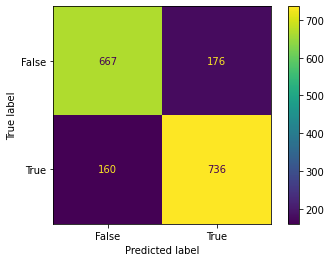

In [95]:
cm = confusion_matrix(y_valid, preds, labels = model_poc_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_poc_rf.classes_)
disp.plot()

### 2.5.2. NN

In [112]:
model_poc_ann = tf.keras.Sequential()
model_poc_ann.add(tf.keras.layers.Input(shape = (14,)))
model_poc_ann.add(tf.keras.layers.Dense(19, activation="relu"))
model_poc_ann.add(tf.keras.layers.Dropout(0.1))
model_poc_ann.add(tf.keras.layers.Dense(11, activation="relu"))
model_poc_ann.add(tf.keras.layers.Dropout(0.1))
model_poc_ann.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
optimizer = keras.optimizers.SGD(learning_rate = 0.05326161402980561, momentum = 0.00022019142646421608)
model_poc_ann.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

r = model_poc_ann.fit(X_train_scaled, y_train, epochs = 200, callbacks=[callback])
accuracy = r.history['accuracy'][-1]
    
preds = model_poc_ann.predict(X_valid_scaled)
metrics.accuracy_score(y_valid, np.around(preds))

Epoch 1/200
166/166 [==============================] - 1s 1ms/step - loss: 0.6209 - accuracy: 0.6664
Epoch 2/200
166/166 [==============================] - 0s 1ms/step - loss: 0.5142 - accuracy: 0.7604
Epoch 3/200
166/166 [==============================] - 0s 1ms/step - loss: 0.4828 - accuracy: 0.7684
Epoch 4/200
166/166 [==============================] - 0s 952us/step - loss: 0.4676 - accuracy: 0.7759
Epoch 5/200
166/166 [==============================] - 0s 964us/step - loss: 0.4644 - accuracy: 0.7765
Epoch 6/200
166/166 [==============================] - 0s 940us/step - loss: 0.4597 - accuracy: 0.7771
Epoch 7/200
166/166 [==============================] - 0s 927us/step - loss: 0.4550 - accuracy: 0.7822
Epoch 8/200
166/166 [==============================] - 0s 958us/step - loss: 0.4482 - accuracy: 0.7808
Epoch 9/200
166/166 [==============================] - 0s 988us/step - loss: 0.4473 - accuracy: 0.7854
Epoch 10/200
166/166 [==============================] - 0s 952us/step - loss: 0

0.7965204236006052

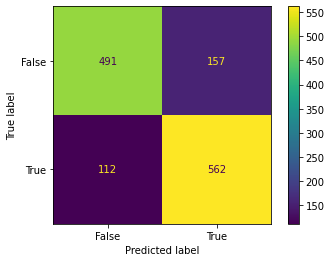

In [114]:
cm = confusion_matrix(y_valid, np.around(preds), labels = np.array([False,  True]))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.array([False,  True]))
disp.plot()

### 2.5.3. SVM

In [96]:
model_poc_svm = SVC(kernel='rbf',degree=3,gamma='auto',C=1.39587023987936)
model_poc_svm.fit(X_train_scaled, y_train)
preds = model_poc_svm.predict(X_valid_scaled)
metrics.accuracy_score(y_valid, preds)

0.8039102932719954

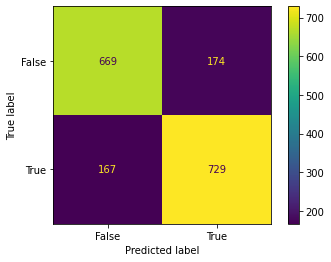

In [97]:
cm = confusion_matrix(y_valid, preds, labels = model_poc_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_poc_svm.classes_)
disp.plot()

# 3. Feature importance

## 3.1. RF

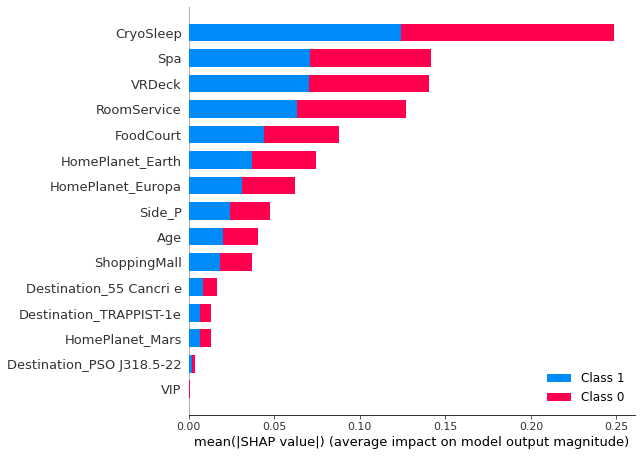

In [105]:
explain_rf = shap.TreeExplainer(model_poc_rf)
shap_values_rf = explain_rf.shap_values(X_train_scaled)
shap.summary_plot(shap_values_rf, X_valid_scaled, plot_type="bar")

## 3.2. NN

  0%|          | 0/1322 [00:00<?, ?it/s]

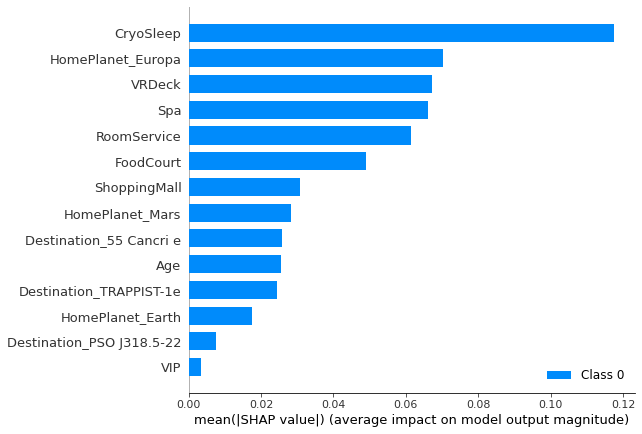

In [51]:
warnings.filterwarnings("ignore")
background = X_train_scaled.loc[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]
explain_ann = shap.KernelExplainer(model_poc_ann, background)
shap_values_ann = explain_ann.shap_values(X_valid_scaled)
shap.summary_plot(shap_values_ann, X_valid_scaled, plot_type = 'bar')

# 4. Feature engineering

In [38]:
X_dum

CryoSleep   Age  VIP  RoomService  FoodCourt  ShoppingMall     Spa  \
0             0  39.0    0          0.0        0.0           0.0     0.0   
1             0  24.0    0        109.0        9.0          25.0   549.0   
2             0  58.0    1         43.0     3576.0           0.0  6715.0   
3             0  33.0    0          0.0     1283.0         371.0  3329.0   
4             0  16.0    0        303.0       70.0         151.0   565.0   
...         ...   ...  ...          ...        ...           ...     ...   
6601          0  41.0    1          0.0     6819.0           0.0  1643.0   
6602          1  18.0    0          0.0        0.0           0.0     0.0   
6603          0  26.0    0          0.0        0.0        1872.0     1.0   
6604          0  32.0    0          0.0     1049.0           0.0   353.0   
6605          0  44.0    0        126.0     4688.0           0.0     0.0   

      VRDeck  HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0        0.0                 0                  1                0   
1       44.0                 1                  0                0   
2       49.0                 0                  1                0   
3      193.0                 0                  1                0   
4        2.0                 1                  0                0   
...      ...               ...                ...              ...   
6601    74.0                 0                  1                0   
6602     0.0                 1                  0                0   
6603     0.0                 1                  0                0   
6604  3235.0                 0                  1                0   
6605    12.0                 0                  1                0   

      Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                           0                          0   
1                           0                          0   
2                           0                          0   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
6601                        1                          0   
6602                        0                          1   
6603                        0                          0   
6604                        1                          0   
6605                        0                          0   

      Destination_TRAPPIST-1e  
0                           1  
1                           1  
2                           1  
3                           1  
4                           1  
...                       ...  
6601                        0  
6602                        0  
6603                        1  
6604                        0  
6605                        1  

[6606 rows x 14 columns]

In [85]:
def feature_eng(df):
    
    df_short = df.drop(['VIP', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'], axis = 1)
    
    df_out = outliers(df_short)
    is_outlier = list()
    spa_shop = list()

    
    for i in range(len(df_short)):

        if df_short.Spa[i] > df_short.ShoppingMall[i]:
            spa_shop.append(1)

        else:
            spa_shop.append(0)
            
        if df_out.outlier_probability_LOF[i] > 0.5:
            is_outlier.append(1)
            
        else:
            is_outlier.append(0)
            
    df_short['spa_shop'] = spa_shop
    df_short['shop_times_food'] = np.sqrt(df_short.ShoppingMall.astype(float)**2*df_short.FoodCourt.astype(float)**3)
    df_short['is_outlier'] = is_outlier
    
    return df_short

In [101]:
warnings.filterwarnings("ignore")
X_eng = feature_eng(X_dum)

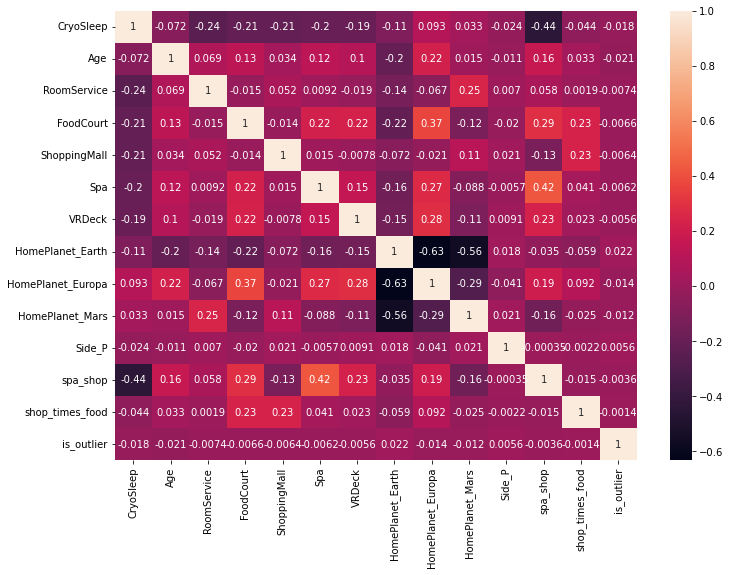

In [28]:
correlation_matrix(X_eng)

In [29]:
X_train_eng, X_valid_eng, y_train_eng, y_valid_eng = scaled_data_split(X_eng, target)
y_train_eng = y_train_eng.astype(bool)
y_valid_eng = y_valid_eng.astype(bool)

# 5. Models after feature engineering

## 5.1. RF, NN, SVM

In [113]:
nn_input_dim = X_train_eng.shape[1]

In [115]:
optimization_function = partial(model, x = X_train_eng, y = y_train_eng, classifier_name = 'RF')

study = optuna.create_study(direction = "maximize")
study.optimize(optimization_function, n_trials = 100)

[I 2022-07-16 18:15:43,744] A new study created in memory with name: no-name-7849f53e-d9ef-48a6-9e27-57c40f49325f
[I 2022-07-16 18:15:53,521] Trial 0 finished with value: 0.7815639077523028 and parameters: {'criterion': 'gini', 'n_estimators': 197, 'max_depth': 20, 'max_features': 0.025106559601243635}. Best is trial 0 with value: 0.7815639077523028.
[I 2022-07-16 18:17:17,837] Trial 1 finished with value: 0.7876036597034377 and parameters: {'criterion': 'entropy', 'n_estimators': 436, 'max_depth': 17, 'max_features': 0.5979305248600494}. Best is trial 1 with value: 0.7876036597034377.
[I 2022-07-16 18:18:07,509] Trial 2 finished with value: 0.788753911320979 and parameters: {'criterion': 'gini', 'n_estimators': 478, 'max_depth': 14, 'max_features': 0.32510434214665757}. Best is trial 2 with value: 0.788753911320979.
[I 2022-07-16 18:18:57,655] Trial 3 finished with value: 0.7470534629090402 and parameters: {'criterion': 'entropy', 'n_estimators': 270, 'max_depth': 3, 'max_features': 0

[I 2022-07-16 18:35:16,680] Trial 33 finished with value: 0.7952249041887984 and parameters: {'criterion': 'gini', 'n_estimators': 288, 'max_depth': 8, 'max_features': 0.5604974449165796}. Best is trial 17 with value: 0.7956564554251638.
[I 2022-07-16 18:36:05,440] Trial 34 finished with value: 0.7903354038552048 and parameters: {'criterion': 'entropy', 'n_estimators': 289, 'max_depth': 11, 'max_features': 0.5608642702485921}. Best is trial 17 with value: 0.7956564554251638.
[I 2022-07-16 18:36:52,875] Trial 35 finished with value: 0.786309833513491 and parameters: {'criterion': 'gini', 'n_estimators': 387, 'max_depth': 5, 'max_features': 0.4697790579541769}. Best is trial 17 with value: 0.7956564554251638.
[I 2022-07-16 18:37:23,621] Trial 36 finished with value: 0.7881776476733783 and parameters: {'criterion': 'gini', 'n_estimators': 290, 'max_depth': 14, 'max_features': 0.33601846155107007}. Best is trial 17 with value: 0.7956564554251638.
[I 2022-07-16 18:38:20,215] Trial 37 finish

[I 2022-07-16 18:53:27,298] Trial 66 finished with value: 0.7933551246709319 and parameters: {'criterion': 'gini', 'n_estimators': 222, 'max_depth': 8, 'max_features': 0.44509443781848596}. Best is trial 51 with value: 0.7962313743541471.
[I 2022-07-16 18:53:41,490] Trial 67 finished with value: 0.7729375378202112 and parameters: {'criterion': 'gini', 'n_estimators': 174, 'max_depth': 4, 'max_features': 0.31315976164299897}. Best is trial 51 with value: 0.7962313743541471.
[I 2022-07-16 18:53:53,715] Trial 68 finished with value: 0.7914871036312575 and parameters: {'criterion': 'entropy', 'n_estimators': 262, 'max_depth': 10, 'max_features': 0.08222285539444113}. Best is trial 51 with value: 0.7962313743541471.
[I 2022-07-16 18:54:11,836] Trial 69 finished with value: 0.7855900987333786 and parameters: {'criterion': 'gini', 'n_estimators': 144, 'max_depth': 15, 'max_features': 0.36741728097953086}. Best is trial 51 with value: 0.7962313743541471.
[I 2022-07-16 18:55:07,705] Trial 70 fi

[I 2022-07-16 19:09:44,290] Trial 99 finished with value: 0.7943621120357489 and parameters: {'criterion': 'gini', 'n_estimators': 115, 'max_depth': 8, 'max_features': 0.41323416635500965}. Best is trial 51 with value: 0.7962313743541471.


In [116]:
study.best_trial

FrozenTrial(number=51, values=[0.7962313743541471], datetime_start=datetime.datetime(2022, 7, 16, 18, 46, 2, 365665), datetime_complete=datetime.datetime(2022, 7, 16, 18, 46, 22, 131977), params={'criterion': 'gini', 'n_estimators': 165, 'max_depth': 9, 'max_features': 0.40768376872748924}, distributions={'criterion': CategoricalDistribution(choices=('gini', 'entropy')), 'n_estimators': IntUniformDistribution(high=500, low=100, step=1), 'max_depth': IntUniformDistribution(high=30, low=3, step=1), 'max_features': UniformDistribution(high=1.0, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=51, state=TrialState.COMPLETE, value=None)

In [118]:
model_poc_rf = ensemble.RandomForestClassifier(n_estimators = 165, max_depth = 9, 
                                               max_features = 0.40768376872748924, criterion = 'gini')

model_poc_rf.fit(X_train_eng, y_train)

preds = model_poc_rf.predict(X_valid_eng)
metrics.accuracy_score(y_valid_eng, preds)

0.80448533640023

# 6. Ensemble NN

In [43]:
X_train_scaled['test'] = y_train
X_train_scaled

CryoSleep       Age       VIP  RoomService  FoodCourt  ShoppingMall  \
0      1.360577  0.710314 -0.151982    -0.328390  -0.279781     -0.273700   
1     -0.734983  0.989217 -0.151982    -0.328390   0.270753     -0.273700   
2     -0.734983 -0.335575 -0.151982    -0.300489   0.139319     -0.273700   
3     -0.734983 -0.893382 -0.151982    -0.328390  -0.279781     -0.175059   
4     -0.734983 -0.544752 -0.151982     0.210544  -0.105569     -0.273700   
...         ...       ...       ...          ...        ...           ...   
6949  -0.734983  0.640588 -0.151982     0.972689  -0.279781      0.742301   
6950  -0.734983  0.710314 -0.151982    -0.328390  -0.117969     -0.273700   
6951  -0.734983 -0.335575 -0.151982    -0.328390  -0.259942     -0.260547   
6952   1.360577  1.268121 -0.151982    -0.328390  -0.279781     -0.273700   
6953  -0.734983  0.082781 -0.151982     0.163553   0.151099      0.615712   

           Spa    VRDeck  HomePlanet_Earth  HomePlanet_Europa  \
0    -0.276084 -0.258226         -1.108856          -0.574140   
1    -0.276084 -0.258226          0.901831          -0.574140   
2    -0.252719 -0.258226          0.901831          -0.574140   
3    -0.276084  1.440558          0.901831          -0.574140   
4    -0.276084 -0.131877          0.901831          -0.574140   
...        ...       ...               ...                ...   
6949 -0.276084 -0.258226         -1.108856          -0.574140   
6950  1.369299  1.296901         -1.108856           1.741736   
6951 -0.276084 -0.258226          0.901831          -0.574140   
6952 -0.276084 -0.258226         -1.108856          -0.574140   
6953 -0.276084 -0.258226          0.901831          -0.574140   

      HomePlanet_Mars  Destination_55 Cancri e  Destination_PSO J318.5-22  \
0            1.996233                -0.509689                  -0.317826   
1           -0.500944                -0.509689                  -0.317826   
2           -0.500944                -0.509689                  -0.317826   
3           -0.500944                -0.509689                  -0.317826   
4           -0.500944                -0.509689                  -0.317826   
...               ...                      ...                        ...   
6949         1.996233                -0.509689                  -0.317826   
6950        -0.500944                -0.509689                  -0.317826   
6951        -0.500944                -0.509689                  -0.317826   
6952         1.996233                -0.509689                  -0.317826   
6953        -0.500944                -0.509689                  -0.317826   

      Destination_TRAPPIST-1e    Side_P   test  
0                    0.651472  1.027706  False  
1                    0.651472  1.027706  False  
2                    0.651472 -0.973041  False  
3                    0.651472 -0.973041  False  
4                    0.651472  1.027706  False  
...                       ...       ...    ...  
6949                 0.651472 -0.973041  False  
6950                 0.651472 -0.973041  False  
6951                 0.651472  1.027706  False  
6952                 0.651472  1.027706   True  
6953                 0.651472  1.027706  False  

[6954 rows x 16 columns]

In [82]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
preds_list = [0] * len(y_valid)

for i in range(101):
    
    train1 = X_train_scaled.sample(5000, replace = True)
    y_train = train1['test']
    train = train1.drop('test', axis = 1)
    
    n_epochs = randrange(20,101)
    n_neurons_1 = randrange(20,51)
    n_neurons_2 = randrange(10,31)

    model_nn = tf.keras.Sequential()
    model_nn.add(tf.keras.layers.Input(shape = (15,)))
    model_nn.add(tf.keras.layers.Dense(n_neurons_1, activation="relu"))
    model_nn.add(tf.keras.layers.Dropout(0.1))
    model_nn.add(tf.keras.layers.Dense(n_neurons_2, activation="relu"))
    model_nn.add(tf.keras.layers.Dropout(0.1))
    model_nn.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

    model_nn.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

    r = model_nn.fit(train, y_train, epochs = 200, callbacks=[callback])

    preds = np.around(model_nn.predict(X_valid_scaled))
    preds_list = [sum(x) for x in zip(preds, preds_list)]

Epoch 1/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4637 - accuracy: 0.7810
Epoch 2/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4377 - accuracy: 0.8000
Epoch 3/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4317 - accuracy: 0.7992
Epoch 4/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4233 - accuracy: 0.8054
Epoch 5/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4193 - accuracy: 0.8062
Epoch 6/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4186 - accuracy: 0.8082
Epoch 7/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4182 - accuracy: 0.8114
Epoch 8/200
157/157 [==============================] - 0s 949us/step - loss: 0.4170 - accuracy: 0.8132
Epoch 9/200
157/157 [==============================] - 0s 981us/step - loss: 0.4120 - accuracy: 0.8068
Epoch 10/200
157/157 [==============================] - 0s 943us/step - loss: 0.4096 - 

157/157 [==============================] - 0s 923us/step - loss: 0.4247 - accuracy: 0.8016
Epoch 16/200
157/157 [==============================] - 0s 917us/step - loss: 0.4170 - accuracy: 0.8042
Epoch 17/200
157/157 [==============================] - 0s 930us/step - loss: 0.4197 - accuracy: 0.8036
Epoch 18/200
157/157 [==============================] - 0s 923us/step - loss: 0.4169 - accuracy: 0.8016
Epoch 19/200
157/157 [==============================] - 0s 917us/step - loss: 0.4154 - accuracy: 0.8074
Epoch 20/200
157/157 [==============================] - 0s 936us/step - loss: 0.4164 - accuracy: 0.8066
Epoch 21/200
157/157 [==============================] - 0s 923us/step - loss: 0.4147 - accuracy: 0.8094
Epoch 22/200
157/157 [==============================] - 0s 923us/step - loss: 0.4162 - accuracy: 0.8018
Epoch 23/200
157/157 [==============================] - 0s 917us/step - loss: 0.4120 - accuracy: 0.8050
Epoch 24/200
157/157 [==============================] - 0s 923us/step - loss:

157/157 [==============================] - 0s 917us/step - loss: 0.4190 - accuracy: 0.7990
Epoch 19/200
157/157 [==============================] - 0s 904us/step - loss: 0.4161 - accuracy: 0.8006
Epoch 20/200
157/157 [==============================] - 0s 910us/step - loss: 0.4211 - accuracy: 0.7960
Epoch 21/200
157/157 [==============================] - 0s 910us/step - loss: 0.4207 - accuracy: 0.7960
Epoch 22/200
157/157 [==============================] - 0s 910us/step - loss: 0.4194 - accuracy: 0.7922
Epoch 23/200
157/157 [==============================] - 0s 917us/step - loss: 0.4149 - accuracy: 0.7962
Epoch 24/200
157/157 [==============================] - 0s 904us/step - loss: 0.4138 - accuracy: 0.7966
Epoch 25/200
157/157 [==============================] - 0s 910us/step - loss: 0.4156 - accuracy: 0.7954
Epoch 26/200
157/157 [==============================] - 0s 910us/step - loss: 0.4157 - accuracy: 0.8028
Epoch 27/200
157/157 [==============================] - 0s 917us/step - loss:

157/157 [==============================] - 0s 949us/step - loss: 0.4085 - accuracy: 0.8056
Epoch 31/200
157/157 [==============================] - 0s 955us/step - loss: 0.4055 - accuracy: 0.8010
Epoch 32/200
157/157 [==============================] - 0s 943us/step - loss: 0.4102 - accuracy: 0.8024
Epoch 33/200
157/157 [==============================] - 0s 962us/step - loss: 0.4075 - accuracy: 0.8022
Epoch 34/200
157/157 [==============================] - 0s 943us/step - loss: 0.4065 - accuracy: 0.8040
Epoch 35/200
157/157 [==============================] - 0s 943us/step - loss: 0.4034 - accuracy: 0.8076
Epoch 36/200
157/157 [==============================] - 0s 949us/step - loss: 0.4065 - accuracy: 0.8030
Epoch 37/200
157/157 [==============================] - 0s 943us/step - loss: 0.4075 - accuracy: 0.8072
Epoch 38/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4007 - accuracy: 0.8052
Epoch 39/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4

157/157 [==============================] - 0s 994us/step - loss: 0.3801 - accuracy: 0.8092
Epoch 51/200
157/157 [==============================] - 0s 949us/step - loss: 0.3835 - accuracy: 0.8158
Epoch 52/200
157/157 [==============================] - 0s 962us/step - loss: 0.3841 - accuracy: 0.8126
Epoch 53/200
157/157 [==============================] - 0s 968us/step - loss: 0.3852 - accuracy: 0.8172
Epoch 54/200
157/157 [==============================] - 0s 949us/step - loss: 0.3835 - accuracy: 0.8144
Epoch 55/200
157/157 [==============================] - 0s 949us/step - loss: 0.3824 - accuracy: 0.8188
Epoch 1/200
157/157 [==============================] - 0s 936us/step - loss: 0.4917 - accuracy: 0.7666
Epoch 2/200
157/157 [==============================] - 0s 917us/step - loss: 0.4534 - accuracy: 0.7858
Epoch 3/200
157/157 [==============================] - 0s 917us/step - loss: 0.4458 - accuracy: 0.7898
Epoch 4/200
157/157 [==============================] - 0s 923us/step - loss: 0.4

157/157 [==============================] - 0s 1ms/step - loss: 0.4273 - accuracy: 0.7906
Epoch 11/200
157/157 [==============================] - 0s 910us/step - loss: 0.4251 - accuracy: 0.7874
Epoch 12/200
157/157 [==============================] - 0s 910us/step - loss: 0.4294 - accuracy: 0.7832
Epoch 13/200
157/157 [==============================] - 0s 904us/step - loss: 0.4222 - accuracy: 0.7906
Epoch 14/200
157/157 [==============================] - 0s 910us/step - loss: 0.4277 - accuracy: 0.7932
Epoch 15/200
157/157 [==============================] - 0s 930us/step - loss: 0.4255 - accuracy: 0.7922
Epoch 16/200
157/157 [==============================] - 0s 917us/step - loss: 0.4214 - accuracy: 0.7964
Epoch 17/200
157/157 [==============================] - 0s 904us/step - loss: 0.4193 - accuracy: 0.7940
Epoch 18/200
157/157 [==============================] - 0s 904us/step - loss: 0.4221 - accuracy: 0.7952
Epoch 19/200
157/157 [==============================] - 0s 898us/step - loss: 0

157/157 [==============================] - 0s 917us/step - loss: 0.4095 - accuracy: 0.8014
Epoch 28/200
157/157 [==============================] - 0s 987us/step - loss: 0.4072 - accuracy: 0.8036
Epoch 29/200
157/157 [==============================] - 0s 962us/step - loss: 0.4092 - accuracy: 0.8004
Epoch 30/200
157/157 [==============================] - 0s 981us/step - loss: 0.4151 - accuracy: 0.8028
Epoch 31/200
157/157 [==============================] - 0s 968us/step - loss: 0.4093 - accuracy: 0.8054
Epoch 32/200
157/157 [==============================] - 0s 955us/step - loss: 0.4091 - accuracy: 0.8050
Epoch 33/200
157/157 [==============================] - 0s 949us/step - loss: 0.4090 - accuracy: 0.8036
Epoch 1/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4984 - accuracy: 0.7536
Epoch 2/200
157/157 [==============================] - 0s 968us/step - loss: 0.4610 - accuracy: 0.7740
Epoch 3/200
157/157 [==============================] - 0s 981us/step - loss: 0.44

157/157 [==============================] - 0s 943us/step - loss: 0.4211 - accuracy: 0.8030
Epoch 9/200
157/157 [==============================] - 0s 936us/step - loss: 0.4216 - accuracy: 0.7996
Epoch 10/200
157/157 [==============================] - 0s 943us/step - loss: 0.4171 - accuracy: 0.8082
Epoch 11/200
157/157 [==============================] - 0s 930us/step - loss: 0.4175 - accuracy: 0.8080
Epoch 12/200
157/157 [==============================] - 0s 930us/step - loss: 0.4147 - accuracy: 0.8044
Epoch 13/200
157/157 [==============================] - 0s 923us/step - loss: 0.4161 - accuracy: 0.8014
Epoch 14/200
157/157 [==============================] - 0s 936us/step - loss: 0.4105 - accuracy: 0.8076
Epoch 15/200
157/157 [==============================] - 0s 930us/step - loss: 0.4127 - accuracy: 0.8090
Epoch 16/200
157/157 [==============================] - 0s 930us/step - loss: 0.4085 - accuracy: 0.8086
Epoch 17/200
157/157 [==============================] - 0s 923us/step - loss: 

157/157 [==============================] - 0s 936us/step - loss: 0.3879 - accuracy: 0.8040
Epoch 27/200
157/157 [==============================] - 0s 923us/step - loss: 0.3861 - accuracy: 0.8046
Epoch 28/200
157/157 [==============================] - 0s 930us/step - loss: 0.3865 - accuracy: 0.8078
Epoch 29/200
157/157 [==============================] - 0s 930us/step - loss: 0.3866 - accuracy: 0.8072
Epoch 30/200
157/157 [==============================] - 0s 936us/step - loss: 0.3851 - accuracy: 0.8058
Epoch 31/200
157/157 [==============================] - 0s 923us/step - loss: 0.3919 - accuracy: 0.8078
Epoch 32/200
157/157 [==============================] - 0s 936us/step - loss: 0.3843 - accuracy: 0.8096
Epoch 33/200
157/157 [==============================] - 0s 930us/step - loss: 0.3847 - accuracy: 0.8074
Epoch 34/200
157/157 [==============================] - 0s 930us/step - loss: 0.3874 - accuracy: 0.8074
Epoch 35/200
157/157 [==============================] - 0s 936us/step - loss:

157/157 [==============================] - 0s 936us/step - loss: 0.4066 - accuracy: 0.8020
Epoch 34/200
157/157 [==============================] - 0s 917us/step - loss: 0.4071 - accuracy: 0.7984
Epoch 35/200
157/157 [==============================] - 0s 923us/step - loss: 0.4057 - accuracy: 0.8008
Epoch 36/200
157/157 [==============================] - 0s 910us/step - loss: 0.4051 - accuracy: 0.8030
Epoch 37/200
157/157 [==============================] - 0s 930us/step - loss: 0.4014 - accuracy: 0.7980
Epoch 38/200
157/157 [==============================] - 0s 917us/step - loss: 0.3971 - accuracy: 0.8068
Epoch 39/200
157/157 [==============================] - 0s 917us/step - loss: 0.4032 - accuracy: 0.8068
Epoch 40/200
157/157 [==============================] - 0s 917us/step - loss: 0.3961 - accuracy: 0.8018
Epoch 41/200
157/157 [==============================] - 0s 936us/step - loss: 0.4033 - accuracy: 0.8030
Epoch 42/200
157/157 [==============================] - 0s 917us/step - loss:

157/157 [==============================] - 0s 1ms/step - loss: 0.4245 - accuracy: 0.7916
Epoch 8/200
157/157 [==============================] - 0s 994us/step - loss: 0.4181 - accuracy: 0.7962
Epoch 9/200
157/157 [==============================] - 0s 943us/step - loss: 0.4241 - accuracy: 0.7894
Epoch 10/200
157/157 [==============================] - 0s 943us/step - loss: 0.4189 - accuracy: 0.7912
Epoch 11/200
157/157 [==============================] - 0s 936us/step - loss: 0.4198 - accuracy: 0.7958
Epoch 12/200
157/157 [==============================] - 0s 942us/step - loss: 0.4174 - accuracy: 0.7974
Epoch 13/200
157/157 [==============================] - 0s 936us/step - loss: 0.4173 - accuracy: 0.7956
Epoch 14/200
157/157 [==============================] - 0s 942us/step - loss: 0.4160 - accuracy: 0.7928
Epoch 15/200
157/157 [==============================] - 0s 936us/step - loss: 0.4132 - accuracy: 0.7928
Epoch 16/200
157/157 [==============================] - 0s 943us/step - loss: 0.4

157/157 [==============================] - 0s 949us/step - loss: 0.3899 - accuracy: 0.8126
Epoch 39/200
157/157 [==============================] - 0s 949us/step - loss: 0.3944 - accuracy: 0.8092
Epoch 40/200
157/157 [==============================] - 0s 943us/step - loss: 0.3895 - accuracy: 0.8134
Epoch 41/200
157/157 [==============================] - 0s 936us/step - loss: 0.3905 - accuracy: 0.8126
Epoch 42/200
157/157 [==============================] - 0s 943us/step - loss: 0.3897 - accuracy: 0.8140
Epoch 1/200
157/157 [==============================] - 0s 949us/step - loss: 0.4852 - accuracy: 0.7704
Epoch 2/200
157/157 [==============================] - 0s 923us/step - loss: 0.4417 - accuracy: 0.7952
Epoch 3/200
157/157 [==============================] - 0s 949us/step - loss: 0.4318 - accuracy: 0.8016
Epoch 4/200
157/157 [==============================] - 0s 930us/step - loss: 0.4311 - accuracy: 0.7976
Epoch 5/200
157/157 [==============================] - 0s 930us/step - loss: 0.42

157/157 [==============================] - 0s 949us/step - loss: 0.3979 - accuracy: 0.8102
Epoch 45/200
157/157 [==============================] - 0s 949us/step - loss: 0.3976 - accuracy: 0.8052
Epoch 1/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4943 - accuracy: 0.7496
Epoch 2/200
157/157 [==============================] - 0s 917us/step - loss: 0.4490 - accuracy: 0.7838
Epoch 3/200
157/157 [==============================] - 0s 917us/step - loss: 0.4386 - accuracy: 0.7916
Epoch 4/200
157/157 [==============================] - 0s 917us/step - loss: 0.4278 - accuracy: 0.7958
Epoch 5/200
157/157 [==============================] - 0s 923us/step - loss: 0.4255 - accuracy: 0.7992
Epoch 6/200
157/157 [==============================] - 0s 923us/step - loss: 0.4281 - accuracy: 0.7986
Epoch 7/200
157/157 [==============================] - 0s 917us/step - loss: 0.4220 - accuracy: 0.8010
Epoch 8/200
157/157 [==============================] - 0s 923us/step - loss: 0.4196 - 

157/157 [==============================] - 0s 955us/step - loss: 0.4134 - accuracy: 0.8034
Epoch 18/200
157/157 [==============================] - 0s 949us/step - loss: 0.4130 - accuracy: 0.8042
Epoch 19/200
157/157 [==============================] - 0s 955us/step - loss: 0.4120 - accuracy: 0.8040
Epoch 20/200
157/157 [==============================] - 0s 955us/step - loss: 0.4113 - accuracy: 0.8014
Epoch 21/200
157/157 [==============================] - 0s 955us/step - loss: 0.4127 - accuracy: 0.8018
Epoch 22/200
157/157 [==============================] - 0s 955us/step - loss: 0.4080 - accuracy: 0.8050
Epoch 23/200
157/157 [==============================] - 0s 962us/step - loss: 0.4114 - accuracy: 0.7998
Epoch 24/200
157/157 [==============================] - 0s 955us/step - loss: 0.4068 - accuracy: 0.8008
Epoch 25/200
157/157 [==============================] - 0s 949us/step - loss: 0.4044 - accuracy: 0.8020
Epoch 26/200
157/157 [==============================] - 0s 968us/step - loss:

157/157 [==============================] - 0s 975us/step - loss: 0.4227 - accuracy: 0.7912
Epoch 23/200
157/157 [==============================] - 0s 955us/step - loss: 0.4193 - accuracy: 0.7952
Epoch 24/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4226 - accuracy: 0.7952
Epoch 25/200
157/157 [==============================] - 0s 981us/step - loss: 0.4235 - accuracy: 0.7928
Epoch 26/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4177 - accuracy: 0.7918
Epoch 27/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4185 - accuracy: 0.7938
Epoch 28/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4224 - accuracy: 0.7936
Epoch 29/200
157/157 [==============================] - 0s 975us/step - loss: 0.4202 - accuracy: 0.7906
Epoch 30/200
157/157 [==============================] - 0s 923us/step - loss: 0.4125 - accuracy: 0.7988
Epoch 31/200
157/157 [==============================] - 0s 930us/step - loss: 0.4174 

157/157 [==============================] - 0s 968us/step - loss: 0.3977 - accuracy: 0.8066
Epoch 23/200
157/157 [==============================] - 0s 949us/step - loss: 0.4006 - accuracy: 0.8030
Epoch 24/200
157/157 [==============================] - 0s 936us/step - loss: 0.4036 - accuracy: 0.7996
Epoch 25/200
157/157 [==============================] - 0s 936us/step - loss: 0.4012 - accuracy: 0.8012
Epoch 26/200
157/157 [==============================] - 0s 943us/step - loss: 0.3968 - accuracy: 0.8078
Epoch 27/200
157/157 [==============================] - 0s 949us/step - loss: 0.3967 - accuracy: 0.8044
Epoch 28/200
157/157 [==============================] - 0s 943us/step - loss: 0.3949 - accuracy: 0.8074
Epoch 29/200
157/157 [==============================] - 0s 949us/step - loss: 0.3946 - accuracy: 0.8048
Epoch 30/200
157/157 [==============================] - 0s 943us/step - loss: 0.3956 - accuracy: 0.8054
Epoch 31/200
157/157 [==============================] - 0s 936us/step - loss:

157/157 [==============================] - 0s 968us/step - loss: 0.4054 - accuracy: 0.8070
Epoch 30/200
157/157 [==============================] - 0s 949us/step - loss: 0.4016 - accuracy: 0.8076
Epoch 31/200
157/157 [==============================] - 0s 949us/step - loss: 0.4068 - accuracy: 0.8046
Epoch 32/200
157/157 [==============================] - 0s 949us/step - loss: 0.4007 - accuracy: 0.8068
Epoch 33/200
157/157 [==============================] - 0s 943us/step - loss: 0.4031 - accuracy: 0.8008
Epoch 34/200
157/157 [==============================] - 0s 955us/step - loss: 0.4068 - accuracy: 0.8004
Epoch 35/200
157/157 [==============================] - 0s 949us/step - loss: 0.4024 - accuracy: 0.8134
Epoch 36/200
157/157 [==============================] - 0s 936us/step - loss: 0.4019 - accuracy: 0.8054
Epoch 37/200
157/157 [==============================] - 0s 955us/step - loss: 0.4031 - accuracy: 0.8054
Epoch 1/200
157/157 [==============================] - 0s 955us/step - loss: 

157/157 [==============================] - 0s 962us/step - loss: 0.4382 - accuracy: 0.7908
Epoch 6/200
157/157 [==============================] - 0s 955us/step - loss: 0.4310 - accuracy: 0.7926
Epoch 7/200
157/157 [==============================] - 0s 949us/step - loss: 0.4288 - accuracy: 0.7946
Epoch 8/200
157/157 [==============================] - 0s 968us/step - loss: 0.4264 - accuracy: 0.7916
Epoch 9/200
157/157 [==============================] - 0s 955us/step - loss: 0.4287 - accuracy: 0.7968
Epoch 10/200
157/157 [==============================] - 0s 962us/step - loss: 0.4251 - accuracy: 0.7966
Epoch 11/200
157/157 [==============================] - 0s 955us/step - loss: 0.4156 - accuracy: 0.7970
Epoch 12/200
157/157 [==============================] - 0s 968us/step - loss: 0.4231 - accuracy: 0.7990
Epoch 13/200
157/157 [==============================] - 0s 949us/step - loss: 0.4208 - accuracy: 0.8000
Epoch 14/200
157/157 [==============================] - 0s 975us/step - loss: 0.4

157/157 [==============================] - 0s 949us/step - loss: 0.4250 - accuracy: 0.7942
Epoch 8/200
157/157 [==============================] - 0s 943us/step - loss: 0.4245 - accuracy: 0.7950
Epoch 9/200
157/157 [==============================] - 0s 943us/step - loss: 0.4153 - accuracy: 0.7938
Epoch 10/200
157/157 [==============================] - 0s 949us/step - loss: 0.4208 - accuracy: 0.7950
Epoch 11/200
157/157 [==============================] - 0s 943us/step - loss: 0.4161 - accuracy: 0.7972
Epoch 12/200
157/157 [==============================] - 0s 955us/step - loss: 0.4097 - accuracy: 0.8004
Epoch 13/200
157/157 [==============================] - 0s 955us/step - loss: 0.4167 - accuracy: 0.7988
Epoch 14/200
157/157 [==============================] - 0s 949us/step - loss: 0.4154 - accuracy: 0.7970
Epoch 15/200
157/157 [==============================] - 0s 955us/step - loss: 0.4132 - accuracy: 0.8026
Epoch 16/200
157/157 [==============================] - 0s 943us/step - loss: 0

157/157 [==============================] - 0s 936us/step - loss: 0.4055 - accuracy: 0.8028
Epoch 25/200
157/157 [==============================] - 0s 930us/step - loss: 0.4079 - accuracy: 0.7988
Epoch 26/200
157/157 [==============================] - 0s 930us/step - loss: 0.4061 - accuracy: 0.8024
Epoch 27/200
157/157 [==============================] - 0s 930us/step - loss: 0.4033 - accuracy: 0.8044
Epoch 1/200
157/157 [==============================] - 0s 994us/step - loss: 0.4894 - accuracy: 0.7692
Epoch 2/200
157/157 [==============================] - 0s 955us/step - loss: 0.4452 - accuracy: 0.7882
Epoch 3/200
157/157 [==============================] - 0s 943us/step - loss: 0.4381 - accuracy: 0.7922
Epoch 4/200
157/157 [==============================] - 0s 936us/step - loss: 0.4310 - accuracy: 0.7968
Epoch 5/200
157/157 [==============================] - 0s 949us/step - loss: 0.4263 - accuracy: 0.8040
Epoch 6/200
157/157 [==============================] - 0s 955us/step - loss: 0.424

157/157 [==============================] - 0s 943us/step - loss: 0.4127 - accuracy: 0.8052
Epoch 18/200
157/157 [==============================] - 0s 943us/step - loss: 0.4095 - accuracy: 0.8062
Epoch 1/200
157/157 [==============================] - 0s 943us/step - loss: 0.5040 - accuracy: 0.7582
Epoch 2/200
157/157 [==============================] - 0s 943us/step - loss: 0.4579 - accuracy: 0.7752
Epoch 3/200
157/157 [==============================] - 0s 936us/step - loss: 0.4401 - accuracy: 0.7888
Epoch 4/200
157/157 [==============================] - 0s 930us/step - loss: 0.4380 - accuracy: 0.7924
Epoch 5/200
157/157 [==============================] - 0s 923us/step - loss: 0.4347 - accuracy: 0.7858
Epoch 6/200
157/157 [==============================] - 0s 936us/step - loss: 0.4316 - accuracy: 0.7882
Epoch 7/200
157/157 [==============================] - 0s 942us/step - loss: 0.4281 - accuracy: 0.7916
Epoch 8/200
157/157 [==============================] - 0s 936us/step - loss: 0.4285 

157/157 [==============================] - 0s 949us/step - loss: 0.3996 - accuracy: 0.8174
Epoch 27/200
157/157 [==============================] - 0s 936us/step - loss: 0.4005 - accuracy: 0.8096
Epoch 28/200
157/157 [==============================] - 0s 936us/step - loss: 0.3998 - accuracy: 0.8166
Epoch 29/200
157/157 [==============================] - 0s 936us/step - loss: 0.3945 - accuracy: 0.8170
Epoch 30/200
157/157 [==============================] - 0s 943us/step - loss: 0.3992 - accuracy: 0.8136
Epoch 31/200
157/157 [==============================] - 0s 942us/step - loss: 0.3939 - accuracy: 0.8158
Epoch 32/200
157/157 [==============================] - 0s 936us/step - loss: 0.3965 - accuracy: 0.8160
Epoch 33/200
157/157 [==============================] - 0s 936us/step - loss: 0.3945 - accuracy: 0.8178
Epoch 34/200
157/157 [==============================] - 0s 936us/step - loss: 0.3944 - accuracy: 0.8166
Epoch 35/200
157/157 [==============================] - 0s 930us/step - loss:

157/157 [==============================] - 0s 910us/step - loss: 0.4047 - accuracy: 0.8078
Epoch 21/200
157/157 [==============================] - 0s 910us/step - loss: 0.4024 - accuracy: 0.8090
Epoch 22/200
157/157 [==============================] - 0s 936us/step - loss: 0.4021 - accuracy: 0.8104
Epoch 23/200
157/157 [==============================] - 0s 910us/step - loss: 0.3998 - accuracy: 0.8104
Epoch 24/200
157/157 [==============================] - 0s 923us/step - loss: 0.4052 - accuracy: 0.8090
Epoch 25/200
157/157 [==============================] - 0s 917us/step - loss: 0.3970 - accuracy: 0.8096
Epoch 26/200
157/157 [==============================] - 0s 923us/step - loss: 0.4036 - accuracy: 0.8106
Epoch 27/200
157/157 [==============================] - 0s 923us/step - loss: 0.3998 - accuracy: 0.8096
Epoch 28/200
157/157 [==============================] - 0s 904us/step - loss: 0.3997 - accuracy: 0.8140
Epoch 29/200
157/157 [==============================] - 0s 923us/step - loss:

157/157 [==============================] - 0s 904us/step - loss: 0.4276 - accuracy: 0.7968
Epoch 12/200
157/157 [==============================] - 0s 904us/step - loss: 0.4251 - accuracy: 0.7996
Epoch 13/200
157/157 [==============================] - 0s 898us/step - loss: 0.4247 - accuracy: 0.8016
Epoch 14/200
157/157 [==============================] - 0s 923us/step - loss: 0.4226 - accuracy: 0.8008
Epoch 15/200
157/157 [==============================] - 0s 910us/step - loss: 0.4231 - accuracy: 0.8018
Epoch 16/200
157/157 [==============================] - 0s 917us/step - loss: 0.4224 - accuracy: 0.8032
Epoch 17/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4214 - accuracy: 0.8004
Epoch 18/200
157/157 [==============================] - 0s 1ms/step - loss: 0.4220 - accuracy: 0.8018
Epoch 19/200
157/157 [==============================] - 0s 968us/step - loss: 0.4198 - accuracy: 0.8034
Epoch 20/200
157/157 [==============================] - 0s 917us/step - loss: 0.4

157/157 [==============================] - 0s 943us/step - loss: 0.4083 - accuracy: 0.8010
Epoch 25/200
157/157 [==============================] - 0s 936us/step - loss: 0.4088 - accuracy: 0.8058
Epoch 26/200
157/157 [==============================] - 0s 930us/step - loss: 0.4103 - accuracy: 0.7990
Epoch 27/200
157/157 [==============================] - 0s 936us/step - loss: 0.4072 - accuracy: 0.8030
Epoch 28/200
157/157 [==============================] - 0s 949us/step - loss: 0.4034 - accuracy: 0.8046
Epoch 29/200
157/157 [==============================] - 0s 975us/step - loss: 0.4059 - accuracy: 0.8000
Epoch 30/200
157/157 [==============================] - 0s 936us/step - loss: 0.4107 - accuracy: 0.8046
Epoch 31/200
157/157 [==============================] - 0s 942us/step - loss: 0.4098 - accuracy: 0.8024
Epoch 32/200
157/157 [==============================] - 0s 962us/step - loss: 0.4074 - accuracy: 0.8028
Epoch 33/200
157/157 [==============================] - 0s 1ms/step - loss: 0

In [83]:
preds_list = [x / 101 for x in preds_list]
metrics.accuracy_score(y_valid, np.around(preds_list))

0.8010350776308223

# 7. Ensemble SVM

In [48]:
X_train_scaled['test'] = y_train
X_train_scaled

CryoSleep       Age       VIP  RoomService  FoodCourt  ShoppingMall  \
0      1.360577  0.710314 -0.151982    -0.328390  -0.279781     -0.273700   
1     -0.734983  0.989217 -0.151982    -0.328390   0.270753     -0.273700   
2     -0.734983 -0.335575 -0.151982    -0.300489   0.139319     -0.273700   
3     -0.734983 -0.893382 -0.151982    -0.328390  -0.279781     -0.175059   
4     -0.734983 -0.544752 -0.151982     0.210544  -0.105569     -0.273700   
...         ...       ...       ...          ...        ...           ...   
6949  -0.734983  0.640588 -0.151982     0.972689  -0.279781      0.742301   
6950  -0.734983  0.710314 -0.151982    -0.328390  -0.117969     -0.273700   
6951  -0.734983 -0.335575 -0.151982    -0.328390  -0.259942     -0.260547   
6952   1.360577  1.268121 -0.151982    -0.328390  -0.279781     -0.273700   
6953  -0.734983  0.082781 -0.151982     0.163553   0.151099      0.615712   

           Spa    VRDeck  HomePlanet_Earth  HomePlanet_Europa  \
0    -0.276084 -0.258226         -1.108856          -0.574140   
1    -0.276084 -0.258226          0.901831          -0.574140   
2    -0.252719 -0.258226          0.901831          -0.574140   
3    -0.276084  1.440558          0.901831          -0.574140   
4    -0.276084 -0.131877          0.901831          -0.574140   
...        ...       ...               ...                ...   
6949 -0.276084 -0.258226         -1.108856          -0.574140   
6950  1.369299  1.296901         -1.108856           1.741736   
6951 -0.276084 -0.258226          0.901831          -0.574140   
6952 -0.276084 -0.258226         -1.108856          -0.574140   
6953 -0.276084 -0.258226          0.901831          -0.574140   

      HomePlanet_Mars  Destination_55 Cancri e  Destination_PSO J318.5-22  \
0            1.996233                -0.509689                  -0.317826   
1           -0.500944                -0.509689                  -0.317826   
2           -0.500944                -0.509689                  -0.317826   
3           -0.500944                -0.509689                  -0.317826   
4           -0.500944                -0.509689                  -0.317826   
...               ...                      ...                        ...   
6949         1.996233                -0.509689                  -0.317826   
6950        -0.500944                -0.509689                  -0.317826   
6951        -0.500944                -0.509689                  -0.317826   
6952         1.996233                -0.509689                  -0.317826   
6953        -0.500944                -0.509689                  -0.317826   

      Destination_TRAPPIST-1e    Side_P   test  
0                    0.651472  1.027706  False  
1                    0.651472  1.027706  False  
2                    0.651472 -0.973041  False  
3                    0.651472 -0.973041  False  
4                    0.651472  1.027706  False  
...                       ...       ...    ...  
6949                 0.651472 -0.973041  False  
6950                 0.651472 -0.973041  False  
6951                 0.651472  1.027706  False  
6952                 0.651472  1.027706   True  
6953                 0.651472  1.027706  False  

[6954 rows x 16 columns]

In [81]:
nloops = 21

In [83]:
def svm_ensemble(df_train, df_valid, loops = nloops, n_samples = 5000, n_trials = 100):
    
    preds_list = [0] * len(df_valid)
    
    for i in range(loops):
        
        print('Loop: ', i)
    
        train1 = df_train.sample(5000, replace = True).reset_index(drop = True)
        y_train = train1['test']
        train = train1.drop('test', axis = 1)
        
        optimization_function = partial(model, x = train, y = y_train, classifier_name = 'SVM')

        study_svm = optuna.create_study(direction = "maximize")
        study_svm.optimize(optimization_function, n_trials = n_trials)
        
        model_svm = SVC(**study_svm.best_params)
        model_svm.fit(train, y_train)
        
        preds = model_svm.predict(df_valid)
        preds_list = [sum(x) for x in zip(preds, preds_list)]
        
    return preds_list

In [84]:
svm_ensemble_preds = svm_ensemble(X_train_scaled, X_valid_scaled)

[I 2022-08-15 18:12:00,810] A new study created in memory with name: no-name-be220f5f-88ca-4820-a3d4-e7703e6b5f4b


Loop:  0


[I 2022-08-15 18:12:03,701] Trial 0 finished with value: 0.7716000000000001 and parameters: {'kernel': 'linear', 'C': 2.522358083115017, 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.7716000000000001.
[I 2022-08-15 18:12:06,243] Trial 1 finished with value: 0.7888000000000002 and parameters: {'kernel': 'rbf', 'C': 1.278117629675901, 'gamma': 'scale', 'degree': 1}. Best is trial 1 with value: 0.7888000000000002.
[I 2022-08-15 18:12:08,796] Trial 2 finished with value: 0.782 and parameters: {'kernel': 'rbf', 'C': 0.7361424064090263, 'gamma': 'scale', 'degree': 1}. Best is trial 1 with value: 0.7888000000000002.
[I 2022-08-15 18:12:10,668] Trial 3 finished with value: 0.6874 and parameters: {'kernel': 'sigmoid', 'C': 0.9393191266216141, 'gamma': 'scale', 'degree': 1}. Best is trial 1 with value: 0.7888000000000002.
[I 2022-08-15 18:12:12,391] Trial 4 finished with value: 0.6890000000000001 and parameters: {'kernel': 'sigmoid', 'C': 2.0497435940184947, 'gamma': 'auto', 'degr

[I 2022-08-15 18:13:36,410] Trial 39 finished with value: 0.79 and parameters: {'kernel': 'rbf', 'C': 2.5873310957569426, 'gamma': 'auto', 'degree': 3}. Best is trial 27 with value: 0.7904.
[I 2022-08-15 18:13:38,144] Trial 40 finished with value: 0.6818000000000002 and parameters: {'kernel': 'sigmoid', 'C': 2.035480306531374, 'gamma': 'auto', 'degree': 3}. Best is trial 27 with value: 0.7904.
[I 2022-08-15 18:13:40,715] Trial 41 finished with value: 0.7904 and parameters: {'kernel': 'rbf', 'C': 2.970162322512261, 'gamma': 'auto', 'degree': 3}. Best is trial 27 with value: 0.7904.
[I 2022-08-15 18:13:43,300] Trial 42 finished with value: 0.79 and parameters: {'kernel': 'rbf', 'C': 2.578191048388694, 'gamma': 'auto', 'degree': 3}. Best is trial 27 with value: 0.7904.
[I 2022-08-15 18:13:45,862] Trial 43 finished with value: 0.7904000000000001 and parameters: {'kernel': 'rbf', 'C': 2.7373142788416365, 'gamma': 'auto', 'degree': 3}. Best is trial 43 with value: 0.7904000000000001.
[I 2022

[I 2022-08-15 18:15:08,465] Trial 77 finished with value: 0.7774 and parameters: {'kernel': 'poly', 'C': 0.5171567738809733, 'gamma': 'auto', 'degree': 3}. Best is trial 61 with value: 0.7906000000000001.
[I 2022-08-15 18:15:11,022] Trial 78 finished with value: 0.7898000000000001 and parameters: {'kernel': 'rbf', 'C': 1.714856565708824, 'gamma': 'auto', 'degree': 3}. Best is trial 61 with value: 0.7906000000000001.
[I 2022-08-15 18:15:13,583] Trial 79 finished with value: 0.7902 and parameters: {'kernel': 'rbf', 'C': 2.7244706203240137, 'gamma': 'auto', 'degree': 3}. Best is trial 61 with value: 0.7906000000000001.
[I 2022-08-15 18:15:16,134] Trial 80 finished with value: 0.7876000000000001 and parameters: {'kernel': 'rbf', 'C': 2.1620188828305498, 'gamma': 'auto', 'degree': 2}. Best is trial 61 with value: 0.7906000000000001.
[I 2022-08-15 18:15:18,689] Trial 81 finished with value: 0.7904000000000001 and parameters: {'kernel': 'rbf', 'C': 2.7308899034437744, 'gamma': 'auto', 'degree

Loop:  1


[I 2022-08-15 18:16:05,805] Trial 0 finished with value: 0.7710000000000001 and parameters: {'kernel': 'poly', 'C': 0.8794992637584074, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7710000000000001.
[I 2022-08-15 18:16:07,928] Trial 1 finished with value: 0.6956 and parameters: {'kernel': 'sigmoid', 'C': 0.6413633954195667, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7710000000000001.
[I 2022-08-15 18:16:10,547] Trial 2 finished with value: 0.7946000000000002 and parameters: {'kernel': 'rbf', 'C': 2.3166749242438343, 'gamma': 'scale', 'degree': 1}. Best is trial 2 with value: 0.7946000000000002.
[I 2022-08-15 18:16:11,977] Trial 3 finished with value: 0.7664000000000001 and parameters: {'kernel': 'poly', 'C': 0.48561535619516866, 'gamma': 'scale', 'degree': 1}. Best is trial 2 with value: 0.7946000000000002.
[I 2022-08-15 18:16:13,792] Trial 4 finished with value: 0.7696 and parameters: {'kernel': 'poly', 'C': 1.342060341791773, 'gamma': 'auto', 'degree

[I 2022-08-15 18:17:31,958] Trial 38 finished with value: 0.7958000000000001 and parameters: {'kernel': 'rbf', 'C': 1.2813019170266324, 'gamma': 'auto', 'degree': 3}. Best is trial 32 with value: 0.7966.
[I 2022-08-15 18:17:33,767] Trial 39 finished with value: 0.7742000000000001 and parameters: {'kernel': 'poly', 'C': 1.7632798755343122, 'gamma': 'scale', 'degree': 2}. Best is trial 32 with value: 0.7966.
[I 2022-08-15 18:17:35,626] Trial 40 finished with value: 0.7790000000000001 and parameters: {'kernel': 'linear', 'C': 1.0101129946948075, 'gamma': 'auto', 'degree': 3}. Best is trial 32 with value: 0.7966.
[I 2022-08-15 18:17:38,181] Trial 41 finished with value: 0.7964 and parameters: {'kernel': 'rbf', 'C': 1.1644816409683931, 'gamma': 'scale', 'degree': 3}. Best is trial 32 with value: 0.7966.
[I 2022-08-15 18:17:40,729] Trial 42 finished with value: 0.7952000000000001 and parameters: {'kernel': 'rbf', 'C': 1.3244465038742694, 'gamma': 'scale', 'degree': 3}. Best is trial 32 with 

[I 2022-08-15 18:19:05,554] Trial 77 finished with value: 0.7792 and parameters: {'kernel': 'linear', 'C': 1.071991944572338, 'gamma': 'scale', 'degree': 3}. Best is trial 32 with value: 0.7966.
[I 2022-08-15 18:19:08,093] Trial 78 finished with value: 0.7954000000000001 and parameters: {'kernel': 'rbf', 'C': 1.4063841417705027, 'gamma': 'scale', 'degree': 3}. Best is trial 32 with value: 0.7966.
[I 2022-08-15 18:19:09,742] Trial 79 finished with value: 0.7778 and parameters: {'kernel': 'poly', 'C': 1.917854877970638, 'gamma': 'auto', 'degree': 3}. Best is trial 32 with value: 0.7966.
[I 2022-08-15 18:19:12,311] Trial 80 finished with value: 0.7898000000000001 and parameters: {'kernel': 'rbf', 'C': 0.6993020768585234, 'gamma': 'scale', 'degree': 3}. Best is trial 32 with value: 0.7966.
[I 2022-08-15 18:19:14,868] Trial 81 finished with value: 0.796 and parameters: {'kernel': 'rbf', 'C': 1.248035002078439, 'gamma': 'scale', 'degree': 3}. Best is trial 32 with value: 0.7966.
[I 2022-08-1

Loop:  2


[I 2022-08-15 18:20:01,227] Trial 0 finished with value: 0.796 and parameters: {'kernel': 'linear', 'C': 0.7291053159823635, 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.796.
[I 2022-08-15 18:20:03,466] Trial 1 finished with value: 0.7288 and parameters: {'kernel': 'sigmoid', 'C': 0.2122420356537205, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.796.
[I 2022-08-15 18:20:05,195] Trial 2 finished with value: 0.7482 and parameters: {'kernel': 'poly', 'C': 0.10233850234661031, 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.796.
[I 2022-08-15 18:20:06,832] Trial 3 finished with value: 0.7948000000000001 and parameters: {'kernel': 'linear', 'C': 0.6833930226436615, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.796.
[I 2022-08-15 18:20:08,511] Trial 4 finished with value: 0.7202 and parameters: {'kernel': 'sigmoid', 'C': 2.6175058239793274, 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.796.
[I 2022-08-15 18:20:10,111]

[I 2022-08-15 18:21:26,985] Trial 39 finished with value: 0.712 and parameters: {'kernel': 'sigmoid', 'C': 1.216006837172354, 'gamma': 'auto', 'degree': 3}. Best is trial 31 with value: 0.8071999999999999.
[I 2022-08-15 18:21:28,626] Trial 40 finished with value: 0.7752000000000001 and parameters: {'kernel': 'poly', 'C': 0.40767884941866384, 'gamma': 'scale', 'degree': 3}. Best is trial 31 with value: 0.8071999999999999.
[I 2022-08-15 18:21:31,140] Trial 41 finished with value: 0.8055999999999999 and parameters: {'kernel': 'rbf', 'C': 2.011279107518193, 'gamma': 'auto', 'degree': 3}. Best is trial 31 with value: 0.8071999999999999.
[I 2022-08-15 18:21:33,707] Trial 42 finished with value: 0.8055999999999999 and parameters: {'kernel': 'rbf', 'C': 1.7339156270313438, 'gamma': 'auto', 'degree': 2}. Best is trial 31 with value: 0.8071999999999999.
[I 2022-08-15 18:21:36,213] Trial 43 finished with value: 0.8061999999999999 and parameters: {'kernel': 'rbf', 'C': 2.3751759739385347, 'gamma':

[I 2022-08-15 18:22:55,338] Trial 76 finished with value: 0.7187999999999999 and parameters: {'kernel': 'sigmoid', 'C': 1.6572332640953469, 'gamma': 'scale', 'degree': 2}. Best is trial 31 with value: 0.8071999999999999.
[I 2022-08-15 18:22:57,877] Trial 77 finished with value: 0.8058 and parameters: {'kernel': 'rbf', 'C': 2.743379528481037, 'gamma': 'auto', 'degree': 2}. Best is trial 31 with value: 0.8071999999999999.
[I 2022-08-15 18:22:59,415] Trial 78 finished with value: 0.7942 and parameters: {'kernel': 'linear', 'C': 0.49029265838666297, 'gamma': 'auto', 'degree': 2}. Best is trial 31 with value: 0.8071999999999999.
[I 2022-08-15 18:23:01,908] Trial 79 finished with value: 0.8066000000000001 and parameters: {'kernel': 'rbf', 'C': 1.8734596504704994, 'gamma': 'auto', 'degree': 2}. Best is trial 31 with value: 0.8071999999999999.
[I 2022-08-15 18:23:04,401] Trial 80 finished with value: 0.8038000000000001 and parameters: {'kernel': 'rbf', 'C': 1.2229908518442323, 'gamma': 'auto',

Loop:  3


[I 2022-08-15 18:23:52,991] Trial 0 finished with value: 0.7750000000000001 and parameters: {'kernel': 'poly', 'C': 0.6172003182180543, 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.7750000000000001.
[I 2022-08-15 18:23:55,543] Trial 1 finished with value: 0.8026 and parameters: {'kernel': 'rbf', 'C': 1.3874510035151417, 'gamma': 'scale', 'degree': 1}. Best is trial 1 with value: 0.8026.
[I 2022-08-15 18:23:56,893] Trial 2 finished with value: 0.776 and parameters: {'kernel': 'linear', 'C': 0.14446639058273358, 'gamma': 'scale', 'degree': 3}. Best is trial 1 with value: 0.8026.
[I 2022-08-15 18:23:58,838] Trial 3 finished with value: 0.6978000000000001 and parameters: {'kernel': 'sigmoid', 'C': 1.616788208492386, 'gamma': 'auto', 'degree': 1}. Best is trial 1 with value: 0.8026.
[I 2022-08-15 18:24:00,182] Trial 4 finished with value: 0.7708 and parameters: {'kernel': 'poly', 'C': 0.9797290711941646, 'gamma': 'auto', 'degree': 1}. Best is trial 1 with value: 0.8026.
[I 

[I 2022-08-15 18:25:22,348] Trial 39 finished with value: 0.7794000000000001 and parameters: {'kernel': 'poly', 'C': 1.5111856583184173, 'gamma': 'scale', 'degree': 3}. Best is trial 5 with value: 0.8036.
[I 2022-08-15 18:25:24,911] Trial 40 finished with value: 0.8006 and parameters: {'kernel': 'rbf', 'C': 0.9561513769209375, 'gamma': 'auto', 'degree': 1}. Best is trial 5 with value: 0.8036.
[I 2022-08-15 18:25:27,464] Trial 41 finished with value: 0.8024000000000001 and parameters: {'kernel': 'rbf', 'C': 2.8400001151422583, 'gamma': 'scale', 'degree': 2}. Best is trial 5 with value: 0.8036.
[I 2022-08-15 18:25:30,021] Trial 42 finished with value: 0.8032 and parameters: {'kernel': 'rbf', 'C': 2.990706249234351, 'gamma': 'scale', 'degree': 2}. Best is trial 5 with value: 0.8036.
[I 2022-08-15 18:25:32,526] Trial 43 finished with value: 0.8026 and parameters: {'kernel': 'rbf', 'C': 2.4323155905740936, 'gamma': 'scale', 'degree': 2}. Best is trial 5 with value: 0.8036.
[I 2022-08-15 18:

[I 2022-08-15 18:26:57,074] Trial 78 finished with value: 0.8026000000000002 and parameters: {'kernel': 'rbf', 'C': 2.3702108934692254, 'gamma': 'scale', 'degree': 3}. Best is trial 5 with value: 0.8036.
[I 2022-08-15 18:26:59,057] Trial 79 finished with value: 0.699 and parameters: {'kernel': 'sigmoid', 'C': 1.967201640736566, 'gamma': 'scale', 'degree': 1}. Best is trial 5 with value: 0.8036.
[I 2022-08-15 18:27:01,618] Trial 80 finished with value: 0.8024000000000001 and parameters: {'kernel': 'rbf', 'C': 2.6989708554040845, 'gamma': 'scale', 'degree': 2}. Best is trial 5 with value: 0.8036.
[I 2022-08-15 18:27:04,138] Trial 81 finished with value: 0.8024000000000001 and parameters: {'kernel': 'rbf', 'C': 2.7562359249115462, 'gamma': 'scale', 'degree': 2}. Best is trial 5 with value: 0.8036.
[I 2022-08-15 18:27:06,706] Trial 82 finished with value: 0.8032 and parameters: {'kernel': 'rbf', 'C': 2.98541293244854, 'gamma': 'scale', 'degree': 2}. Best is trial 5 with value: 0.8036.
[I 2

Loop:  4


[I 2022-08-15 18:27:51,207] Trial 0 finished with value: 0.7158 and parameters: {'kernel': 'sigmoid', 'C': 1.1703036026053233, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.7158.
[I 2022-08-15 18:27:53,862] Trial 1 finished with value: 0.7714000000000001 and parameters: {'kernel': 'rbf', 'C': 0.14574526261636897, 'gamma': 'auto', 'degree': 3}. Best is trial 1 with value: 0.7714000000000001.
[I 2022-08-15 18:27:55,327] Trial 2 finished with value: 0.7736 and parameters: {'kernel': 'linear', 'C': 0.3172120482413941, 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.7736.
[I 2022-08-15 18:27:57,227] Trial 3 finished with value: 0.719 and parameters: {'kernel': 'sigmoid', 'C': 0.5773214120235293, 'gamma': 'auto', 'degree': 2}. Best is trial 2 with value: 0.7736.
[I 2022-08-15 18:27:59,681] Trial 4 finished with value: 0.7504 and parameters: {'kernel': 'sigmoid', 'C': 0.10981256852132111, 'gamma': 'scale', 'degree': 3}. Best is trial 2 with value: 0.7736.
[I 2022-

[I 2022-08-15 18:29:16,981] Trial 38 finished with value: 0.7898000000000001 and parameters: {'kernel': 'rbf', 'C': 0.544095230648942, 'gamma': 'scale', 'degree': 2}. Best is trial 12 with value: 0.7954000000000001.
[I 2022-08-15 18:29:19,476] Trial 39 finished with value: 0.7936 and parameters: {'kernel': 'rbf', 'C': 1.516286955721683, 'gamma': 'auto', 'degree': 2}. Best is trial 12 with value: 0.7954000000000001.
[I 2022-08-15 18:29:20,832] Trial 40 finished with value: 0.7724 and parameters: {'kernel': 'linear', 'C': 0.20285702597430538, 'gamma': 'scale', 'degree': 1}. Best is trial 12 with value: 0.7954000000000001.
[I 2022-08-15 18:29:23,367] Trial 41 finished with value: 0.7952 and parameters: {'kernel': 'rbf', 'C': 2.9777344573325983, 'gamma': 'scale', 'degree': 3}. Best is trial 12 with value: 0.7954000000000001.
[I 2022-08-15 18:29:25,912] Trial 42 finished with value: 0.7948000000000001 and parameters: {'kernel': 'rbf', 'C': 2.9443871868140383, 'gamma': 'scale', 'degree': 2}.

[I 2022-08-15 18:30:45,248] Trial 75 finished with value: 0.7778 and parameters: {'kernel': 'linear', 'C': 2.004544713559997, 'gamma': 'scale', 'degree': 3}. Best is trial 12 with value: 0.7954000000000001.
[I 2022-08-15 18:30:47,772] Trial 76 finished with value: 0.7948000000000001 and parameters: {'kernel': 'rbf', 'C': 2.7058971574361035, 'gamma': 'scale', 'degree': 2}. Best is trial 12 with value: 0.7954000000000001.
[I 2022-08-15 18:30:50,299] Trial 77 finished with value: 0.7952 and parameters: {'kernel': 'rbf', 'C': 2.7399041904452983, 'gamma': 'scale', 'degree': 3}. Best is trial 12 with value: 0.7954000000000001.
[I 2022-08-15 18:30:52,853] Trial 78 finished with value: 0.7948000000000001 and parameters: {'kernel': 'rbf', 'C': 2.6980440089075715, 'gamma': 'scale', 'degree': 3}. Best is trial 12 with value: 0.7954000000000001.
[I 2022-08-15 18:30:55,359] Trial 79 finished with value: 0.7942 and parameters: {'kernel': 'rbf', 'C': 2.126865880044543, 'gamma': 'scale', 'degree': 3}.

Loop:  5


[I 2022-08-15 18:31:47,159] Trial 0 finished with value: 0.782 and parameters: {'kernel': 'linear', 'C': 2.8630886960805695, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.782.
[I 2022-08-15 18:31:48,624] Trial 1 finished with value: 0.7728 and parameters: {'kernel': 'poly', 'C': 2.5717699865244517, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.782.
[I 2022-08-15 18:31:50,265] Trial 2 finished with value: 0.7804 and parameters: {'kernel': 'linear', 'C': 0.5335636395234838, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.782.
[I 2022-08-15 18:31:52,880] Trial 3 finished with value: 0.7906000000000001 and parameters: {'kernel': 'rbf', 'C': 1.1347268094418852, 'gamma': 'scale', 'degree': 2}. Best is trial 3 with value: 0.7906000000000001.
[I 2022-08-15 18:31:54,861] Trial 4 finished with value: 0.6708000000000001 and parameters: {'kernel': 'sigmoid', 'C': 2.1893314207620476, 'gamma': 'auto', 'degree': 3}. Best is trial 3 with value: 0.7906000000

[I 2022-08-15 18:33:16,021] Trial 38 finished with value: 0.6794 and parameters: {'kernel': 'sigmoid', 'C': 0.9442913245966292, 'gamma': 'auto', 'degree': 3}. Best is trial 25 with value: 0.7942.
[I 2022-08-15 18:33:18,678] Trial 39 finished with value: 0.7836000000000001 and parameters: {'kernel': 'rbf', 'C': 0.4390279478983755, 'gamma': 'auto', 'degree': 2}. Best is trial 25 with value: 0.7942.
[I 2022-08-15 18:33:20,397] Trial 40 finished with value: 0.7794000000000001 and parameters: {'kernel': 'poly', 'C': 1.8808829083021645, 'gamma': 'auto', 'degree': 3}. Best is trial 25 with value: 0.7942.
[I 2022-08-15 18:33:23,043] Trial 41 finished with value: 0.7942 and parameters: {'kernel': 'rbf', 'C': 2.94852760230608, 'gamma': 'scale', 'degree': 3}. Best is trial 25 with value: 0.7942.
[I 2022-08-15 18:33:25,707] Trial 42 finished with value: 0.7932 and parameters: {'kernel': 'rbf', 'C': 2.607635498614254, 'gamma': 'scale', 'degree': 3}. Best is trial 25 with value: 0.7942.
[I 2022-08-1

[I 2022-08-15 18:34:54,022] Trial 77 finished with value: 0.7816 and parameters: {'kernel': 'linear', 'C': 2.285320393145813, 'gamma': 'scale', 'degree': 3}. Best is trial 25 with value: 0.7942.
[I 2022-08-15 18:34:56,634] Trial 78 finished with value: 0.7914000000000001 and parameters: {'kernel': 'rbf', 'C': 1.8604071479587612, 'gamma': 'scale', 'degree': 3}. Best is trial 25 with value: 0.7942.
[I 2022-08-15 18:34:59,260] Trial 79 finished with value: 0.7921999999999999 and parameters: {'kernel': 'rbf', 'C': 1.6435905431955642, 'gamma': 'scale', 'degree': 3}. Best is trial 25 with value: 0.7942.
[I 2022-08-15 18:35:01,500] Trial 80 finished with value: 0.704 and parameters: {'kernel': 'sigmoid', 'C': 0.3350740773388865, 'gamma': 'auto', 'degree': 3}. Best is trial 25 with value: 0.7942.
[I 2022-08-15 18:35:04,143] Trial 81 finished with value: 0.794 and parameters: {'kernel': 'rbf', 'C': 2.773748390152909, 'gamma': 'scale', 'degree': 3}. Best is trial 25 with value: 0.7942.
[I 2022-0

Loop:  6


[I 2022-08-15 18:35:51,313] Trial 0 finished with value: 0.7838 and parameters: {'kernel': 'linear', 'C': 0.2635932505815964, 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.7838.
[I 2022-08-15 18:35:53,032] Trial 1 finished with value: 0.7798 and parameters: {'kernel': 'poly', 'C': 1.8574877862680579, 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.7838.
[I 2022-08-15 18:35:55,423] Trial 2 finished with value: 0.7422 and parameters: {'kernel': 'sigmoid', 'C': 0.18838584706352315, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7838.
[I 2022-08-15 18:35:56,829] Trial 3 finished with value: 0.7798 and parameters: {'kernel': 'poly', 'C': 2.217227411497925, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7838.
[I 2022-08-15 18:35:59,454] Trial 4 finished with value: 0.7782 and parameters: {'kernel': 'rbf', 'C': 0.4790152795829202, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.7838.
[I 2022-08-15 18:36:00,830] Trial 5 fi

[I 2022-08-15 18:37:13,993] Trial 39 finished with value: 0.7876 and parameters: {'kernel': 'rbf', 'C': 2.9343554165079646, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.7876000000000001.
[I 2022-08-15 18:37:15,794] Trial 40 finished with value: 0.6814 and parameters: {'kernel': 'sigmoid', 'C': 2.4102308920648907, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.7876000000000001.
[I 2022-08-15 18:37:18,404] Trial 41 finished with value: 0.7874000000000001 and parameters: {'kernel': 'rbf', 'C': 2.979193549748744, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.7876000000000001.
[I 2022-08-15 18:37:21,029] Trial 42 finished with value: 0.7874000000000001 and parameters: {'kernel': 'rbf', 'C': 2.9837490617547147, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.7876000000000001.
[I 2022-08-15 18:37:23,638] Trial 43 finished with value: 0.7866000000000002 and parameters: {'kernel': 'rbf', 'C': 1.843600852013056, 'gamma': 'auto', 'degr

[I 2022-08-15 18:38:46,737] Trial 76 finished with value: 0.7806000000000001 and parameters: {'kernel': 'poly', 'C': 2.2019353778695034, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.7876000000000001.
[I 2022-08-15 18:38:49,441] Trial 77 finished with value: 0.7864000000000001 and parameters: {'kernel': 'rbf', 'C': 1.7220365213584912, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.7876000000000001.
[I 2022-08-15 18:38:51,401] Trial 78 finished with value: 0.6801999999999999 and parameters: {'kernel': 'sigmoid', 'C': 2.0290905661901055, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.7876000000000001.
[I 2022-08-15 18:38:54,058] Trial 79 finished with value: 0.788 and parameters: {'kernel': 'rbf', 'C': 2.2666206923135293, 'gamma': 'auto', 'degree': 3}. Best is trial 79 with value: 0.788.
[I 2022-08-15 18:38:56,709] Trial 80 finished with value: 0.7854 and parameters: {'kernel': 'rbf', 'C': 1.442190186443494, 'gamma': 'auto', 'degree': 3}. Bes

Loop:  7


[I 2022-08-15 18:39:48,340] Trial 0 finished with value: 0.7812000000000001 and parameters: {'kernel': 'linear', 'C': 0.8933213122562466, 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.7812000000000001.
[I 2022-08-15 18:39:50,861] Trial 1 finished with value: 0.8032 and parameters: {'kernel': 'rbf', 'C': 1.4085534284011143, 'gamma': 'auto', 'degree': 3}. Best is trial 1 with value: 0.8032.
[I 2022-08-15 18:39:53,435] Trial 2 finished with value: 0.7942 and parameters: {'kernel': 'rbf', 'C': 0.7247386663967786, 'gamma': 'scale', 'degree': 3}. Best is trial 1 with value: 0.8032.
[I 2022-08-15 18:39:54,778] Trial 3 finished with value: 0.7736000000000001 and parameters: {'kernel': 'poly', 'C': 0.8512764696054324, 'gamma': 'auto', 'degree': 1}. Best is trial 1 with value: 0.8032.
[I 2022-08-15 18:39:57,372] Trial 4 finished with value: 0.781 and parameters: {'kernel': 'linear', 'C': 2.3974925492566084, 'gamma': 'scale', 'degree': 2}. Best is trial 1 with value: 0.8032.
[I 20

[I 2022-08-15 18:41:16,990] Trial 39 finished with value: 0.7814000000000001 and parameters: {'kernel': 'linear', 'C': 0.9203076971906283, 'gamma': 'auto', 'degree': 2}. Best is trial 31 with value: 0.8042.
[I 2022-08-15 18:41:19,544] Trial 40 finished with value: 0.8042 and parameters: {'kernel': 'rbf', 'C': 2.0475825363737505, 'gamma': 'scale', 'degree': 3}. Best is trial 31 with value: 0.8042.
[I 2022-08-15 18:41:22,109] Trial 41 finished with value: 0.8036 and parameters: {'kernel': 'rbf', 'C': 1.9746240014284049, 'gamma': 'scale', 'degree': 3}. Best is trial 31 with value: 0.8042.
[I 2022-08-15 18:41:24,668] Trial 42 finished with value: 0.8029999999999999 and parameters: {'kernel': 'rbf', 'C': 2.1996879399906017, 'gamma': 'scale', 'degree': 3}. Best is trial 31 with value: 0.8042.
[I 2022-08-15 18:41:27,201] Trial 43 finished with value: 0.8032 and parameters: {'kernel': 'rbf', 'C': 1.6849457096609588, 'gamma': 'scale', 'degree': 3}. Best is trial 31 with value: 0.8042.
[I 2022-0

[I 2022-08-15 18:42:51,705] Trial 78 finished with value: 0.7796000000000001 and parameters: {'kernel': 'poly', 'C': 1.4151923673576148, 'gamma': 'auto', 'degree': 3}. Best is trial 72 with value: 0.8042000000000001.
[I 2022-08-15 18:42:54,256] Trial 79 finished with value: 0.8032 and parameters: {'kernel': 'rbf', 'C': 2.116425356134518, 'gamma': 'auto', 'degree': 3}. Best is trial 72 with value: 0.8042000000000001.
[I 2022-08-15 18:42:56,807] Trial 80 finished with value: 0.8036 and parameters: {'kernel': 'rbf', 'C': 1.844836083109968, 'gamma': 'scale', 'degree': 3}. Best is trial 72 with value: 0.8042000000000001.
[I 2022-08-15 18:42:59,348] Trial 81 finished with value: 0.8039999999999999 and parameters: {'kernel': 'rbf', 'C': 1.9706435294955182, 'gamma': 'auto', 'degree': 3}. Best is trial 72 with value: 0.8042000000000001.
[I 2022-08-15 18:43:01,893] Trial 82 finished with value: 0.8042000000000001 and parameters: {'kernel': 'rbf', 'C': 2.0325232786061127, 'gamma': 'auto', 'degree

Loop:  8


[I 2022-08-15 18:43:46,727] Trial 0 finished with value: 0.78 and parameters: {'kernel': 'linear', 'C': 1.3767460456801572, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.78.
[I 2022-08-15 18:43:49,248] Trial 1 finished with value: 0.7950000000000002 and parameters: {'kernel': 'rbf', 'C': 1.914873813327222, 'gamma': 'scale', 'degree': 1}. Best is trial 1 with value: 0.7950000000000002.
[I 2022-08-15 18:43:51,062] Trial 2 finished with value: 0.7788 and parameters: {'kernel': 'linear', 'C': 0.6838270158334676, 'gamma': 'scale', 'degree': 1}. Best is trial 1 with value: 0.7950000000000002.
[I 2022-08-15 18:43:53,299] Trial 3 finished with value: 0.78 and parameters: {'kernel': 'linear', 'C': 1.3023037493115432, 'gamma': 'auto', 'degree': 2}. Best is trial 1 with value: 0.7950000000000002.
[I 2022-08-15 18:43:55,137] Trial 4 finished with value: 0.7023999999999999 and parameters: {'kernel': 'sigmoid', 'C': 1.0840314719743573, 'gamma': 'auto', 'degree': 1}. Best is trial 1 w

[I 2022-08-15 18:45:16,392] Trial 38 finished with value: 0.7794000000000001 and parameters: {'kernel': 'linear', 'C': 1.0482843619679447, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 18:45:18,637] Trial 39 finished with value: 0.7358 and parameters: {'kernel': 'sigmoid', 'C': 0.23897208064183498, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 18:45:21,150] Trial 40 finished with value: 0.7948000000000001 and parameters: {'kernel': 'rbf', 'C': 2.535017514709497, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 18:45:23,727] Trial 41 finished with value: 0.7956 and parameters: {'kernel': 'rbf', 'C': 2.840933924441507, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 18:45:26,237] Trial 42 finished with value: 0.7952 and parameters: {'kernel': 'rbf', 'C': 1.9616287486394843, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 1

[I 2022-08-15 18:46:55,016] Trial 78 finished with value: 0.7802 and parameters: {'kernel': 'poly', 'C': 2.7608470925204505, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 18:46:57,623] Trial 79 finished with value: 0.7948000000000001 and parameters: {'kernel': 'rbf', 'C': 1.8402261414775967, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 18:47:00,165] Trial 80 finished with value: 0.796 and parameters: {'kernel': 'rbf', 'C': 2.993561273906061, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 18:47:02,727] Trial 81 finished with value: 0.794 and parameters: {'kernel': 'rbf', 'C': 2.3901073400656405, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 18:47:05,272] Trial 82 finished with value: 0.796 and parameters: {'kernel': 'rbf', 'C': 2.9960830868651076, 'gamma': 'auto', 'degree': 2}. Best is trial 28 with value: 0.796.
[I 2022-08-15 18:47:07,812] Trial 83

Loop:  9


[I 2022-08-15 18:47:50,250] Trial 0 finished with value: 0.7618 and parameters: {'kernel': 'poly', 'C': 0.13713762276473093, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.7618.
[I 2022-08-15 18:47:51,918] Trial 1 finished with value: 0.7686000000000001 and parameters: {'kernel': 'poly', 'C': 0.1773964800993932, 'gamma': 'auto', 'degree': 3}. Best is trial 1 with value: 0.7686000000000001.
[I 2022-08-15 18:47:53,377] Trial 2 finished with value: 0.7814 and parameters: {'kernel': 'poly', 'C': 1.4191750011161168, 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.7814.
[I 2022-08-15 18:47:56,174] Trial 3 finished with value: 0.7408 and parameters: {'kernel': 'sigmoid', 'C': 0.10906248002087832, 'gamma': 'scale', 'degree': 1}. Best is trial 2 with value: 0.7814.
[I 2022-08-15 18:47:58,183] Trial 4 finished with value: 0.7916000000000001 and parameters: {'kernel': 'linear', 'C': 1.0944439469534915, 'gamma': 'scale', 'degree': 1}. Best is trial 4 with value: 0.79160

[I 2022-08-15 18:49:16,205] Trial 38 finished with value: 0.7768 and parameters: {'kernel': 'poly', 'C': 2.293876552629776, 'gamma': 'auto', 'degree': 2}. Best is trial 23 with value: 0.8018000000000001.
[I 2022-08-15 18:49:18,418] Trial 39 finished with value: 0.792 and parameters: {'kernel': 'linear', 'C': 1.6277056637364462, 'gamma': 'scale', 'degree': 3}. Best is trial 23 with value: 0.8018000000000001.
[I 2022-08-15 18:49:20,907] Trial 40 finished with value: 0.7998000000000001 and parameters: {'kernel': 'rbf', 'C': 1.3758655636945536, 'gamma': 'auto', 'degree': 2}. Best is trial 23 with value: 0.8018000000000001.
[I 2022-08-15 18:49:23,487] Trial 41 finished with value: 0.8 and parameters: {'kernel': 'rbf', 'C': 2.542343164681431, 'gamma': 'auto', 'degree': 2}. Best is trial 23 with value: 0.8018000000000001.
[I 2022-08-15 18:49:25,980] Trial 42 finished with value: 0.8006 and parameters: {'kernel': 'rbf', 'C': 2.8820596884983063, 'gamma': 'auto', 'degree': 2}. Best is trial 23 w

[I 2022-08-15 18:50:45,404] Trial 75 finished with value: 0.7982 and parameters: {'kernel': 'rbf', 'C': 0.7831647436708995, 'gamma': 'auto', 'degree': 3}. Best is trial 23 with value: 0.8018000000000001.
[I 2022-08-15 18:50:47,566] Trial 76 finished with value: 0.6952 and parameters: {'kernel': 'sigmoid', 'C': 0.9374695935316667, 'gamma': 'auto', 'degree': 3}. Best is trial 23 with value: 0.8018000000000001.
[I 2022-08-15 18:50:50,029] Trial 77 finished with value: 0.7998000000000001 and parameters: {'kernel': 'rbf', 'C': 1.2611457917496083, 'gamma': 'auto', 'degree': 3}. Best is trial 23 with value: 0.8018000000000001.
[I 2022-08-15 18:50:52,504] Trial 78 finished with value: 0.8018000000000001 and parameters: {'kernel': 'rbf', 'C': 1.053145767931214, 'gamma': 'auto', 'degree': 3}. Best is trial 23 with value: 0.8018000000000001.
[I 2022-08-15 18:50:55,040] Trial 79 finished with value: 0.8027999999999998 and parameters: {'kernel': 'rbf', 'C': 1.01035314559318, 'gamma': 'auto', 'degre

Loop:  10


[I 2022-08-15 18:51:46,201] Trial 0 finished with value: 0.7023999999999999 and parameters: {'kernel': 'sigmoid', 'C': 0.9773533061597273, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.7023999999999999.
[I 2022-08-15 18:51:48,163] Trial 1 finished with value: 0.7327999999999999 and parameters: {'kernel': 'poly', 'C': 0.1231453030202839, 'gamma': 'auto', 'degree': 2}. Best is trial 1 with value: 0.7327999999999999.
[I 2022-08-15 18:51:51,020] Trial 2 finished with value: 0.7587999999999999 and parameters: {'kernel': 'rbf', 'C': 0.11790459524307495, 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.7587999999999999.
[I 2022-08-15 18:51:52,392] Trial 3 finished with value: 0.7618 and parameters: {'kernel': 'poly', 'C': 0.5638842577337724, 'gamma': 'scale', 'degree': 1}. Best is trial 3 with value: 0.7618.
[I 2022-08-15 18:51:54,156] Trial 4 finished with value: 0.7644 and parameters: {'kernel': 'poly', 'C': 0.6346235330919439, 'gamma': 'scale', 'degree': 2}. Bes

[I 2022-08-15 18:53:20,086] Trial 38 finished with value: 0.768 and parameters: {'kernel': 'rbf', 'C': 0.1788883114749463, 'gamma': 'auto', 'degree': 1}. Best is trial 34 with value: 0.7916000000000001.
[I 2022-08-15 18:53:21,898] Trial 39 finished with value: 0.7694000000000001 and parameters: {'kernel': 'poly', 'C': 1.3133376018600094, 'gamma': 'auto', 'degree': 2}. Best is trial 34 with value: 0.7916000000000001.
[I 2022-08-15 18:53:24,436] Trial 40 finished with value: 0.7792 and parameters: {'kernel': 'linear', 'C': 2.335022074972749, 'gamma': 'auto', 'degree': 3}. Best is trial 34 with value: 0.7916000000000001.
[I 2022-08-15 18:53:27,124] Trial 41 finished with value: 0.7908000000000001 and parameters: {'kernel': 'rbf', 'C': 2.914616346387319, 'gamma': 'scale', 'degree': 2}. Best is trial 34 with value: 0.7916000000000001.
[I 2022-08-15 18:53:29,809] Trial 42 finished with value: 0.7886000000000001 and parameters: {'kernel': 'rbf', 'C': 1.803176496205231, 'gamma': 'auto', 'degre

[I 2022-08-15 18:54:51,989] Trial 75 finished with value: 0.7884 and parameters: {'kernel': 'rbf', 'C': 1.8945364574413388, 'gamma': 'auto', 'degree': 1}. Best is trial 34 with value: 0.7916000000000001.
[I 2022-08-15 18:54:54,577] Trial 76 finished with value: 0.7906000000000001 and parameters: {'kernel': 'rbf', 'C': 2.689176517480918, 'gamma': 'auto', 'degree': 1}. Best is trial 34 with value: 0.7916000000000001.
[I 2022-08-15 18:54:57,145] Trial 77 finished with value: 0.7884 and parameters: {'kernel': 'rbf', 'C': 2.146840094097279, 'gamma': 'auto', 'degree': 1}. Best is trial 34 with value: 0.7916000000000001.
[I 2022-08-15 18:54:59,746] Trial 78 finished with value: 0.7914000000000001 and parameters: {'kernel': 'rbf', 'C': 2.979526629873868, 'gamma': 'auto', 'degree': 1}. Best is trial 34 with value: 0.7916000000000001.
[I 2022-08-15 18:55:01,653] Trial 79 finished with value: 0.6891999999999999 and parameters: {'kernel': 'sigmoid', 'C': 2.451706156173718, 'gamma': 'auto', 'degree

Loop:  11


[I 2022-08-15 18:55:54,363] Trial 0 finished with value: 0.7782 and parameters: {'kernel': 'poly', 'C': 1.1905964762736603, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7782.
[I 2022-08-15 18:55:56,892] Trial 1 finished with value: 0.7824 and parameters: {'kernel': 'linear', 'C': 1.9637322776448773, 'gamma': 'scale', 'degree': 1}. Best is trial 1 with value: 0.7824.
[I 2022-08-15 18:55:58,249] Trial 2 finished with value: 0.7802 and parameters: {'kernel': 'linear', 'C': 0.13139629149978288, 'gamma': 'scale', 'degree': 3}. Best is trial 1 with value: 0.7824.
[I 2022-08-15 18:56:00,505] Trial 3 finished with value: 0.7116 and parameters: {'kernel': 'sigmoid', 'C': 0.4124588735792867, 'gamma': 'auto', 'degree': 1}. Best is trial 1 with value: 0.7824.
[I 2022-08-15 18:56:03,147] Trial 4 finished with value: 0.7846 and parameters: {'kernel': 'rbf', 'C': 0.21327728157686415, 'gamma': 'auto', 'degree': 1}. Best is trial 4 with value: 0.7846.
[I 2022-08-15 18:56:05,521] Trial 5

[I 2022-08-15 18:57:24,435] Trial 38 finished with value: 0.7827999999999999 and parameters: {'kernel': 'linear', 'C': 2.992635046957043, 'gamma': 'auto', 'degree': 2}. Best is trial 17 with value: 0.8030000000000002.
[I 2022-08-15 18:57:26,939] Trial 39 finished with value: 0.7998000000000001 and parameters: {'kernel': 'rbf', 'C': 1.58144096171339, 'gamma': 'scale', 'degree': 3}. Best is trial 17 with value: 0.8030000000000002.
[I 2022-08-15 18:57:29,483] Trial 40 finished with value: 0.8022 and parameters: {'kernel': 'rbf', 'C': 2.517288053729123, 'gamma': 'auto', 'degree': 3}. Best is trial 17 with value: 0.8030000000000002.
[I 2022-08-15 18:57:32,056] Trial 41 finished with value: 0.8024000000000001 and parameters: {'kernel': 'rbf', 'C': 2.792671652042053, 'gamma': 'scale', 'degree': 3}. Best is trial 17 with value: 0.8030000000000002.
[I 2022-08-15 18:57:34,669] Trial 42 finished with value: 0.8030000000000002 and parameters: {'kernel': 'rbf', 'C': 2.999629224718614, 'gamma': 'sca

[I 2022-08-15 18:58:55,035] Trial 75 finished with value: 0.7932 and parameters: {'kernel': 'rbf', 'C': 0.5268805477888494, 'gamma': 'scale', 'degree': 3}. Best is trial 17 with value: 0.8030000000000002.
[I 2022-08-15 18:58:57,604] Trial 76 finished with value: 0.8026 and parameters: {'kernel': 'rbf', 'C': 2.732661416723061, 'gamma': 'scale', 'degree': 3}. Best is trial 17 with value: 0.8030000000000002.
[I 2022-08-15 18:59:00,125] Trial 77 finished with value: 0.8016 and parameters: {'kernel': 'rbf', 'C': 2.117129274274888, 'gamma': 'auto', 'degree': 3}. Best is trial 17 with value: 0.8030000000000002.
[I 2022-08-15 18:59:02,513] Trial 78 finished with value: 0.7396 and parameters: {'kernel': 'sigmoid', 'C': 0.17761121281331266, 'gamma': 'scale', 'degree': 3}. Best is trial 17 with value: 0.8030000000000002.
[I 2022-08-15 18:59:04,210] Trial 79 finished with value: 0.7918000000000001 and parameters: {'kernel': 'poly', 'C': 2.4348340003730815, 'gamma': 'scale', 'degree': 3}. Best is t

Loop:  12


[I 2022-08-15 18:59:57,145] Trial 0 finished with value: 0.7782 and parameters: {'kernel': 'linear', 'C': 0.3341698642325952, 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.7782.
[I 2022-08-15 18:59:59,358] Trial 1 finished with value: 0.6960000000000001 and parameters: {'kernel': 'sigmoid', 'C': 0.780338307962158, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7782.
[I 2022-08-15 19:00:02,022] Trial 2 finished with value: 0.7922 and parameters: {'kernel': 'rbf', 'C': 1.199538867669487, 'gamma': 'scale', 'degree': 1}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:00:03,586] Trial 3 finished with value: 0.7772 and parameters: {'kernel': 'linear', 'C': 0.4447234818482962, 'gamma': 'scale', 'degree': 1}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:00:05,386] Trial 4 finished with value: 0.7758 and parameters: {'kernel': 'linear', 'C': 0.7808533706483893, 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:00:07,36

[I 2022-08-15 19:01:27,809] Trial 40 finished with value: 0.7732000000000001 and parameters: {'kernel': 'poly', 'C': 1.2278214011657789, 'gamma': 'auto', 'degree': 2}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:01:30,365] Trial 41 finished with value: 0.7904 and parameters: {'kernel': 'rbf', 'C': 1.6090230447195655, 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:01:32,927] Trial 42 finished with value: 0.7916000000000001 and parameters: {'kernel': 'rbf', 'C': 1.3819875100464574, 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:01:35,477] Trial 43 finished with value: 0.789 and parameters: {'kernel': 'rbf', 'C': 0.8932923487457956, 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:01:38,024] Trial 44 finished with value: 0.7918 and parameters: {'kernel': 'rbf', 'C': 1.0978860508963482, 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:

[I 2022-08-15 19:03:05,741] Trial 80 finished with value: 0.784 and parameters: {'kernel': 'rbf', 'C': 0.4264997866353493, 'gamma': 'scale', 'degree': 3}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:03:08,294] Trial 81 finished with value: 0.7922 and parameters: {'kernel': 'rbf', 'C': 1.3313736413564845, 'gamma': 'scale', 'degree': 3}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:03:10,846] Trial 82 finished with value: 0.7922 and parameters: {'kernel': 'rbf', 'C': 1.1989443734827703, 'gamma': 'scale', 'degree': 3}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:03:13,388] Trial 83 finished with value: 0.7908 and parameters: {'kernel': 'rbf', 'C': 1.5141353618540525, 'gamma': 'scale', 'degree': 3}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:03:15,967] Trial 84 finished with value: 0.7922 and parameters: {'kernel': 'rbf', 'C': 1.1749551406068743, 'gamma': 'scale', 'degree': 3}. Best is trial 2 with value: 0.7922.
[I 2022-08-15 19:03:18,507] Trial 85 fini

Loop:  13


[I 2022-08-15 19:03:55,057] Trial 0 finished with value: 0.7654 and parameters: {'kernel': 'linear', 'C': 0.41984234243195656, 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.7654.
[I 2022-08-15 19:03:57,627] Trial 1 finished with value: 0.718 and parameters: {'kernel': 'sigmoid', 'C': 0.2733493491144137, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7654.
[I 2022-08-15 19:04:00,310] Trial 2 finished with value: 0.7796000000000001 and parameters: {'kernel': 'rbf', 'C': 0.3722118528603647, 'gamma': 'scale', 'degree': 1}. Best is trial 2 with value: 0.7796000000000001.
[I 2022-08-15 19:04:02,621] Trial 3 finished with value: 0.6926 and parameters: {'kernel': 'sigmoid', 'C': 0.608619286861672, 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.7796000000000001.
[I 2022-08-15 19:04:05,289] Trial 4 finished with value: 0.7902 and parameters: {'kernel': 'rbf', 'C': 2.021972749352208, 'gamma': 'scale', 'degree': 3}. Best is trial 4 with value: 0.7902.
[I 

[I 2022-08-15 19:05:31,886] Trial 39 finished with value: 0.6925999999999999 and parameters: {'kernel': 'sigmoid', 'C': 0.9763645311352995, 'gamma': 'scale', 'degree': 2}. Best is trial 33 with value: 0.7904000000000001.
[I 2022-08-15 19:05:34,507] Trial 40 finished with value: 0.7828 and parameters: {'kernel': 'rbf', 'C': 0.7107099745776128, 'gamma': 'scale', 'degree': 3}. Best is trial 33 with value: 0.7904000000000001.
[I 2022-08-15 19:05:37,096] Trial 41 finished with value: 0.7902000000000001 and parameters: {'kernel': 'rbf', 'C': 1.5712713571476207, 'gamma': 'scale', 'degree': 3}. Best is trial 33 with value: 0.7904000000000001.
[I 2022-08-15 19:05:39,725] Trial 42 finished with value: 0.7912000000000001 and parameters: {'kernel': 'rbf', 'C': 2.2811791799219776, 'gamma': 'scale', 'degree': 3}. Best is trial 42 with value: 0.7912000000000001.
[I 2022-08-15 19:05:42,327] Trial 43 finished with value: 0.7898000000000001 and parameters: {'kernel': 'rbf', 'C': 2.4136728959843254, 'gam

[I 2022-08-15 19:07:05,804] Trial 76 finished with value: 0.7906000000000001 and parameters: {'kernel': 'rbf', 'C': 2.2220299345634014, 'gamma': 'scale', 'degree': 3}. Best is trial 71 with value: 0.7914000000000001.
[I 2022-08-15 19:07:08,466] Trial 77 finished with value: 0.7894 and parameters: {'kernel': 'rbf', 'C': 2.2998222906183465, 'gamma': 'auto', 'degree': 3}. Best is trial 71 with value: 0.7914000000000001.
[I 2022-08-15 19:07:10,373] Trial 78 finished with value: 0.6910000000000001 and parameters: {'kernel': 'sigmoid', 'C': 2.24396160701396, 'gamma': 'scale', 'degree': 3}. Best is trial 71 with value: 0.7914000000000001.
[I 2022-08-15 19:07:13,038] Trial 79 finished with value: 0.7888000000000001 and parameters: {'kernel': 'rbf', 'C': 2.603805417751563, 'gamma': 'scale', 'degree': 3}. Best is trial 71 with value: 0.7914000000000001.
[I 2022-08-15 19:07:14,689] Trial 80 finished with value: 0.7652000000000001 and parameters: {'kernel': 'linear', 'C': 0.3394236339584745, 'gamm

Loop:  14


[I 2022-08-15 19:08:06,428] Trial 0 finished with value: 0.8138 and parameters: {'kernel': 'rbf', 'C': 2.3420432407374276, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.8138.
[I 2022-08-15 19:08:08,956] Trial 1 finished with value: 0.8096 and parameters: {'kernel': 'rbf', 'C': 0.5461230888628124, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.8138.
[I 2022-08-15 19:08:11,682] Trial 2 finished with value: 0.7744 and parameters: {'kernel': 'rbf', 'C': 0.11917230465385516, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.8138.
[I 2022-08-15 19:08:13,526] Trial 3 finished with value: 0.773 and parameters: {'kernel': 'poly', 'C': 0.17808940145946203, 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.8138.
[I 2022-08-15 19:08:16,230] Trial 4 finished with value: 0.7771999999999999 and parameters: {'kernel': 'rbf', 'C': 0.1317920493155669, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.8138.
[I 2022-08-15 19:08:18,765] Trial 5

[I 2022-08-15 19:09:34,666] Trial 39 finished with value: 0.7929999999999999 and parameters: {'kernel': 'linear', 'C': 2.644863089312958, 'gamma': 'scale', 'degree': 3}. Best is trial 20 with value: 0.8144.
[I 2022-08-15 19:09:37,184] Trial 40 finished with value: 0.8146000000000001 and parameters: {'kernel': 'rbf', 'C': 1.4578633006493666, 'gamma': 'scale', 'degree': 3}. Best is trial 40 with value: 0.8146000000000001.
[I 2022-08-15 19:09:39,756] Trial 41 finished with value: 0.8148 and parameters: {'kernel': 'rbf', 'C': 1.499669112368652, 'gamma': 'scale', 'degree': 3}. Best is trial 41 with value: 0.8148.
[I 2022-08-15 19:09:42,326] Trial 42 finished with value: 0.8137999999999999 and parameters: {'kernel': 'rbf', 'C': 1.6184618954328454, 'gamma': 'scale', 'degree': 3}. Best is trial 41 with value: 0.8148.
[I 2022-08-15 19:09:44,813] Trial 43 finished with value: 0.8135999999999999 and parameters: {'kernel': 'rbf', 'C': 1.1904234691700724, 'gamma': 'scale', 'degree': 3}. Best is tri

[I 2022-08-15 19:11:06,943] Trial 78 finished with value: 0.7860000000000001 and parameters: {'kernel': 'poly', 'C': 1.0190904773052982, 'gamma': 'scale', 'degree': 3}. Best is trial 41 with value: 0.8148.
[I 2022-08-15 19:11:09,484] Trial 79 finished with value: 0.8144 and parameters: {'kernel': 'rbf', 'C': 1.5565864597705996, 'gamma': 'scale', 'degree': 3}. Best is trial 41 with value: 0.8148.
[I 2022-08-15 19:11:11,295] Trial 80 finished with value: 0.7944000000000001 and parameters: {'kernel': 'linear', 'C': 0.9015664314624431, 'gamma': 'scale', 'degree': 1}. Best is trial 41 with value: 0.8148.
[I 2022-08-15 19:11:13,792] Trial 81 finished with value: 0.8148 and parameters: {'kernel': 'rbf', 'C': 1.7589535435293462, 'gamma': 'scale', 'degree': 3}. Best is trial 41 with value: 0.8148.
[I 2022-08-15 19:11:16,301] Trial 82 finished with value: 0.8138 and parameters: {'kernel': 'rbf', 'C': 1.2853374948185379, 'gamma': 'scale', 'degree': 3}. Best is trial 41 with value: 0.8148.
[I 2022

Loop:  15


[I 2022-08-15 19:12:00,746] Trial 0 finished with value: 0.7529999999999999 and parameters: {'kernel': 'sigmoid', 'C': 0.1197565964213474, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7529999999999999.
[I 2022-08-15 19:12:03,367] Trial 1 finished with value: 0.7886 and parameters: {'kernel': 'rbf', 'C': 0.5069454384874204, 'gamma': 'scale', 'degree': 3}. Best is trial 1 with value: 0.7886.
[I 2022-08-15 19:12:05,242] Trial 2 finished with value: 0.7078 and parameters: {'kernel': 'sigmoid', 'C': 0.8345952925371484, 'gamma': 'auto', 'degree': 3}. Best is trial 1 with value: 0.7886.
[I 2022-08-15 19:12:07,144] Trial 3 finished with value: 0.7049999999999998 and parameters: {'kernel': 'sigmoid', 'C': 1.324548121724778, 'gamma': 'scale', 'degree': 1}. Best is trial 1 with value: 0.7886.
[I 2022-08-15 19:12:09,756] Trial 4 finished with value: 0.7936 and parameters: {'kernel': 'rbf', 'C': 2.0779899366315235, 'gamma': 'auto', 'degree': 1}. Best is trial 4 with value: 0.7936.
[

[I 2022-08-15 19:13:32,655] Trial 38 finished with value: 0.794 and parameters: {'kernel': 'rbf', 'C': 1.3403457603781854, 'gamma': 'auto', 'degree': 3}. Best is trial 21 with value: 0.7954000000000001.
[I 2022-08-15 19:13:34,198] Trial 39 finished with value: 0.7722 and parameters: {'kernel': 'linear', 'C': 0.21976261913250517, 'gamma': 'auto', 'degree': 2}. Best is trial 21 with value: 0.7954000000000001.
[I 2022-08-15 19:13:35,991] Trial 40 finished with value: 0.7834000000000001 and parameters: {'kernel': 'poly', 'C': 2.422380384469226, 'gamma': 'scale', 'degree': 3}. Best is trial 21 with value: 0.7954000000000001.
[I 2022-08-15 19:13:38,662] Trial 41 finished with value: 0.7948000000000001 and parameters: {'kernel': 'rbf', 'C': 1.6169840169218075, 'gamma': 'auto', 'degree': 2}. Best is trial 21 with value: 0.7954000000000001.
[I 2022-08-15 19:13:41,308] Trial 42 finished with value: 0.7942 and parameters: {'kernel': 'rbf', 'C': 1.4410320170513975, 'gamma': 'auto', 'degree': 2}. B

[I 2022-08-15 19:15:04,612] Trial 75 finished with value: 0.7919999999999999 and parameters: {'kernel': 'rbf', 'C': 1.028102262366298, 'gamma': 'auto', 'degree': 2}. Best is trial 21 with value: 0.7954000000000001.
[I 2022-08-15 19:15:07,260] Trial 76 finished with value: 0.7936 and parameters: {'kernel': 'rbf', 'C': 2.269069746448471, 'gamma': 'auto', 'degree': 2}. Best is trial 21 with value: 0.7954000000000001.
[I 2022-08-15 19:15:09,899] Trial 77 finished with value: 0.7938 and parameters: {'kernel': 'rbf', 'C': 1.854286638312465, 'gamma': 'scale', 'degree': 2}. Best is trial 21 with value: 0.7954000000000001.
[I 2022-08-15 19:15:12,278] Trial 78 finished with value: 0.772 and parameters: {'kernel': 'linear', 'C': 1.3670181067945295, 'gamma': 'auto', 'degree': 2}. Best is trial 21 with value: 0.7954000000000001.
[I 2022-08-15 19:15:14,036] Trial 79 finished with value: 0.6994 and parameters: {'kernel': 'sigmoid', 'C': 2.0557023909354544, 'gamma': 'auto', 'degree': 2}. Best is trial

Loop:  16


[I 2022-08-15 19:16:09,246] Trial 0 finished with value: 0.7816000000000001 and parameters: {'kernel': 'linear', 'C': 2.529189390647838, 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.7816000000000001.
[I 2022-08-15 19:16:10,950] Trial 1 finished with value: 0.6983999999999999 and parameters: {'kernel': 'sigmoid', 'C': 1.6445720486905628, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7816000000000001.
[I 2022-08-15 19:16:12,690] Trial 2 finished with value: 0.698 and parameters: {'kernel': 'sigmoid', 'C': 1.3030180817915529, 'gamma': 'auto', 'degree': 3}. Best is trial 0 with value: 0.7816000000000001.
[I 2022-08-15 19:16:15,392] Trial 3 finished with value: 0.7816000000000001 and parameters: {'kernel': 'linear', 'C': 2.5507870241272395, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7816000000000001.
[I 2022-08-15 19:16:17,126] Trial 4 finished with value: 0.6958 and parameters: {'kernel': 'sigmoid', 'C': 1.3772282790119401, 'gamma': 'auto', 

[I 2022-08-15 19:17:39,266] Trial 37 finished with value: 0.8002 and parameters: {'kernel': 'rbf', 'C': 2.983584559621125, 'gamma': 'auto', 'degree': 2}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:17:41,559] Trial 38 finished with value: 0.7806000000000001 and parameters: {'kernel': 'linear', 'C': 1.4478719138673257, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:17:43,497] Trial 39 finished with value: 0.6954 and parameters: {'kernel': 'sigmoid', 'C': 1.0459015507786094, 'gamma': 'auto', 'degree': 1}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:17:45,641] Trial 40 finished with value: 0.772 and parameters: {'kernel': 'poly', 'C': 1.8702787710569606, 'gamma': 'auto', 'degree': 2}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:17:48,348] Trial 41 finished with value: 0.8002 and parameters: {'kernel': 'rbf', 'C': 2.9627805160289538, 'gamma': 'auto', 'degree': 2}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:17:51

[I 2022-08-15 19:19:20,244] Trial 77 finished with value: 0.7602 and parameters: {'kernel': 'rbf', 'C': 0.11071386934828807, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:19:22,868] Trial 78 finished with value: 0.7950000000000002 and parameters: {'kernel': 'rbf', 'C': 1.498322497467584, 'gamma': 'auto', 'degree': 2}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:19:25,527] Trial 79 finished with value: 0.7988 and parameters: {'kernel': 'rbf', 'C': 2.7493807311383702, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:19:27,278] Trial 80 finished with value: 0.6902 and parameters: {'kernel': 'sigmoid', 'C': 1.9114307901765735, 'gamma': 'auto', 'degree': 2}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:19:29,888] Trial 81 finished with value: 0.8002 and parameters: {'kernel': 'rbf', 'C': 2.9375015629208416, 'gamma': 'auto', 'degree': 3}. Best is trial 37 with value: 0.8002.
[I 2022-08-15 19:19:32,5

Loop:  17


[I 2022-08-15 19:20:19,333] Trial 0 finished with value: 0.7954000000000001 and parameters: {'kernel': 'linear', 'C': 1.1791598665896392, 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.7954000000000001.
[I 2022-08-15 19:20:21,211] Trial 1 finished with value: 0.7323999999999999 and parameters: {'kernel': 'poly', 'C': 0.13209727164526308, 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.7954000000000001.
[I 2022-08-15 19:20:22,551] Trial 2 finished with value: 0.7754000000000001 and parameters: {'kernel': 'poly', 'C': 0.869115336389504, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.7954000000000001.
[I 2022-08-15 19:20:23,999] Trial 3 finished with value: 0.7638 and parameters: {'kernel': 'poly', 'C': 0.10639980129887817, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.7954000000000001.
[I 2022-08-15 19:20:25,775] Trial 4 finished with value: 0.7658 and parameters: {'kernel': 'poly', 'C': 0.5395238852365178, 'gamma': 'auto', 'degr

[I 2022-08-15 19:21:45,309] Trial 38 finished with value: 0.7857999999999999 and parameters: {'kernel': 'poly', 'C': 2.4906964536613376, 'gamma': 'auto', 'degree': 3}. Best is trial 22 with value: 0.8055999999999999.
[I 2022-08-15 19:21:47,219] Trial 39 finished with value: 0.7956000000000001 and parameters: {'kernel': 'linear', 'C': 1.1901777824352515, 'gamma': 'scale', 'degree': 2}. Best is trial 22 with value: 0.8055999999999999.
[I 2022-08-15 19:21:49,803] Trial 40 finished with value: 0.792 and parameters: {'kernel': 'rbf', 'C': 0.39548924194876084, 'gamma': 'scale', 'degree': 3}. Best is trial 22 with value: 0.8055999999999999.
[I 2022-08-15 19:21:52,451] Trial 41 finished with value: 0.805 and parameters: {'kernel': 'rbf', 'C': 2.9971152072071567, 'gamma': 'scale', 'degree': 3}. Best is trial 22 with value: 0.8055999999999999.
[I 2022-08-15 19:21:55,109] Trial 42 finished with value: 0.8046 and parameters: {'kernel': 'rbf', 'C': 2.0388396805060554, 'gamma': 'scale', 'degree': 3}

[I 2022-08-15 19:23:14,232] Trial 75 finished with value: 0.8039999999999999 and parameters: {'kernel': 'rbf', 'C': 2.1697957883850294, 'gamma': 'scale', 'degree': 3}. Best is trial 22 with value: 0.8055999999999999.
[I 2022-08-15 19:23:16,804] Trial 76 finished with value: 0.8048 and parameters: {'kernel': 'rbf', 'C': 1.8978945827123859, 'gamma': 'scale', 'degree': 3}. Best is trial 22 with value: 0.8055999999999999.
[I 2022-08-15 19:23:19,334] Trial 77 finished with value: 0.8049999999999999 and parameters: {'kernel': 'rbf', 'C': 2.7390561275368603, 'gamma': 'scale', 'degree': 3}. Best is trial 22 with value: 0.8055999999999999.
[I 2022-08-15 19:23:21,853] Trial 78 finished with value: 0.8048 and parameters: {'kernel': 'rbf', 'C': 2.379622060446209, 'gamma': 'scale', 'degree': 3}. Best is trial 22 with value: 0.8055999999999999.
[I 2022-08-15 19:23:23,500] Trial 79 finished with value: 0.7788 and parameters: {'kernel': 'poly', 'C': 1.4576120815011546, 'gamma': 'auto', 'degree': 3}. B

Loop:  18


[I 2022-08-15 19:24:15,412] Trial 0 finished with value: 0.7902000000000001 and parameters: {'kernel': 'linear', 'C': 0.27166848509687536, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.7902000000000001.
[I 2022-08-15 19:24:17,613] Trial 1 finished with value: 0.7305999999999999 and parameters: {'kernel': 'sigmoid', 'C': 0.36209028069795957, 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.7902000000000001.
[I 2022-08-15 19:24:18,964] Trial 2 finished with value: 0.7736000000000001 and parameters: {'kernel': 'poly', 'C': 0.4883347626091555, 'gamma': 'auto', 'degree': 1}. Best is trial 0 with value: 0.7902000000000001.
[I 2022-08-15 19:24:20,361] Trial 3 finished with value: 0.7882 and parameters: {'kernel': 'linear', 'C': 0.15989162294048645, 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.7902000000000001.
[I 2022-08-15 19:24:22,890] Trial 4 finished with value: 0.8068000000000002 and parameters: {'kernel': 'rbf', 'C': 1.5998457628780478, 'gamm

[I 2022-08-15 19:25:44,536] Trial 38 finished with value: 0.7902000000000001 and parameters: {'kernel': 'linear', 'C': 0.2796388226580189, 'gamma': 'auto', 'degree': 3}. Best is trial 11 with value: 0.8078.
[I 2022-08-15 19:25:47,129] Trial 39 finished with value: 0.8059999999999998 and parameters: {'kernel': 'rbf', 'C': 2.337959016775936, 'gamma': 'scale', 'degree': 2}. Best is trial 11 with value: 0.8078.
[I 2022-08-15 19:25:49,008] Trial 40 finished with value: 0.6926 and parameters: {'kernel': 'sigmoid', 'C': 1.7885606699504537, 'gamma': 'auto', 'degree': 1}. Best is trial 11 with value: 0.8078.
[I 2022-08-15 19:25:51,589] Trial 41 finished with value: 0.8064 and parameters: {'kernel': 'rbf', 'C': 2.4151647013370425, 'gamma': 'scale', 'degree': 1}. Best is trial 11 with value: 0.8078.
[I 2022-08-15 19:25:54,255] Trial 42 finished with value: 0.8078 and parameters: {'kernel': 'rbf', 'C': 2.995469508691682, 'gamma': 'scale', 'degree': 1}. Best is trial 11 with value: 0.8078.
[I 2022-

[I 2022-08-15 19:27:23,122] Trial 77 finished with value: 0.8065999999999999 and parameters: {'kernel': 'rbf', 'C': 2.208464228882392, 'gamma': 'auto', 'degree': 2}. Best is trial 48 with value: 0.8082.
[I 2022-08-15 19:27:25,369] Trial 78 finished with value: 0.7842 and parameters: {'kernel': 'poly', 'C': 2.9947149165377493, 'gamma': 'auto', 'degree': 2}. Best is trial 48 with value: 0.8082.
[I 2022-08-15 19:27:27,413] Trial 79 finished with value: 0.6976 and parameters: {'kernel': 'sigmoid', 'C': 0.7520499449212086, 'gamma': 'auto', 'degree': 2}. Best is trial 48 with value: 0.8082.
[I 2022-08-15 19:27:29,955] Trial 80 finished with value: 0.8064 and parameters: {'kernel': 'rbf', 'C': 1.5820868829514056, 'gamma': 'auto', 'degree': 3}. Best is trial 48 with value: 0.8082.
[I 2022-08-15 19:27:32,561] Trial 81 finished with value: 0.8082 and parameters: {'kernel': 'rbf', 'C': 2.8586617654801736, 'gamma': 'auto', 'degree': 2}. Best is trial 48 with value: 0.8082.
[I 2022-08-15 19:27:35,1

Loop:  19


[I 2022-08-15 19:28:21,434] Trial 0 finished with value: 0.682 and parameters: {'kernel': 'sigmoid', 'C': 2.157875175286424, 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.682.
[I 2022-08-15 19:28:23,444] Trial 1 finished with value: 0.6748000000000001 and parameters: {'kernel': 'sigmoid', 'C': 2.1616628785488774, 'gamma': 'scale', 'degree': 1}. Best is trial 0 with value: 0.682.
[I 2022-08-15 19:28:25,654] Trial 2 finished with value: 0.7068 and parameters: {'kernel': 'sigmoid', 'C': 0.4831864063260654, 'gamma': 'scale', 'degree': 2}. Best is trial 2 with value: 0.7068.
[I 2022-08-15 19:28:27,188] Trial 3 finished with value: 0.7672 and parameters: {'kernel': 'linear', 'C': 0.21017686959209367, 'gamma': 'scale', 'degree': 1}. Best is trial 3 with value: 0.7672.
[I 2022-08-15 19:28:29,324] Trial 4 finished with value: 0.6746000000000001 and parameters: {'kernel': 'sigmoid', 'C': 1.0156689691749217, 'gamma': 'auto', 'degree': 1}. Best is trial 3 with value: 0.7672.
[I 202

[I 2022-08-15 19:29:58,420] Trial 39 finished with value: 0.6760000000000002 and parameters: {'kernel': 'sigmoid', 'C': 1.594801982489633, 'gamma': 'auto', 'degree': 3}. Best is trial 33 with value: 0.7864.
[I 2022-08-15 19:29:59,993] Trial 40 finished with value: 0.7676000000000001 and parameters: {'kernel': 'poly', 'C': 2.3115675174792853, 'gamma': 'scale', 'degree': 1}. Best is trial 33 with value: 0.7864.
[I 2022-08-15 19:30:02,637] Trial 41 finished with value: 0.7858 and parameters: {'kernel': 'rbf', 'C': 1.9200898655547067, 'gamma': 'auto', 'degree': 2}. Best is trial 33 with value: 0.7864.
[I 2022-08-15 19:30:05,252] Trial 42 finished with value: 0.7862 and parameters: {'kernel': 'rbf', 'C': 2.343969045586371, 'gamma': 'auto', 'degree': 2}. Best is trial 33 with value: 0.7864.
[I 2022-08-15 19:30:07,869] Trial 43 finished with value: 0.7836000000000001 and parameters: {'kernel': 'rbf', 'C': 1.203645808841043, 'gamma': 'auto', 'degree': 2}. Best is trial 33 with value: 0.7864.
[

[I 2022-08-15 19:31:41,367] Trial 79 finished with value: 0.7856 and parameters: {'kernel': 'rbf', 'C': 1.8803152285273137, 'gamma': 'auto', 'degree': 2}. Best is trial 33 with value: 0.7864.
[I 2022-08-15 19:31:43,967] Trial 80 finished with value: 0.784 and parameters: {'kernel': 'rbf', 'C': 0.8653434250627836, 'gamma': 'auto', 'degree': 2}. Best is trial 33 with value: 0.7864.
[I 2022-08-15 19:31:46,637] Trial 81 finished with value: 0.786 and parameters: {'kernel': 'rbf', 'C': 2.3354899716457442, 'gamma': 'auto', 'degree': 2}. Best is trial 33 with value: 0.7864.
[I 2022-08-15 19:31:49,347] Trial 82 finished with value: 0.7856 and parameters: {'kernel': 'rbf', 'C': 2.617158230351607, 'gamma': 'auto', 'degree': 2}. Best is trial 33 with value: 0.7864.
[I 2022-08-15 19:31:52,034] Trial 83 finished with value: 0.7856 and parameters: {'kernel': 'rbf', 'C': 2.6233658197987895, 'gamma': 'auto', 'degree': 2}. Best is trial 33 with value: 0.7864.
[I 2022-08-15 19:31:54,712] Trial 84 finish

Loop:  20


[I 2022-08-15 19:32:36,486] Trial 0 finished with value: 0.7906 and parameters: {'kernel': 'linear', 'C': 1.1819465999469174, 'gamma': 'scale', 'degree': 3}. Best is trial 0 with value: 0.7906.
[I 2022-08-15 19:32:38,907] Trial 1 finished with value: 0.8066000000000001 and parameters: {'kernel': 'rbf', 'C': 0.995255635685441, 'gamma': 'auto', 'degree': 1}. Best is trial 1 with value: 0.8066000000000001.
[I 2022-08-15 19:32:41,455] Trial 2 finished with value: 0.7922 and parameters: {'kernel': 'rbf', 'C': 0.27596191221981975, 'gamma': 'scale', 'degree': 1}. Best is trial 1 with value: 0.8066000000000001.
[I 2022-08-15 19:32:43,056] Trial 3 finished with value: 0.7922 and parameters: {'kernel': 'poly', 'C': 2.3013165701379688, 'gamma': 'auto', 'degree': 3}. Best is trial 1 with value: 0.8066000000000001.
[I 2022-08-15 19:32:45,489] Trial 4 finished with value: 0.8092 and parameters: {'kernel': 'rbf', 'C': 2.0353919170475576, 'gamma': 'scale', 'degree': 1}. Best is trial 4 with value: 0.8

[I 2022-08-15 19:34:03,193] Trial 39 finished with value: 0.8082 and parameters: {'kernel': 'rbf', 'C': 2.3221190742031523, 'gamma': 'auto', 'degree': 1}. Best is trial 15 with value: 0.8096.
[I 2022-08-15 19:34:05,945] Trial 40 finished with value: 0.7908000000000001 and parameters: {'kernel': 'linear', 'C': 2.9975553917741857, 'gamma': 'scale', 'degree': 3}. Best is trial 15 with value: 0.8096.
[I 2022-08-15 19:34:08,358] Trial 41 finished with value: 0.8091999999999999 and parameters: {'kernel': 'rbf', 'C': 1.6554999049224164, 'gamma': 'scale', 'degree': 3}. Best is trial 15 with value: 0.8096.
[I 2022-08-15 19:34:10,779] Trial 42 finished with value: 0.8096 and parameters: {'kernel': 'rbf', 'C': 1.7185525367456642, 'gamma': 'scale', 'degree': 3}. Best is trial 15 with value: 0.8096.
[I 2022-08-15 19:34:13,235] Trial 43 finished with value: 0.8089999999999999 and parameters: {'kernel': 'rbf', 'C': 1.3611733506601227, 'gamma': 'scale', 'degree': 3}. Best is trial 15 with value: 0.809

[I 2022-08-15 19:35:35,634] Trial 78 finished with value: 0.8088000000000001 and parameters: {'kernel': 'rbf', 'C': 1.9166122726135877, 'gamma': 'scale', 'degree': 3}. Best is trial 15 with value: 0.8096.
[I 2022-08-15 19:35:37,369] Trial 79 finished with value: 0.7948000000000001 and parameters: {'kernel': 'poly', 'C': 2.7679641078283215, 'gamma': 'scale', 'degree': 3}. Best is trial 15 with value: 0.8096.
[I 2022-08-15 19:35:39,309] Trial 80 finished with value: 0.7006 and parameters: {'kernel': 'sigmoid', 'C': 1.6768844815700663, 'gamma': 'scale', 'degree': 3}. Best is trial 15 with value: 0.8096.
[I 2022-08-15 19:35:41,714] Trial 81 finished with value: 0.8084 and parameters: {'kernel': 'rbf', 'C': 1.3211473610056377, 'gamma': 'scale', 'degree': 3}. Best is trial 15 with value: 0.8096.
[I 2022-08-15 19:35:44,141] Trial 82 finished with value: 0.8076000000000001 and parameters: {'kernel': 'rbf', 'C': 2.43822779505158, 'gamma': 'scale', 'degree': 3}. Best is trial 15 with value: 0.80

In [85]:
svm_ensemble_preds = [x / nloops for x in svm_ensemble_preds]
metrics.accuracy_score(y_valid, np.around(svm_ensemble_preds))

0.8004600345025877

# 8. Test

In [93]:
test = pd.read_csv('../titanic spaceship/test.csv')
test

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False       NaN    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e   NaN  False   
4275     9273_01     Europa     False   D/297/P            NaN   NaN  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0             0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1             0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2             0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3             0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4            10.0        0.0         635.0     0.0     0.0   Brence Harperez  
...           ...        ...           ...     ...     ...               ...  
4272          0.0        0.0           0.0     0.0     0.0       Jeron Peter  
4273          0.0      847.0          17.0    10.0   144.0     Matty Scheron  
4274          0.0        0.0           0.0     0.0     0.0       Jayrin Pore  
4275          0.0     2680.0           0.0     0.0   523.0    Kitakan Conale  
4276          0.0        0.0           0.0     0.0     0.0  Lilace Leonzaley  

[4277 rows x 13 columns]

In [95]:
test = pd.DataFrame(imputer.fit_transform(test), columns = test.columns, index = test.index)
test

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False   G/160/P    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e  18.0  False   
4275     9273_01     Europa     False   D/297/P    TRAPPIST-1e  18.0  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

     RoomService FoodCourt ShoppingMall     Spa VRDeck              Name  
0            0.0       0.0          0.0     0.0    0.0   Nelly Carsoning  
1            0.0       9.0          0.0  2823.0    0.0    Lerome Peckers  
2            0.0       0.0          0.0     0.0    0.0   Sabih Unhearfus  
3            0.0    6652.0          0.0   181.0  585.0  Meratz Caltilter  
4           10.0       0.0        635.0     0.0    0.0   Brence Harperez  
...          ...       ...          ...     ...    ...               ...  
4272         0.0       0.0          0.0     0.0    0.0       Jeron Peter  
4273         0.0     847.0         17.0    10.0  144.0     Matty Scheron  
4274         0.0       0.0          0.0     0.0    0.0       Jayrin Pore  
4275         0.0    2680.0          0.0     0.0  523.0    Kitakan Conale  
4276         0.0       0.0          0.0     0.0    0.0  Lilace Leonzaley  

[4277 rows x 13 columns]

In [96]:
cabin = test.Cabin.str.split('/')
side = [item[2] for item in cabin]
test['Side'] = side
test

PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0013_01      Earth      True     G/3/S    TRAPPIST-1e  27.0  False   
1        0018_01      Earth     False     F/4/S    TRAPPIST-1e  19.0  False   
2        0019_01     Europa      True     C/0/S    55 Cancri e  31.0  False   
3        0021_01     Europa     False     C/1/S    TRAPPIST-1e  38.0  False   
4        0023_01      Earth     False     F/5/S    TRAPPIST-1e  20.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
4272     9266_02      Earth      True  G/1496/S    TRAPPIST-1e  34.0  False   
4273     9269_01      Earth     False   G/160/P    TRAPPIST-1e  42.0  False   
4274     9271_01       Mars      True   D/296/P    55 Cancri e  18.0  False   
4275     9273_01     Europa     False   D/297/P    TRAPPIST-1e  18.0  False   
4276     9277_01      Earth      True  G/1498/S  PSO J318.5-22  43.0  False   

     RoomService FoodCourt ShoppingMall     Spa VRDeck              Name Side  
0            0.0       0.0          0.0     0.0    0.0   Nelly Carsoning    S  
1            0.0       9.0          0.0  2823.0    0.0    Lerome Peckers    S  
2            0.0       0.0          0.0     0.0    0.0   Sabih Unhearfus    S  
3            0.0    6652.0          0.0   181.0  585.0  Meratz Caltilter    S  
4           10.0       0.0        635.0     0.0    0.0   Brence Harperez    S  
...          ...       ...          ...     ...    ...               ...  ...  
4272         0.0       0.0          0.0     0.0    0.0       Jeron Peter    S  
4273         0.0     847.0         17.0    10.0  144.0     Matty Scheron    P  
4274         0.0       0.0          0.0     0.0    0.0       Jayrin Pore    P  
4275         0.0    2680.0          0.0     0.0  523.0    Kitakan Conale    P  
4276         0.0       0.0          0.0     0.0    0.0  Lilace Leonzaley    S  

[4277 rows x 14 columns]

In [97]:
test2 = test.drop('PassengerId', axis = 1).drop('Cabin', axis = 1).drop('Name', axis = 1)

In [126]:
test_dum = pd.get_dummies(test2, columns = ['HomePlanet', 'Destination', 'Side'])
test_dum = test_dum.drop('Side_S', axis = 1)
test_dum

CryoSleep   Age    VIP RoomService FoodCourt ShoppingMall     Spa VRDeck  \
0         True  27.0  False         0.0       0.0          0.0     0.0    0.0   
1        False  19.0  False         0.0       9.0          0.0  2823.0    0.0   
2         True  31.0  False         0.0       0.0          0.0     0.0    0.0   
3        False  38.0  False         0.0    6652.0          0.0   181.0  585.0   
4        False  20.0  False        10.0       0.0        635.0     0.0    0.0   
...        ...   ...    ...         ...       ...          ...     ...    ...   
4272      True  34.0  False         0.0       0.0          0.0     0.0    0.0   
4273     False  42.0  False         0.0     847.0         17.0    10.0  144.0   
4274      True  18.0  False         0.0       0.0          0.0     0.0    0.0   
4275     False  18.0  False         0.0    2680.0          0.0     0.0  523.0   
4276      True  43.0  False         0.0       0.0          0.0     0.0    0.0   

      HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0                    1                  0                0   
1                    1                  0                0   
2                    0                  1                0   
3                    0                  1                0   
4                    1                  0                0   
...                ...                ...              ...   
4272                 1                  0                0   
4273                 1                  0                0   
4274                 0                  0                1   
4275                 0                  1                0   
4276                 1                  0                0   

      Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                           0                          0   
1                           0                          0   
2                           1                          0   
3                           0                          0   
4                           0                          0   
...                       ...                        ...   
4272                        0                          0   
4273                        0                          0   
4274                        1                          0   
4275                        0                          0   
4276                        0                          1   

      Destination_TRAPPIST-1e  Side_P  
0                           1       0  
1                           1       0  
2                           0       0  
3                           1       0  
4                           1       0  
...                       ...     ...  
4272                        1       0  
4273                        1       1  
4274                        0       1  
4275                        1       1  
4276                        0       0  

[4277 rows x 15 columns]

In [119]:
scaler = StandardScaler()
X_dum_scaled = scaler.fit_transform(X_dum)
X_dum_scaled = pd.DataFrame(X_dum_scaled, columns = X_dum.columns)
X_dum_scaled

CryoSleep       Age       VIP  RoomService  FoodCourt  ShoppingMall  \
0     -0.732770  0.715553 -0.153063    -0.333105  -0.281027     -0.283579   
1     -0.732770 -0.329408 -0.153063    -0.168073  -0.275387     -0.241771   
2     -0.732770  2.039169  6.533255    -0.268001   1.959998     -0.283579   
3     -0.732770  0.297569 -0.153063    -0.333105   0.523010      0.336851   
4     -0.732770 -0.886720 -0.153063     0.125652  -0.237159     -0.031059   
...         ...       ...       ...          ...        ...           ...   
8688  -0.732770  0.854881  6.533255    -0.333105   3.992336     -0.283579   
8689   1.364685 -0.747392 -0.153063    -0.333105  -0.281027     -0.283579   
8690  -0.732770 -0.190079 -0.153063    -0.333105  -0.281027      2.846999   
8691  -0.732770  0.227905 -0.153063    -0.333105   0.376365     -0.283579   
8692  -0.732770  1.063873 -0.153063    -0.142335   2.656871     -0.283579   

           Spa    VRDeck  HomePlanet_Earth  HomePlanet_Europa  \
0    -0.270626 -0.263003         -1.111173           1.754795   
1     0.217158 -0.224205          0.899950          -0.569867   
2     5.695623 -0.219796         -1.111173           1.754795   
3     2.687176 -0.092818         -1.111173           1.754795   
4     0.231374 -0.261240          0.899950          -0.569867   
...        ...       ...               ...                ...   
8688  1.189173 -0.197751         -1.111173           1.754795   
8689 -0.270626 -0.263003          0.899950          -0.569867   
8690 -0.269737 -0.263003          0.899950          -0.569867   
8691  0.043013  2.589576         -1.111173           1.754795   
8692 -0.270626 -0.252422         -1.111173           1.754795   

      HomePlanet_Mars  Destination_55 Cancri e  Destination_PSO J318.5-22  \
0           -0.503664                -0.511013                  -0.317487   
1           -0.503664                -0.511013                  -0.317487   
2           -0.503664                -0.511013                  -0.317487   
3           -0.503664                -0.511013                  -0.317487   
4           -0.503664                -0.511013                  -0.317487   
...               ...                      ...                        ...   
8688        -0.503664                 1.956897                  -0.317487   
8689        -0.503664                -0.511013                   3.149739   
8690        -0.503664                -0.511013                  -0.317487   
8691        -0.503664                 1.956897                  -0.317487   
8692        -0.503664                -0.511013                  -0.317487   

      Destination_TRAPPIST-1e    Side_P  
0                    0.652521  1.032865  
1                    0.652521 -0.968181  
2                    0.652521 -0.968181  
3                    0.652521 -0.968181  
4                    0.652521 -0.968181  
...                       ...       ...  
8688                -1.532519  1.032865  
8689                -1.532519 -0.968181  
8690                 0.652521 -0.968181  
8691                -1.532519 -0.968181  
8692                 0.652521 -0.968181  

[8693 rows x 15 columns]

In [142]:
test_final = pd.DataFrame(scaler.fit_transform(test_dum), columns = test_dum.columns)

In [143]:
test_final

CryoSleep       Age       VIP  RoomService  FoodCourt  ShoppingMall  \
0      1.330443 -0.101445 -0.132689    -0.357339  -0.283840     -0.312173   
1     -0.751630 -0.668426 -0.132689    -0.357339  -0.277879     -0.312173   
2      1.330443  0.182045 -0.132689    -0.357339  -0.283840     -0.312173   
3     -0.751630  0.678153 -0.132689    -0.357339   4.121518     -0.312173   
4     -0.751630 -0.597554 -0.132689    -0.340723  -0.283840      0.832122   
...         ...       ...       ...          ...        ...           ...   
4272   1.330443  0.394663 -0.132689    -0.357339  -0.283840     -0.312173   
4273  -0.751630  0.961644 -0.132689    -0.357339   0.277095     -0.281538   
4274   1.330443 -0.739299 -0.132689    -0.357339  -0.283840     -0.312173   
4275  -0.751630 -0.739299 -0.132689    -0.357339   1.491019     -0.312173   
4276   1.330443  1.032517 -0.132689    -0.357339  -0.283840     -0.312173   

           Spa    VRDeck  HomePlanet_Earth  HomePlanet_Europa  \
0    -0.267841 -0.246712          0.905539          -0.553131   
1     2.287504 -0.246712          0.905539          -0.553131   
2    -0.267841 -0.246712         -1.104315           1.807889   
3    -0.104002  0.226648         -1.104315           1.807889   
4    -0.267841 -0.246712          0.905539          -0.553131   
...        ...       ...               ...                ...   
4272 -0.267841 -0.246712          0.905539          -0.553131   
4273 -0.258790 -0.130193          0.905539          -0.553131   
4274 -0.267841 -0.246712         -1.104315          -0.553131   
4275 -0.267841  0.176479         -1.104315           1.807889   
4276 -0.267841 -0.246712          0.905539          -0.553131   

      HomePlanet_Mars  Destination_55 Cancri e  Destination_PSO J318.5-22  \
0           -0.525314                -0.494734                  -0.315862   
1           -0.525314                -0.494734                  -0.315862   
2           -0.525314                 2.021290                  -0.315862   
3           -0.525314                -0.494734                  -0.315862   
4           -0.525314                -0.494734                  -0.315862   
...               ...                      ...                        ...   
4272        -0.525314                -0.494734                  -0.315862   
4273        -0.525314                -0.494734                  -0.315862   
4274         1.903624                 2.021290                  -0.315862   
4275        -0.525314                -0.494734                  -0.315862   
4276        -0.525314                -0.494734                   3.165943   

      Destination_TRAPPIST-1e    Side_P  
0                    0.634992 -1.021508  
1                    0.634992 -1.021508  
2                   -1.574822 -1.021508  
3                    0.634992 -1.021508  
4                    0.634992 -1.021508  
...                       ...       ...  
4272                 0.634992 -1.021508  
4273                 0.634992  0.978945  
4274                -1.574822  0.978945  
4275                 0.634992  0.978945  
4276                -1.574822 -1.021508  

[4277 rows x 15 columns]

In [153]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
preds_list = [0] * len(target)
X_dum_scaled['test'] = target

for i in range(11):
    
    train1 = X_dum_scaled.sample(randrange(15000), replace = True)
    y_train = train1['test'].astype(int)
    train = train1.drop('test', axis = 1)
    
    n_epochs = randrange(20,101)
    n_neurons_1 = randrange(20,51)
    n_neurons_2 = randrange(10,31)

    model_nn = tf.keras.Sequential()
    model_nn.add(tf.keras.layers.Input(shape = (15,)))
    model_nn.add(tf.keras.layers.Dense(n_neurons_1, activation="relu"))
    model_nn.add(tf.keras.layers.Dropout(0.2))
    model_nn.add(tf.keras.layers.Dense(n_neurons_2, activation="relu"))
    model_nn.add(tf.keras.layers.Dropout(0.2))
    model_nn.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

    model_nn.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

    r = model_nn.fit(train, y_train, epochs = n_epochs, callbacks=[callback])

    preds = np.around(model_nn.predict(test_final))
    preds_list = [sum(x) for x in zip(preds, preds_list)]

Epoch 1/26
334/334 [==============================] - 1s 970us/step - loss: 0.4778 - accuracy: 0.7731
Epoch 2/26
334/334 [==============================] - 0s 964us/step - loss: 0.4507 - accuracy: 0.7898
Epoch 3/26
334/334 [==============================] - 0s 967us/step - loss: 0.4400 - accuracy: 0.7925
Epoch 4/26
334/334 [==============================] - 0s 979us/step - loss: 0.4409 - accuracy: 0.7953
Epoch 5/26
334/334 [==============================] - 0s 958us/step - loss: 0.4382 - accuracy: 0.7927
Epoch 6/26
334/334 [==============================] - 0s 958us/step - loss: 0.4326 - accuracy: 0.7956
Epoch 7/26
334/334 [==============================] - 0s 955us/step - loss: 0.4294 - accuracy: 0.7959
Epoch 8/26
334/334 [==============================] - 0s 949us/step - loss: 0.4290 - accuracy: 0.8010
Epoch 9/26
334/334 [==============================] - 0s 952us/step - loss: 0.4309 - accuracy: 0.7953
Epoch 10/26
334/334 [==============================] - 0s 958us/step - loss: 0.426

330/330 [==============================] - 0s 1ms/step - loss: 0.4190 - accuracy: 0.8020
Epoch 30/62
330/330 [==============================] - 0s 1ms/step - loss: 0.4190 - accuracy: 0.8000
Epoch 31/62
330/330 [==============================] - 0s 1ms/step - loss: 0.4210 - accuracy: 0.7983
Epoch 32/62
330/330 [==============================] - 0s 1ms/step - loss: 0.4200 - accuracy: 0.8041
Epoch 1/50
229/229 [==============================] - 1s 1ms/step - loss: 0.4992 - accuracy: 0.7506
Epoch 2/50
229/229 [==============================] - 0s 1ms/step - loss: 0.4517 - accuracy: 0.7811
Epoch 3/50
229/229 [==============================] - 0s 1ms/step - loss: 0.4472 - accuracy: 0.7858
Epoch 4/50
229/229 [==============================] - 0s 1ms/step - loss: 0.4394 - accuracy: 0.7851
Epoch 5/50
229/229 [==============================] - 0s 1ms/step - loss: 0.4379 - accuracy: 0.7890
Epoch 6/50
229/229 [==============================] - 0s 1ms/step - loss: 0.4325 - accuracy: 0.7899
Epoch 7/

In [154]:
preds_list = [x / 11 for x in preds_list]

In [155]:
submission = pd.DataFrame({'PassengerId': test.PassengerId, 'Transported': preds_list})
submission['Transported'] = submission['Transported'].astype(bool)
submission

PassengerId  Transported
0        0013_01         True
1        0018_01        False
2        0019_01         True
3        0021_01         True
4        0023_01         True
...          ...          ...
4272     9266_02         True
4273     9269_01        False
4274     9271_01         True
4275     9273_01         True
4276     9277_01         True

[4277 rows x 2 columns]

In [156]:
submission.to_csv('submission.csv', index = False)

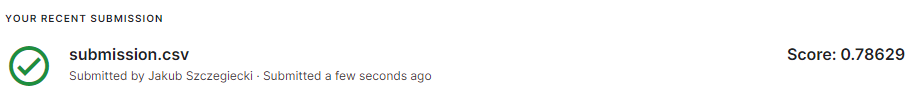